$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [72]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global last_coeff
last_coeff=1

In [73]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [74]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(300-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [75]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [76]:
num_iter=2000

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    #TODO deep copy history_r
    history_target=[0 for i in range(len())]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_r[u_k] = np.array([r*last_coeff])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags[time],observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for i in range(6):
        gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[i], history_target)
    '''  
         
    #TODO
    '''       
    for i in range(N+1):
        if i==1:
            r_t[-i]=0.3**(N+1-i)*r_t[-i]
            
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = observation_t[-i].reshape(-1,5)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], observation_t[-i].reshape(-1,5)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]])))
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
            
        elif i>1:
            r_t[-i]=0.3**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags[-i+1],observation_t[-i+1])
            
            if flags[-i][u_t[-i]]:
                history_su[-i][u_t[-i]] = observation_t[-i].reshape(-1,5)
                history_r[-i][u_t[-i]] = np.array([r_t[-i]])
                flags[-i][u_t[-i]]=False
            else:
                history_su[-i][u_t[-i]] = np.concatenate((history_su[-i][u_t[-i]], observation_t[-i].reshape(-1,5)))
                history_r[-i][u_t[-i]] = np.concatenate((history_r[-i][u_t[-i]],np.array([r_t[-i]]))) 
            
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[-i][u_t[-i]], history_r[-i][u_t[-i]].reshape(-1,1))
    
    r_t[0]=r_t[0]+value_func(gpr_list[1],flags[1],observation_t[1])
    if flags[0][u_t[0]]:
        history_su[0][u_t[0]] = observation_t[0].reshape(-1,5)
        history_r[0][u_t[0]] = np.array([r_t[0]])
        flags[0][u_t[0]]=False
    else:
        history_su[0][u_t[0]] = np.concatenate((history_su[0][u_t[0]], observation_t[0].reshape(-1,5)))
        history_r[0][u_t[0]] = np.concatenate((history_r[0][u_t[0]],np.array([r_t[0]])))
    gpr_list[0][u_t[0]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[0][u_t[0]], history_r[0][u_t[0]].reshape(-1,1))
    '''
    
    '''
    #add to history
    for i in range(N+1):
        if flags[i][u_t[i]]:
            history_su[i][u_t[i]] = observation_t[i].reshape(-1,5)
            history_r[i][u_t[i]] = np.array([r_t[i]])
            flags[i][u_t[i]]=False
        else:
            history_su[i][u_t[i]] = np.concatenate((history_su[i][u_t[i]], observation_t[i].reshape(-1,5)))
            history_r[i][u_t[i]] = np.concatenate((history_r[i][u_t[i]],np.array([r_t[i]])))
            
        gpr_list[i][u_t[i]]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i][u_t[i]], history_r[i][u_t[i]].reshape(-1,1))
    '''

        
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  0%|                                                                                 | 3/2000 [00:00<03:20,  9.98it/s]

observation = [-2.52330032e+00 -2.59476457e+00 -1.64933614e+00  4.04602533e-03
  1.39177922e-04]
observation = [ 0.44001517 -0.35867206 -0.4712389   0.00467567  0.01118823]
observation = [-2.53422941e+00 -2.62472098e+00  7.06858347e-01  1.24646834e-03
  1.70196956e-03]


  0%|▏                                                                                | 5/2000 [00:00<03:40,  9.05it/s]

observation = [-2.93762316 -2.46981713 -2.59181394  0.00927234  0.00394404]
observation = [-0.91372835 -4.61657265 -0.4712389   0.00806325  0.01310581]


  0%|▎                                                                                | 7/2000 [00:00<04:18,  7.71it/s]

observation = [-5.65979277  0.28647758  0.78539816  0.04670326  0.19398158]
observation = [-3.53473650e+00 -3.42617730e+00  9.42477796e-01  3.19057182e-04
  7.90190258e-03]


  0%|▎                                                                                | 9/2000 [00:01<05:17,  6.28it/s]

observation = [-3.28839091e+00  1.67397681e-02  2.98451302e+00  1.80304133e-03
  2.61158308e-05]
observation = [-1.77539551 -1.75248464  1.80641578  0.01413322  0.00996832]


  1%|▍                                                                               | 11/2000 [00:01<05:43,  5.79it/s]

observation = [-0.68315235 -0.64169161  1.57079633  0.04346344  0.00427945]
observation = [-1.49269835e-02 -1.65543639e+00  7.06858347e-01  5.57473248e-04
  1.88088986e-04]


  1%|▌                                                                               | 13/2000 [00:01<06:00,  5.52it/s]

observation = [-5.14663752e+00 -1.86649595e+00  1.88495559e+00  1.19357622e-03
  1.30359360e-04]
observation = [-2.16003162 -0.6068336   0.23561945  0.00627528  0.00713449]


  1%|▌                                                                               | 15/2000 [00:02<06:13,  5.31it/s]

observation = [ 1.51545308e+00 -2.81596413e+00  2.63677968e-17  9.61068074e-03
  2.85169420e-03]
observation = [-2.36079382 -0.80340074  1.57079633  0.05233704  0.04738581]


  1%|▋                                                                               | 17/2000 [00:02<06:13,  5.30it/s]

observation = [ 0.25949131 -2.10416965  1.80641578  0.02275867  0.00531162]
observation = [-2.37911337  0.10131366 -0.4712389   0.00306936  0.01364722]


  1%|▊                                                                               | 19/2000 [00:03<06:11,  5.33it/s]

observation = [-0.97977268  0.88549795  1.41371669  0.02140166  0.01692143]
observation = [ 1.1877905  -0.03645525 -0.23561945  0.00454477  0.01474435]


  1%|▊                                                                               | 21/2000 [00:03<06:14,  5.29it/s]

observation = [-1.33829346e+00 -2.56273353e+00 -1.64933614e+00  6.26935446e-05
  1.23675777e-03]
observation = [-5.93498667e-01 -2.37406382e+00 -1.64933614e+00  2.03163109e-03
  5.54053016e-04]


  1%|▉                                                                               | 23/2000 [00:03<06:17,  5.24it/s]

observation = [-2.86240786e+00  1.13311178e-01 -2.35619449e-01  2.21777225e-03
  1.39243498e-02]
observation = [-2.13328006 -0.45635244  2.74889357  0.01809723  0.02046949]


  1%|█                                                                               | 25/2000 [00:04<06:21,  5.18it/s]

observation = [-2.98637670e+00 -1.30331320e+00  2.74889357e+00  1.15345729e-03
  3.56916986e-02]
observation = [-3.02125821e+00 -2.30057350e+00  2.04203522e+00  1.03665835e-03
  1.02051141e-02]


  1%|█                                                                               | 26/2000 [00:04<06:22,  5.16it/s]

observation = [-1.09062392e+00 -3.74798416e-01 -2.59181394e+00  1.86373636e-02
  1.96421935e-04]
observation = [ 2.02866743 -0.57403144  0.23561945  0.00576054  0.00575986]


  1%|█▏                                                                              | 29/2000 [00:05<06:20,  5.18it/s]

observation = [ 4.34730109  0.18590516 -0.23561945  0.02164722  0.0184125 ]
observation = [-2.37358631e+00 -1.53869218e+00 -2.12057504e+00  6.90430693e-05
  8.40089190e-05]


  2%|█▏                                                                              | 31/2000 [00:05<06:18,  5.20it/s]

observation = [-4.35283287e+00 -2.70924461e+00  1.88495559e+00  1.02901058e-04
  1.52703368e-04]
observation = [ 2.48021945e+00 -1.44330175e+00 -4.71238898e-01  1.35377617e-02
  8.74691672e-04]


  2%|█▎                                                                              | 33/2000 [00:05<06:16,  5.22it/s]

observation = [ 1.67457825e+00 -1.30961295e+00 -1.80411242e-17  6.42921771e-03
  8.64879078e-04]
observation = [-1.89556202e+00 -1.91453826e+00 -2.35619449e+00  1.21108572e-07
  3.83333045e-04]


  2%|█▍                                                                              | 35/2000 [00:06<06:16,  5.21it/s]

observation = [-0.48781553  1.68476373  0.70685835  0.01658181  0.04558839]
observation = [-3.81109848e+00  4.02062032e-02  7.06858347e-01  3.32651026e-05
  1.53745777e-02]


  2%|█▍                                                                              | 37/2000 [00:06<06:21,  5.15it/s]

observation = [-5.39143618e-03 -3.33670226e+00  2.27765467e+00  1.34445418e-03
  1.32370433e-02]
observation = [-2.98954629  0.52418689  1.33517688  0.14192381  0.14637043]


  2%|█▌                                                                              | 39/2000 [00:06<06:22,  5.13it/s]

observation = [-2.26443667 -2.20462425  2.27765467  0.00291445  0.03559848]
observation = [-5.40495702e+00 -4.37880237e-01 -3.06305284e+00  7.28453264e-04
  2.34000466e-01]


  2%|█▋                                                                              | 41/2000 [00:07<06:23,  5.11it/s]

observation = [-2.27711071  0.70093468 -1.17809725  0.0106443   0.02023724]
observation = [-3.03489260e+00 -2.54183453e+00  2.51327412e+00  1.92580721e-03
  1.98926948e-02]


  2%|█▋                                                                              | 43/2000 [00:07<06:16,  5.19it/s]

observation = [-7.13772664e-01 -2.41159014e+00 -9.42477796e-01  1.09730210e-03
  4.81341026e-04]
observation = [-4.64697495e+00 -3.90203651e+00  2.59181394e+00  1.73583377e-03
  1.54970791e-02]


  2%|█▊                                                                              | 45/2000 [00:08<06:16,  5.20it/s]

observation = [-5.36924938e-01 -5.68597845e-01 -2.35619449e-01  7.65441688e-05
  2.55154910e-03]
observation = [-3.67630415e+00 -2.91206386e+00  1.88495559e+00  3.86159138e-06
  1.16390854e-03]


  2%|█▉                                                                              | 47/2000 [00:08<06:22,  5.10it/s]

observation = [-7.28144303e-01 -9.15667492e-01 -2.35619449e-01  3.71909643e-06
  2.10034812e-03]
observation = [-3.52796368e+00 -3.25720467e+00  2.35619449e+00  2.41912489e-04
  5.46811999e-03]


  2%|█▉                                                                              | 49/2000 [00:08<06:20,  5.13it/s]

observation = [-5.96350882e+00 -1.68739001e+00  2.12057504e+00  5.10298683e-03
  2.39346937e-03]
observation = [-4.25997811e-01 -2.51007491e+00  1.88495559e+00  5.68787203e-03
  1.95868555e-03]


  3%|██                                                                              | 51/2000 [00:09<06:18,  5.16it/s]

observation = [-3.40834130e+00 -4.04242176e+00  1.88495559e+00  6.77399656e-04
  1.10832210e-02]
observation = [ 6.20740309e-01 -1.42709085e-01  4.71238898e-01  3.63687348e-04
  8.55775744e-03]


  3%|██                                                                              | 53/2000 [00:09<06:53,  4.71it/s]

observation = [ 0.93079825 -1.37148396  1.64933614  0.01230821  0.0125309 ]
observation = [ 0.71636278 -0.66371791  1.64933614  0.00310725  0.00717486]


  3%|██▏                                                                             | 55/2000 [00:10<06:33,  4.94it/s]

observation = [-8.76427366e-01 -3.08513941e+00 -7.06858347e-01  2.46100515e-04
  4.73610026e-03]
observation = [ 5.31853121 -4.69853677 -1.64933614  0.0186328   0.01947064]


  3%|██▏                                                                             | 56/2000 [00:10<06:27,  5.02it/s]

observation = [1.56197651e+00 1.23952666e+00 1.17809725e+00 2.77747324e-05
 2.81490340e-02]


  3%|██▎                                                                             | 58/2000 [00:10<06:22,  5.08it/s]

observation = [-4.48056730e+00 -5.20881556e+00  2.98451302e+00  1.14783690e-01
  4.91172310e-03]
observation = [ 1.04648124 -4.28200229  2.27765467  0.0098052   0.01699862]


  3%|██▍                                                                             | 60/2000 [00:11<06:20,  5.10it/s]

observation = [-2.66209699  0.09940492  0.70685835  0.01336835  0.00957571]
observation = [ 1.32815075e+00 -1.90549863e+00  2.04203522e+00  4.61555513e-02
  2.29041808e-04]


  3%|██▍                                                                             | 62/2000 [00:11<06:15,  5.16it/s]

observation = [-2.81651530e+00 -1.68311110e+00 -1.17809725e+00  5.61411290e-04
  4.08662049e-04]
observation = [ 0.67561682 -0.90387348  0.23561945  0.00725923  0.0076843 ]


  3%|██▌                                                                             | 64/2000 [00:11<06:15,  5.16it/s]

observation = [ 1.97340600e+00 -2.25178680e+00 -9.42477796e-01  1.10160547e-02
  2.44844249e-04]
observation = [-1.87656600e+00  2.31271321e+00  3.06305284e+00  5.26097981e-02
  1.00093021e-03]


  3%|██▋                                                                             | 66/2000 [00:12<06:14,  5.16it/s]

observation = [ 9.32725082e-01 -3.22903833e+00 -2.82743339e+00  1.41450722e-03
  2.66260254e-04]
observation = [-1.99221409e+00 -2.47392998e+00  4.71238898e-01  3.00771398e-04
  6.15704726e-04]


  3%|██▋                                                                             | 67/2000 [00:12<06:11,  5.20it/s]

observation = [-2.30804562 -4.03908365  0.9424778   0.00716845  0.00659744]


  3%|██▊                                                                             | 69/2000 [00:12<06:16,  5.14it/s]

observation = [0.17174322 3.63421438 1.88495559 0.04141113 0.04213088]
observation = [-4.54062145  3.12464105  2.12057504  0.18257366  0.01096408]


  4%|██▊                                                                             | 71/2000 [00:13<06:16,  5.13it/s]

observation = [-3.45974212e+00  4.30313527e+00  1.64933614e+00  2.06719207e-01
  5.02335128e-04]
observation = [ 6.93322730e-01 -2.00655890e+00  1.17809725e+00  3.28538234e-03
  2.13302990e-04]


  4%|██▉                                                                             | 73/2000 [00:13<06:18,  5.09it/s]

observation = [ 1.53196456e+00  1.59682229e+00 -1.80411242e-17  8.31316574e-05
  3.78512541e-02]
observation = [ 6.90118182e+00 -2.35581422e+00 -7.06858347e-01  8.23915239e-02
  6.25992845e-04]


  4%|███                                                                             | 75/2000 [00:14<06:11,  5.19it/s]

observation = [-4.11081047e+00 -9.59117849e-01 -4.71238898e-01  2.43647784e-03
  2.70763808e-03]
observation = [ 1.56037517 -1.8322761  -2.82743339  0.02851264  0.00408262]


  4%|███                                                                             | 77/2000 [00:14<06:10,  5.18it/s]

observation = [2.50846981e+00 1.87595334e+00 1.17809725e+00 1.70443811e-03
 5.62381338e-02]
observation = [ 0.2099479  -0.36827948 -0.23561945  0.01525454  0.00930012]


  4%|███▏                                                                            | 79/2000 [00:14<06:13,  5.14it/s]

observation = [-2.12035637e+00  2.11917900e+00  1.88495559e+00  7.15813139e-02
  1.97523123e-03]
observation = [-1.48945214e+00 -3.53384548e-01 -4.71238898e-01  5.74586885e-05
  1.15671279e-02]


  4%|███▏                                                                            | 81/2000 [00:15<06:09,  5.19it/s]

observation = [-5.73518668e+00  1.41566000e+00  1.06858966e-16  6.48946890e-04
  6.39496824e-02]
observation = [ 1.32166597 -0.69015984 -1.64933614  0.01300642  0.00675267]


  4%|███▎                                                                            | 82/2000 [00:15<06:13,  5.14it/s]

observation = [ 3.38974806e+00 -2.53069545e+00 -7.06858347e-01  2.86236390e-02
  1.27979288e-03]
observation = [-0.20031097 -0.43270217  3.06305284  0.00708861  0.05331411]


  4%|███▍                                                                            | 85/2000 [00:15<06:12,  5.14it/s]

observation = [3.65360929 1.63345992 1.41371669 0.01855516 0.07334524]
observation = [-4.93409622e+00 -2.14961215e+00  2.35619449e+00  2.28924947e-03
  3.93947035e-04]


  4%|███▍                                                                            | 87/2000 [00:16<06:11,  5.14it/s]

observation = [-0.68356868 -4.82341053 -0.23561945  0.00513933  0.01973259]
observation = [1.25352567 0.27354367 2.98451302 0.07752237 0.00413044]


  4%|███▌                                                                            | 88/2000 [00:16<06:11,  5.15it/s]

observation = [ 5.78891128  0.21956569 -0.23561945  0.04598885  0.02016023]
observation = [-2.96667764e+00 -4.48438307e-01  9.42477796e-01  1.24450759e-03
  8.80391663e-03]


  5%|███▋                                                                            | 91/2000 [00:17<06:10,  5.15it/s]

observation = [-6.39392114e+00 -2.45008628e+00  1.88495559e+00  6.97160427e-03
  6.92583071e-05]
observation = [-2.25117724  2.31926951  2.35619449  0.06494567  0.00281178]


  5%|███▋                                                                            | 93/2000 [00:17<06:13,  5.10it/s]

observation = [-2.11325761e+00 -1.67097616e+00 -1.64933614e+00  4.54277804e-05
  3.10328244e-04]
observation = [-2.85477303e+00  1.61363211e+00  1.64933614e+00  7.96542972e-02
  2.33690774e-04]


  5%|███▊                                                                            | 94/2000 [00:17<06:11,  5.13it/s]

observation = [-1.65619017e-01 -3.78439001e+00 -1.88495559e+00  1.97829686e-03
  1.22140996e-04]


  5%|███▊                                                                            | 96/2000 [00:18<06:13,  5.10it/s]

observation = [3.39781246e+00 3.27752311e+00 7.06858347e-01 4.04983088e-04
 9.53158387e-02]
observation = [2.22626096 1.54829149 2.59181394 0.005466   0.16726193]


  5%|███▉                                                                            | 97/2000 [00:18<06:16,  5.05it/s]

observation = [3.63017803 0.14596234 0.9424778  0.02406706 0.01931706]


  5%|███▉                                                                            | 99/2000 [00:18<06:26,  4.92it/s]

observation = [-0.07036775 -0.78595925 -1.88495559  0.0147909   0.00190929]
observation = [ 4.65172396  1.22817243 -0.23561945  0.01961224  0.04015583]


  5%|███▉                                                                           | 101/2000 [00:19<06:16,  5.05it/s]

observation = [1.77538663 0.77006217 1.88495559 0.00293866 0.0262977 ]
observation = [-2.18089903e+00 -3.84514987e+00  4.71238898e-01  7.72349231e-03
  3.31040363e-03]


  5%|████                                                                           | 103/2000 [00:19<06:15,  5.05it/s]

observation = [ 0.28377661  1.06055498 -2.51327412  0.01136234  0.02336402]
observation = [ 1.28208749 -1.16810733 -0.23561945  0.01309454  0.00327901]


  5%|████▏                                                                          | 105/2000 [00:19<06:07,  5.15it/s]

observation = [ 1.97176896e+00  1.38759618e+00 -1.06858966e-16  6.96480663e-04
  3.98973505e-02]
observation = [-2.85109897  0.93257231 -2.98451302  0.03873061  0.01434502]


  5%|████▏                                                                          | 107/2000 [00:20<06:05,  5.17it/s]

observation = [-4.11493245 -6.5261861   1.41371669  0.01091358  0.05510716]
observation = [ 9.05839062e-01  1.62665548e+00 -2.82743339e+00  1.29223829e-01
  7.35457150e-04]


  5%|████▎                                                                          | 108/2000 [00:20<06:14,  5.06it/s]

observation = [1.95466076 1.03956704 0.4712389  0.00422397 0.03659247]


  6%|████▎                                                                          | 110/2000 [00:20<06:18,  5.00it/s]

observation = [-3.53065062e+00 -1.20235946e+00  2.35619449e+00  1.58732231e-02
  9.14595940e-04]
observation = [-1.63290435 -2.92699574  2.51327412  0.00315492  0.01449713]


  6%|████▍                                                                          | 112/2000 [00:21<06:24,  4.91it/s]

observation = [-2.78741613e+00 -4.94793477e+00 -1.80411242e-17  1.19000913e-02
  1.49816973e-02]
observation = [-6.28851988e+00 -1.46271732e+00  2.35619449e+00  3.82781013e-02
  6.05752780e-05]


  6%|████▌                                                                          | 114/2000 [00:21<06:19,  4.97it/s]

observation = [3.06491115 2.14007897 0.9424778  0.00359006 0.06443099]
observation = [-3.97243580e-01 -1.00198822e+00  2.35619449e-01  5.26864544e-04
  3.74876863e-03]


  6%|████▌                                                                          | 116/2000 [00:22<06:14,  5.03it/s]

observation = [ 1.36846366 -0.14083466  1.88495559  0.00651387  0.01612389]
observation = [ 1.70549097  0.44570093 -1.17809725  0.00611252  0.02534962]


  6%|████▋                                                                          | 118/2000 [00:22<06:14,  5.03it/s]

observation = [ 1.69943869 -0.98436875  0.70685835  0.02174316  0.03161634]
observation = [ 1.23919431 -0.76558491 -1.17809725  0.01208459  0.00685061]


  6%|████▋                                                                          | 120/2000 [00:23<06:46,  4.63it/s]

observation = [ 0.485113   -0.82973082  0.9424778   0.00448867  0.00743944]
observation = [ 1.56081359 -1.18772625 -1.88495559  0.01375961  0.00563165]


  6%|████▊                                                                          | 122/2000 [00:23<06:26,  4.86it/s]

observation = [ 2.41444658 -0.55822686  0.23561945  0.01277666  0.00720609]
observation = [-2.98047413e+00 -1.37178942e+00 -2.82743339e+00  8.45157675e-04
  8.67742702e-03]


  6%|████▉                                                                          | 124/2000 [00:23<06:16,  4.99it/s]

observation = [-0.33937698 -3.68252155  1.17809725  0.02452786  0.00708657]
observation = [-0.78911105 -0.22920434 -2.51327412  0.01328759  0.00957521]


  6%|████▉                                                                          | 126/2000 [00:24<06:14,  5.01it/s]

observation = [ 1.10041891e+00  1.18223137e+00 -9.42477796e-01  3.86842907e-04
  3.74315465e-02]
observation = [-1.86761619 -4.93208649  0.70685835  0.02327704  0.01105871]


  6%|█████                                                                          | 127/2000 [00:24<06:14,  5.00it/s]

observation = [ 5.52692333 -0.05740811  0.23561945  0.05136559  0.01724693]
observation = [-3.27510504e+00  4.98036110e+00  1.64933614e+00  2.32123669e-01
  4.73021926e-03]


  6%|█████▏                                                                         | 130/2000 [00:24<06:08,  5.07it/s]

observation = [-2.96273383 -5.07143799 -0.4712389   0.01024646  0.0211817 ]
observation = [-0.64751891 -1.28278008  0.23561945  0.00142161  0.00236446]


  7%|█████▏                                                                         | 131/2000 [00:25<06:11,  5.04it/s]

observation = [ 0.75170635 -0.31040154  1.88495559  0.00266215  0.0230353 ]
observation = [-1.58613131 -5.14667157  0.9424778   0.03145709  0.01191336]


  7%|█████▎                                                                         | 134/2000 [00:25<06:02,  5.15it/s]

observation = [-2.98934629e+00 -1.22256908e+00 -1.17809725e+00  2.79209773e-05
  1.66404201e-03]
observation = [ 3.52622433e+00 -1.18971843e+00 -6.93889390e-18  3.37158891e-02
  2.97978121e-03]


  7%|█████▎                                                                         | 136/2000 [00:26<05:59,  5.19it/s]

observation = [ 1.17111339 -1.92220597  0.70685835  0.02487987  0.00345156]
observation = [-2.94646503 -5.26483339  0.9424778   0.01127931  0.02558452]


  7%|█████▍                                                                         | 138/2000 [00:26<05:59,  5.18it/s]

observation = [ 2.48137357 -1.95106157 -2.82743339  0.04721433  0.0240559 ]
observation = [-4.16024993e+00 -4.59614638e+00  4.71238898e-01  3.84176428e-05
  2.66774735e-02]


  7%|█████▌                                                                         | 140/2000 [00:26<05:58,  5.19it/s]

observation = [ 0.02713219 -4.13399388  0.9424778   0.02882566  0.00842983]
observation = [-1.28165117e+00 -5.42404456e+00  1.64933614e+00  5.06714515e-02
  1.90184852e-03]


  7%|█████▌                                                                         | 142/2000 [00:27<06:03,  5.11it/s]

observation = [ 2.38575137 -1.65292648 -2.35619449  0.01905034  0.00339881]
observation = [ 1.06897341e+00 -5.11462580e+00  1.04083409e-16  3.52625571e-04
  2.74304904e-02]


  7%|█████▋                                                                         | 144/2000 [00:27<06:03,  5.11it/s]

observation = [ 0.67864499 -0.33252844  0.9424778   0.00277983  0.01151926]
observation = [-3.58855494 -4.87522315  2.12057504  0.00494756  0.01556784]


  7%|█████▊                                                                         | 146/2000 [00:28<06:02,  5.11it/s]

observation = [ 3.50260684 -0.75211945 -0.4712389   0.03269912  0.00745209]
observation = [-3.43574641e-01 -2.43876369e+00  7.06858347e-01  5.17149506e-03
  9.57742362e-04]


  7%|█████▊                                                                         | 148/2000 [00:28<06:08,  5.03it/s]

observation = [8.34878553e-01 4.37857013e-01 2.59181394e+00 1.35674383e-04
 3.63749714e-02]
observation = [-0.52646032  1.63935217 -2.74889357  0.03128935  0.01763642]


  8%|█████▉                                                                         | 150/2000 [00:28<06:02,  5.10it/s]

observation = [-6.42113948e+00 -3.19562591e+00  2.12057504e+00  3.94865241e-03
  2.48335920e-04]
observation = [-4.41586133e+00 -3.59074239e+00  2.35619449e+00  3.10902599e-03
  1.42080300e-02]


  8%|██████                                                                         | 152/2000 [00:29<06:04,  5.06it/s]

observation = [ 4.90262007 -0.62840497 -0.23561945  0.04126273  0.00813822]
observation = [-0.69373059 -0.03863738 -0.23561945  0.00157451  0.01021022]


  8%|██████                                                                         | 154/2000 [00:29<06:02,  5.09it/s]

observation = [-1.48781230e+00 -1.20013418e+00 -1.64933614e+00  4.50491632e-03
  1.13844306e-03]
observation = [-3.80373396e+00  5.17546524e+00  1.17809725e+00  2.89540784e-01
  8.12842058e-04]


  8%|██████▏                                                                        | 156/2000 [00:30<06:06,  5.03it/s]

observation = [-0.92367169  0.37108889  2.59181394  0.00764794  0.00261126]
observation = [ 1.78712602e+00  9.48827124e-01 -9.42477796e-01  2.26340195e-04
  2.79357554e-02]


  8%|██████▏                                                                        | 158/2000 [00:30<06:05,  5.04it/s]

observation = [-0.8919947  -0.68180344 -1.17809725  0.00827945  0.00541554]
observation = [-5.38177823e-01 -1.83453866e+00  9.42477796e-01  2.54719633e-03
  9.06153915e-05]


  8%|██████▎                                                                        | 160/2000 [00:30<06:08,  4.99it/s]

observation = [-5.38891397e+00 -1.97983276e+00  2.35619449e+00  2.17310186e-04
  1.98285081e-03]
observation = [-0.31501165 -0.48256787  0.23561945  0.00107614  0.00836778]


  8%|██████▎                                                                        | 161/2000 [00:31<06:06,  5.02it/s]

observation = [-2.90009593e+00  3.49794958e+00  2.12057504e+00  1.44034979e-01
  5.66874058e-04]
observation = [-5.35027250e+00 -2.66554949e+00  3.06305284e+00  3.20707177e-03
  1.27435797e-05]


  8%|██████▍                                                                        | 163/2000 [00:31<06:11,  4.95it/s]

observation = [-0.55211961  0.84843344  2.59181394  0.01348898  0.0209489 ]


  8%|██████▌                                                                        | 165/2000 [00:31<06:05,  5.02it/s]

observation = [-2.77097058  1.76789434  0.9424778   0.04761827  0.02145197]
observation = [-1.77804839  0.11097353  1.41371669  0.00254875  0.02097317]


  8%|██████▌                                                                        | 167/2000 [00:32<06:10,  4.94it/s]

observation = [1.92647790e+00 2.26407525e+00 2.35619449e-01 1.65049801e-04
 5.90845150e-02]
observation = [2.15848612 1.01790184 0.70685835 0.00453857 0.04373517]


  8%|██████▋                                                                        | 169/2000 [00:32<06:04,  5.02it/s]

observation = [-2.25191314 -0.03745307  1.41371669  0.01197998  0.00617742]
observation = [ 1.83817987  0.83537618 -0.70685835  0.0028568   0.02940763]


  9%|██████▊                                                                        | 171/2000 [00:33<06:09,  4.95it/s]

observation = [ 1.74329821 -0.90056325  1.64933614  0.02268001  0.0229899 ]
observation = [-1.23218978e+00  4.74067878e-01 -2.27765467e+00  9.71371926e-03
  4.71388652e-05]


  9%|██████▊                                                                        | 173/2000 [00:33<06:06,  4.99it/s]

observation = [-1.26839553  2.35890225  2.59181394  0.05633294  0.01144019]
observation = [-5.19419113  3.02729045  2.35619449  0.2188257   0.07000063]


  9%|██████▉                                                                        | 175/2000 [00:33<06:07,  4.96it/s]

observation = [-8.79039689e-02 -8.21561979e-01  7.06858347e-01  4.14825517e-04
  3.62928982e-03]
observation = [ 1.33396317 -2.78890101  1.64933614  0.04379593  0.00967462]


  9%|██████▉                                                                        | 177/2000 [00:34<06:08,  4.95it/s]

observation = [ 1.84382991 -1.76861126  0.23561945  0.03141103  0.03204391]
observation = [-2.94269743e+00 -3.22069142e-01  2.59181394e+00  9.77549542e-04
  5.40600958e-02]


  9%|███████                                                                        | 179/2000 [00:34<06:00,  5.04it/s]

observation = [-7.08651213e+00 -5.96382088e+00  7.06858347e-01  4.00029548e-03
  5.73567234e-02]
observation = [ 3.0975045  -0.24821786 -0.70685835  0.01027643  0.01061407]


  9%|███████                                                                        | 180/2000 [00:34<05:58,  5.07it/s]

observation = [-0.14431106 -0.61908482 -2.12057504  0.01270546  0.00361546]
observation = [-6.13710428e-02 -6.94637079e-01 -2.12057504e+00  2.67100177e-04
  5.75374156e-03]


  9%|███████▏                                                                       | 183/2000 [00:35<06:00,  5.04it/s]

observation = [-0.87553478  1.93223388 -2.27765467  0.0617376   0.00956326]
observation = [ 4.10371617e-01 -4.80835077e-01  2.63677968e-17  4.43808341e-03
  8.98988345e-03]


  9%|███████▎                                                                       | 185/2000 [00:35<06:02,  5.01it/s]

observation = [1.82964566e+00 2.43437409e+00 7.06858347e-01 5.19545003e-04
 6.41342936e-02]
observation = [2.12623757e+00 1.59127329e+00 2.35619449e-01 1.84837748e-03
 4.89915702e-02]


  9%|███████▎                                                                       | 186/2000 [00:36<06:02,  5.00it/s]

observation = [-7.95522948e+00 -7.09057669e+00  2.35619449e-01  5.24837130e-03
  9.85123318e-02]


  9%|███████▍                                                                       | 187/2000 [00:36<06:50,  4.42it/s]

observation = [-9.99967334e-01  1.02742853e+00 -2.74889357e+00  2.98155008e-02
  1.47048205e-03]
observation = [ 0.30763123 -1.5581636   0.70685835  0.0082147   0.00187697]


 10%|███████▌                                                                       | 190/2000 [00:36<06:17,  4.79it/s]

observation = [0.28833805 3.51237928 0.70685835 0.03284135 0.05671582]
observation = [-2.24955053e+00 -1.16768809e+00 -3.06305284e+00  1.47983139e-04
  1.45150577e-03]


 10%|███████▌                                                                       | 191/2000 [00:37<06:14,  4.83it/s]

observation = [ 1.47290118 -0.11412917  2.12057504  0.00306785  0.08104412]
observation = [-0.83711904  0.99541842 -1.80641578  0.01382751  0.00815948]


 10%|███████▋                                                                       | 194/2000 [00:37<06:06,  4.93it/s]

observation = [-5.29633090e-01 -1.26538029e+00 -2.12057504e+00  1.57372684e-04
  6.91137803e-03]
observation = [-4.41579456  1.28972365  1.17809725  0.06106347  0.02254272]


 10%|███████▋                                                                       | 196/2000 [00:38<06:03,  4.97it/s]

observation = [-3.12526246e+00 -3.09919211e-01  1.17809725e+00  2.07855473e-02
  1.84134404e-03]
observation = [5.83541462 1.41725826 1.17809725 0.02458819 0.03342294]


 10%|███████▊                                                                       | 198/2000 [00:38<05:58,  5.03it/s]

observation = [-0.04424983  2.15458328  3.06305284  0.01495562  0.02665255]
observation = [ 0.38984437 -1.63241277  3.06305284  0.01353684  0.00397515]


 10%|███████▊                                                                       | 199/2000 [00:38<06:02,  4.97it/s]

observation = [2.17289935e+00 2.19115323e+00 9.42477796e-01 1.46922699e-04
 6.12072124e-02]


 10%|███████▉                                                                       | 201/2000 [00:39<06:06,  4.91it/s]

observation = [ 1.76458198 -0.89591362  2.35619449  0.01727649  0.03695784]
observation = [-1.11116481e+00 -2.39905979e+00  9.42477796e-01  9.15902323e-04
  7.29895753e-04]


 10%|███████▉                                                                       | 202/2000 [00:39<06:05,  4.92it/s]

observation = [ 5.57216647e-01 -5.10716552e+00  1.88495559e+00  9.80208044e-02
  7.99835393e-04]
observation = [0.45725229 1.89854291 1.64933614 0.02784539 0.07738338]


 10%|████████                                                                       | 205/2000 [00:40<06:03,  4.94it/s]

observation = [ 8.22201763e-01 -1.34205321e+00 -7.06858347e-01  1.99812738e-02
  4.40092150e-04]
observation = [-8.68902423e-01 -3.54597520e+00  1.57079633e+00  2.45017267e-02
  3.27101818e-03]


 10%|████████▏                                                                      | 207/2000 [00:40<06:00,  4.98it/s]

observation = [-2.08980902 -5.77492184 -0.23561945  0.03486686  0.01467928]
observation = [-1.67893180e+00 -8.67380980e-02 -2.74889357e+00  1.07576051e-02
  1.57672839e-03]


 10%|████████▏                                                                      | 208/2000 [00:40<06:00,  4.97it/s]

observation = [-1.49793746 -4.22531528  0.23561945  0.01147866  0.01511955]


 10%|████████▎                                                                      | 210/2000 [00:41<06:06,  4.89it/s]

observation = [ 3.70209566e-01 -4.56698542e-01 -9.42477796e-01  1.57340182e-04
  1.42684584e-02]
observation = [0.16406902 3.17695396 0.9424778  0.02742703 0.05591343]


 11%|████████▎                                                                      | 212/2000 [00:41<06:07,  4.87it/s]

observation = [-3.88608932  4.15040562  2.35619449  0.22134371  0.0072979 ]
observation = [-3.68933267e+00 -3.67285743e+00  2.82743339e+00  4.44563957e-04
  4.74341894e-02]


 11%|████████▍                                                                      | 213/2000 [00:41<06:07,  4.86it/s]

observation = [-0.61951822 -3.65213523  1.88495559  0.02025629  0.009026  ]


 11%|████████▍                                                                      | 215/2000 [00:42<06:05,  4.89it/s]

observation = [-1.93618593e+00 -4.46564032e+00 -2.35619449e-01  2.28460475e-03
  2.00235215e-02]
observation = [ 1.14262192 -3.17621622 -2.59181394  0.00426447  0.01828117]


 11%|████████▌                                                                      | 217/2000 [00:42<06:05,  4.87it/s]

observation = [ 1.2946899  -1.45291875  1.64933614  0.02052595  0.02160529]
observation = [ 4.02143304e+00 -1.64214160e+00 -2.12057504e+00  3.21524387e-02
  2.49481899e-05]


 11%|████████▌                                                                      | 218/2000 [00:42<06:03,  4.90it/s]

observation = [ 2.24487727e+00 -5.62375638e+00 -2.35619449e-01  5.56977596e-04
  4.05024341e-02]


 11%|████████▋                                                                      | 220/2000 [00:43<06:06,  4.86it/s]

observation = [ 1.03898364 -0.98800477  1.88495559  0.01044235  0.03151688]
observation = [ 1.55077911e+00 -1.43358082e+00 -7.06858347e-01  1.05812112e-02
  1.07494766e-03]


 11%|████████▊                                                                      | 222/2000 [00:43<06:09,  4.82it/s]

observation = [4.06948034e+00 3.43691500e+00 1.64933614e+00 2.05754969e-03
 1.05701410e-01]
observation = [-1.78344099e+00 -1.60875201e+00 -1.88495559e+00  7.90007493e-04
  2.78138306e-03]


 11%|████████▊                                                                      | 224/2000 [00:43<06:08,  4.81it/s]

observation = [-3.30676891e+00  3.65369203e+00  2.12057504e+00  1.79594097e-01
  1.00297353e-03]
observation = [-2.89385308  0.8717564  -2.98451302  0.0373184   0.02463999]


 11%|████████▉                                                                      | 226/2000 [00:44<06:09,  4.80it/s]

observation = [ 2.13298887e-01 -4.30280564e+00  2.98451302e+00  6.83705401e-04
  1.35423823e-03]
observation = [-0.75290971  0.85033075  3.06305284  0.01266154  0.00917663]


 11%|█████████                                                                      | 228/2000 [00:44<06:00,  4.91it/s]

observation = [ 0.9438552  -0.38809683 -1.17809725  0.01360347  0.00903922]
observation = [-2.21354995 -0.81534843  2.35619449  0.00248038  0.00575303]


 11%|█████████                                                                      | 229/2000 [00:44<06:03,  4.87it/s]

observation = [-0.12514134  3.28401747  2.59181394  0.03760993  0.03698743]


 12%|█████████                                                                      | 231/2000 [00:45<06:06,  4.82it/s]

observation = [0.49925447 3.79172577 2.12057504 0.0251297  0.07176065]
observation = [-6.71184154e+00 -3.13507395e+00  1.41371669e+00  4.42406036e-03
  2.25830682e-03]


 12%|█████████▏                                                                     | 232/2000 [00:45<06:06,  4.83it/s]

observation = [-2.37135790e+00 -1.42564219e+00  2.59181394e+00  2.19938564e-03
  1.09307638e-04]


 12%|█████████▏                                                                     | 234/2000 [00:45<06:06,  4.82it/s]

observation = [-3.70702571e+00  5.40686629e+00  2.35619449e+00  2.82990062e-01
  1.17208482e-03]
observation = [-5.57373747e-01 -2.28844102e-01 -1.80411242e-17  4.90001662e-04
  7.26923177e-03]


 12%|█████████▎                                                                     | 236/2000 [00:46<06:02,  4.86it/s]

observation = [ 2.9376133  -1.22388235  1.17809725  0.02647069  0.00293779]
observation = [-1.10141652  0.65879512 -2.35619449  0.00644187  0.01398518]


 12%|█████████▍                                                                     | 238/2000 [00:46<06:10,  4.76it/s]

observation = [ 6.17117849 -3.11458021 -1.17809725  0.01843415  0.00626476]
observation = [-0.57117155  1.96864563 -2.74889357  0.02214099  0.01233689]


 12%|█████████▍                                                                     | 240/2000 [00:47<06:07,  4.79it/s]

observation = [-3.13757489e+00  4.93487729e+00  2.59181394e+00  2.14403362e-01
  3.69003565e-04]
observation = [ 0.02200486  1.43296542 -1.17809725  0.00227441  0.04129855]


 12%|█████████▌                                                                     | 241/2000 [00:47<06:04,  4.82it/s]

observation = [-6.46579455 -2.47926795 -2.04203522  0.02739313  0.00958575]
observation = [ 2.70119906 -0.73746889 -2.74889357  0.02500497  0.08578892]


 12%|█████████▌                                                                     | 243/2000 [00:47<06:03,  4.84it/s]

observation = [-3.40522645e+00  4.50941714e+00  1.41371669e+00  2.18886980e-01
  2.96104008e-03]
observation = [-1.07404931  2.76158869 -1.80641578  0.05784662  0.00774002]


 12%|█████████▋                                                                     | 246/2000 [00:48<06:09,  4.75it/s]

observation = [ 2.1299331  -1.64992393  1.64933614  0.04932661  0.04534423]
observation = [ 0.1832725  -0.7973327   0.4712389   0.0019885   0.00533639]


 12%|█████████▊                                                                     | 247/2000 [00:48<06:12,  4.71it/s]

observation = [ 0.3097026  -0.10658606  0.23561945  0.0003794   0.01194471]


 12%|█████████▊                                                                     | 249/2000 [00:49<06:07,  4.77it/s]

observation = [-2.42760906  4.95374297  2.35619449  0.18692313  0.00626557]
observation = [-1.75002535e+00 -1.00012072e+00  1.64933614e+00  6.11128968e-03
  1.27380980e-04]


 12%|█████████▉                                                                     | 250/2000 [00:49<06:11,  4.71it/s]

observation = [ 2.32912881 -4.38086113 -0.9424778   0.00463132  0.01644964]


 13%|█████████▉                                                                     | 252/2000 [00:49<06:08,  4.74it/s]

observation = [-1.40585343e+00 -1.41222890e+00 -1.64933614e+00  1.10068052e-03
  1.56485722e-03]
observation = [ 1.29949391 -3.15107647  2.27765467  0.00845476  0.04469445]


 13%|██████████                                                                     | 254/2000 [00:50<06:33,  4.44it/s]

observation = [-4.33567340e-01 -2.26163094e+00 -2.35619449e+00  2.71889205e-04
  1.10812876e-06]
observation = [ 1.08563029e+00 -2.51811758e+00  2.98451302e+00  2.44197821e-03
  5.15091455e-02]


 13%|██████████                                                                     | 256/2000 [00:50<06:17,  4.62it/s]

observation = [ 2.24387863e+00 -4.63958131e+00 -9.42477796e-01  7.86474986e-04
  1.59195761e-02]
observation = [-2.61755322  1.91980949 -2.51327412  0.0462384   0.00752579]


 13%|██████████▏                                                                    | 257/2000 [00:50<06:27,  4.50it/s]

observation = [3.34594816 0.31970502 1.41371669 0.01644013 0.02065768]


 13%|██████████▏                                                                    | 258/2000 [00:51<06:23,  4.54it/s]

observation = [ 3.23930915  1.54666407 -0.23561945  0.00631296  0.04505603]


 13%|██████████▎                                                                    | 260/2000 [00:51<06:11,  4.69it/s]

observation = [ 4.46210615 -0.51416385 -0.23561945  0.03956     0.009685  ]
observation = [-2.664862    0.36427312 -1.88495559  0.00886808  0.00355564]


 13%|██████████▎                                                                    | 261/2000 [00:51<06:13,  4.66it/s]

observation = [ 1.62231104e+00 -3.84586927e+00 -1.41371669e+00  6.88139864e-05
  5.09637512e-03]


 13%|██████████▎                                                                    | 262/2000 [00:51<06:11,  4.68it/s]

observation = [-0.30252696  0.48788    -0.9424778   0.00106851  0.02750223]


 13%|██████████▍                                                                    | 264/2000 [00:52<06:05,  4.74it/s]

observation = [ 2.81884966e-01 -4.99884686e+00  1.88495559e+00  8.30422194e-02
  1.03153913e-03]
observation = [ 1.28600921e+00 -2.88151588e+00 -1.41371669e+00  5.57438277e-03
  2.49335878e-03]


 13%|██████████▌                                                                    | 266/2000 [00:52<06:04,  4.76it/s]

observation = [-3.38847209  1.01368778  1.41371669  0.03267938  0.01962922]
observation = [ 0.88685509  0.7107847  -1.17809725  0.02127459  0.02233466]


 13%|██████████▌                                                                    | 267/2000 [00:53<06:04,  4.76it/s]

observation = [-2.22775365 -5.31224242 -2.74889357  0.02700997  0.00740119]


 13%|██████████▌                                                                    | 268/2000 [00:53<06:03,  4.76it/s]

observation = [ 2.51503124e+00  2.74237593e-02 -1.06858966e-16  2.00432148e-02
  2.80015177e-02]


 13%|██████████▋                                                                    | 269/2000 [00:53<06:01,  4.79it/s]

observation = [-2.01573566e+00 -2.89252281e+00  1.88495559e+00  6.37614022e-04
  4.11283143e-03]


 14%|██████████▋                                                                    | 270/2000 [00:53<06:07,  4.71it/s]

observation = [ 1.21170634e+00 -2.95599100e+00 -2.82743339e+00  1.85157495e-04
  4.40266316e-03]


 14%|██████████▋                                                                    | 272/2000 [00:54<06:01,  4.78it/s]

observation = [-1.24940828 -2.29533192  1.88495559  0.00913434  0.00307786]
observation = [2.02828963e+00 3.31156737e+00 7.06858347e-01 1.76588218e-03
 9.46890804e-02]


 14%|██████████▊                                                                    | 273/2000 [00:54<06:01,  4.78it/s]

observation = [-1.67203524 -5.67343213 -1.41371669  0.02557492  0.0262184 ]


 14%|██████████▊                                                                    | 274/2000 [00:54<06:07,  4.70it/s]

observation = [-1.03576026 -6.86923175 -1.64933614  0.04865553  0.01834024]


 14%|██████████▊                                                                    | 275/2000 [00:54<06:10,  4.65it/s]

observation = [ 5.85145822e+00 -2.98601095e+00 -1.41371669e+00  3.39976619e-02
  1.72190574e-03]


 14%|██████████▉                                                                    | 276/2000 [00:54<06:13,  4.62it/s]

observation = [ 1.89014593e-01 -1.75668277e+00  1.88495559e+00  8.58942094e-03
  2.88196580e-04]


 14%|██████████▉                                                                    | 277/2000 [00:55<06:12,  4.62it/s]

observation = [ 2.62407512e+00 -2.48848034e+00  2.51327412e+00  8.93547928e-04
  8.70705365e-05]


 14%|██████████▉                                                                    | 278/2000 [00:55<06:06,  4.70it/s]

observation = [ 0.55885683 -0.2946487  -1.17809725  0.01378657  0.01024315]


 14%|███████████                                                                    | 280/2000 [00:55<06:05,  4.71it/s]

observation = [ 2.54604576e+00 -3.02463186e+00 -3.06305284e+00  7.05918804e-04
  5.76454285e-05]
observation = [-1.10142486e+00 -1.86266004e+00 -2.35619449e-01  1.00345983e-03
  8.39714193e-05]


 14%|███████████▏                                                                   | 282/2000 [00:56<06:01,  4.76it/s]

observation = [-2.40332819 -0.13634767  0.9424778   0.01391815  0.00421582]
observation = [ 4.41682460e+00 -3.35288910e+00 -1.41371669e+00  6.60026447e-03
  3.60256976e-03]


 14%|███████████▏                                                                   | 283/2000 [00:56<06:01,  4.75it/s]

observation = [ 2.78975373e+00 -2.54413265e+00 -2.59181394e+00  8.66993179e-03
  3.80301244e-06]


 14%|███████████▏                                                                   | 284/2000 [00:56<06:04,  4.71it/s]

observation = [4.56525833 2.61035582 1.41371669 0.00929926 0.07636223]
observation = [-4.10565363 -2.56201558  2.12057504  0.00861477  0.00578484]


 14%|███████████▎                                                                   | 287/2000 [00:57<06:03,  4.71it/s]

observation = [ 0.75071549 -4.47311691 -3.06305284  0.02394718  0.00987471]
observation = [-1.75611336e+00 -1.78819860e+00 -2.12057504e+00  1.43402045e-03
  1.36375396e-05]


 14%|███████████▍                                                                   | 289/2000 [00:57<06:05,  4.69it/s]

observation = [ 0.32221185 -1.04253319  0.23561945  0.00331674  0.00354052]
observation = [-2.32994306e+00 -1.00273771e+00  1.17809725e+00  6.39019116e-03
  2.06378313e-04]


 14%|███████████▍                                                                   | 290/2000 [00:57<06:03,  4.70it/s]

observation = [-4.18737824 -6.53213032  0.9424778   0.00992816  0.05717559]


 15%|███████████▍                                                                   | 291/2000 [00:58<06:05,  4.67it/s]

observation = [-2.00558554e+00 -1.12926933e+00 -1.17809725e+00  3.91825568e-04
  3.45084502e-03]
observation = [ 1.94082246e+00 -3.08267503e+00 -1.88495559e+00  2.27266747e-06
  5.41886291e-03]


 15%|███████████▌                                                                   | 293/2000 [00:58<06:14,  4.55it/s]

observation = [-2.54639512e-01 -4.02894096e+00  2.51327412e+00  1.21341124e-03
  1.34761693e-03]


 15%|███████████▌                                                                   | 294/2000 [00:58<06:15,  4.55it/s]

observation = [ 1.72251702e+00 -4.20498448e+00 -2.35619449e+00  5.49691780e-03
  1.07138822e-03]


 15%|███████████▋                                                                   | 295/2000 [00:59<06:11,  4.59it/s]

observation = [-4.21111869e+00 -1.35710044e+00  1.88495559e+00  7.05991962e-03
  1.39652934e-03]


 15%|███████████▋                                                                   | 296/2000 [00:59<06:15,  4.54it/s]

observation = [4.57631338 2.54056369 1.41371669 0.00952456 0.07369953]


 15%|███████████▋                                                                   | 297/2000 [00:59<06:09,  4.60it/s]

observation = [-1.50494472 -0.54818096 -1.41371669  0.00455174  0.00666522]


 15%|███████████▊                                                                   | 298/2000 [00:59<06:13,  4.56it/s]

observation = [2.77406259e+00 1.22657065e+00 1.17809725e+00 1.91482167e-03
 2.73834831e-02]


 15%|███████████▊                                                                   | 299/2000 [00:59<06:07,  4.63it/s]

observation = [-1.77250282 -0.77862152 -1.64933614  0.00228745  0.0064205 ]


 15%|███████████▊                                                                   | 300/2000 [01:00<06:00,  4.72it/s]

observation = [-6.45094711e+00 -2.96264882e+00  7.06858347e-01  6.38669768e-03
  5.39912425e-03]


 15%|███████████▉                                                                   | 301/2000 [01:00<06:04,  4.66it/s]

observation = [-5.36473524e+00 -4.77171903e+00  1.41371669e+00  2.00993404e-03
  2.99241572e-02]


 15%|███████████▉                                                                   | 303/2000 [01:00<05:58,  4.73it/s]

observation = [-0.8579874  -6.68852573  1.17809725  0.0970737   0.02181665]
observation = [-1.30314669 -5.08168791  2.35619449  0.02763745  0.02226297]


 15%|████████████                                                                   | 304/2000 [01:00<06:05,  4.64it/s]

observation = [-1.32400232e-01  3.31620836e-01 -2.35619449e-01  1.09446154e-04
  2.25614013e-02]


 15%|████████████                                                                   | 305/2000 [01:01<06:12,  4.56it/s]

observation = [1.16276052 3.55498467 2.59181394 0.02300899 0.04611235]


 15%|████████████▏                                                                  | 307/2000 [01:01<06:03,  4.65it/s]

observation = [-2.14859951e+00 -1.26461047e+00  2.35619449e-01  1.18120254e-03
  1.73830770e-03]
observation = [-1.29767672e+00 -1.57288246e+00  2.35619449e-01  1.38798705e-04
  6.90418818e-04]


 15%|████████████▏                                                                  | 308/2000 [01:01<06:03,  4.66it/s]

observation = [-1.95738253e+00 -7.09567661e-01 -1.17809725e+00  6.04432754e-04
  7.09872823e-03]


 15%|████████████▏                                                                  | 309/2000 [01:02<06:04,  4.64it/s]

observation = [ 1.3754629  -3.56939813  1.17809725  0.02504658  0.00710247]
observation = [0.70165943 2.86966747 0.70685835 0.01232675 0.05316864]


 16%|████████████▎                                                                  | 311/2000 [01:02<06:00,  4.68it/s]

observation = [-2.05046849e+00 -5.45490057e-01 -2.35619449e-01  5.65826079e-04
  8.53320167e-03]


 16%|████████████▎                                                                  | 312/2000 [01:02<06:03,  4.65it/s]

observation = [-8.04654524e-01 -1.49744632e+00  1.64933614e+00  8.68056154e-04
  6.00434925e-04]


 16%|████████████▍                                                                  | 314/2000 [01:03<06:00,  4.68it/s]

observation = [-1.93021231 -0.41562952 -0.23561945  0.00234858  0.00788437]
observation = [-3.06126645 -7.33313497  1.41371669  0.06253551  0.02221079]


 16%|████████████▍                                                                  | 315/2000 [01:03<06:53,  4.07it/s]

observation = [1.75839874e+00 2.13141960e+00 2.35619449e-01 1.98536650e-03
 6.93351457e-02]


 16%|████████████▌                                                                  | 317/2000 [01:03<06:25,  4.37it/s]

observation = [-1.25953452e+00 -1.97751782e+00 -2.35619449e+00  2.13852300e-04
  2.81144380e-03]
observation = [-5.88376579e+00 -4.25390401e+00  1.17809725e+00  5.09363458e-04
  1.45321689e-02]


 16%|████████████▌                                                                  | 318/2000 [01:04<06:23,  4.38it/s]

observation = [3.43015815 1.58715052 3.06305284 0.01937264 0.37135275]


 16%|████████████▌                                                                  | 319/2000 [01:04<06:14,  4.49it/s]

observation = [-1.85457163 -4.88963475  0.4712389   0.02612901  0.01067441]


 16%|████████████▋                                                                  | 320/2000 [01:04<06:13,  4.50it/s]

observation = [ 1.28602293 -3.18069892 -1.64933614  0.00593072  0.00508522]


 16%|████████████▋                                                                  | 321/2000 [01:04<06:15,  4.47it/s]

observation = [-2.13024703  4.84719855  2.12057504  0.17529952  0.01477105]


 16%|████████████▋                                                                  | 322/2000 [01:04<06:15,  4.47it/s]

observation = [-0.69008402  3.46895705  1.64933614  0.06116576  0.0323452 ]


 16%|████████████▊                                                                  | 323/2000 [01:05<06:16,  4.46it/s]

observation = [-1.20178234e+00 -1.86281316e+00  1.64933614e+00  2.54116109e-04
  8.66647431e-05]


 16%|████████████▊                                                                  | 324/2000 [01:05<06:12,  4.50it/s]

observation = [-3.29288297e+00 -3.67710016e+00  9.42477796e-01  2.98940337e-05
  9.83253858e-03]


 16%|████████████▉                                                                  | 326/2000 [01:05<06:08,  4.55it/s]

observation = [-2.33952787e+00 -1.95808766e+00  2.12057504e+00  9.99906119e-04
  8.26332035e-04]
observation = [ 1.84251145e+00 -4.54135718e+00 -1.64933614e+00  2.38982666e-05
  1.00377878e-02]


 16%|████████████▉                                                                  | 327/2000 [01:06<06:05,  4.57it/s]

observation = [-2.48345999e+00 -6.69886279e-01 -7.06858347e-01  8.65249752e-04
  7.97041350e-03]


 16%|████████████▉                                                                  | 328/2000 [01:06<06:10,  4.51it/s]

observation = [ 0.48520263 -1.06038189  1.17809725  0.00738185  0.01060832]


 16%|████████████▉                                                                  | 329/2000 [01:06<06:12,  4.49it/s]

observation = [ 1.40944252 -1.72223372  1.17809725  0.03003204  0.0267374 ]


 16%|█████████████                                                                  | 330/2000 [01:06<06:09,  4.52it/s]

observation = [-0.46671708  5.43173709  1.88495559  0.09859542  0.09287896]


 17%|█████████████                                                                  | 331/2000 [01:06<06:08,  4.53it/s]

observation = [-0.13029069 -1.07414624  0.4712389   0.0024647   0.00405173]


 17%|█████████████                                                                  | 332/2000 [01:07<06:09,  4.51it/s]

observation = [-1.11633840e+00 -1.28225431e+00  1.41371669e+00  6.67934740e-06
  4.45472176e-03]


 17%|█████████████▏                                                                 | 333/2000 [01:07<06:08,  4.52it/s]

observation = [-1.80777801e+00 -1.32106539e+00 -1.17809725e+00  8.92160259e-08
  2.30737727e-03]


 17%|█████████████▏                                                                 | 334/2000 [01:07<06:07,  4.54it/s]

observation = [ 3.87585086e+00 -3.07796795e+00 -1.64933614e+00  2.05562004e-02
  2.89221017e-03]


 17%|█████████████▏                                                                 | 335/2000 [01:07<06:12,  4.47it/s]

observation = [ 1.47137299e+00  3.96736269e-01 -2.91433544e-17  3.11387714e-03
  2.21829548e-02]


 17%|█████████████▎                                                                 | 336/2000 [01:08<06:07,  4.53it/s]

observation = [-1.19592497e+00 -9.50574180e-01 -4.71238898e-01  4.80019435e-04
  5.15752300e-03]


 17%|█████████████▎                                                                 | 337/2000 [01:08<06:10,  4.49it/s]

observation = [ 3.00237836e+00 -2.71218560e+00 -7.06858347e-01  2.89328007e-02
  2.34307199e-03]


 17%|█████████████▎                                                                 | 338/2000 [01:08<06:03,  4.57it/s]

observation = [-1.65122615 -2.47903961  2.51327412  0.02152188  0.01969003]


 17%|█████████████▍                                                                 | 339/2000 [01:08<06:04,  4.56it/s]

observation = [-1.86192123e+00 -1.75287678e+00  9.42477796e-01  3.35809286e-05
  1.97912745e-04]


 17%|█████████████▍                                                                 | 340/2000 [01:08<06:03,  4.57it/s]

observation = [-5.05986625e-02 -1.72641495e+00 -1.64933614e+00  5.06446204e-04
  1.10249689e-03]


 17%|█████████████▍                                                                 | 341/2000 [01:09<06:00,  4.61it/s]

observation = [-1.42035283 -3.62761984  0.9424778   0.01083753  0.00432353]
observation = [-1.98966433  0.05345321  1.57079633  0.01644769  0.00609889]


 17%|█████████████▌                                                                 | 343/2000 [01:09<06:00,  4.60it/s]

observation = [2.33993312e+00 2.02296060e+00 2.59181394e+00 1.11729558e-04
 5.67868405e-02]


 17%|█████████████▋                                                                 | 345/2000 [01:10<05:57,  4.63it/s]

observation = [-1.89206370e+00 -1.19054196e+00  7.06858347e-01  6.48976795e-05
  2.60566159e-03]
observation = [-1.74679025e+00 -2.37031635e+00 -4.71238898e-01  3.55797842e-05
  6.19574339e-04]


 17%|█████████████▋                                                                 | 347/2000 [01:10<05:57,  4.62it/s]

observation = [ 1.66018075  0.3528461  -2.12057504  0.04925331  0.00413746]
observation = [-2.16351181e+00 -1.07611734e+00  2.35619449e+00  4.09070718e-03
  6.03482489e-04]


 17%|█████████████▊                                                                 | 349/2000 [01:10<06:02,  4.56it/s]

observation = [1.79480003e+00 2.18627488e+00 3.06305284e+00 1.76884452e-03
 3.56413498e-02]
observation = [-2.35021378e+00 -1.96275560e+00 -1.64933614e+00  2.87834428e-04
  6.69979864e-06]


 18%|█████████████▊                                                                 | 350/2000 [01:11<06:07,  4.49it/s]

observation = [ 3.82704783e-01 -4.01291314e-01 -7.06858347e-01  5.68854111e-05
  5.04779575e-03]


 18%|█████████████▊                                                                 | 351/2000 [01:11<06:07,  4.49it/s]

observation = [-1.96735696e+00 -2.41137206e+00  1.64933614e+00  3.93828630e-04
  3.24428777e-04]


 18%|█████████████▉                                                                 | 352/2000 [01:11<06:07,  4.49it/s]

observation = [1.83095799 0.29343824 0.4712389  0.00342879 0.01608385]


 18%|█████████████▉                                                                 | 353/2000 [01:11<06:06,  4.50it/s]

observation = [-3.58403731e+00 -3.08295457e+00 -4.71238898e-01  4.50070032e-04
  4.79812220e-03]


 18%|█████████████▉                                                                 | 354/2000 [01:12<06:06,  4.49it/s]

observation = [-1.16385407e+00 -2.26642784e+00  7.06858347e-01  3.63710345e-03
  1.00301755e-06]


 18%|██████████████                                                                 | 355/2000 [01:12<06:09,  4.45it/s]

observation = [-0.39862315 -0.39863507 -2.12057504  0.0036411   0.01041289]


 18%|██████████████                                                                 | 356/2000 [01:12<06:06,  4.48it/s]

observation = [-1.67536108e+00 -4.60557142e+00 -1.64933614e+00  2.97603590e-03
  1.87344609e-02]


 18%|██████████████                                                                 | 357/2000 [01:12<06:00,  4.56it/s]

observation = [-2.57433782e+00 -2.12730408e+00 -2.12057504e+00  3.04868602e-03
  1.28687500e-03]


 18%|██████████████▏                                                                | 358/2000 [01:12<06:01,  4.54it/s]

observation = [-1.15262279e+00 -3.07679179e-01  4.71238898e-01  1.45761294e-04
  1.04249907e-02]


 18%|██████████████▏                                                                | 359/2000 [01:13<06:03,  4.52it/s]

observation = [-2.66634956e+00 -1.71539303e+00 -1.41371669e+00  7.62112314e-05
  2.61215405e-04]


 18%|██████████████▏                                                                | 360/2000 [01:13<06:00,  4.55it/s]

observation = [5.15044107e+00 1.51035448e-02 4.85722573e-17 3.55176024e-02
 1.68291643e-02]


 18%|██████████████▎                                                                | 361/2000 [01:13<06:03,  4.51it/s]

observation = [ 0.29465907  2.43190944 -2.74889357  0.00974651  0.00879675]


 18%|██████████████▎                                                                | 362/2000 [01:13<06:01,  4.54it/s]

observation = [ 1.98511590e+00  3.74117707e+00 -1.80411242e-17  1.03316373e-02
  7.88746049e-02]


 18%|██████████████▎                                                                | 363/2000 [01:14<06:04,  4.50it/s]

observation = [-0.4022973   3.07192412  0.4712389   0.04285763  0.02411708]


 18%|██████████████▍                                                                | 364/2000 [01:14<06:09,  4.43it/s]

observation = [ 1.32393388 -0.9930204   3.06305284  0.00403162  0.04011752]


 18%|██████████████▍                                                                | 366/2000 [01:14<05:57,  4.57it/s]

observation = [-0.71854446 -3.92777349  0.70685835  0.00597335  0.00720837]
observation = [-7.86826843e-01 -4.56875451e+00  1.52655666e-17  3.47771376e-04
  2.82824956e-02]


 18%|██████████████▍                                                                | 367/2000 [01:14<06:02,  4.50it/s]

observation = [ 1.14337337 -0.69339686 -0.4712389   0.00999823  0.00636267]


 18%|██████████████▌                                                                | 368/2000 [01:15<06:05,  4.46it/s]

observation = [ 3.30762443e+00  1.07634750e+00 -2.82743339e+00  1.40309137e-01
  3.25309475e-03]


 18%|██████████████▌                                                                | 369/2000 [01:15<06:04,  4.48it/s]

observation = [-6.65654974e-01 -1.43485168e+00 -1.41371669e+00  1.27577650e-05
  2.68006124e-03]


 18%|██████████████▌                                                                | 370/2000 [01:15<06:03,  4.48it/s]

observation = [-7.83095322e-01 -1.83318881e+00 -1.88495559e+00  4.52718456e-04
  1.27960640e-04]


 19%|██████████████▋                                                                | 371/2000 [01:15<06:01,  4.51it/s]

observation = [-7.65935772e+00 -8.06488002e-01  1.88495559e+00  3.56458367e-02
  3.32773743e-03]


 19%|██████████████▋                                                                | 372/2000 [01:16<06:03,  4.47it/s]

observation = [-1.73247304e+00 -4.56476552e-04  1.17809725e+00  1.23608571e-02
  1.98191042e-03]


 19%|██████████████▋                                                                | 373/2000 [01:16<06:04,  4.46it/s]

observation = [ 1.19163834e+00 -2.84066142e+00 -1.88495559e+00  2.67618834e-04
  1.11909521e-03]


 19%|██████████████▊                                                                | 374/2000 [01:16<06:03,  4.47it/s]

observation = [-3.4778678  -0.66100124  2.35619449  0.0337253   0.00669508]


 19%|██████████████▊                                                                | 375/2000 [01:16<06:51,  3.95it/s]

observation = [-4.36955306e-01 -1.06665878e+00 -2.59181394e+00  7.06799798e-04
  6.76471052e-03]


 19%|██████████████▊                                                                | 376/2000 [01:17<06:41,  4.05it/s]

observation = [ 1.32658618e+00 -4.64849803e+00 -7.06858347e-01  1.67054558e-04
  1.79121346e-02]


 19%|██████████████▉                                                                | 377/2000 [01:17<06:26,  4.20it/s]

observation = [ 3.76709729e+00 -2.20739318e+00 -7.06858347e-01  2.79980014e-02
  2.71054549e-04]


 19%|██████████████▉                                                                | 379/2000 [01:17<06:12,  4.35it/s]

observation = [-1.75696306e+00 -1.77053388e+00 -1.80411242e-17  2.26567181e-05
  2.39161987e-04]
observation = [-1.45810637e+00 -5.33273648e+00 -2.51327412e+00  5.18378057e-02
  5.00518130e-03]


 19%|███████████████                                                                | 380/2000 [01:17<06:16,  4.31it/s]

observation = [ 0.26924025 -1.24293803  0.70685835  0.00309537  0.00157669]


 19%|███████████████                                                                | 381/2000 [01:18<06:09,  4.38it/s]

observation = [-1.95027417 -0.63445287  0.23561945  0.00287117  0.00642122]


 19%|███████████████                                                                | 382/2000 [01:18<06:04,  4.44it/s]

observation = [-0.17477044 -5.05890377  2.27765467  0.03418467  0.00813676]


 19%|███████████████▏                                                               | 383/2000 [01:18<06:01,  4.47it/s]

observation = [-2.33704627  1.51746315  0.9424778   0.03856161  0.01069043]


 19%|███████████████▏                                                               | 384/2000 [01:18<06:10,  4.36it/s]

observation = [-2.59806643  3.5992054   3.06305284  0.10202792  0.00884875]
observation = [-4.18069475 -6.42257683  0.70685835  0.00993102  0.05296244]


 19%|███████████████▏                                                               | 386/2000 [01:19<06:05,  4.42it/s]

observation = [-9.34068774e-01 -1.74247642e+00 -1.88495559e+00  2.13937643e-03
  1.74143473e-04]


 19%|███████████████▎                                                               | 387/2000 [01:19<06:08,  4.37it/s]

observation = [ 2.91743921 -0.43757767  0.70685835  0.02402525  0.01345348]


 19%|███████████████▎                                                               | 388/2000 [01:19<06:06,  4.40it/s]

observation = [-6.90603142e-01 -9.29931748e-02  4.71238898e-01  3.53254306e-05
  1.39938804e-02]


 19%|███████████████▎                                                               | 389/2000 [01:19<06:13,  4.32it/s]

observation = [3.72913621 2.19169105 3.06305284 0.01518357 0.34344745]


 20%|███████████████▍                                                               | 390/2000 [01:20<06:14,  4.30it/s]

observation = [0.22731739 5.59799883 2.59181394 0.09923725 0.06153119]


 20%|███████████████▍                                                               | 391/2000 [01:20<06:15,  4.28it/s]

observation = [-1.09587155e+00  2.69379977e+00  2.82743339e+00  4.33646859e-02
  1.25744175e-03]


 20%|███████████████▍                                                               | 392/2000 [01:20<06:15,  4.29it/s]

observation = [2.52130707 3.54649371 3.06305284 0.16519592 0.27908779]


 20%|███████████████▌                                                               | 393/2000 [01:20<06:07,  4.37it/s]

observation = [-2.33611292 -5.66516287  1.41371669  0.03255326  0.00933444]


 20%|███████████████▌                                                               | 394/2000 [01:21<06:07,  4.37it/s]

observation = [-4.27286760e+00 -1.82547584e+00  7.06858347e-01  2.60572153e-03
  1.91656953e-04]


 20%|███████████████▌                                                               | 395/2000 [01:21<06:11,  4.32it/s]

observation = [ 1.22349203 -0.78836508  2.12057504  0.00821283  0.02718352]


 20%|███████████████▋                                                               | 396/2000 [01:21<06:13,  4.29it/s]

observation = [3.29952679e+00 3.98092394e+00 2.35619449e-01 2.50871844e-03
 9.20632240e-02]


 20%|███████████████▋                                                               | 397/2000 [01:21<06:08,  4.35it/s]

observation = [-2.81554777 -7.92518508  0.9424778   0.08104444  0.03644955]


 20%|███████████████▋                                                               | 398/2000 [01:22<06:00,  4.44it/s]

observation = [-3.12894668e+00 -4.47378321e+00 -2.98451302e+00  1.82168718e-02
  4.40578256e-03]


 20%|███████████████▊                                                               | 399/2000 [01:22<05:58,  4.47it/s]

observation = [-1.12055108e+00 -1.95799962e+00  1.41371669e+00  8.08986046e-04
  1.47030837e-05]


 20%|███████████████▊                                                               | 400/2000 [01:22<06:08,  4.34it/s]

observation = [0.32610109 3.40859175 2.59181394 0.03464668 0.03499381]


 20%|███████████████▊                                                               | 401/2000 [01:22<06:11,  4.30it/s]

observation = [1.23778022 5.86687396 2.35619449 0.06744137 0.11027237]


 20%|███████████████▉                                                               | 402/2000 [01:22<06:03,  4.39it/s]

observation = [-4.49322781e+00 -2.16123178e+00  7.06858347e-01  5.51610371e-03
  1.79549238e-04]


 20%|███████████████▉                                                               | 403/2000 [01:23<06:00,  4.43it/s]

observation = [3.21384553e-01 1.18109402e+00 2.63677968e-17 6.15223617e-02
 9.72694193e-03]


 20%|███████████████▉                                                               | 404/2000 [01:23<06:06,  4.36it/s]

observation = [-1.13845903  3.5378211   1.41371669  0.08173734  0.02679844]


 20%|███████████████▉                                                               | 405/2000 [01:23<06:10,  4.31it/s]

observation = [1.93051159e+00 2.12789245e+00 4.71238898e-01 7.70095613e-05
 5.24279466e-02]


 20%|████████████████                                                               | 406/2000 [01:23<06:07,  4.34it/s]

observation = [-0.13645072  0.63891069 -0.9424778   0.00263192  0.02847771]


 20%|████████████████                                                               | 407/2000 [01:24<06:07,  4.34it/s]

observation = [ 1.15067680e+00 -2.75709158e+00 -1.88495559e+00  2.17597128e-04
  5.64482944e-04]


 20%|████████████████                                                               | 408/2000 [01:24<06:01,  4.41it/s]

observation = [-8.09239985 -4.03135253  1.17809725  0.0265945   0.01596301]


 20%|████████████████▏                                                              | 409/2000 [01:24<06:03,  4.37it/s]

observation = [0.52693719 5.17936679 3.06305284 0.07391058 0.06723929]


 20%|████████████████▏                                                              | 410/2000 [01:24<06:00,  4.41it/s]

observation = [-1.63961028e+00 -4.02980742e+00  2.35619449e-01  3.12058404e-03
  1.64632344e-02]


 21%|████████████████▏                                                              | 411/2000 [01:25<06:08,  4.31it/s]

observation = [-9.50801682e-01  6.87115376e-01 -9.42477796e-01  5.79435011e-05
  3.10307229e-02]


 21%|████████████████▎                                                              | 412/2000 [01:25<06:13,  4.25it/s]

observation = [1.16550095 2.21599472 2.35619449 0.00771402 0.02766447]


 21%|████████████████▎                                                              | 413/2000 [01:25<06:16,  4.22it/s]

observation = [ 5.45128178 -5.53613823 -1.64933614  0.01299401  0.03421714]


 21%|████████████████▎                                                              | 414/2000 [01:25<06:13,  4.25it/s]

observation = [-2.76298401  1.6286826   1.41371669  0.0679423   0.00509686]


 21%|████████████████▍                                                              | 415/2000 [01:25<06:12,  4.25it/s]

observation = [-3.46073682e+00  1.24693046e+00  2.59181394e+00  7.92044886e-02
  1.23618061e-04]


 21%|████████████████▍                                                              | 416/2000 [01:26<06:09,  4.28it/s]

observation = [-0.7603067  -4.54180259  1.17809725  0.03530521  0.00588074]


 21%|████████████████▍                                                              | 417/2000 [01:26<06:16,  4.21it/s]

observation = [-0.85670567  0.02581496  1.64933614  0.00502981  0.00356051]


 21%|████████████████▌                                                              | 418/2000 [01:26<06:06,  4.31it/s]

observation = [-5.73928783e+00 -4.63263200e+00  1.88495559e+00  3.56806041e-04
  1.57798514e-02]


 21%|████████████████▌                                                              | 419/2000 [01:26<06:19,  4.17it/s]

observation = [-2.48729939  2.09515223  0.9424778   0.07983217  0.00355386]


 21%|████████████████▌                                                              | 420/2000 [01:27<06:17,  4.19it/s]

observation = [ 0.39710946 -1.53447919  1.17809725  0.0094527   0.00250194]


 21%|████████████████▋                                                              | 421/2000 [01:27<06:18,  4.17it/s]

observation = [4.19923614e+00 4.64770296e+00 1.88495559e+00 1.05080153e-04
 1.69363465e-01]


 21%|████████████████▋                                                              | 422/2000 [01:27<06:17,  4.18it/s]

observation = [ 4.66594378 -1.8557386  -2.74889357  0.07535971  0.32109255]


 21%|████████████████▋                                                              | 423/2000 [01:27<06:10,  4.25it/s]

observation = [-1.13318683 -6.35744908 -2.12057504  0.04795096  0.00685166]


 21%|████████████████▋                                                              | 424/2000 [01:28<06:02,  4.34it/s]

observation = [-4.63943426 -2.49958662  2.12057504  0.01119603  0.00492988]


 21%|████████████████▊                                                              | 425/2000 [01:28<06:06,  4.29it/s]

observation = [ 1.53674638 -0.48157473  1.17809725  0.01195363  0.03192363]


 21%|████████████████▊                                                              | 426/2000 [01:28<06:02,  4.34it/s]

observation = [-3.53369440e+00 -3.91983357e-01  4.16333634e-18  2.58230004e-04
  1.09183336e-02]


 21%|████████████████▊                                                              | 427/2000 [01:28<05:59,  4.37it/s]

observation = [-2.65864537e+00 -1.06944132e+00  2.74889357e+00  5.14697021e-04
  1.23344065e-02]


 21%|████████████████▉                                                              | 428/2000 [01:28<05:56,  4.40it/s]

observation = [-2.08575866 -2.80663747  2.04203522  0.01586649  0.03246218]


 22%|████████████████▉                                                              | 430/2000 [01:29<05:52,  4.45it/s]

observation = [-1.58282875e+00 -2.20522480e+00  1.41371669e+00  1.83342750e-03
  4.91764044e-04]
observation = [-6.87446903e+00 -3.88975432e-01  1.17809725e+00  6.38903129e-03
  8.51217412e-03]


 22%|█████████████████                                                              | 431/2000 [01:29<05:58,  4.38it/s]

observation = [6.26104693e-02 8.00710350e-02 4.71238898e-01 5.14404623e-05
 1.44829262e-02]


 22%|█████████████████                                                              | 432/2000 [01:30<06:52,  3.80it/s]

observation = [0.02015555 0.84082389 3.06305284 0.00413202 0.01161108]


 22%|█████████████████                                                              | 433/2000 [01:30<06:38,  3.94it/s]

observation = [ 8.76186447e-01 -4.96091486e+00 -1.41371669e+00  2.32134524e-03
  1.16956890e-02]


 22%|█████████████████▏                                                             | 434/2000 [01:30<06:33,  3.97it/s]

observation = [ 2.31826267e+00 -1.87087702e+00  2.35619449e-01  3.05502189e-02
  7.31953966e-04]


 22%|█████████████████▏                                                             | 435/2000 [01:30<06:29,  4.02it/s]

observation = [ 1.33454201e+00  1.98408557e+00 -1.80411242e-17  8.25086898e-04
  4.79172416e-02]


 22%|█████████████████▏                                                             | 436/2000 [01:30<06:15,  4.16it/s]

observation = [ 1.26536362 -5.35490538  2.98451302  0.02160173  0.13604228]


 22%|█████████████████▎                                                             | 437/2000 [01:31<06:11,  4.21it/s]

observation = [-2.01850198e+00 -3.37915057e+00 -2.82743339e+00  8.67077893e-03
  2.32937508e-03]


 22%|█████████████████▎                                                             | 438/2000 [01:31<06:12,  4.19it/s]

observation = [ 7.26962123e-01 -1.46740952e+00 -7.06858347e-01  3.30574327e-03
  1.26464875e-03]


 22%|█████████████████▎                                                             | 439/2000 [01:31<06:10,  4.21it/s]

observation = [ 0.86225378  0.81212179 -2.12057504  0.04044594  0.01557617]


 22%|█████████████████▍                                                             | 440/2000 [01:31<06:10,  4.21it/s]

observation = [-6.67946510e-01 -7.76539693e-02 -1.64933614e+00  1.39951989e-03
  1.43738365e-02]


 22%|█████████████████▍                                                             | 441/2000 [01:32<06:11,  4.20it/s]

observation = [ 8.86943858e-02 -2.08825140e+00 -2.12057504e+00  3.11191181e-03
  4.76367621e-04]


 22%|█████████████████▍                                                             | 442/2000 [01:32<06:15,  4.14it/s]

observation = [1.63010181 2.11037889 1.64933614 0.00254827 0.03159996]


 22%|█████████████████▍                                                             | 443/2000 [01:32<06:14,  4.16it/s]

observation = [ 6.32036208e-01 -4.34582429e+00  1.64933614e+00  7.28213207e-02
  6.14168255e-04]


 22%|█████████████████▌                                                             | 444/2000 [01:32<06:14,  4.15it/s]

observation = [-0.0576195   0.93102562  1.17809725  0.0025765   0.02324628]


 22%|█████████████████▌                                                             | 445/2000 [01:33<06:17,  4.12it/s]

observation = [ 5.61436992 -0.56714311 -0.23561945  0.0558238   0.00891562]


 22%|█████████████████▌                                                             | 446/2000 [01:33<06:20,  4.09it/s]

observation = [0.93453094 4.38161886 1.88495559 0.03657246 0.08022745]


 22%|█████████████████▋                                                             | 447/2000 [01:33<06:15,  4.14it/s]

observation = [-2.91176076e+00 -1.35253479e+00 -1.64933614e+00  1.73806792e-03
  9.73476380e-04]


 22%|█████████████████▋                                                             | 448/2000 [01:33<06:08,  4.21it/s]

observation = [-4.05341868e+00 -2.41460408e+00  4.71238898e-01  4.81553174e-03
  8.17223492e-04]


 22%|█████████████████▊                                                             | 450/2000 [01:34<05:52,  4.40it/s]

observation = [-0.82444273 -4.09632644  1.64933614  0.02642191  0.00637225]
observation = [-3.05326170e+00 -1.06541153e+00 -1.64933614e+00  1.22900393e-05
  2.82273568e-03]


 23%|█████████████████▊                                                             | 451/2000 [01:34<05:59,  4.31it/s]

observation = [-2.50493212 -5.24989649  0.23561945  0.01921729  0.01833134]


 23%|█████████████████▊                                                             | 452/2000 [01:34<06:01,  4.29it/s]

observation = [-1.83130363e+00 -2.50443886e+00  2.35619449e+00  7.53516938e-07
  2.41132508e-03]


 23%|█████████████████▉                                                             | 453/2000 [01:34<05:53,  4.37it/s]

observation = [-7.23632588e+00 -1.16402144e+00 -2.35619449e-01  2.30169360e-02
  3.20219630e-03]


 23%|█████████████████▉                                                             | 454/2000 [01:35<06:02,  4.27it/s]

observation = [-0.19919162 -2.28572864  1.88495559  0.00454309  0.02316042]


 23%|█████████████████▉                                                             | 455/2000 [01:35<06:05,  4.22it/s]

observation = [ 2.58223418  0.98569385 -0.23561945  0.00309847  0.02743985]


 23%|██████████████████                                                             | 456/2000 [01:35<06:00,  4.29it/s]

observation = [-9.37689781e-01 -2.00673560e+00 -1.41371669e+00  2.21799081e-03
  4.31237851e-05]


 23%|██████████████████                                                             | 457/2000 [01:35<05:56,  4.33it/s]

observation = [ 1.32315769e+00 -6.48978744e+00 -4.71238898e-01  3.67251817e-03
  5.31375076e-02]


 23%|██████████████████                                                             | 458/2000 [01:36<06:02,  4.25it/s]

observation = [ 4.67002329 -4.35615891 -1.41371669  0.01238232  0.01417116]


 23%|██████████████████▏                                                            | 459/2000 [01:36<05:59,  4.28it/s]

observation = [-1.48097453  0.39769774 -2.12057504  0.00897272  0.01329704]


 23%|██████████████████▏                                                            | 460/2000 [01:36<05:50,  4.39it/s]

observation = [ 1.07645193e+00 -4.62921363e+00  1.52655666e-17  3.28918619e-05
  1.42713963e-02]


 23%|██████████████████▏                                                            | 461/2000 [01:36<05:50,  4.39it/s]

observation = [-3.85612892e+00 -7.69195087e-01 -7.06858347e-01  4.09658329e-04
  2.08953512e-05]


 23%|██████████████████▏                                                            | 462/2000 [01:37<05:47,  4.43it/s]

observation = [-2.19623988e+00 -2.03614306e+00  1.41371669e+00  8.01387287e-08
  3.13020301e-08]


 23%|██████████████████▎                                                            | 463/2000 [01:37<05:42,  4.49it/s]

observation = [-0.75454938 -4.75226704  2.59181394  0.03766009  0.01282313]


 23%|██████████████████▎                                                            | 464/2000 [01:37<05:55,  4.32it/s]

observation = [ 1.27314038e+00 -2.71012859e+00  1.88495559e+00  3.82652055e-02
  7.32821564e-04]


 23%|██████████████████▎                                                            | 465/2000 [01:37<05:55,  4.32it/s]

observation = [-2.23357931  1.42105544 -0.4712389   0.006247    0.0423921 ]


 23%|██████████████████▍                                                            | 466/2000 [01:37<05:56,  4.31it/s]

observation = [-2.23655275 -2.01712142  2.74889357  0.00578463  0.04071024]


 23%|██████████████████▍                                                            | 467/2000 [01:38<05:59,  4.26it/s]

observation = [-2.62898848 -5.2296194  -0.4712389   0.01156262  0.03068693]


 23%|██████████████████▍                                                            | 468/2000 [01:38<06:06,  4.18it/s]

observation = [ 1.03082505e+00 -4.17121408e+00  7.06858347e-01  6.58287766e-02
  3.03603138e-03]


 23%|██████████████████▌                                                            | 469/2000 [01:38<06:09,  4.15it/s]

observation = [-5.63572850e-01 -1.33516671e+00  2.35619449e-01  5.43678879e-04
  3.54186267e-04]


 24%|██████████████████▌                                                            | 470/2000 [01:38<05:58,  4.27it/s]

observation = [-2.91082238  0.9365387  -1.41371669  0.01263876  0.00857103]


 24%|██████████████████▌                                                            | 471/2000 [01:39<06:00,  4.24it/s]

observation = [-0.51246313  0.68114908 -1.88495559  0.01554956  0.0228817 ]


 24%|██████████████████▋                                                            | 472/2000 [01:39<06:00,  4.24it/s]

observation = [ 6.11377990e-01 -2.40593698e+00 -1.64933614e+00  6.47846792e-03
  1.11561517e-03]


 24%|██████████████████▋                                                            | 473/2000 [01:39<06:02,  4.22it/s]

observation = [ 1.54279742e+00 -5.06271049e+00 -2.82743339e+00  4.06723865e-03
  6.95951056e-02]


 24%|██████████████████▋                                                            | 474/2000 [01:39<06:03,  4.20it/s]

observation = [ 3.16812323  1.41788181 -0.23561945  0.0053423   0.03994682]


 24%|██████████████████▊                                                            | 475/2000 [01:40<06:11,  4.11it/s]

observation = [1.48771668 4.50374762 2.35619449 0.03966346 0.04729206]


 24%|██████████████████▊                                                            | 476/2000 [01:40<06:14,  4.07it/s]

observation = [ 4.92184933e-01 -1.69311959e+00  1.64933614e+00  8.21011060e-03
  6.54823500e-05]


 24%|██████████████████▊                                                            | 477/2000 [01:40<06:14,  4.07it/s]

observation = [ 3.51432505e+00 -6.31607900e+00 -9.42477796e-01  1.10636355e-03
  5.66426169e-02]


 24%|██████████████████▉                                                            | 478/2000 [01:40<06:02,  4.20it/s]

observation = [ 2.10353948 -5.0265723  -0.70685835  0.00619137  0.03867982]


 24%|██████████████████▉                                                            | 479/2000 [01:41<06:07,  4.14it/s]

observation = [-5.40954989e-01 -2.30146264e+00  4.71238898e-01  2.40529477e-03
  5.07242292e-04]


 24%|██████████████████▉                                                            | 480/2000 [01:41<06:02,  4.19it/s]

observation = [-3.26275077e+00 -1.40038848e+00 -2.35619449e+00  4.73893597e-06
  1.60339357e-04]


 24%|██████████████████▉                                                            | 481/2000 [01:41<06:02,  4.19it/s]

observation = [-2.33550424e+00 -1.95306540e+00  2.35619449e+00  1.71624049e-03
  7.24711290e-04]


 24%|███████████████████                                                            | 482/2000 [01:41<05:59,  4.22it/s]

observation = [ 0.72694877 -0.63458569 -3.06305284  0.05144088  0.01246571]


 24%|███████████████████                                                            | 483/2000 [01:42<06:07,  4.13it/s]

observation = [-1.77997979e+00  4.52028057e+00  2.82743339e+00  1.29400355e-01
  1.65257241e-03]


 24%|███████████████████                                                            | 484/2000 [01:42<06:05,  4.15it/s]

observation = [-1.06750589 -6.43412135 -1.17809725  0.03088487  0.04062973]


 24%|███████████████████▏                                                           | 485/2000 [01:42<06:00,  4.20it/s]

observation = [-2.31951617e+00 -4.60421128e+00  4.71238898e-01  4.12021393e-03
  2.43000153e-02]


 24%|███████████████████▏                                                           | 486/2000 [01:42<05:58,  4.22it/s]

observation = [-6.22397825e-01 -1.57398030e+00  2.98451302e+00  1.03479152e-02
  2.36672060e-03]


 24%|███████████████████▏                                                           | 487/2000 [01:42<05:47,  4.35it/s]

observation = [-6.92115334e+00 -1.82451190e+00  1.52655666e-17  2.61456241e-02
  1.28716404e-04]


 24%|███████████████████▎                                                           | 488/2000 [01:43<06:44,  3.74it/s]

observation = [ 6.57899567e+00 -1.85186611e+00 -2.35619449e-01  6.44528133e-02
  8.47898064e-05]


 24%|███████████████████▎                                                           | 489/2000 [01:43<06:37,  3.80it/s]

observation = [-0.6938329  -0.33502898  1.17809725  0.0015119   0.00573138]


 24%|███████████████████▎                                                           | 490/2000 [01:43<06:32,  3.85it/s]

observation = [ 2.4489833  -0.9395192   1.64933614  0.02262253  0.00679905]


 25%|███████████████████▍                                                           | 491/2000 [01:44<06:19,  3.97it/s]

observation = [-1.97028923e+00 -2.63895641e+00 -1.17809725e+00  2.72982652e-04
  1.54937460e-03]


 25%|███████████████████▍                                                           | 492/2000 [01:44<06:18,  3.98it/s]

observation = [ 0.37979191  0.040579   -0.70685835  0.01947068  0.01387427]


 25%|███████████████████▍                                                           | 493/2000 [01:44<06:21,  3.95it/s]

observation = [ 1.75597339 -0.25757064  0.4712389   0.00712015  0.01160244]


 25%|███████████████████▌                                                           | 494/2000 [01:44<06:05,  4.12it/s]

observation = [-4.68786766e+00 -1.09114655e+00 -2.59181394e+00  9.51775070e-04
  2.22916467e-03]


 25%|███████████████████▌                                                           | 495/2000 [01:45<06:04,  4.13it/s]

observation = [-8.39389217e-01 -5.28159978e+00 -1.41371669e+00  1.59967863e-02
  1.74393048e-03]


 25%|███████████████████▌                                                           | 496/2000 [01:45<06:12,  4.03it/s]

observation = [ 6.14915628e+00 -3.34378436e+00 -1.41371669e+00  3.06629149e-02
  4.00387379e-03]


 25%|███████████████████▋                                                           | 497/2000 [01:45<06:18,  3.97it/s]

observation = [ 4.76697699e-01 -3.58717627e+00  2.35619449e+00  4.91700330e-02
  6.89004992e-05]


 25%|███████████████████▋                                                           | 498/2000 [01:45<06:52,  3.64it/s]

observation = [-7.33876905e-01 -7.24496608e-01 -1.17809725e+00  9.59695415e-05
  6.29320853e-03]


 25%|███████████████████▋                                                           | 499/2000 [01:46<07:08,  3.50it/s]

observation = [-2.09822004e+00 -1.27258258e+00  7.06858347e-01  9.26115912e-05
  2.89473662e-03]


 25%|███████████████████▊                                                           | 500/2000 [01:46<07:22,  3.39it/s]

observation = [-3.84165021e+00 -4.25459080e+00  7.06858347e-01  6.67363346e-05
  2.07104967e-02]


 25%|███████████████████▊                                                           | 501/2000 [01:46<07:38,  3.27it/s]

observation = [-1.02990667 -4.62972122  1.64933614  0.02710965  0.01030262]


 25%|███████████████████▊                                                           | 502/2000 [01:47<07:56,  3.15it/s]

observation = [4.60487296 1.58519183 0.4712389  0.01776308 0.05082895]


 25%|███████████████████▊                                                           | 503/2000 [01:47<08:02,  3.10it/s]

observation = [-1.20987949e+00 -2.27113356e+00  1.17809725e+00  2.16220526e-03
  3.33681219e-05]


 25%|███████████████████▉                                                           | 504/2000 [01:47<07:52,  3.17it/s]

observation = [ 0.83498617 -1.2668191  -0.4712389   0.00471356  0.00251486]


 25%|███████████████████▉                                                           | 505/2000 [01:48<07:56,  3.14it/s]

observation = [ 3.88309907 -0.58532005  0.4712389   0.03234233  0.00886423]


 25%|███████████████████▉                                                           | 506/2000 [01:48<07:57,  3.13it/s]

observation = [-2.29875701  0.35930438 -2.12057504  0.00990015  0.01235492]


 25%|████████████████████                                                           | 507/2000 [01:48<07:47,  3.19it/s]

observation = [-3.15225648e-01 -1.67307611e+00  1.17809725e+00  1.91910158e-03
  1.03892168e-05]


 25%|████████████████████                                                           | 508/2000 [01:49<07:32,  3.29it/s]

observation = [-1.04734885e+00 -2.10168400e+00  1.41371669e+00  1.69184552e-03
  8.21664960e-05]


 25%|████████████████████                                                           | 509/2000 [01:49<07:32,  3.30it/s]

observation = [-1.27346582e+00 -2.61687108e+00 -1.64933614e+00  1.31609065e-04
  1.92578907e-03]


 26%|████████████████████▏                                                          | 510/2000 [01:49<07:21,  3.37it/s]

observation = [-2.50002035e+00 -3.39535159e+00  2.35619449e+00  6.74923739e-04
  1.05685151e-02]


 26%|████████████████████▏                                                          | 511/2000 [01:49<07:25,  3.34it/s]

observation = [3.05025402e+00 3.12280042e-01 2.35619449e+00 1.36632773e-03
 1.61868193e-01]


 26%|████████████████████▏                                                          | 512/2000 [01:50<07:03,  3.52it/s]

observation = [-4.55861272e+00 -1.68942677e+00  3.06305284e+00  1.67101438e-02
  8.05058805e-04]


 26%|████████████████████▎                                                          | 513/2000 [01:50<06:47,  3.65it/s]

observation = [-0.37601792 -3.00322212  2.12057504  0.01187832  0.00319658]


 26%|████████████████████▎                                                          | 514/2000 [01:50<06:40,  3.71it/s]

observation = [ 1.97325763 -1.20546498  0.9424778   0.02654282  0.01845245]


 26%|████████████████████▎                                                          | 515/2000 [01:51<07:09,  3.46it/s]

observation = [-1.10723001 -7.45564271 -1.64933614  0.06926564  0.02393111]


 26%|████████████████████▍                                                          | 516/2000 [01:51<06:59,  3.54it/s]

observation = [ 1.64536862 -1.12516677  0.4712389   0.01903733  0.00761594]


 26%|████████████████████▍                                                          | 517/2000 [01:51<06:48,  3.63it/s]

observation = [ 2.87129947 -0.38254548  0.70685835  0.03010952  0.02265863]


 26%|████████████████████▍                                                          | 518/2000 [01:51<06:35,  3.75it/s]

observation = [ 3.87642930e-01 -4.67278927e+00  2.98451302e+00  1.92001023e-03
  1.35810023e-02]


 26%|████████████████████▌                                                          | 519/2000 [01:52<06:16,  3.93it/s]

observation = [-3.32141858e+00 -1.33391513e+00 -1.64933614e+00  6.55283268e-05
  1.89953562e-04]


 26%|████████████████████▌                                                          | 520/2000 [01:52<06:17,  3.92it/s]

observation = [-1.37145353 -4.61750654  0.9424778   0.0290293   0.00748539]


 26%|████████████████████▌                                                          | 521/2000 [01:52<06:08,  4.01it/s]

observation = [-1.44744404e+00 -3.19351965e+00 -2.35619449e+00  1.31204315e-03
  2.91810606e-03]


 26%|████████████████████▌                                                          | 522/2000 [01:52<06:07,  4.02it/s]

observation = [ 0.11510611 -0.99811641 -2.82743339  0.01473026  0.00789159]


 26%|████████████████████▋                                                          | 523/2000 [01:53<06:11,  3.98it/s]

observation = [ 3.47053792e+00 -1.99508547e+00 -1.64933614e+00  4.25493397e-02
  6.81759507e-04]


 26%|████████████████████▋                                                          | 524/2000 [01:53<06:15,  3.93it/s]

observation = [-0.80784284 -3.03934476  0.9424778   0.00384927  0.00468046]


 26%|████████████████████▋                                                          | 525/2000 [01:53<06:04,  4.04it/s]

observation = [-0.48419566 -1.80204725 -3.06305284  0.00655423  0.00666767]


 26%|████████████████████▊                                                          | 526/2000 [01:53<06:07,  4.01it/s]

observation = [ 1.25758981e+00 -2.22625714e+00 -4.71238898e-01  1.23068128e-02
  1.40154017e-04]


 26%|████████████████████▊                                                          | 527/2000 [01:54<05:57,  4.12it/s]

observation = [-6.71152930e+00 -2.20381208e+00 -4.71238898e-01  4.42209190e-02
  2.81491014e-04]


 26%|████████████████████▊                                                          | 528/2000 [01:54<06:04,  4.04it/s]

observation = [ 2.56261411e-02 -6.54271964e-01  2.98451302e+00  1.29024078e-02
  2.60034981e-04]


 26%|████████████████████▉                                                          | 529/2000 [01:54<06:08,  3.99it/s]

observation = [-2.70543917e+00 -2.79086262e+00  1.88495559e+00  1.12198755e-03
  7.58101192e-03]


 26%|████████████████████▉                                                          | 530/2000 [01:54<06:09,  3.98it/s]

observation = [-1.14671082e+00 -1.37776540e+00 -4.71238898e-01  6.76981356e-04
  1.62246996e-03]


 27%|████████████████████▉                                                          | 531/2000 [01:55<06:13,  3.94it/s]

observation = [ 1.0045728   1.90046064 -2.51327412  0.0703      0.11515871]


 27%|█████████████████████                                                          | 532/2000 [01:55<06:12,  3.94it/s]

observation = [-0.81927688 -8.21004761  1.17809725  0.1520184   0.04804945]


 27%|█████████████████████                                                          | 533/2000 [01:55<06:12,  3.94it/s]

observation = [ 0.85904937 -0.64098527  1.88495559  0.00336454  0.01698554]


 27%|█████████████████████                                                          | 534/2000 [01:55<06:11,  3.95it/s]

observation = [-0.78995699 -1.05751314  0.23561945  0.00381636  0.00303787]


 27%|█████████████████████▏                                                         | 535/2000 [01:56<06:10,  3.96it/s]

observation = [-0.78118994  5.39245597  2.82743339  0.12072247  0.06110859]


 27%|█████████████████████▏                                                         | 536/2000 [01:56<05:59,  4.07it/s]

observation = [-7.22729101e+00 -3.25290001e+00  4.71238898e-01  2.32965676e-02
  6.75700307e-03]


 27%|█████████████████████▏                                                         | 537/2000 [01:56<06:46,  3.60it/s]

observation = [-0.29624911 -6.49552375 -0.9424778   0.02508607  0.03249484]


 27%|█████████████████████▎                                                         | 538/2000 [01:56<06:36,  3.68it/s]

observation = [ 0.17830259 -3.48486447  2.12057504  0.01911314  0.00937199]


 27%|█████████████████████▎                                                         | 539/2000 [01:57<06:28,  3.77it/s]

observation = [-2.58564288e+00  1.71260291e+00  4.71238898e-01  2.27090719e-06
  5.40334693e-02]


 27%|█████████████████████▎                                                         | 540/2000 [01:57<06:27,  3.77it/s]

observation = [-2.35857594 -0.25208179  0.70685835  0.00264237  0.01067413]


 27%|█████████████████████▎                                                         | 541/2000 [01:57<06:20,  3.83it/s]

observation = [-2.78319040e+00  1.02383374e-01  2.63677968e-17  3.80659739e-04
  1.92664116e-02]


 27%|█████████████████████▍                                                         | 542/2000 [01:57<06:10,  3.94it/s]

observation = [-1.08421424e+00 -2.67331947e+00  3.92699082e-01  8.03464849e-05
  7.93743532e-04]


 27%|█████████████████████▍                                                         | 543/2000 [01:58<06:05,  3.99it/s]

observation = [-0.95663018 -3.54366612  2.27765467  0.00398941  0.01836538]


 27%|█████████████████████▍                                                         | 544/2000 [01:58<06:09,  3.94it/s]

observation = [-1.19041488 -3.3283128  -2.59181394  0.0048225   0.00447451]


 27%|█████████████████████▌                                                         | 545/2000 [01:58<06:02,  4.01it/s]

observation = [-1.32505559e+00 -2.23463575e+00 -1.64933614e+00  1.99471813e-05
  4.92873348e-04]


 27%|█████████████████████▌                                                         | 546/2000 [01:58<06:01,  4.03it/s]

observation = [-3.44525994 -6.11052165  0.70685835  0.02357905  0.02812562]


 27%|█████████████████████▌                                                         | 547/2000 [01:59<05:55,  4.09it/s]

observation = [-2.84980984e+00 -9.73607785e-01 -2.35619449e+00  4.67205290e-04
  3.86502830e-04]


 27%|█████████████████████▋                                                         | 548/2000 [01:59<06:02,  4.01it/s]

observation = [-1.25995916 -0.2385823  -1.88495559  0.01243211  0.00482136]


 27%|█████████████████████▋                                                         | 549/2000 [01:59<06:02,  4.01it/s]

observation = [ 6.17291472e-01 -2.67519970e+00 -2.12057504e+00  6.46835783e-04
  1.13364761e-05]


 28%|█████████████████████▋                                                         | 550/2000 [01:59<05:52,  4.12it/s]

observation = [-2.290579    1.98790307 -1.64933614  0.04534172  0.0024355 ]


 28%|█████████████████████▊                                                         | 551/2000 [02:00<05:57,  4.06it/s]

observation = [-1.75171986e+00 -9.26427077e-01  3.06305284e+00  2.38674516e-03
  7.56008908e-04]


 28%|█████████████████████▊                                                         | 552/2000 [02:00<05:57,  4.05it/s]

observation = [ 7.45319981e-01 -3.77260470e+00  2.59181394e+00  5.74902100e-02
  8.37215162e-05]


 28%|█████████████████████▊                                                         | 553/2000 [02:00<05:57,  4.05it/s]

observation = [-2.02003449e+00 -1.91323037e+00 -1.41371669e+00  4.14082832e-04
  1.81288700e-04]


 28%|█████████████████████▉                                                         | 554/2000 [02:00<05:59,  4.02it/s]

observation = [-1.7869923   4.76769023  0.4712389   0.14533231  0.04482778]


 28%|█████████████████████▉                                                         | 555/2000 [02:01<06:01,  4.00it/s]

observation = [ 0.95508285  0.4518906  -3.06305284  0.09913816  0.00994533]


 28%|█████████████████████▉                                                         | 556/2000 [02:01<06:06,  3.94it/s]

observation = [ 2.90433689 -4.06201847 -1.17809725  0.01385684  0.01421826]


 28%|██████████████████████                                                         | 557/2000 [02:01<06:16,  3.84it/s]

observation = [ 1.26159594 -1.00546438  1.41371669  0.01264997  0.01370656]


 28%|██████████████████████                                                         | 558/2000 [02:01<06:12,  3.87it/s]

observation = [-8.93600949e-01 -8.65073801e-02  2.35619449e-01  2.37859617e-04
  1.01504424e-02]


 28%|██████████████████████                                                         | 559/2000 [02:02<06:16,  3.83it/s]

observation = [ 7.00550925e-01 -1.96616966e+00  7.06858347e-01  1.61819709e-02
  7.61529429e-04]


 28%|██████████████████████                                                         | 560/2000 [02:02<06:05,  3.94it/s]

observation = [-6.29896151 -2.92891605  3.06305284  0.02444158  0.01054902]


 28%|██████████████████████▏                                                        | 561/2000 [02:02<06:12,  3.86it/s]

observation = [ 2.79062433e+00  3.24535502e+00 -2.35619449e-01  3.12965457e-03
  6.16634521e-02]


 28%|██████████████████████▏                                                        | 562/2000 [02:02<06:15,  3.83it/s]

observation = [ 6.86874076e-01 -3.23162263e+00  4.71238898e-01  3.70668653e-02
  4.41033597e-04]


 28%|██████████████████████▏                                                        | 563/2000 [02:03<06:12,  3.86it/s]

observation = [ 2.98319166 -5.956666   -3.06305284  0.01666927  0.30509213]


 28%|██████████████████████▎                                                        | 564/2000 [02:03<06:13,  3.84it/s]

observation = [-4.22570563  0.91187798 -2.98451302  0.09975642  0.01778146]


 28%|██████████████████████▎                                                        | 565/2000 [02:03<06:14,  3.84it/s]

observation = [ 1.04065739 -8.58247993  1.64933614  0.27957916  0.01201484]


 28%|██████████████████████▎                                                        | 566/2000 [02:03<06:09,  3.88it/s]

observation = [-0.77809349 -4.51334579 -2.12057504  0.00983405  0.00647258]


 28%|██████████████████████▍                                                        | 567/2000 [02:04<05:55,  4.03it/s]

observation = [-6.14275190e+00  8.01782583e-01 -1.17809725e+00  3.13742701e-04
  6.96024537e-02]


 28%|██████████████████████▍                                                        | 568/2000 [02:04<05:53,  4.05it/s]

observation = [ 0.82379211 -3.33781626 -1.17809725  0.00466913  0.00734657]


 28%|██████████████████████▍                                                        | 569/2000 [02:04<05:59,  3.98it/s]

observation = [-3.62694925  1.25140233 -0.9424778   0.00549043  0.02559354]


 28%|██████████████████████▌                                                        | 570/2000 [02:04<06:02,  3.94it/s]

observation = [-1.11689247 -4.37253296  1.41371669  0.02380027  0.00624791]


 29%|██████████████████████▌                                                        | 571/2000 [02:05<06:04,  3.92it/s]

observation = [-3.15337632e-01 -1.12743659e+00  3.06305284e+00  2.88379553e-03
  2.55879365e-03]


 29%|██████████████████████▌                                                        | 572/2000 [02:05<06:07,  3.88it/s]

observation = [-2.28120980e+00  5.34097017e-01  1.41371669e+00  3.39487555e-02
  8.91611681e-04]


 29%|██████████████████████▋                                                        | 573/2000 [02:05<06:14,  3.81it/s]

observation = [-1.66330933e+00 -4.75572529e-01  4.16333634e-18  1.99213627e-04
  1.13004401e-02]


 29%|██████████████████████▋                                                        | 574/2000 [02:06<06:05,  3.90it/s]

observation = [-2.00422522e+00 -3.01574843e+00  1.88495559e+00  5.85441100e-04
  4.94640894e-03]


 29%|██████████████████████▋                                                        | 575/2000 [02:06<06:11,  3.84it/s]

observation = [ 2.45767203e+00 -5.66579531e+00 -1.17809725e+00  1.04591102e-04
  3.86517370e-02]


 29%|██████████████████████▊                                                        | 576/2000 [02:06<06:05,  3.89it/s]

observation = [-2.82923431e+00 -7.40660720e+00 -1.88495559e+00  1.34400543e-01
  2.83828792e-03]


 29%|██████████████████████▊                                                        | 577/2000 [02:06<06:13,  3.81it/s]

observation = [-1.45255071e+00 -1.77548705e+00 -9.42477796e-01  1.26291877e-05
  5.00128971e-04]


 29%|██████████████████████▊                                                        | 578/2000 [02:07<06:08,  3.85it/s]

observation = [-1.37957549e+00 -4.61278141e+00  4.71238898e-01  3.24985191e-02
  2.57237443e-03]


 29%|██████████████████████▊                                                        | 579/2000 [02:07<05:57,  3.98it/s]

observation = [-5.80585134e+00 -7.54300325e-01  1.17809725e+00  5.03306771e-03
  2.34265723e-03]


 29%|██████████████████████▉                                                        | 580/2000 [02:07<06:04,  3.90it/s]

observation = [ 8.35930512e-01 -2.16257721e+00 -1.80411242e-17  1.17613537e-02
  4.69383078e-05]


 29%|██████████████████████▉                                                        | 581/2000 [02:07<06:07,  3.86it/s]

observation = [-1.79092027  0.19868223 -1.64933614  0.00561398  0.01491844]


 29%|██████████████████████▉                                                        | 582/2000 [02:08<06:06,  3.87it/s]

observation = [-1.38682065e+00 -2.04418995e+00  1.88495559e+00  1.30962815e-03
  1.62959475e-04]


 29%|███████████████████████                                                        | 583/2000 [02:08<05:55,  3.98it/s]

observation = [-5.54113647e+00  3.83588291e-01  2.35619449e-01  8.43765396e-04
  7.93586334e-03]


 29%|███████████████████████                                                        | 584/2000 [02:08<06:03,  3.90it/s]

observation = [-3.02817122e+00  5.92985822e-01  4.16333634e-18  2.96881623e-05
  2.82107767e-02]


 29%|███████████████████████                                                        | 585/2000 [02:08<06:05,  3.87it/s]

observation = [ 8.16667945e-01 -2.07925050e+00 -1.17809725e+00  4.42382732e-03
  2.38586913e-05]


 29%|███████████████████████▏                                                       | 586/2000 [02:09<05:51,  4.03it/s]

observation = [-5.96727690e+00 -1.29445484e+00  7.06858347e-01  1.07687723e-02
  2.11893346e-03]


 29%|███████████████████████▏                                                       | 587/2000 [02:09<05:41,  4.14it/s]

observation = [-5.31069125e+00  1.61021938e+00 -2.35619449e-01  2.29062790e-03
  5.21869870e-02]


 29%|███████████████████████▏                                                       | 588/2000 [02:09<05:54,  3.98it/s]

observation = [ 1.39528413 -0.51525305  1.41371669  0.00537759  0.01737077]


 29%|███████████████████████▎                                                       | 589/2000 [02:09<06:01,  3.90it/s]

observation = [-4.54345351  1.65515988  1.64933614  0.01932871  0.03745791]


 30%|███████████████████████▎                                                       | 590/2000 [02:10<06:14,  3.77it/s]

observation = [ 4.1595731  -4.3679414   2.35619449  0.21058187  0.03201681]


 30%|███████████████████████▎                                                       | 591/2000 [02:10<06:47,  3.46it/s]

observation = [-4.16992944e+00  1.09939579e+00  4.71238898e-01  1.12792368e-03
  3.07782319e-02]


 30%|███████████████████████▍                                                       | 592/2000 [02:10<06:39,  3.52it/s]

observation = [-0.17184337  1.220552   -1.64933614  0.00205043  0.0381431 ]


 30%|███████████████████████▍                                                       | 593/2000 [02:10<06:24,  3.66it/s]

observation = [-3.61692704 -3.50742161 -0.23561945  0.00421503  0.01036855]


 30%|███████████████████████▍                                                       | 594/2000 [02:11<06:28,  3.62it/s]

observation = [ 5.88878146e-03  1.93674015e-01 -1.64933614e+00  1.37546128e-03
  1.14011224e-02]


 30%|███████████████████████▌                                                       | 595/2000 [02:11<06:27,  3.62it/s]

observation = [4.81619583 2.32353559 2.12057504 0.01572194 0.09424133]


 30%|███████████████████████▌                                                       | 596/2000 [02:11<06:17,  3.72it/s]

observation = [-2.20846276e+00 -1.88833583e+00  1.88495559e+00  8.69140940e-04
  3.07402946e-04]


 30%|███████████████████████▌                                                       | 597/2000 [02:12<06:10,  3.78it/s]

observation = [-3.89805455e+00 -1.41744101e-03 -2.35619449e-01  1.99916938e-04
  1.58190466e-02]


 30%|███████████████████████▌                                                       | 598/2000 [02:12<06:06,  3.83it/s]

observation = [-1.20528391e+00 -4.89435217e-01 -2.98451302e+00  7.87615808e-04
  4.17457112e-02]


 30%|███████████████████████▋                                                       | 599/2000 [02:12<06:04,  3.84it/s]

observation = [-1.22645398e-01 -1.52636092e+00 -2.82743339e+00  7.37491995e-03
  5.54997203e-04]


 30%|███████████████████████▋                                                       | 600/2000 [02:12<06:10,  3.78it/s]

observation = [ 2.31332639 -6.86783993 -2.12057504  0.01342414  0.01621697]


 30%|███████████████████████▋                                                       | 601/2000 [02:13<06:09,  3.79it/s]

observation = [ 0.64737891 -9.66238776 -1.64933614  0.08743135  0.05844781]


 30%|███████████████████████▊                                                       | 602/2000 [02:13<06:15,  3.72it/s]

observation = [ 9.22732545e-01 -2.59456919e+00  2.35619449e-01  6.17527588e-03
  1.16671865e-03]


 30%|███████████████████████▊                                                       | 603/2000 [02:13<06:26,  3.61it/s]

observation = [ 3.45029354 -3.65417103  2.12057504  0.13143265  0.00387743]


 30%|███████████████████████▊                                                       | 604/2000 [02:13<06:29,  3.58it/s]

observation = [3.31146253 1.0024125  0.70685835 0.00796784 0.02912954]


 30%|███████████████████████▉                                                       | 605/2000 [02:14<06:12,  3.74it/s]

observation = [-4.59895651e+00 -3.25311279e+00 -2.51327412e+00  3.03133498e-05
  2.42507270e-05]


 30%|███████████████████████▉                                                       | 606/2000 [02:14<06:07,  3.79it/s]

observation = [-2.39648489 -3.77873599  2.82743339  0.00522997  0.01801631]


 30%|███████████████████████▉                                                       | 607/2000 [02:14<06:13,  3.73it/s]

observation = [1.65461157 5.58891606 2.12057504 0.05088186 0.10985074]


 30%|████████████████████████                                                       | 608/2000 [02:15<06:16,  3.70it/s]

observation = [ 2.91257683 -3.91757792  2.59181394  0.10942003  0.02231783]


 30%|████████████████████████                                                       | 609/2000 [02:15<06:00,  3.86it/s]

observation = [-3.8344601   3.77562048 -1.17809725  0.05619525  0.04118882]


 30%|████████████████████████                                                       | 610/2000 [02:15<06:03,  3.83it/s]

observation = [-1.73341659e+00 -3.38211778e+00  4.71238898e-01  2.85884455e-03
  8.50982269e-03]


 31%|████████████████████████▏                                                      | 611/2000 [02:15<06:09,  3.76it/s]

observation = [ 1.14711656 -8.7697      1.17809725  0.2928125   0.01496658]


 31%|████████████████████████▏                                                      | 612/2000 [02:16<05:55,  3.90it/s]

observation = [-2.29698838e+00 -2.30401174e+00 -4.71238898e-01  1.25966229e-04
  5.36312506e-04]


 31%|████████████████████████▏                                                      | 613/2000 [02:16<06:04,  3.80it/s]

observation = [ 1.18905673 -4.52586084  0.70685835  0.07233335  0.00491938]


 31%|████████████████████████▎                                                      | 614/2000 [02:16<06:15,  3.69it/s]

observation = [ 1.29442599 -2.0222251   2.51327412  0.00926673  0.02922765]


 31%|████████████████████████▎                                                      | 615/2000 [02:16<06:16,  3.67it/s]

observation = [ 2.03316037 -0.70390106  3.06305284  0.01445777  0.04817462]


 31%|████████████████████████▎                                                      | 616/2000 [02:17<06:09,  3.75it/s]

observation = [-2.10027218e+00 -2.62184396e+00 -2.35619449e-01  9.85744097e-05
  1.69739223e-03]


 31%|████████████████████████▎                                                      | 617/2000 [02:17<06:14,  3.70it/s]

observation = [-0.70326217 -8.04320195  1.17809725  0.13815142  0.05291437]


 31%|████████████████████████▍                                                      | 618/2000 [02:17<06:12,  3.71it/s]

observation = [ 2.03230018 -4.63846965 -0.9424778   0.00526912  0.02669124]


 31%|████████████████████████▍                                                      | 619/2000 [02:17<05:55,  3.88it/s]

observation = [-6.12854766e+00 -1.40938474e+00  7.06858347e-01  1.82014693e-02
  7.40553277e-04]


 31%|████████████████████████▍                                                      | 620/2000 [02:18<05:56,  3.87it/s]

observation = [ 2.55479820e-01 -3.00104939e+00 -2.59181394e+00  2.16831356e-03
  6.22021417e-04]


 31%|████████████████████████▌                                                      | 621/2000 [02:18<06:17,  3.66it/s]

observation = [-1.07556489 -7.0207528   0.9424778   0.07792243  0.04856787]


 31%|████████████████████████▌                                                      | 622/2000 [02:18<06:03,  3.79it/s]

observation = [-5.47134162 -0.85904604  0.4712389   0.00894099  0.00584709]


 31%|████████████████████████▌                                                      | 623/2000 [02:18<06:04,  3.78it/s]

observation = [-0.34279044 -6.42186681 -1.88495559  0.0347993   0.00984926]


 31%|████████████████████████▋                                                      | 624/2000 [02:19<06:11,  3.70it/s]

observation = [2.90720295 1.06657318 1.17809725 0.00730643 0.03377174]


 31%|████████████████████████▋                                                      | 625/2000 [02:19<06:07,  3.75it/s]

observation = [-3.30601453e+00 -1.25183240e+00 -1.41371669e+00  1.15324865e-03
  2.22664395e-03]


 31%|████████████████████████▋                                                      | 626/2000 [02:19<06:03,  3.78it/s]

observation = [-2.51916911e+00 -5.30979045e+00 -2.35619449e+00  4.57933514e-02
  3.20929671e-03]


 31%|████████████████████████▊                                                      | 627/2000 [02:20<05:59,  3.82it/s]

observation = [-4.09193340e+00 -2.64480555e+00  3.06305284e+00  2.65065057e-03
  5.03214985e-05]


 31%|████████████████████████▊                                                      | 628/2000 [02:20<06:12,  3.69it/s]

observation = [ 3.38620778 -0.89708181  2.82743339  0.04767165  0.10039512]


 31%|████████████████████████▊                                                      | 629/2000 [02:20<06:19,  3.62it/s]

observation = [-6.93964861e-01  6.49128969e-01  2.63677968e-17  2.88992764e-05
  2.85726214e-02]


 32%|████████████████████████▉                                                      | 630/2000 [02:20<06:24,  3.57it/s]

observation = [ 1.09932478 -0.59859566 -2.98451302  0.00760902  0.01487933]


 32%|████████████████████████▉                                                      | 631/2000 [02:21<06:23,  3.57it/s]

observation = [-0.80340412  5.26401519 -2.98451302  0.13228182  0.02738656]


 32%|████████████████████████▉                                                      | 632/2000 [02:21<06:10,  3.70it/s]

observation = [-4.69284014 -3.70655316 -2.35619449  0.04249358  0.06473703]


 32%|█████████████████████████                                                      | 633/2000 [02:21<06:09,  3.70it/s]

observation = [ 0.19002263 -9.23453629  1.41371669  0.26058908  0.03426241]


 32%|█████████████████████████                                                      | 634/2000 [02:21<06:04,  3.75it/s]

observation = [-3.86598987e+00 -8.67045610e-01  2.12057504e+00  2.16700175e-02
  1.73347022e-04]


 32%|█████████████████████████                                                      | 635/2000 [02:22<05:56,  3.83it/s]

observation = [-4.21696619 -4.20696858 -1.88495559  0.05806969  0.02327099]


 32%|█████████████████████████                                                      | 636/2000 [02:22<06:16,  3.62it/s]

observation = [1.31705204 1.54300758 1.64933614 0.0022772  0.02188711]


 32%|█████████████████████████▏                                                     | 637/2000 [02:22<06:16,  3.62it/s]

observation = [-6.26625012e-01 -1.84418294e+00 -1.64933614e+00  3.97110834e-06
  1.38792466e-04]


 32%|█████████████████████████▏                                                     | 638/2000 [02:23<06:19,  3.58it/s]

observation = [ 1.09409636e+00 -2.26129508e+00  9.42477796e-01  2.59945912e-02
  4.64406943e-04]


 32%|█████████████████████████▏                                                     | 639/2000 [02:23<06:05,  3.72it/s]

observation = [-3.2478905  -4.02135615 -1.64933614  0.03004676  0.00539242]


 32%|█████████████████████████▎                                                     | 640/2000 [02:23<06:13,  3.64it/s]

observation = [ 1.30052433e+00 -2.80446305e+00 -1.41371669e+00  2.12744774e-03
  4.69677389e-04]


 32%|█████████████████████████▎                                                     | 641/2000 [02:23<06:56,  3.26it/s]

observation = [-5.15937787e-01 -9.23630317e-01  9.42477796e-01  1.56281741e-04
  3.88079782e-03]


 32%|█████████████████████████▎                                                     | 642/2000 [02:24<06:48,  3.32it/s]

observation = [ 2.06320645 -4.43162271  0.4712389   0.04892104  0.01478036]


 32%|█████████████████████████▍                                                     | 643/2000 [02:24<06:33,  3.45it/s]

observation = [-2.66221322e+00 -3.04552663e+00 -4.71238898e-01  4.80631073e-05
  4.74279569e-03]


 32%|█████████████████████████▍                                                     | 644/2000 [02:24<06:11,  3.65it/s]

observation = [-2.71915263e+00 -1.14940485e-01  1.17809725e+00  2.70582999e-03
  1.25192797e-02]


 32%|█████████████████████████▍                                                     | 645/2000 [02:25<06:11,  3.64it/s]

observation = [-9.72203554e-02 -3.11873559e+00 -2.59181394e+00  1.24884480e-04
  9.61433809e-04]


 32%|█████████████████████████▌                                                     | 646/2000 [02:25<06:08,  3.67it/s]

observation = [-4.95525545e+00 -1.56203171e+00  1.80411242e-17  6.79270139e-03
  5.50388385e-04]


 32%|█████████████████████████▌                                                     | 647/2000 [02:25<06:03,  3.72it/s]

observation = [-6.66043991e+00 -1.27217000e+00  4.16333634e-18  1.81011349e-02
  2.29671004e-03]


 32%|█████████████████████████▌                                                     | 648/2000 [02:25<05:58,  3.77it/s]

observation = [-0.46632057 -4.25677667  3.06305284  0.02779454  0.00951003]


 32%|█████████████████████████▋                                                     | 649/2000 [02:26<06:01,  3.74it/s]

observation = [-0.88287958 -1.32473293 -0.23561945  0.00294057  0.00195827]


 32%|█████████████████████████▋                                                     | 650/2000 [02:26<06:07,  3.67it/s]

observation = [-2.26702188e+00 -2.04463240e+00 -7.06858347e-01  5.02992654e-05
  1.61433684e-05]


 33%|█████████████████████████▋                                                     | 651/2000 [02:26<06:10,  3.64it/s]

observation = [ 1.41853383e+00 -1.49879953e+00  2.04203522e+00  4.20695413e-02
  2.02623306e-03]


 33%|█████████████████████████▊                                                     | 652/2000 [02:26<06:13,  3.61it/s]

observation = [-1.28847842e+00 -2.29277453e+00  1.41371669e+00  5.93119882e-04
  1.33796154e-03]


 33%|█████████████████████████▊                                                     | 653/2000 [02:27<06:21,  3.53it/s]

observation = [ 1.41537887 -1.44503726  2.12057504  0.01552869  0.0364108 ]


 33%|█████████████████████████▊                                                     | 654/2000 [02:27<06:16,  3.58it/s]

observation = [-3.69337682 -1.4067653   1.80641578  0.02699942  0.08271717]


 33%|█████████████████████████▊                                                     | 655/2000 [02:27<06:26,  3.48it/s]

observation = [ 1.53565    -1.05033451  1.64933614  0.0182807   0.01618557]


 33%|█████████████████████████▉                                                     | 656/2000 [02:28<06:28,  3.46it/s]

observation = [ 1.76506271 -0.16193944 -1.64933614  0.01459535  0.01385315]


 33%|█████████████████████████▉                                                     | 657/2000 [02:28<06:27,  3.47it/s]

observation = [ 7.01911136e-02 -1.53422671e+00 -2.35619449e-01  5.06147166e-03
  1.06056011e-03]


 33%|█████████████████████████▉                                                     | 658/2000 [02:28<06:23,  3.50it/s]

observation = [ 0.37383497 -3.52508652  1.64933614  0.01842321  0.00606033]


 33%|██████████████████████████                                                     | 659/2000 [02:28<06:04,  3.68it/s]

observation = [-2.61538949e+00 -3.98836198e+00 -1.41371669e+00  2.60527112e-02
  9.75276760e-05]


 33%|██████████████████████████                                                     | 660/2000 [02:29<06:21,  3.51it/s]

observation = [1.37582564e+00 1.18355413e+00 2.12057504e+00 7.52265230e-04
 1.32036870e-02]


 33%|██████████████████████████                                                     | 661/2000 [02:29<06:12,  3.60it/s]

observation = [-4.11872714e-01 -2.37010319e+00  9.42477796e-01  8.97761014e-03
  2.48933853e-06]


 33%|██████████████████████████▏                                                    | 662/2000 [02:29<06:00,  3.71it/s]

observation = [-3.32955947e+00 -1.88688422e+00 -1.88495559e+00  1.61899052e-03
  1.52287368e-07]


 33%|██████████████████████████▏                                                    | 663/2000 [02:30<06:13,  3.58it/s]

observation = [ 2.29922169  0.00550563 -0.9424778   0.00377457  0.0135004 ]


 33%|██████████████████████████▏                                                    | 664/2000 [02:30<06:22,  3.49it/s]

observation = [4.27096946e+00 1.12136208e+00 1.88495559e+00 4.18467431e-03
 2.67506382e-01]


 33%|██████████████████████████▎                                                    | 665/2000 [02:30<06:20,  3.51it/s]

observation = [-1.41820865e+00 -3.10628696e+00 -2.12057504e+00  1.27777491e-03
  2.66699655e-03]


 33%|██████████████████████████▎                                                    | 666/2000 [02:30<06:25,  3.46it/s]

observation = [ 0.14294551 -0.42843312 -1.17809725  0.01337072  0.00814481]


 33%|██████████████████████████▎                                                    | 667/2000 [02:31<06:15,  3.55it/s]

observation = [-1.81358446e+00 -5.12270076e+00  2.59181394e+00  3.19527947e-02
  5.63437255e-04]


 33%|██████████████████████████▍                                                    | 668/2000 [02:31<06:09,  3.60it/s]

observation = [-1.85184853e+00 -2.43142612e+00  2.35619449e-01  1.13754672e-03
  3.78465970e-04]


 33%|██████████████████████████▍                                                    | 669/2000 [02:31<05:55,  3.74it/s]

observation = [-4.91300489e+00 -4.34101617e+00  1.64933614e+00  1.49139662e-03
  2.10986549e-02]


 34%|██████████████████████████▍                                                    | 670/2000 [02:31<05:57,  3.72it/s]

observation = [ 1.62433893 -1.07887324  2.51327412  0.02607163  0.02985135]


 34%|██████████████████████████▌                                                    | 671/2000 [02:32<06:06,  3.63it/s]

observation = [9.43303817e-01 2.33545565e-01 1.64933614e+00 2.45304416e-04
 2.11938142e-02]


 34%|██████████████████████████▌                                                    | 672/2000 [02:32<06:13,  3.56it/s]

observation = [-0.16754399 -7.5316299  -2.35619449  0.05053279  0.03210821]


 34%|██████████████████████████▌                                                    | 673/2000 [02:32<05:57,  3.71it/s]

observation = [-8.42323497 -5.41904172 -0.70685835  0.0152362   0.04054237]


 34%|██████████████████████████▌                                                    | 674/2000 [02:33<06:01,  3.67it/s]

observation = [ 2.37099603e-01 -3.06799443e+00 -1.17809725e+00  2.41881612e-03
  4.12893288e-03]


 34%|██████████████████████████▋                                                    | 675/2000 [02:33<06:17,  3.51it/s]

observation = [ 2.11204192 -0.11889044  2.59181394  0.01095481  0.04466603]


 34%|██████████████████████████▋                                                    | 676/2000 [02:33<06:30,  3.39it/s]

observation = [-0.26508585  1.90191987  2.12057504  0.02068823  0.00250276]


 34%|██████████████████████████▋                                                    | 677/2000 [02:33<06:15,  3.52it/s]

observation = [ 2.95734755e-01 -3.87917222e+00 -1.64933614e+00  2.08708124e-04
  2.12396862e-02]


 34%|██████████████████████████▊                                                    | 678/2000 [02:34<06:12,  3.55it/s]

observation = [-3.46167108e-01 -2.33714239e+00  2.98451302e+00  9.24582463e-05
  1.61525745e-03]


 34%|██████████████████████████▊                                                    | 679/2000 [02:34<06:09,  3.57it/s]

observation = [-5.36615226e+00 -3.83462346e+00  1.64933614e+00  5.49775790e-04
  4.99956734e-03]


 34%|██████████████████████████▊                                                    | 680/2000 [02:34<06:01,  3.66it/s]

observation = [-0.60412692  0.54409849  0.4712389   0.00127529  0.02312718]


 34%|██████████████████████████▉                                                    | 681/2000 [02:35<06:12,  3.55it/s]

observation = [ 1.71708394 -0.5795782   1.80641578  0.06529044  0.00659892]


 34%|██████████████████████████▉                                                    | 682/2000 [02:35<06:11,  3.55it/s]

observation = [ 3.68515204 -3.54597974 -0.9424778   0.00721086  0.00646817]


 34%|██████████████████████████▉                                                    | 683/2000 [02:35<05:59,  3.66it/s]

observation = [-2.34370421 -4.97096392 -2.12057504  0.06226666  0.00900906]


 34%|███████████████████████████                                                    | 684/2000 [02:35<05:58,  3.67it/s]

observation = [-1.60701738e+00 -3.35797189e+00  7.06858347e-01  7.35611843e-03
  2.75081335e-03]


 34%|███████████████████████████                                                    | 685/2000 [02:36<05:57,  3.67it/s]

observation = [-1.33514959e+00 -3.04922432e+00  4.71238898e-01  6.25798208e-05
  4.81979651e-03]


 34%|███████████████████████████                                                    | 686/2000 [02:36<05:47,  3.78it/s]

observation = [-0.31342211 -5.81783532 -0.9424778   0.0062369   0.04545072]


 34%|███████████████████████████▏                                                   | 687/2000 [02:36<05:56,  3.68it/s]

observation = [-1.15956976  2.40494192  0.70685835  0.04262074  0.02652864]


 34%|███████████████████████████▏                                                   | 688/2000 [02:37<06:02,  3.61it/s]

observation = [-3.17389561e+00 -2.61267395e+00  1.41371669e+00  3.06428337e-04
  1.84382224e-03]


 34%|███████████████████████████▏                                                   | 689/2000 [02:37<06:53,  3.17it/s]

observation = [ 2.51857206e-01 -6.53407956e+00  2.98451302e+00  2.67190964e-02
  1.14934493e-03]


 34%|███████████████████████████▎                                                   | 690/2000 [02:37<06:33,  3.33it/s]

observation = [-2.26302311e+00 -2.09941734e+00  2.35619449e-01  4.66445024e-05
  3.99380238e-05]


 35%|███████████████████████████▎                                                   | 691/2000 [02:37<06:18,  3.46it/s]

observation = [-6.82961794e+00 -6.30755405e+00  1.64933614e+00  1.31961344e-03
  6.63242825e-02]


 35%|███████████████████████████▎                                                   | 692/2000 [02:38<06:12,  3.51it/s]

observation = [-3.25059087e+00 -4.34390766e+00  2.82743339e+00  3.43862430e-03
  1.64903903e-02]


 35%|███████████████████████████▎                                                   | 693/2000 [02:38<06:19,  3.44it/s]

observation = [ 3.94276709  2.16621245 -2.51327412  0.00442519  0.28799863]


 35%|███████████████████████████▍                                                   | 694/2000 [02:38<06:23,  3.41it/s]

observation = [-6.80474777e-01 -1.68974302e+00 -2.35619449e+00  7.48246140e-04
  4.33443256e-03]


 35%|███████████████████████████▍                                                   | 695/2000 [02:39<06:11,  3.51it/s]

observation = [0.78755571 1.40998029 2.51327412 0.11195155 0.00981317]


 35%|███████████████████████████▍                                                   | 696/2000 [02:39<06:18,  3.45it/s]

observation = [ 1.32455835 -5.00901287  3.06305284  0.10111951  0.0111844 ]


 35%|███████████████████████████▌                                                   | 697/2000 [02:39<06:23,  3.40it/s]

observation = [ 1.57490894 -5.20590172  0.23561945  0.05503736  0.02148084]


 35%|███████████████████████████▌                                                   | 698/2000 [02:39<06:10,  3.52it/s]

observation = [-2.78313826e+00 -1.46141515e+00  1.64933614e+00  1.92499847e-03
  1.89758447e-03]


 35%|███████████████████████████▌                                                   | 699/2000 [02:40<06:12,  3.49it/s]

observation = [ 4.04115539e+00 -6.28857762e+00 -2.98451302e+00  1.75017812e-01
  4.54320586e-03]


 35%|███████████████████████████▋                                                   | 700/2000 [02:40<06:17,  3.44it/s]

observation = [ 7.94945066e-01 -3.65011786e+00  1.64933614e+00  5.17163673e-02
  3.66753961e-04]


 35%|███████████████████████████▋                                                   | 701/2000 [02:40<06:13,  3.48it/s]

observation = [-2.34038522e-02 -2.43727528e+00  1.41371669e+00  1.44450044e-02
  3.47483831e-04]


 35%|███████████████████████████▋                                                   | 702/2000 [02:41<06:20,  3.41it/s]

observation = [ 6.93640229e-02 -2.51094372e+00  1.64933614e+00  1.22583732e-02
  4.53027864e-04]


 35%|███████████████████████████▊                                                   | 703/2000 [02:41<05:57,  3.63it/s]

observation = [-5.76562417 -1.56448552 -2.35619449  0.01519303  0.02808465]


 35%|███████████████████████████▊                                                   | 704/2000 [02:41<05:48,  3.72it/s]

observation = [-6.71122896e+00 -7.50062231e+00  1.88495559e+00  5.14791423e-04
  1.08673137e-01]


 35%|███████████████████████████▊                                                   | 705/2000 [02:41<05:52,  3.67it/s]

observation = [-3.13684245  2.89287736  1.88495559  0.11190899  0.00822037]


 35%|███████████████████████████▉                                                   | 706/2000 [02:42<06:01,  3.57it/s]

observation = [ 1.40164902 -0.65079241 -1.88495559  0.02244373  0.00254964]


 35%|███████████████████████████▉                                                   | 707/2000 [02:42<05:58,  3.61it/s]

observation = [-1.38608849e+00 -3.45605664e+00  1.64933614e+00  1.47088429e-02
  2.07220099e-04]


 35%|███████████████████████████▉                                                   | 708/2000 [02:42<06:14,  3.45it/s]

observation = [-0.4316278   2.11755918  0.23561945  0.00941519  0.06473437]


 35%|████████████████████████████                                                   | 709/2000 [02:43<05:58,  3.61it/s]

observation = [-6.23971022e+00  9.23297951e-01  1.41371669e+00  2.50057802e-04
  1.06505541e-02]


 36%|████████████████████████████                                                   | 710/2000 [02:43<06:05,  3.53it/s]

observation = [ 2.19348161e+00 -4.02914124e+00 -1.17809725e+00  3.07190518e-03
  1.13472448e-02]


 36%|████████████████████████████                                                   | 711/2000 [02:43<06:14,  3.44it/s]

observation = [ 7.40103020e-01 -7.59070275e-01 -2.98451302e+00  1.44895966e-02
  1.33531312e-03]


 36%|████████████████████████████                                                   | 712/2000 [02:43<06:19,  3.39it/s]

observation = [ 1.47236802 -1.27958802  1.88495559  0.01254935  0.00550117]


 36%|████████████████████████████▏                                                  | 713/2000 [02:44<06:31,  3.29it/s]

observation = [ 2.42776734e+00  1.10753699e+00 -7.06858347e-01  3.61689117e-05
  2.83963070e-02]


 36%|████████████████████████████▏                                                  | 714/2000 [02:44<06:32,  3.28it/s]

observation = [-7.07595317e-02 -1.08650163e+00  1.64933614e+00  9.09370486e-04
  1.19246103e-03]


 36%|████████████████████████████▏                                                  | 715/2000 [02:44<06:23,  3.35it/s]

observation = [-7.90912608e-01 -1.74604756e+00 -1.41371669e+00  5.47852573e-04
  5.18181996e-04]


 36%|████████████████████████████▎                                                  | 716/2000 [02:45<06:13,  3.43it/s]

observation = [-3.50747248e+00 -4.11899232e+00  2.59181394e+00  2.01093793e-03
  7.96453672e-03]


 36%|████████████████████████████▎                                                  | 717/2000 [02:45<06:01,  3.55it/s]

observation = [-8.03927575e+00 -7.62542628e+00 -1.80411242e-17  1.82435865e-03
  1.14507497e-01]


 36%|████████████████████████████▎                                                  | 718/2000 [02:45<06:00,  3.56it/s]

observation = [-3.27438584e+00 -8.45502236e-01 -2.35619449e-01  8.77370375e-04
  6.07913754e-03]


 36%|████████████████████████████▍                                                  | 719/2000 [02:45<06:04,  3.51it/s]

observation = [ 0.06481453 -1.32836333  0.4712389   0.00496062  0.00193536]


 36%|████████████████████████████▍                                                  | 720/2000 [02:46<06:20,  3.37it/s]

observation = [2.44179907 0.27790783 1.17809725 0.01039958 0.0713768 ]


 36%|████████████████████████████▍                                                  | 721/2000 [02:46<06:26,  3.31it/s]

observation = [1.89957027 3.8571498  0.9424778  0.01316292 0.06059035]


 36%|████████████████████████████▌                                                  | 722/2000 [02:46<06:30,  3.28it/s]

observation = [-5.03173055e-01 -1.58456379e+00  1.64933614e+00  1.17612418e-03
  1.82065535e-06]


 36%|████████████████████████████▌                                                  | 723/2000 [02:47<06:37,  3.21it/s]

observation = [ 2.56066032 -1.60396543  1.41371669  0.04867303  0.04146007]


 36%|████████████████████████████▌                                                  | 724/2000 [02:47<06:40,  3.19it/s]

observation = [ 2.52526334 -1.99051686  1.17809725  0.05412819  0.04017911]


 36%|████████████████████████████▋                                                  | 725/2000 [02:47<06:45,  3.14it/s]

observation = [ 2.95350525 -0.35730927 -2.35619449  0.03249971  0.00345244]


 36%|████████████████████████████▋                                                  | 726/2000 [02:48<06:45,  3.14it/s]

observation = [5.70047348e+00 1.66652477e+00 2.59181394e+00 3.13824428e-03
 4.57417349e-01]


 36%|████████████████████████████▋                                                  | 727/2000 [02:48<06:40,  3.18it/s]

observation = [-0.26374608 -4.55602552  2.51327412  0.00882625  0.00801808]


 36%|████████████████████████████▊                                                  | 728/2000 [02:48<06:35,  3.21it/s]

observation = [-1.78291621  2.29139762  0.70685835  0.01832297  0.04389617]


 36%|████████████████████████████▊                                                  | 729/2000 [02:49<06:31,  3.25it/s]

observation = [ 1.52795110e+00 -2.88179864e+00 -1.41371669e+00  3.67937206e-03
  2.35046246e-03]


 36%|████████████████████████████▊                                                  | 730/2000 [02:49<06:41,  3.17it/s]

observation = [1.91326215 1.92028282 2.35619449 0.00268631 0.07508752]


 37%|████████████████████████████▊                                                  | 731/2000 [02:49<06:41,  3.16it/s]

observation = [ 3.4063945  -3.08577162  2.59181394  0.09194455  0.08276177]


 37%|████████████████████████████▉                                                  | 732/2000 [02:50<06:24,  3.30it/s]

observation = [-0.63966321 -0.57728202 -0.23561945  0.00150205  0.00909811]


 37%|████████████████████████████▉                                                  | 733/2000 [02:50<06:14,  3.39it/s]

observation = [-1.95182881 -8.64023211 -1.88495559  0.14931083  0.02207067]


 37%|████████████████████████████▉                                                  | 734/2000 [02:50<05:56,  3.55it/s]

observation = [-4.75415270e+00 -1.45104378e+00  1.88495559e+00  9.32254494e-03
  8.52575180e-04]


 37%|█████████████████████████████                                                  | 735/2000 [02:50<06:51,  3.07it/s]

observation = [-8.91373404e-01  1.06696647e+00 -1.80411242e-17  1.33540672e-02
  1.47266669e-02]


 37%|█████████████████████████████                                                  | 736/2000 [02:51<06:46,  3.11it/s]

observation = [ 1.83820271e+00 -6.65434208e+00  2.35619449e+00  2.23537391e-01
  2.93618271e-03]


 37%|█████████████████████████████                                                  | 737/2000 [02:51<06:50,  3.08it/s]

observation = [2.38477959e+00 1.27311631e+00 2.35619449e+00 9.37078144e-04
 7.95980966e-02]


 37%|█████████████████████████████▏                                                 | 738/2000 [02:51<06:23,  3.29it/s]

observation = [-2.48538774e+00 -1.55286840e+00  2.82743339e+00  1.25782490e-03
  4.16185817e-05]


 37%|█████████████████████████████▏                                                 | 739/2000 [02:52<06:34,  3.20it/s]

observation = [ 0.82058875  2.35941845 -1.80641578  0.01924207  0.01684786]


 37%|█████████████████████████████▏                                                 | 740/2000 [02:52<06:34,  3.20it/s]

observation = [-6.87469651 -4.14611545  0.70685835  0.0135038   0.01982229]


 37%|█████████████████████████████▎                                                 | 741/2000 [02:52<06:24,  3.27it/s]

observation = [-1.62515583 -3.52880177  2.12057504  0.00846402  0.00479124]


 37%|█████████████████████████████▎                                                 | 742/2000 [02:53<06:22,  3.29it/s]

observation = [ 1.06563124 -8.11157539 -1.64933614  0.03394832  0.05190807]


 37%|█████████████████████████████▎                                                 | 743/2000 [02:53<06:21,  3.29it/s]

observation = [ 1.32398044e+00 -2.39342305e+00 -1.17809725e+00  6.41783275e-03
  3.62683024e-04]


 37%|█████████████████████████████▍                                                 | 744/2000 [02:53<06:09,  3.40it/s]

observation = [-7.72762823e-01 -3.32964057e+00  1.17809725e+00  1.94743922e-02
  2.43555715e-05]


 37%|█████████████████████████████▍                                                 | 745/2000 [02:54<06:12,  3.37it/s]

observation = [-3.76763520e+00 -2.12423777e+00 -9.42477796e-01  1.72552934e-03
  2.71054450e-04]


 37%|█████████████████████████████▍                                                 | 746/2000 [02:54<06:16,  3.33it/s]

observation = [ 0.70773062  0.18517555 -0.9424778   0.00325731  0.01920183]


 37%|█████████████████████████████▌                                                 | 747/2000 [02:54<06:18,  3.31it/s]

observation = [ 2.14153662e-01 -2.16143779e+00 -2.63677968e-17  7.32714938e-03
  6.37197034e-05]


 37%|█████████████████████████████▌                                                 | 748/2000 [02:54<06:20,  3.29it/s]

observation = [ 1.20894849e+00 -2.61053313e+00 -1.64933614e+00  2.64090040e-03
  9.99224801e-05]


 37%|█████████████████████████████▌                                                 | 749/2000 [02:55<06:13,  3.35it/s]

observation = [-3.96765941e+00 -3.38767653e+00  2.82743339e+00  9.38995726e-06
  2.61528715e-03]


 38%|█████████████████████████████▋                                                 | 750/2000 [02:55<06:04,  3.43it/s]

observation = [-7.9138265  -4.3867065   0.4712389   0.02109809  0.02193666]


 38%|█████████████████████████████▋                                                 | 751/2000 [02:55<05:50,  3.56it/s]

observation = [-8.85569905e+00 -7.67115681e+00 -2.35619449e-01  6.79176480e-03
  1.23349688e-01]


 38%|█████████████████████████████▋                                                 | 752/2000 [02:56<06:08,  3.39it/s]

observation = [ 1.06656843e+00 -7.89516483e+00  1.64933614e+00  2.41915130e-01
  6.23384496e-03]


 38%|█████████████████████████████▋                                                 | 753/2000 [02:56<06:23,  3.26it/s]

observation = [-2.43100946e+00 -4.06727333e-01 -1.88495559e+00  2.70688174e-04
  1.44521550e-02]


 38%|█████████████████████████████▊                                                 | 754/2000 [02:56<06:31,  3.18it/s]

observation = [2.83643427e+00 6.77459731e-01 2.12057504e+00 9.94172366e-04
 1.40284665e-01]


 38%|█████████████████████████████▊                                                 | 755/2000 [02:57<06:26,  3.22it/s]

observation = [1.87320549e+00 2.61044585e+00 7.06858347e-01 3.10276567e-04
 7.11855267e-02]


 38%|█████████████████████████████▊                                                 | 756/2000 [02:57<06:21,  3.26it/s]

observation = [-6.01265692  1.61926507  2.35619449  0.18542688  0.05194307]


 38%|█████████████████████████████▉                                                 | 757/2000 [02:57<06:00,  3.45it/s]

observation = [-7.34812529e+00  5.80208748e-01  2.35619449e-01  5.97697108e-03
  1.08929745e-02]


 38%|█████████████████████████████▉                                                 | 758/2000 [02:57<05:51,  3.54it/s]

observation = [-2.58674075e+00 -1.86309327e+00 -1.64933614e+00  4.78748872e-06
  9.97535603e-06]


 38%|█████████████████████████████▉                                                 | 759/2000 [02:58<05:57,  3.47it/s]

observation = [-1.37414096 -3.65435935  1.88495559  0.00783347  0.00875005]


 38%|██████████████████████████████                                                 | 760/2000 [02:58<05:56,  3.48it/s]

observation = [-4.02944061e+00 -1.17881079e+00  2.35619449e+00  1.16441240e-02
  1.68167381e-03]


 38%|██████████████████████████████                                                 | 761/2000 [02:58<05:55,  3.48it/s]

observation = [-1.23359593  2.59935587 -2.98451302  0.04531282  0.0085075 ]


 38%|██████████████████████████████                                                 | 762/2000 [02:59<06:06,  3.38it/s]

observation = [-0.07372392 -3.76715705  2.35619449  0.03070427  0.00602908]


 38%|██████████████████████████████▏                                                | 763/2000 [02:59<06:07,  3.36it/s]

observation = [-9.34432312e-01 -1.98268385e+00 -2.82743339e+00  1.86263705e-03
  2.07439814e-03]


 38%|██████████████████████████████▏                                                | 764/2000 [02:59<06:08,  3.36it/s]

observation = [0.53873304 0.07010567 0.4712389  0.00155454 0.01733704]


 38%|██████████████████████████████▏                                                | 765/2000 [02:59<06:17,  3.28it/s]

observation = [-0.0717742   2.42039862 -2.51327412  0.02345783  0.00586546]


 38%|██████████████████████████████▎                                                | 766/2000 [03:00<06:19,  3.25it/s]

observation = [-3.44543470e-01  3.08319886e+00 -9.42477796e-01  1.92535958e-03
  8.48091085e-02]


 38%|██████████████████████████████▎                                                | 767/2000 [03:00<06:13,  3.30it/s]

observation = [-2.53954068e+00 -2.23947833e-01 -1.41371669e+00  3.92446888e-05
  1.45841295e-02]


 38%|██████████████████████████████▎                                                | 768/2000 [03:00<06:17,  3.26it/s]

observation = [ 2.57241805e+00  5.65499052e-01 -2.12057504e+00  5.42365757e-02
  2.42350621e-03]


 38%|██████████████████████████████▍                                                | 769/2000 [03:01<06:11,  3.32it/s]

observation = [-3.18166186e+00 -5.29953243e+00 -9.42477796e-01  2.87130859e-04
  4.39325688e-02]


 38%|██████████████████████████████▍                                                | 770/2000 [03:01<06:25,  3.19it/s]

observation = [1.21414000e+00 5.42211112e-01 1.64933614e+00 7.39576756e-04
 2.30763128e-02]


 39%|██████████████████████████████▍                                                | 771/2000 [03:01<06:01,  3.40it/s]

observation = [-7.30836843e+00 -2.46945264e-01  1.41371669e+00  7.11716299e-03
  1.19666473e-02]


 39%|██████████████████████████████▍                                                | 772/2000 [03:02<06:08,  3.33it/s]

observation = [ 3.03515029e-01 -2.77260856e+00  2.12057504e+00  1.78695281e-02
  9.45160669e-04]


 39%|██████████████████████████████▌                                                | 773/2000 [03:02<05:48,  3.52it/s]

observation = [-6.65754958e+00  6.90510248e-02  7.06858347e-01  2.88455572e-03
  5.73511339e-03]


 39%|██████████████████████████████▌                                                | 774/2000 [03:02<05:59,  3.41it/s]

observation = [-1.78635856e-01  6.07518600e-01 -1.88495559e+00  9.81578369e-05
  3.19037274e-02]


 39%|██████████████████████████████▌                                                | 775/2000 [03:02<06:09,  3.32it/s]

observation = [-2.68520528e+00  5.48786788e-01  2.12057504e+00  3.86746223e-02
  2.48675861e-03]


 39%|██████████████████████████████▋                                                | 776/2000 [03:03<06:24,  3.19it/s]

observation = [3.57732494e+00 4.24560611e+00 4.71238898e-01 1.15610443e-03
 1.17418455e-01]


 39%|██████████████████████████████▋                                                | 777/2000 [03:03<06:54,  2.95it/s]

observation = [-1.05727105e+00 -2.49340781e+00  1.88495559e+00  4.40334993e-03
  1.23702146e-04]


 39%|██████████████████████████████▋                                                | 778/2000 [03:03<06:35,  3.09it/s]

observation = [-9.18588642e-01 -3.75158824e+00  2.12057504e+00  2.11431096e-02
  2.68205144e-03]


 39%|██████████████████████████████▊                                                | 779/2000 [03:04<06:21,  3.20it/s]

observation = [-5.98417942e+00 -3.45750470e+00  1.41371669e+00  1.07206188e-03
  5.03046045e-03]


 39%|██████████████████████████████▊                                                | 780/2000 [03:04<06:49,  2.98it/s]

observation = [-8.49067536 -3.88230898 -0.23561945  0.02611522  0.01399305]


 39%|██████████████████████████████▊                                                | 781/2000 [03:05<07:25,  2.74it/s]

observation = [ 0.14343625 -1.47692181 -1.41371669  0.00173232  0.00220628]


 39%|██████████████████████████████▉                                                | 782/2000 [03:05<07:20,  2.76it/s]

observation = [ 1.18278415e+00 -4.17373973e+00  3.06305284e+00  8.87429472e-02
  1.07156401e-04]


 39%|██████████████████████████████▉                                                | 783/2000 [03:05<07:03,  2.88it/s]

observation = [-3.49699634  2.87540085  2.12057504  0.13390591  0.00552191]


 39%|██████████████████████████████▉                                                | 784/2000 [03:06<06:52,  2.95it/s]

observation = [-2.05213274e+00 -4.26329628e+00 -1.17809725e+00  3.71764827e-03
  1.76064126e-02]


 39%|███████████████████████████████                                                | 785/2000 [03:06<06:45,  3.00it/s]

observation = [ 2.58356044 -2.99451756 -1.17809725  0.01631477  0.00346348]


 39%|███████████████████████████████                                                | 786/2000 [03:06<06:45,  2.99it/s]

observation = [-1.32073294e+00 -2.32124378e+00  2.35619449e-01  1.94453236e-03
  6.34753112e-05]


 39%|███████████████████████████████                                                | 787/2000 [03:07<06:52,  2.94it/s]

observation = [1.50003367 5.03131336 1.88495559 0.04090522 0.09353103]


 39%|███████████████████████████████▏                                               | 788/2000 [03:07<06:30,  3.10it/s]

observation = [-3.17110194e+00 -1.52252654e+00 -1.88495559e+00  2.44363727e-03
  2.74546022e-03]


 39%|███████████████████████████████▏                                               | 789/2000 [03:07<06:26,  3.14it/s]

observation = [-1.20239035 -4.17624906  1.88495559  0.01531975  0.00973352]


 40%|███████████████████████████████▏                                               | 790/2000 [03:08<06:24,  3.15it/s]

observation = [-4.74599979e+00 -3.87935179e+00  4.16333634e-18  3.53003334e-03
  1.55613321e-02]


 40%|███████████████████████████████▏                                               | 791/2000 [03:08<06:29,  3.10it/s]

observation = [ 6.26339717e-01 -1.47481915e+00  7.06858347e-01  7.57089311e-03
  1.42224450e-03]


 40%|███████████████████████████████▎                                               | 792/2000 [03:08<06:29,  3.10it/s]

observation = [ 2.45213647e+00 -7.21844683e+00  2.59181394e+00  2.35530008e-01
  7.12378357e-04]


 40%|███████████████████████████████▎                                               | 793/2000 [03:09<06:33,  3.06it/s]

observation = [ 1.15791989 -1.00352992  0.23561945  0.01006821  0.00511656]


 40%|███████████████████████████████▎                                               | 794/2000 [03:09<06:37,  3.04it/s]

observation = [ 4.52118764 -0.49175456 -0.9424778   0.0274937   0.00809877]


 40%|███████████████████████████████▍                                               | 795/2000 [03:09<06:27,  3.11it/s]

observation = [-3.21088180e+00 -4.16249735e+00 -2.59181394e+00  5.02862458e-02
  3.08671482e-03]


 40%|███████████████████████████████▍                                               | 796/2000 [03:09<06:37,  3.03it/s]

observation = [-6.20267803e-01 -1.46612790e+00  2.82743339e+00  2.72748543e-03
  3.52808241e-03]


 40%|███████████████████████████████▍                                               | 797/2000 [03:10<06:30,  3.08it/s]

observation = [-1.52902371e+00 -3.36777319e+00  9.42477796e-01  8.76189832e-03
  2.37068458e-03]


 40%|███████████████████████████████▌                                               | 798/2000 [03:10<06:27,  3.10it/s]

observation = [-4.10331806  0.91583443 -2.74889357  0.02459574  0.09746666]


 40%|███████████████████████████████▌                                               | 799/2000 [03:10<06:34,  3.04it/s]

observation = [-1.23417652 -4.02903471  1.41371669  0.01494023  0.00813645]


 40%|███████████████████████████████▌                                               | 800/2000 [03:11<06:32,  3.06it/s]

observation = [-3.68821165  3.34328527 -2.51327412  0.10078595  0.0220261 ]


 40%|███████████████████████████████▋                                               | 801/2000 [03:11<06:36,  3.02it/s]

observation = [-4.38326633e+00 -4.22083014e+00  1.17809725e+00  6.13750259e-04
  1.89707534e-02]


 40%|███████████████████████████████▋                                               | 802/2000 [03:11<06:40,  2.99it/s]

observation = [ 4.78023884e+00 -1.86685315e+00 -4.71238898e-01  1.32192993e-02
  1.75729909e-04]


 40%|███████████████████████████████▋                                               | 803/2000 [03:12<06:11,  3.22it/s]

observation = [-3.57962827e+00 -1.60922181e+00  2.98451302e+00  1.14037003e-03
  3.15507679e-03]


 40%|███████████████████████████████▊                                               | 804/2000 [03:12<06:13,  3.20it/s]

observation = [-1.51283668  0.12536796  1.64933614  0.01044222  0.00503836]


 40%|███████████████████████████████▊                                               | 805/2000 [03:12<06:15,  3.18it/s]

observation = [-4.56505086e+00 -2.33688248e+00 -9.42477796e-01  1.77759306e-03
  9.62319199e-04]


 40%|███████████████████████████████▊                                               | 806/2000 [03:13<06:09,  3.23it/s]

observation = [-7.27605687 -0.92770659  3.06305284  0.07623896  0.14198129]


 40%|███████████████████████████████▉                                               | 807/2000 [03:13<06:12,  3.20it/s]

observation = [-2.65553691e+00 -4.52482736e+00 -2.35619449e+00  3.98064737e-02
  2.47904837e-03]


 40%|███████████████████████████████▉                                               | 808/2000 [03:13<06:22,  3.12it/s]

observation = [-2.45431507e-01 -2.74102798e+00  1.88495559e+00  1.12068503e-02
  3.48154936e-04]


 40%|███████████████████████████████▉                                               | 809/2000 [03:14<06:30,  3.05it/s]

observation = [4.93954220e+00 4.93197211e+00 4.71238898e-01 3.94709842e-04
 1.65524499e-01]


 40%|███████████████████████████████▉                                               | 810/2000 [03:14<06:32,  3.03it/s]

observation = [-1.28739649 -4.57220889  0.9424778   0.02348839  0.01223401]


 41%|████████████████████████████████                                               | 811/2000 [03:14<06:18,  3.14it/s]

observation = [-2.96490706  2.02909435  1.88495559  0.0842571   0.00330964]


 41%|████████████████████████████████                                               | 812/2000 [03:15<06:12,  3.19it/s]

observation = [-1.64531111e-02 -5.40453505e+00  2.59181394e+00  5.99500968e-02
  4.05494524e-03]


 41%|████████████████████████████████                                               | 813/2000 [03:15<05:53,  3.36it/s]

observation = [-3.01743443e+00 -4.91604746e+00  3.06305284e+00  1.97586081e-02
  2.58837703e-03]


 41%|████████████████████████████████▏                                              | 814/2000 [03:15<06:02,  3.27it/s]

observation = [ 1.11015271 -1.83612392  0.70685835  0.02310976  0.00391203]


 41%|████████████████████████████████▏                                              | 815/2000 [03:15<06:05,  3.24it/s]

observation = [-0.06031407 -8.99315603 -1.88495559  0.10196136  0.01995547]


 41%|████████████████████████████████▏                                              | 816/2000 [03:16<06:14,  3.16it/s]

observation = [ 1.67062883e+00 -5.73633755e+00  2.59181394e+00  1.27326966e-01
  2.46075569e-04]


 41%|████████████████████████████████▎                                              | 817/2000 [03:16<06:26,  3.06it/s]

observation = [1.89430544 4.94617772 1.88495559 0.02999582 0.10172571]


 41%|████████████████████████████████▎                                              | 818/2000 [03:16<06:19,  3.11it/s]

observation = [-1.04962361 -3.55380408  1.88495559  0.01042017  0.00388965]


 41%|████████████████████████████████▎                                              | 819/2000 [03:17<07:02,  2.79it/s]

observation = [ 0.26203791 -1.4141067  -0.70685835  0.00735782  0.00146419]


 41%|████████████████████████████████▍                                              | 820/2000 [03:17<06:51,  2.86it/s]

observation = [ 2.37014101e+00 -1.46792674e+00 -2.35619449e-01  2.11421939e-02
  1.36304112e-03]


 41%|████████████████████████████████▍                                              | 821/2000 [03:18<06:39,  2.95it/s]

observation = [-1.15987967 -3.69747506  1.17809725  0.00959672  0.00754548]


 41%|████████████████████████████████▍                                              | 822/2000 [03:18<06:33,  2.99it/s]

observation = [-2.74848503e+00  1.47686041e+00  1.64933614e+00  6.00658626e-02
  2.70106639e-03]


 41%|████████████████████████████████▌                                              | 823/2000 [03:18<06:26,  3.04it/s]

observation = [-4.4318334  -0.83802589 -0.23561945  0.0044559   0.00643616]


 41%|████████████████████████████████▌                                              | 824/2000 [03:19<06:32,  3.00it/s]

observation = [-1.51167362e+00 -1.29019223e+00  3.06305284e+00  3.54343439e-03
  1.80159782e-03]


 41%|████████████████████████████████▌                                              | 825/2000 [03:19<06:29,  3.02it/s]

observation = [-1.76073819e+00 -1.65564977e+00 -1.17809725e+00  1.32347686e-05
  5.11779828e-04]


 41%|████████████████████████████████▋                                              | 826/2000 [03:19<06:19,  3.09it/s]

observation = [-5.83719774 -1.4371923  -2.98451302  0.03876009  0.01538583]


 41%|████████████████████████████████▋                                              | 827/2000 [03:20<06:33,  2.98it/s]

observation = [ 1.60218095e+00 -5.11244107e+00  7.06858347e-01  1.28216001e-01
  1.05394236e-04]


 41%|████████████████████████████████▋                                              | 828/2000 [03:20<06:33,  2.98it/s]

observation = [ 2.94314931 -4.34242875  2.35619449  0.14595572  0.0131918 ]


 41%|████████████████████████████████▋                                              | 829/2000 [03:20<06:33,  2.97it/s]

observation = [-1.24265728 -3.9502162   1.64933614  0.01450502  0.00703887]


 42%|████████████████████████████████▊                                              | 830/2000 [03:21<06:35,  2.96it/s]

observation = [-1.69128309e+00 -2.34868274e+00  2.59181394e+00  6.79347439e-04
  9.50982334e-04]


 42%|████████████████████████████████▊                                              | 831/2000 [03:21<06:33,  2.97it/s]

observation = [-5.89262943e-01 -1.28719164e+00  1.88495559e+00  7.67797331e-05
  8.19327203e-04]


 42%|████████████████████████████████▊                                              | 832/2000 [03:21<06:24,  3.04it/s]

observation = [-9.52170969e-01 -2.18437178e+00 -9.42477796e-01  2.20126369e-03
  9.44550714e-05]


 42%|████████████████████████████████▉                                              | 833/2000 [03:22<06:30,  2.99it/s]

observation = [ 3.58968917e+00 -3.55629707e+00  2.35619449e-01  1.17587044e-01
  3.27863163e-03]


 42%|████████████████████████████████▉                                              | 834/2000 [03:22<06:25,  3.02it/s]

observation = [ 5.74902159e-01 -3.28783129e+00  7.06858347e-01  2.27770647e-02
  2.48194471e-03]


 42%|████████████████████████████████▉                                              | 835/2000 [03:22<06:29,  2.99it/s]

observation = [-1.59160423 -3.29297303  1.17809725  0.00339107  0.0055022 ]


 42%|█████████████████████████████████                                              | 836/2000 [03:23<06:23,  3.03it/s]

observation = [-2.91761787e+00 -2.55568979e+00 -1.41371669e+00  4.65250608e-03
  3.86105020e-04]


 42%|█████████████████████████████████                                              | 837/2000 [03:23<06:23,  3.03it/s]

observation = [ 3.28781726e+00 -1.76747303e+00 -1.41371669e+00  3.66637646e-02
  6.73440006e-06]


 42%|█████████████████████████████████                                              | 838/2000 [03:23<06:28,  2.99it/s]

observation = [ 5.82629715e-01 -3.82396332e+00  9.42477796e-01  4.55763542e-02
  2.01164830e-03]


 42%|█████████████████████████████████▏                                             | 839/2000 [03:24<06:31,  2.96it/s]

observation = [-0.57457819 -5.43222329  2.12057504  0.05818614  0.01351618]


 42%|█████████████████████████████████▏                                             | 840/2000 [03:24<06:34,  2.94it/s]

observation = [2.08357571 0.27552062 2.59181394 0.00715331 0.01854434]


 42%|█████████████████████████████████▏                                             | 841/2000 [03:24<06:42,  2.88it/s]

observation = [ 3.07543873 -0.09334914  2.12057504  0.01443976  0.08897534]


 42%|█████████████████████████████████▎                                             | 842/2000 [03:25<06:18,  3.06it/s]

observation = [-4.1748702  -7.88224233  0.70685835  0.03784983  0.06976736]


 42%|█████████████████████████████████▎                                             | 843/2000 [03:25<06:27,  2.98it/s]

observation = [-0.65663875  1.23622889 -2.74889357  0.00910218  0.00311831]


 42%|█████████████████████████████████▎                                             | 844/2000 [03:25<06:35,  2.92it/s]

observation = [ 3.67805671 -4.09757223 -0.70685835  0.01429396  0.01640299]


 42%|█████████████████████████████████▍                                             | 845/2000 [03:26<06:46,  2.84it/s]

observation = [ 2.42515249e+00 -1.61063231e+00 -1.80411242e-17  3.44806239e-02
  2.38192872e-03]


 42%|█████████████████████████████████▍                                             | 846/2000 [03:26<06:44,  2.85it/s]

observation = [ 3.79333801 -3.65388801  3.06305284  0.13701377  0.06710268]


 42%|█████████████████████████████████▍                                             | 847/2000 [03:26<06:56,  2.77it/s]

observation = [ 3.30296278  0.30385261 -0.23561945  0.01545325  0.0195106 ]


 42%|█████████████████████████████████▍                                             | 848/2000 [03:27<06:55,  2.78it/s]

observation = [ 4.99171339e+00  2.95587226e+00 -1.80411242e-17  9.71224956e-03
  8.94880570e-02]


 42%|█████████████████████████████████▌                                             | 849/2000 [03:27<06:41,  2.87it/s]

observation = [-2.29773817e+00 -2.04028968e+00  7.06858347e-01  7.41046211e-05
  7.06677638e-05]


 42%|█████████████████████████████████▌                                             | 850/2000 [03:27<06:31,  2.94it/s]

observation = [-1.35297863e+00  7.38707450e-01 -1.80411242e-17  1.01136447e-02
  1.76592849e-02]


 43%|█████████████████████████████████▌                                             | 851/2000 [03:28<06:42,  2.85it/s]

observation = [ 2.85824466  2.76279832 -2.98451302  0.01284146  0.17538413]


 43%|█████████████████████████████████▋                                             | 852/2000 [03:28<06:45,  2.83it/s]

observation = [ 2.50449513 -3.09311454  2.35619449  0.08018892  0.04198867]


 43%|█████████████████████████████████▋                                             | 853/2000 [03:28<06:32,  2.92it/s]

observation = [-5.32102923 -5.48210357  2.98451302  0.11391286  0.05218282]


 43%|█████████████████████████████████▋                                             | 854/2000 [03:29<06:37,  2.88it/s]

observation = [ 0.90637722  0.42323487 -1.41371669  0.02153195  0.01911602]


 43%|█████████████████████████████████▊                                             | 855/2000 [03:29<06:42,  2.85it/s]

observation = [ 2.10263274 -0.47639469  1.64933614  0.01844368  0.04910974]


 43%|█████████████████████████████████▊                                             | 856/2000 [03:29<06:41,  2.85it/s]

observation = [-3.87429181e-02 -1.56263682e+00  1.41371669e+00  3.76683042e-03
  7.73502304e-04]


 43%|█████████████████████████████████▊                                             | 857/2000 [03:30<06:49,  2.79it/s]

observation = [ 1.22302627  1.58095832 -2.12057504  0.05052222  0.01906682]


 43%|█████████████████████████████████▉                                             | 858/2000 [03:30<07:01,  2.71it/s]

observation = [-1.82352557  3.64217537  1.64933614  0.0882187   0.01639389]


 43%|█████████████████████████████████▉                                             | 859/2000 [03:31<06:42,  2.84it/s]

observation = [-4.03721854e-01 -9.93461402e-01  3.06305284e+00  6.00395714e-04
  5.54023342e-02]


 43%|█████████████████████████████████▉                                             | 860/2000 [03:31<06:48,  2.79it/s]

observation = [ 1.59554043 -0.84137601 -2.51327412  0.01019116  0.02246617]


 43%|██████████████████████████████████                                             | 861/2000 [03:31<06:48,  2.79it/s]

observation = [ 1.53711697e+00 -1.33132386e+00 -2.82743339e+00  1.70168810e-03
  1.41755573e-02]


 43%|██████████████████████████████████                                             | 862/2000 [03:32<06:46,  2.80it/s]

observation = [ 5.04972704e-01 -1.79815065e+00  1.41371669e+00  1.06589011e-02
  1.17781371e-03]


 43%|██████████████████████████████████                                             | 863/2000 [03:32<06:34,  2.88it/s]

observation = [-2.98941495 -5.90730138  1.41371669  0.02830393  0.01354938]


 43%|██████████████████████████████████▏                                            | 864/2000 [03:32<06:41,  2.83it/s]

observation = [ 1.74743477e-01 -3.19544232e+00  9.42477796e-01  2.31658517e-02
  1.88106769e-03]


 43%|██████████████████████████████████▏                                            | 865/2000 [03:33<06:43,  2.82it/s]

observation = [ 3.76820937e+00 -9.81995863e-01 -1.80411242e-17  4.27270506e-02
  6.05201750e-03]


 43%|██████████████████████████████████▏                                            | 866/2000 [03:33<06:45,  2.79it/s]

observation = [2.96509767 1.42473056 3.06305284 0.0136117  0.20542866]


 43%|██████████████████████████████████▏                                            | 867/2000 [03:33<06:46,  2.79it/s]

observation = [ 1.60964881 -2.84952534 -1.17809725  0.02058994  0.00510703]


 43%|██████████████████████████████████▎                                            | 868/2000 [03:34<06:40,  2.83it/s]

observation = [ 1.39709038e+00 -2.24588025e+00 -4.71238898e-01  1.57244177e-02
  1.36052507e-04]


 43%|██████████████████████████████████▎                                            | 869/2000 [03:34<06:46,  2.78it/s]

observation = [ 1.29587263e-01 -2.54521248e+00 -1.80641578e+00  2.88933151e-02
  2.63816756e-05]


 44%|██████████████████████████████████▎                                            | 870/2000 [03:34<06:39,  2.83it/s]

observation = [-2.92314094e+00  1.48020480e+00  9.42477796e-01  1.18267743e-03
  4.91461962e-02]


 44%|██████████████████████████████████▍                                            | 871/2000 [03:35<06:15,  3.01it/s]

observation = [-2.38875775e+00  3.49132324e-01  2.51327412e+00  2.24930453e-02
  7.06164517e-05]


 44%|██████████████████████████████████▍                                            | 872/2000 [03:35<06:27,  2.91it/s]

observation = [ 0.85430775 -2.65745509  2.35619449  0.0250199   0.00683726]


 44%|██████████████████████████████████▍                                            | 873/2000 [03:36<06:35,  2.85it/s]

observation = [1.02943511 1.86102046 2.35619449 0.00567869 0.00782571]


 44%|██████████████████████████████████▌                                            | 874/2000 [03:36<06:42,  2.80it/s]

observation = [ 2.12628311e+00 -6.82659970e+00  2.59181394e+00  2.49600527e-01
  2.95062134e-03]


 44%|██████████████████████████████████▌                                            | 875/2000 [03:36<06:37,  2.83it/s]

observation = [-2.19553478e+00 -1.64951647e+00 -1.88495559e+00  8.46763010e-06
  4.03235718e-04]


 44%|██████████████████████████████████▌                                            | 876/2000 [03:37<06:42,  2.79it/s]

observation = [-7.31286818e-01 -3.07891385e+00 -3.06305284e+00  4.52326231e-04
  4.78300942e-06]


 44%|██████████████████████████████████▋                                            | 877/2000 [03:37<06:52,  2.72it/s]

observation = [ 2.07092295e+00 -2.59756706e+00 -4.71238898e-01  3.49347435e-02
  1.89141840e-04]


 44%|██████████████████████████████████▋                                            | 878/2000 [03:37<06:52,  2.72it/s]

observation = [ 2.09878961e+00 -2.48250535e+00  4.71238898e-01  3.45430206e-02
  1.08075400e-05]


 44%|██████████████████████████████████▋                                            | 879/2000 [03:38<06:53,  2.71it/s]

observation = [2.21077681e+00 1.24128805e+00 2.35619449e-01 7.85745817e-04
 2.73559401e-02]


 44%|██████████████████████████████████▊                                            | 880/2000 [03:38<06:55,  2.69it/s]

observation = [ 2.83654013 -3.19042358 -1.17809725  0.01296491  0.00512958]


 44%|██████████████████████████████████▊                                            | 881/2000 [03:38<06:59,  2.67it/s]

observation = [ 1.47507481e+00  6.54927120e-01 -2.82743339e+00  7.12909489e-02
  6.07704645e-04]


 44%|██████████████████████████████████▊                                            | 882/2000 [03:39<06:41,  2.79it/s]

observation = [ 8.33263840e-02 -2.02594846e+00  7.06858347e-01  5.27985030e-03
  3.54463020e-06]


 44%|██████████████████████████████████▉                                            | 883/2000 [03:39<06:48,  2.73it/s]

observation = [ 0.08906844 -4.22094257  0.4712389   0.04128101  0.00527157]


 44%|██████████████████████████████████▉                                            | 884/2000 [03:39<06:26,  2.88it/s]

observation = [-1.67193757 -5.62438412 -0.9424778   0.03349826  0.01669228]


 44%|██████████████████████████████████▉                                            | 885/2000 [03:40<06:22,  2.92it/s]

observation = [-1.42618199e+00 -2.75819383e+00 -1.64933614e+00  7.49996424e-04
  3.25384712e-04]


 44%|██████████████████████████████████▉                                            | 886/2000 [03:40<06:14,  2.97it/s]

observation = [-4.66150639e+00 -3.80701959e+00  2.59181394e+00  1.60032900e-03
  1.43532720e-02]


 44%|███████████████████████████████████                                            | 887/2000 [03:40<06:18,  2.94it/s]

observation = [ 2.89417511e+00 -3.07854191e+00  4.71238898e-01  7.07866860e-02
  7.46935978e-04]


 44%|███████████████████████████████████                                            | 888/2000 [03:41<06:25,  2.89it/s]

observation = [-3.56028118e+00 -5.44967007e+00 -1.52655666e-17  3.20196691e-03
  4.16971550e-02]


 44%|███████████████████████████████████                                            | 889/2000 [03:41<06:22,  2.90it/s]

observation = [ 6.36058712e-01 -2.43785977e+00 -2.35619449e-01  7.86504468e-03
  9.36648234e-04]


 44%|███████████████████████████████████▏                                           | 890/2000 [03:42<06:33,  2.82it/s]

observation = [ 1.12395461e-01 -2.03686896e+00  7.06858347e-01  5.68895357e-03
  3.94936124e-06]


 45%|███████████████████████████████████▏                                           | 891/2000 [03:42<06:25,  2.88it/s]

observation = [-2.35847848  0.19228348 -1.88495559  0.00399167  0.01722919]


 45%|███████████████████████████████████▏                                           | 892/2000 [03:42<05:59,  3.09it/s]

observation = [-4.17876217e+00 -2.92566973e+00 -1.88495559e+00  2.44079706e-02
  3.11819946e-03]


 45%|███████████████████████████████████▎                                           | 893/2000 [03:43<06:22,  2.90it/s]

observation = [ 7.99579599e-01 -2.57487071e+00  1.17809725e+00  2.64012344e-02
  1.90550140e-04]


 45%|███████████████████████████████████▎                                           | 894/2000 [03:43<06:08,  3.00it/s]

observation = [-1.71257032  0.69270041 -2.12057504  0.020353    0.01155727]


 45%|███████████████████████████████████▎                                           | 895/2000 [03:43<06:12,  2.96it/s]

observation = [-3.72892093e+00 -1.43902628e-01 -2.27765467e+00  1.82537796e-03
  7.69770512e-02]


 45%|███████████████████████████████████▍                                           | 896/2000 [03:44<06:15,  2.94it/s]

observation = [-2.59215763e+00 -4.47856245e+00 -1.80411242e-17  5.50545407e-03
  1.87981200e-02]


 45%|███████████████████████████████████▍                                           | 897/2000 [03:44<06:27,  2.85it/s]

observation = [ 3.07188861e+00 -2.83584769e+00 -4.71238898e-01  4.67682934e-02
  2.00872558e-03]


 45%|███████████████████████████████████▍                                           | 898/2000 [03:44<06:37,  2.77it/s]

observation = [-4.52306971e+00 -3.08716850e+00 -1.17809725e+00  3.08836475e-02
  2.32953491e-04]


 45%|███████████████████████████████████▌                                           | 899/2000 [03:45<06:31,  2.82it/s]

observation = [ 4.25232322e+00 -1.51461798e+00 -4.71238898e-01  4.73144558e-02
  1.19330985e-03]


 45%|███████████████████████████████████▌                                           | 900/2000 [03:45<06:35,  2.78it/s]

observation = [-1.60636216e+00 -3.11369306e+00 -1.17809725e+00  2.78110131e-04
  7.01136244e-03]


 45%|███████████████████████████████████▌                                           | 901/2000 [03:45<06:34,  2.79it/s]

observation = [-5.51724247  2.99431077 -2.74889357  0.20374333  0.07507373]


 45%|███████████████████████████████████▋                                           | 902/2000 [03:46<06:29,  2.82it/s]

observation = [-0.84107167  1.91116823 -1.09955743  0.13847027  0.01445466]


 45%|███████████████████████████████████▋                                           | 903/2000 [03:46<06:18,  2.90it/s]

observation = [-5.23285812e-01 -1.83883772e+00  9.42477796e-01  2.53481144e-03
  1.61740300e-04]


 45%|███████████████████████████████████▋                                           | 904/2000 [03:46<05:56,  3.08it/s]

observation = [-6.67947986 -3.7395216  -0.23561945  0.01864736  0.01383601]


 45%|███████████████████████████████████▋                                           | 905/2000 [03:47<06:02,  3.02it/s]

observation = [-1.92773305e+00 -1.61657406e+00  7.06858347e-01  1.44471542e-04
  4.51594932e-04]


 45%|███████████████████████████████████▊                                           | 906/2000 [03:47<06:05,  2.99it/s]

observation = [-0.7377359  -4.64008045  0.70685835  0.01142316  0.02658955]


 45%|███████████████████████████████████▊                                           | 907/2000 [03:47<06:21,  2.87it/s]

observation = [ 3.17813034e-02 -1.56018765e+00  9.42477796e-01  4.28598738e-03
  1.05359500e-03]


 45%|███████████████████████████████████▊                                           | 908/2000 [03:48<06:30,  2.80it/s]

observation = [-2.69847507e-02 -2.55811672e+00  1.64933614e+00  1.03067140e-02
  8.45299142e-04]


 45%|███████████████████████████████████▉                                           | 909/2000 [03:48<06:30,  2.79it/s]

observation = [ 2.25069479 -4.50990672  3.06305284  0.13220209  0.05625512]


 46%|███████████████████████████████████▉                                           | 910/2000 [03:49<06:37,  2.74it/s]

observation = [ 4.29191755 -4.46667474 -1.17809725  0.01256678  0.01703256]


 46%|███████████████████████████████████▉                                           | 911/2000 [03:49<06:34,  2.76it/s]

observation = [-1.01983607e+00 -1.55026604e+00  1.88495559e+00  1.10815677e-03
  1.76505118e-03]


 46%|████████████████████████████████████                                           | 912/2000 [03:49<06:46,  2.67it/s]

observation = [ 2.19144666 -2.00025345 -0.23561945  0.04810488  0.01257432]


 46%|████████████████████████████████████                                           | 913/2000 [03:50<06:52,  2.64it/s]

observation = [ 5.01257064 -1.64978767  2.98451302  0.0609604   0.01000078]


 46%|████████████████████████████████████                                           | 914/2000 [03:50<06:27,  2.80it/s]

observation = [-5.37995168e+00 -8.74331484e-01  9.42477796e-01  1.36929473e-04
  2.27305613e-03]


 46%|████████████████████████████████████▏                                          | 915/2000 [03:50<06:36,  2.74it/s]

observation = [-4.37462753e+00 -1.17024253e+00  9.42477796e-01  3.76219941e-03
  2.60393615e-03]


 46%|████████████████████████████████████▏                                          | 916/2000 [03:51<06:21,  2.84it/s]

observation = [-1.60685648 -3.61066198  1.88495559  0.00763992  0.00484662]


 46%|████████████████████████████████████▏                                          | 917/2000 [03:51<06:29,  2.78it/s]

observation = [ 4.52240098e+00 -1.40774466e+00  4.16333634e-18  4.18421447e-02
  1.57789542e-03]


 46%|████████████████████████████████████▎                                          | 918/2000 [03:51<06:16,  2.87it/s]

observation = [-1.90890025e+00 -2.28907504e+00  4.16333634e-18  1.25735919e-04
  3.74776740e-04]


 46%|████████████████████████████████████▎                                          | 919/2000 [03:52<06:32,  2.75it/s]

observation = [ 0.23512658 -5.20481955  1.88495559  0.07251221  0.00740949]


 46%|████████████████████████████████████▎                                          | 920/2000 [03:52<06:15,  2.87it/s]

observation = [-3.74804651 -5.74786776  0.4712389   0.00997241  0.03238286]


 46%|████████████████████████████████████▍                                          | 921/2000 [03:52<06:17,  2.86it/s]

observation = [1.75174682e+00 2.02037067e+00 4.71238898e-01 7.53198711e-05
 5.78090571e-02]


 46%|████████████████████████████████████▍                                          | 922/2000 [03:53<06:14,  2.88it/s]

observation = [-0.44623422 -6.95026815 -0.9424778   0.02286638  0.05768868]


 46%|████████████████████████████████████▍                                          | 923/2000 [03:53<06:14,  2.87it/s]

observation = [-1.27313029e+00 -1.49689894e+00  3.06305284e+00  1.48892274e-05
  5.12563373e-03]


 46%|████████████████████████████████████▍                                          | 924/2000 [03:53<05:58,  3.00it/s]

observation = [-7.59815443e+00 -1.15056088e+00 -2.59181394e+00  3.73516298e-03
  2.67496488e-01]


 46%|████████████████████████████████████▌                                          | 925/2000 [03:54<06:14,  2.87it/s]

observation = [ 0.38318302  1.79097697 -0.4712389   0.00733403  0.04117811]


 46%|████████████████████████████████████▌                                          | 926/2000 [03:54<06:19,  2.83it/s]

observation = [-9.21328738e-01 -9.02350287e-01 -1.88495559e+00  1.09510681e-02
  5.64244564e-04]


 46%|████████████████████████████████████▌                                          | 927/2000 [03:55<06:19,  2.83it/s]

observation = [-1.84076376e+00 -2.59272147e+00 -1.41371669e+00  3.07611007e-03
  3.30184572e-04]


 46%|████████████████████████████████████▋                                          | 928/2000 [03:55<06:23,  2.80it/s]

observation = [-1.79821936  2.75392606  0.70685835  0.02156829  0.06096074]


 46%|████████████████████████████████████▋                                          | 929/2000 [03:55<06:15,  2.85it/s]

observation = [ 2.22030079e+00 -2.26352775e+00 -2.35619449e-01  1.68713297e-02
  3.24040514e-04]


 46%|████████████████████████████████████▋                                          | 930/2000 [03:56<06:23,  2.79it/s]

observation = [3.67327691 5.54464625 1.41371669 0.00832866 0.1573886 ]


 47%|████████████████████████████████████▊                                          | 931/2000 [03:56<06:22,  2.79it/s]

observation = [1.50571285 5.24263322 1.88495559 0.04590062 0.08135859]


 47%|████████████████████████████████████▊                                          | 932/2000 [03:56<06:18,  2.82it/s]

observation = [-1.92521144e+00 -2.49376560e+00  2.98451302e+00  3.44240365e-04
  3.01338181e-02]


 47%|████████████████████████████████████▊                                          | 933/2000 [03:57<06:36,  2.69it/s]

observation = [ 0.84516762 -0.63005244 -1.64933614  0.01064874  0.00563877]


 47%|████████████████████████████████████▉                                          | 934/2000 [03:57<06:46,  2.62it/s]

observation = [ 0.95426223 -2.52591501  2.35619449  0.03646862  0.00630273]


 47%|████████████████████████████████████▉                                          | 935/2000 [03:57<06:33,  2.70it/s]

observation = [-1.59873992e+00 -2.95859480e+00  1.17809725e+00  3.15869868e-03
  2.14625548e-03]


 47%|████████████████████████████████████▉                                          | 936/2000 [03:58<06:46,  2.62it/s]

observation = [-3.42409477e+00 -1.97234675e+00  2.51327412e+00  1.66513879e-03
  1.22086122e-02]


 47%|█████████████████████████████████████                                          | 937/2000 [03:58<06:46,  2.62it/s]

observation = [-1.99771329 -4.46892448 -0.70685835  0.00847821  0.01801905]


 47%|█████████████████████████████████████                                          | 938/2000 [03:59<06:56,  2.55it/s]

observation = [-1.77181596e-01 -1.76100628e+00  9.42477796e-01  2.68200950e-03
  2.11808955e-05]


 47%|█████████████████████████████████████                                          | 939/2000 [03:59<07:03,  2.51it/s]

observation = [ 2.11264500e+00 -1.55466510e+00 -2.35619449e-01  2.46286174e-02
  1.70050761e-03]


 47%|█████████████████████████████████████▏                                         | 940/2000 [03:59<06:48,  2.59it/s]

observation = [-3.92646788e+00 -5.85548908e-01  9.42477796e-01  2.46329073e-03
  5.54088178e-03]


 47%|█████████████████████████████████████▏                                         | 941/2000 [04:00<06:48,  2.59it/s]

observation = [-1.75249621e+00 -1.98679915e+00  2.35619449e-01  2.86909349e-05
  1.02798495e-07]


 47%|█████████████████████████████████████▏                                         | 942/2000 [04:00<06:53,  2.56it/s]

observation = [ 5.03810014e+00 -1.13017376e+00 -2.12057504e+00  4.81397164e-02
  3.34544168e-03]


 47%|█████████████████████████████████████▏                                         | 943/2000 [04:01<06:31,  2.70it/s]

observation = [-6.38670066e-01 -1.94170174e+00 -1.88495559e+00  5.25521954e-03
  2.09235675e-04]


 47%|█████████████████████████████████████▎                                         | 944/2000 [04:01<06:44,  2.61it/s]

observation = [ 4.56112122e-01 -2.19467824e+00  4.71238898e-01  1.15884414e-02
  5.73953237e-07]


 47%|█████████████████████████████████████▎                                         | 945/2000 [04:01<06:52,  2.56it/s]

observation = [ 5.11577133 -0.72245439 -1.41371669  0.0346191   0.00802924]


 47%|█████████████████████████████████████▎                                         | 946/2000 [04:02<06:57,  2.52it/s]

observation = [ 6.43741675e-01 -2.51195551e+00 -1.41371669e+00  2.98862535e-03
  3.46944587e-04]


 47%|█████████████████████████████████████▍                                         | 947/2000 [04:02<06:58,  2.52it/s]

observation = [-1.3229245  -2.84109502  2.12057504  0.00308433  0.00317349]


 47%|█████████████████████████████████████▍                                         | 948/2000 [04:03<07:02,  2.49it/s]

observation = [ 1.10582248  1.21399589 -1.64933614  0.06184229  0.0110039 ]


 47%|█████████████████████████████████████▍                                         | 949/2000 [04:03<06:56,  2.52it/s]

observation = [-3.74213312 -1.30578862 -1.64933614  0.00515973  0.00410562]


 48%|█████████████████████████████████████▌                                         | 950/2000 [04:03<07:05,  2.47it/s]

observation = [-4.90920069e-01 -5.82779033e+00 -2.35619449e+00  3.97342630e-02
  4.97404588e-03]


 48%|█████████████████████████████████████▌                                         | 951/2000 [04:04<06:33,  2.67it/s]

observation = [-7.68508887e+00 -6.65189508e+00 -7.06858347e-01  2.24587068e-03
  7.49391727e-02]


 48%|█████████████████████████████████████▌                                         | 952/2000 [04:04<06:23,  2.73it/s]

observation = [-5.44614043e+00 -4.22592351e+00  1.17809725e+00  2.03627684e-03
  5.76770361e-03]


 48%|█████████████████████████████████████▋                                         | 953/2000 [04:05<06:49,  2.56it/s]

observation = [ 4.35291104 -1.69334753  2.59181394  0.0804938   0.11230272]


 48%|█████████████████████████████████████▋                                         | 954/2000 [04:05<06:52,  2.53it/s]

observation = [-2.11700306e+00 -2.65864383e+00  4.71238898e-01  7.06698869e-05
  1.94590834e-03]


 48%|█████████████████████████████████████▋                                         | 955/2000 [04:05<06:47,  2.56it/s]

observation = [ 5.10822632 -0.82076213  0.23561945  0.05020912  0.00631277]


 48%|█████████████████████████████████████▊                                         | 956/2000 [04:06<06:47,  2.56it/s]

observation = [-1.21391528e+00 -2.46938846e+00 -7.06858347e-01  3.55962651e-03
  8.27260906e-04]


 48%|█████████████████████████████████████▊                                         | 957/2000 [04:06<06:31,  2.67it/s]

observation = [-5.17404537e+00 -2.64358688e+00  3.06305284e+00  1.75108913e-05
  3.61687716e-05]


 48%|█████████████████████████████████████▊                                         | 958/2000 [04:06<06:50,  2.54it/s]

observation = [ 0.40851628 -0.98547903  0.9424778   0.00408367  0.00481593]


 48%|█████████████████████████████████████▉                                         | 959/2000 [04:07<06:51,  2.53it/s]

observation = [-1.03448923e+00 -2.24414146e+00 -7.06858347e-01  3.55127238e-06
  3.58733607e-04]


 48%|█████████████████████████████████████▉                                         | 960/2000 [04:07<06:26,  2.69it/s]

observation = [-0.63261694 -4.97644679 -1.41371669  0.00542377  0.02646578]


 48%|█████████████████████████████████████▉                                         | 961/2000 [04:08<06:23,  2.71it/s]

observation = [-1.15311221e+00 -2.48806617e+00  7.06858347e-01  3.69607121e-03
  2.55270534e-04]


 48%|█████████████████████████████████████▉                                         | 962/2000 [04:08<06:46,  2.55it/s]

observation = [ 0.6857458  -2.40809671  1.64933614  0.02647953  0.00870928]


 48%|██████████████████████████████████████                                         | 963/2000 [04:08<06:52,  2.52it/s]

observation = [ 0.92321015 -0.52959037  0.9424778   0.0060419   0.00968391]


 48%|██████████████████████████████████████                                         | 964/2000 [04:09<07:05,  2.43it/s]

observation = [-2.42473321e+00  1.07575543e+00 -7.06858347e-01  5.10003638e-04
  4.11324769e-02]


 48%|██████████████████████████████████████                                         | 965/2000 [04:09<06:49,  2.53it/s]

observation = [-8.40189606e-02 -1.18752183e+00  2.74889357e+00  1.56800076e-02
  8.27537710e-05]


 48%|██████████████████████████████████████▏                                        | 966/2000 [04:10<06:48,  2.53it/s]

observation = [ 4.63621769 -4.53131027 -0.70685835  0.01860159  0.02580712]


 48%|██████████████████████████████████████▏                                        | 967/2000 [04:10<06:45,  2.55it/s]

observation = [ 3.22235707e-02 -4.47139782e+00 -1.17809725e+00  1.59375211e-03
  1.40234495e-02]


 48%|██████████████████████████████████████▏                                        | 968/2000 [04:10<06:21,  2.71it/s]

observation = [-5.62765106 -2.97266671 -1.17809725  0.05984094  0.05720541]


 48%|██████████████████████████████████████▎                                        | 969/2000 [04:11<07:15,  2.37it/s]

observation = [2.09124501 4.78026205 2.35619449 0.02128421 0.096192  ]


 48%|██████████████████████████████████████▎                                        | 970/2000 [04:11<07:19,  2.34it/s]

observation = [ 5.73911026 -3.86666474 -0.9424778   0.04357279  0.01514359]


 49%|██████████████████████████████████████▎                                        | 971/2000 [04:12<07:07,  2.41it/s]

observation = [-2.16767714e+00 -2.74163242e+00 -4.71238898e-01  1.00003130e-05
  2.53229550e-03]


 49%|██████████████████████████████████████▍                                        | 972/2000 [04:12<06:40,  2.57it/s]

observation = [ 2.55151652 -5.101298   -0.70685835  0.00710157  0.03949777]


 49%|██████████████████████████████████████▍                                        | 973/2000 [04:12<06:41,  2.56it/s]

observation = [-1.28816547e+00 -1.43972796e+00 -7.06858347e-01  1.69785242e-04
  1.86403591e-03]


 49%|██████████████████████████████████████▍                                        | 974/2000 [04:13<06:53,  2.48it/s]

observation = [-0.84955975  1.75831058 -1.64933614  0.00187184  0.05352159]


 49%|██████████████████████████████████████▌                                        | 975/2000 [04:13<07:03,  2.42it/s]

observation = [ 3.92183873e-01 -2.20153586e+00  9.42477796e-01  1.04385190e-02
  1.80278646e-05]


 49%|██████████████████████████████████████▌                                        | 976/2000 [04:14<07:08,  2.39it/s]

observation = [-6.77838869e-02 -3.99496295e+00 -2.35619449e-01  3.50866539e-02
  3.45240223e-03]


 49%|██████████████████████████████████████▌                                        | 977/2000 [04:14<07:13,  2.36it/s]

observation = [ 2.79792036e+00 -1.75445645e+00 -1.64933614e+00  2.80713288e-02
  5.72232728e-04]


 49%|██████████████████████████████████████▋                                        | 978/2000 [04:15<07:07,  2.39it/s]

observation = [ 4.31750536e-01 -2.39252818e+00 -2.35619449e-01  1.12596748e-02
  2.89901928e-04]


 49%|██████████████████████████████████████▋                                        | 979/2000 [04:15<07:01,  2.42it/s]

observation = [-3.69753355e+00 -2.54777760e+00 -7.06858347e-01  1.06206870e-03
  1.38181375e-03]


 49%|██████████████████████████████████████▋                                        | 980/2000 [04:15<07:11,  2.36it/s]

observation = [ 2.27855955 -2.27977016  2.74889357  0.00828051  0.01707595]


 49%|██████████████████████████████████████▋                                        | 981/2000 [04:16<07:19,  2.32it/s]

observation = [ 1.89252678e+00 -3.64123015e-03  4.16333634e-18  9.22627023e-03
  1.76165545e-02]


 49%|██████████████████████████████████████▊                                        | 982/2000 [04:16<07:14,  2.35it/s]

observation = [-4.99977230e+00 -1.56449055e+00 -4.71238898e-01  7.32658189e-03
  8.45700515e-04]


 49%|██████████████████████████████████████▊                                        | 983/2000 [04:17<06:32,  2.59it/s]

observation = [-6.88130086  0.16496091  0.70685835  0.00711844  0.01389336]


 49%|██████████████████████████████████████▊                                        | 984/2000 [04:17<06:51,  2.47it/s]

observation = [-2.44606632e+00 -3.83619125e-02 -2.04203522e+00  1.36791152e-03
  7.16333906e-02]


 49%|██████████████████████████████████████▉                                        | 985/2000 [04:17<06:52,  2.46it/s]

observation = [3.21084629 0.80478864 1.17809725 0.01306221 0.03058261]


 49%|██████████████████████████████████████▉                                        | 986/2000 [04:18<07:15,  2.33it/s]

observation = [0.12815274 4.55271462 2.12057504 0.07426553 0.03308927]


 49%|██████████████████████████████████████▉                                        | 987/2000 [04:18<06:57,  2.42it/s]

observation = [ 1.68331624e+00 -2.74140553e+00 -1.17809725e+00  6.52666499e-03
  9.27300866e-04]


 49%|███████████████████████████████████████                                        | 988/2000 [04:19<06:32,  2.58it/s]

observation = [-3.27888045e+00 -2.50593364e+00  2.35619449e-01  9.17306598e-04
  1.04613932e-03]


 49%|███████████████████████████████████████                                        | 989/2000 [04:19<06:18,  2.67it/s]

observation = [-0.85761101 -5.41942882 -2.35619449  0.0189503   0.01465075]


 50%|███████████████████████████████████████                                        | 990/2000 [04:19<06:42,  2.51it/s]

observation = [ 3.98876154 -4.15578038 -0.70685835  0.022922    0.01866021]


 50%|███████████████████████████████████████▏                                       | 991/2000 [04:20<06:22,  2.64it/s]

observation = [-4.48244307e+00 -2.90880648e+00  1.41371669e+00  1.30742544e-03
  1.96965150e-03]


 50%|███████████████████████████████████████▏                                       | 992/2000 [04:20<06:40,  2.52it/s]

observation = [ 4.00841791e+00 -1.37156122e+00  2.35619449e-01  3.72847439e-02
  2.49886164e-03]


 50%|███████████████████████████████████████▏                                       | 993/2000 [04:21<06:53,  2.44it/s]

observation = [ 4.54747271 -1.7664949  -2.74889357  0.05755799  0.30422098]


 50%|███████████████████████████████████████▎                                       | 994/2000 [04:21<07:00,  2.39it/s]

observation = [ 1.73300050e+00 -3.07570059e-01 -2.82743339e+00  3.56964739e-02
  7.29111995e-04]


 50%|███████████████████████████████████████▎                                       | 995/2000 [04:21<06:44,  2.49it/s]

observation = [-3.07011403e+00 -4.22784225e+00 -2.35619449e+00  2.92596379e-02
  3.76031415e-03]


 50%|███████████████████████████████████████▎                                       | 996/2000 [04:22<06:54,  2.42it/s]

observation = [ 2.18958811 -3.80851713  1.88495559  0.10440373  0.00688502]


 50%|███████████████████████████████████████▍                                       | 997/2000 [04:22<06:56,  2.41it/s]

observation = [-7.12757717e-01 -2.54442979e+00  1.64933614e+00  5.02092440e-03
  8.68403557e-04]


 50%|███████████████████████████████████████▍                                       | 998/2000 [04:23<07:08,  2.34it/s]

observation = [ 4.01431036 -1.76880453  2.59181394  0.09587458  0.09353888]


 50%|███████████████████████████████████████▍                                       | 999/2000 [04:23<06:50,  2.44it/s]

observation = [-0.41433244  0.71514218  0.9424778   0.00109351  0.03251915]


 50%|███████████████████████████████████████                                       | 1000/2000 [04:24<06:47,  2.45it/s]

observation = [-1.70331945e+00 -2.91679515e+00  2.35619449e-01  2.43618272e-03
  2.75779153e-03]


 50%|███████████████████████████████████████                                       | 1001/2000 [04:24<07:00,  2.37it/s]

observation = [ 4.63412811e+00 -1.26315907e+00 -4.71238898e-01  4.67336889e-02
  2.41731772e-03]


 50%|███████████████████████████████████████                                       | 1002/2000 [04:25<07:40,  2.17it/s]

observation = [-6.53180669e-01  3.51637236e+00 -1.09955743e+00  1.49481741e-01
  1.00823691e-03]


 50%|███████████████████████████████████████                                       | 1003/2000 [04:25<07:29,  2.22it/s]

observation = [ 2.88584477 -0.76426458  1.64933614  0.02424128  0.00772405]


 50%|███████████████████████████████████████▏                                      | 1004/2000 [04:25<07:12,  2.30it/s]

observation = [-2.93661669e+00 -2.18514834e+00  1.88495559e+00  1.27904707e-03
  1.56986907e-04]


 50%|███████████████████████████████████████▏                                      | 1005/2000 [04:26<06:50,  2.43it/s]

observation = [ 9.58912588e-02 -3.89938127e-01 -1.80411242e-17  1.15999634e-03
  1.05040075e-02]


 50%|███████████████████████████████████████▏                                      | 1006/2000 [04:26<06:50,  2.42it/s]

observation = [-2.16500903e+00 -5.01578514e-01  1.17809725e+00  8.05584925e-03
  1.78682760e-03]


 50%|███████████████████████████████████████▎                                      | 1007/2000 [04:27<06:50,  2.42it/s]

observation = [ 1.01244597 -2.4410429   1.64933614  0.02078036  0.01531079]


 50%|███████████████████████████████████████▎                                      | 1008/2000 [04:27<06:36,  2.50it/s]

observation = [-4.64231924e+00 -1.04609042e+00 -9.42477796e-01  3.00276404e-04
  1.26302185e-03]


 50%|███████████████████████████████████████▎                                      | 1009/2000 [04:27<06:52,  2.40it/s]

observation = [ 3.24318775 -4.12314454  1.17809725  0.15420431  0.01385216]


 50%|███████████████████████████████████████▍                                      | 1010/2000 [04:28<07:01,  2.35it/s]

observation = [ 4.21861962 -4.11184722 -0.9424778   0.01850501  0.01569237]


 51%|███████████████████████████████████████▍                                      | 1011/2000 [04:28<06:40,  2.47it/s]

observation = [-4.49581767e+00 -9.19548110e-01 -9.42477796e-01  1.55759252e-03
  2.98456423e-03]


 51%|███████████████████████████████████████▍                                      | 1012/2000 [04:29<06:59,  2.36it/s]

observation = [0.92422461 2.76393615 2.82743339 0.0265743  0.04939223]


 51%|███████████████████████████████████████▌                                      | 1013/2000 [04:29<06:35,  2.50it/s]

observation = [ 1.12588969 -0.84392159 -0.4712389   0.00968404  0.00637696]


 51%|███████████████████████████████████████▌                                      | 1014/2000 [04:29<06:53,  2.38it/s]

observation = [ 3.24868102  1.17661731 -0.70685835  0.00621157  0.03623942]


 51%|███████████████████████████████████████▌                                      | 1015/2000 [04:30<07:01,  2.34it/s]

observation = [ 0.22954185 -4.77367257  1.88495559  0.06308515  0.00714223]


 51%|███████████████████████████████████████▌                                      | 1016/2000 [04:30<07:05,  2.31it/s]

observation = [1.63726017 0.61605256 1.88495559 0.00199704 0.02049118]


 51%|███████████████████████████████████████▋                                      | 1017/2000 [04:31<06:55,  2.36it/s]

observation = [ 1.00828249e-01 -4.37408356e-01  2.35619449e-01  8.28094822e-06
  6.06596931e-03]


 51%|███████████████████████████████████████▋                                      | 1018/2000 [04:31<06:18,  2.59it/s]

observation = [-4.06665254e+00  4.58073330e-01 -4.71238898e-01  5.21968224e-04
  1.25787631e-02]


 51%|███████████████████████████████████████▋                                      | 1019/2000 [04:31<06:18,  2.60it/s]

observation = [-9.75490565e-01 -2.06903437e+00 -4.71238898e-01  1.76847661e-03
  6.63782584e-07]


 51%|███████████████████████████████████████▊                                      | 1020/2000 [04:32<06:35,  2.48it/s]

observation = [-8.52665586e-01 -1.83183522e+00  1.64933614e+00  4.05505962e-04
  8.07915485e-06]


 51%|███████████████████████████████████████▊                                      | 1021/2000 [04:32<06:34,  2.48it/s]

observation = [-7.55235545e-01 -2.69617120e+00  1.88495559e+00  9.55608833e-03
  2.52850266e-04]


 51%|███████████████████████████████████████▊                                      | 1022/2000 [04:33<06:40,  2.44it/s]

observation = [-2.07305390e+00 -1.01115605e+00 -1.88495559e+00  2.42574470e-04
  8.27834950e-03]


 51%|███████████████████████████████████████▉                                      | 1023/2000 [04:33<06:28,  2.51it/s]

observation = [-0.73350766  0.18073149  0.70685835  0.00164827  0.01226966]


 51%|███████████████████████████████████████▉                                      | 1024/2000 [04:33<06:08,  2.65it/s]

observation = [-7.71026142e-01 -2.49465739e+00  1.88495559e+00  7.64059758e-03
  3.78046630e-05]


 51%|███████████████████████████████████████▉                                      | 1025/2000 [04:34<06:00,  2.70it/s]

observation = [-3.54435548 -3.88846826 -2.59181394  0.03503921  0.01197931]


 51%|████████████████████████████████████████                                      | 1026/2000 [04:34<06:14,  2.60it/s]

observation = [ 8.55948821e-02 -2.13915806e+00 -4.16333634e-18  5.26298860e-03
  7.59184491e-05]


 51%|████████████████████████████████████████                                      | 1027/2000 [04:35<06:32,  2.48it/s]

observation = [ 1.57029256e+00  1.63917143e+00 -1.80411242e-17  1.09058903e-03
  2.92686517e-02]


 51%|████████████████████████████████████████                                      | 1028/2000 [04:35<06:51,  2.36it/s]

observation = [ 0.13927517 -1.2020484   0.70685835  0.00214657  0.00129894]


 51%|████████████████████████████████████████▏                                     | 1029/2000 [04:36<07:01,  2.30it/s]

observation = [ 4.07526362e-02 -1.85121324e+00  1.41371669e+00  5.02632381e-03
  3.89493441e-05]


 52%|████████████████████████████████████████▏                                     | 1030/2000 [04:36<06:57,  2.33it/s]

observation = [-0.74066042 -4.82287117  0.9424778   0.03890854  0.01066543]


 52%|████████████████████████████████████████▏                                     | 1031/2000 [04:36<06:54,  2.34it/s]

observation = [ 4.52523398e+00 -2.44471998e+00 -2.35619449e-01  4.20473929e-02
  8.77569029e-04]


 52%|████████████████████████████████████████▏                                     | 1032/2000 [04:37<06:34,  2.46it/s]

observation = [-4.37105640e+00 -4.32449149e+00 -4.71238898e-01  3.51093962e-03
  2.01860830e-02]


 52%|████████████████████████████████████████▎                                     | 1033/2000 [04:37<06:11,  2.60it/s]

observation = [2.06360366e-01 1.63756382e+00 9.42477796e-01 1.25209990e-03
 4.59030666e-02]


 52%|████████████████████████████████████████▎                                     | 1034/2000 [04:38<06:53,  2.34it/s]

observation = [ 2.33406905 -2.48961737  0.4712389   0.06517651  0.00455093]


 52%|████████████████████████████████████████▎                                     | 1035/2000 [04:38<07:00,  2.30it/s]

observation = [ 3.98818035e+00 -2.46353392e+00  4.71238898e-01  3.61897536e-02
  1.05539568e-03]


 52%|████████████████████████████████████████▍                                     | 1036/2000 [04:39<07:08,  2.25it/s]

observation = [-0.74274852  3.8575848   2.35619449  0.07702673  0.00438837]


 52%|████████████████████████████████████████▍                                     | 1037/2000 [04:39<06:58,  2.30it/s]

observation = [-1.79788892e-01 -3.59083500e+00  1.88495559e+00  3.51652730e-02
  2.08458710e-03]


 52%|████████████████████████████████████████▍                                     | 1038/2000 [04:39<07:14,  2.21it/s]

observation = [ 3.69164410e+00 -1.72343743e+00 -1.06858966e-16  7.70724874e-02
  1.13934829e-02]


 52%|████████████████████████████████████████▌                                     | 1039/2000 [04:40<07:21,  2.18it/s]

observation = [ 0.99303878 -3.13789477 -1.64933614  0.00787759  0.0042546 ]


 52%|████████████████████████████████████████▌                                     | 1040/2000 [04:40<07:25,  2.16it/s]

observation = [ 2.34116826  2.53805003 -2.74889357  0.00742966  0.11918612]


 52%|████████████████████████████████████████▌                                     | 1041/2000 [04:41<07:27,  2.14it/s]

observation = [-2.34960356 -2.34235783 -2.51327412  0.00375754  0.04061065]


 52%|████████████████████████████████████████▋                                     | 1042/2000 [04:41<07:16,  2.19it/s]

observation = [-8.91719259e-01 -2.35223925e+00  1.41371669e+00  2.83676451e-03
  4.30736743e-04]


 52%|████████████████████████████████████████▋                                     | 1043/2000 [04:42<07:13,  2.21it/s]

observation = [0.93652529 4.2486862  1.17809725 0.04138511 0.05547681]


 52%|████████████████████████████████████████▋                                     | 1044/2000 [04:42<06:51,  2.32it/s]

observation = [ 6.16971824e-01 -3.76866126e+00  2.35619449e-01  2.21772132e-03
  1.28063727e-02]


 52%|████████████████████████████████████████▊                                     | 1045/2000 [04:43<06:46,  2.35it/s]

observation = [-2.50320931e-01 -2.61511672e+00  7.06858347e-01  6.20191577e-03
  1.54231227e-03]


 52%|████████████████████████████████████████▊                                     | 1046/2000 [04:43<06:57,  2.28it/s]

observation = [ 4.40643037 -4.59406044  2.82743339  0.2346717   0.04605779]


 52%|████████████████████████████████████████▊                                     | 1047/2000 [04:43<06:20,  2.51it/s]

observation = [-5.28972759  3.19230476 -0.9424778   0.01017637  0.0687947 ]


 52%|████████████████████████████████████████▊                                     | 1048/2000 [04:44<06:08,  2.59it/s]

observation = [-2.16900303e+00 -1.65096266e+00  1.17809725e+00  1.32329874e-03
  2.46065361e-04]


 52%|████████████████████████████████████████▉                                     | 1049/2000 [04:44<06:27,  2.45it/s]

observation = [-0.18959682 -1.34768524  1.17809725  0.00208026  0.00155651]


 52%|████████████████████████████████████████▉                                     | 1050/2000 [04:45<06:50,  2.31it/s]

observation = [2.21984365 0.31664609 0.9424778  0.0079658  0.02214132]


 53%|████████████████████████████████████████▉                                     | 1051/2000 [04:45<07:36,  2.08it/s]

observation = [ 2.64439319e+00 -4.64156941e+00 -1.41371669e+00  3.53872151e-04
  4.45768484e-03]


 53%|█████████████████████████████████████████                                     | 1052/2000 [04:46<07:38,  2.07it/s]

observation = [3.40709000e+00 4.25194882e+00 4.71238898e-01 1.98558045e-03
 1.10838270e-01]


 53%|█████████████████████████████████████████                                     | 1053/2000 [04:46<07:22,  2.14it/s]

observation = [-7.25485231e-01 -3.88130917e+00  1.88495559e+00  2.63452461e-02
  1.77337539e-04]


 53%|█████████████████████████████████████████                                     | 1054/2000 [04:47<07:20,  2.15it/s]

observation = [ 2.58373363e+00 -4.53243013e+00 -1.04083409e-16  1.03006452e-01
  3.47963892e-03]


 53%|█████████████████████████████████████████▏                                    | 1055/2000 [04:47<06:46,  2.32it/s]

observation = [-1.52406849  1.33831692 -1.88495559  0.04668205  0.00818932]


 53%|█████████████████████████████████████████▏                                    | 1056/2000 [04:47<06:44,  2.34it/s]

observation = [-5.5250449  -1.12901292  2.82743339  0.08502688  0.05467562]


 53%|█████████████████████████████████████████▏                                    | 1057/2000 [04:48<06:16,  2.51it/s]

observation = [-1.50432744e+00 -5.75686786e+00  2.82743339e+00  5.62059318e-02
  3.20105206e-04]


 53%|█████████████████████████████████████████▎                                    | 1058/2000 [04:48<05:49,  2.70it/s]

observation = [-8.98417005 -4.36236877  0.23561945  0.03137072  0.01976875]


 53%|█████████████████████████████████████████▎                                    | 1059/2000 [04:48<05:54,  2.66it/s]

observation = [-2.04914759e+00 -2.63527365e+00  2.59181394e+00  2.53832816e-03
  1.21175125e-02]


 53%|█████████████████████████████████████████▎                                    | 1060/2000 [04:49<06:10,  2.54it/s]

observation = [-0.2888431  -8.00116229  0.70685835  0.11280942  0.06239011]


 53%|█████████████████████████████████████████▍                                    | 1061/2000 [04:49<06:46,  2.31it/s]

observation = [ 1.86831071 -0.96691049  1.17809725  0.02308523  0.01322857]


 53%|█████████████████████████████████████████▍                                    | 1062/2000 [04:50<06:52,  2.27it/s]

observation = [ 2.13757923e-01 -2.27976476e+00 -1.17809725e+00  3.56970625e-03
  2.35371290e-05]


 53%|█████████████████████████████████████████▍                                    | 1063/2000 [04:50<06:39,  2.35it/s]

observation = [-2.29679177e+00 -1.96179327e+00 -2.35619449e-01  1.05432619e-04
  7.01050947e-06]


 53%|█████████████████████████████████████████▍                                    | 1064/2000 [04:51<06:27,  2.42it/s]

observation = [-2.75518196e+00 -1.87855523e+00  2.04203522e+00  6.89604513e-04
  1.61109276e-02]


 53%|█████████████████████████████████████████▌                                    | 1065/2000 [04:51<06:03,  2.57it/s]

observation = [-3.28230232e+00 -5.61726423e+00  2.35619449e+00  3.88382420e-02
  2.80767009e-04]


 53%|█████████████████████████████████████████▌                                    | 1066/2000 [04:51<06:15,  2.49it/s]

observation = [-6.71055878e+00  1.12699479e+00 -2.98451302e+00  1.38612088e-01
  5.27639766e-03]


 53%|█████████████████████████████████████████▌                                    | 1067/2000 [04:52<05:49,  2.67it/s]

observation = [-6.74697064e+00 -1.47819766e+00  1.41371669e+00  1.08594889e-02
  2.37921848e-03]


 53%|█████████████████████████████████████████▋                                    | 1068/2000 [04:52<06:28,  2.40it/s]

observation = [ 1.39941863 -0.39927522  0.4712389   0.00722226  0.01139397]


 53%|█████████████████████████████████████████▋                                    | 1069/2000 [04:53<06:36,  2.35it/s]

observation = [-2.92350526 -2.44029873  2.98451302  0.00664979  0.00883296]


 54%|█████████████████████████████████████████▋                                    | 1070/2000 [04:53<06:29,  2.39it/s]

observation = [-1.85247831e+00 -4.25616189e-03  2.35619449e-01  2.16692113e-05
  1.78149492e-02]


 54%|█████████████████████████████████████████▊                                    | 1071/2000 [04:53<06:53,  2.25it/s]

observation = [ 0.7762681  -0.76391685  0.9424778   0.00430223  0.00565291]


 54%|█████████████████████████████████████████▊                                    | 1072/2000 [04:54<07:10,  2.15it/s]

observation = [ 7.68874138e-01 -1.65700648e+00 -1.80411242e-17  1.02755987e-02
  7.88552924e-04]


 54%|█████████████████████████████████████████▊                                    | 1073/2000 [04:54<07:15,  2.13it/s]

observation = [ 1.35992023 -1.69500045  0.4712389   0.02267819  0.00279385]


 54%|█████████████████████████████████████████▉                                    | 1074/2000 [04:55<07:16,  2.12it/s]

observation = [3.60457845 1.38670584 0.4712389  0.01261831 0.04628404]


 54%|█████████████████████████████████████████▉                                    | 1075/2000 [04:55<07:23,  2.08it/s]

observation = [ 5.42130992e-01 -1.48641689e+00  1.64933614e+00  7.64397483e-03
  8.22673536e-04]


 54%|█████████████████████████████████████████▉                                    | 1076/2000 [04:56<07:26,  2.07it/s]

observation = [ 0.21999614 -1.25944336 -1.41371669  0.00694213  0.0017784 ]


 54%|██████████████████████████████████████████                                    | 1077/2000 [04:56<06:55,  2.22it/s]

observation = [ 1.76013207e+00 -2.80693849e+00 -1.64933614e+00  9.29913148e-03
  1.43553413e-03]


 54%|██████████████████████████████████████████                                    | 1078/2000 [04:57<06:18,  2.44it/s]

observation = [-3.34176338 -3.9061247  -1.41371669  0.00518885  0.01076737]


 54%|██████████████████████████████████████████                                    | 1079/2000 [04:57<06:13,  2.46it/s]

observation = [-1.70518734e+00 -2.17765976e+00  7.06858347e-01  1.05264754e-04
  1.77117973e-04]


 54%|██████████████████████████████████████████                                    | 1080/2000 [04:57<06:26,  2.38it/s]

observation = [-1.53749946e+00 -2.31308370e+00  2.59181394e+00  2.08578604e-03
  5.93538488e-04]


 54%|██████████████████████████████████████████▏                                   | 1081/2000 [04:58<06:34,  2.33it/s]

observation = [-8.39237133  0.09148928  2.59181394  0.19808992  0.20477312]


 54%|██████████████████████████████████████████▏                                   | 1082/2000 [04:58<06:47,  2.25it/s]

observation = [ 2.05505476 -2.49886107  0.70685835  0.05977607  0.01655218]


 54%|██████████████████████████████████████████▏                                   | 1083/2000 [04:59<06:52,  2.22it/s]

observation = [ 1.32436272e+00 -2.35149951e+00 -1.41371669e+00  6.32172437e-03
  2.44975894e-04]


 54%|██████████████████████████████████████████▎                                   | 1084/2000 [04:59<07:12,  2.12it/s]

observation = [-0.72750331 -8.91379493  1.17809725  0.17035391  0.07844358]


 54%|██████████████████████████████████████████▎                                   | 1085/2000 [05:00<06:48,  2.24it/s]

observation = [-4.49789187e+00 -8.78152547e+00 -1.88495559e+00  2.87978896e-01
  6.01370945e-04]


 54%|██████████████████████████████████████████▎                                   | 1086/2000 [05:00<06:50,  2.23it/s]

observation = [-2.81369688e+00  2.86673944e-02  1.88495559e+00  2.19918490e-02
  1.54268677e-04]


 54%|██████████████████████████████████████████▍                                   | 1087/2000 [05:01<06:54,  2.20it/s]

observation = [0.42116515 1.08992142 0.23561945 0.00165912 0.02542038]


 54%|██████████████████████████████████████████▍                                   | 1088/2000 [05:01<07:06,  2.14it/s]

observation = [4.26750172 2.57555361 2.59181394 0.01135172 0.13442471]


 54%|██████████████████████████████████████████▍                                   | 1089/2000 [05:02<06:37,  2.29it/s]

observation = [-3.16575093e+00 -3.66310537e+00 -2.12057504e+00  1.19313702e-02
  2.61508266e-03]


 55%|██████████████████████████████████████████▌                                   | 1090/2000 [05:02<06:44,  2.25it/s]

observation = [ 2.49879509 -2.78918047 -0.23561945  0.02501325  0.00284022]


 55%|██████████████████████████████████████████▌                                   | 1091/2000 [05:02<06:13,  2.43it/s]

observation = [-4.95655276  2.02756235  2.12057504  0.09035822  0.0179084 ]


 55%|██████████████████████████████████████████▌                                   | 1092/2000 [05:03<06:38,  2.28it/s]

observation = [2.04643636 4.87998952 1.88495559 0.02648504 0.10326186]


 55%|██████████████████████████████████████████▋                                   | 1093/2000 [05:03<06:52,  2.20it/s]

observation = [ 5.40128837e-01 -2.15493091e+00  1.17809725e+00  1.35312426e-02
  1.08215896e-05]


 55%|██████████████████████████████████████████▋                                   | 1094/2000 [05:04<06:37,  2.28it/s]

observation = [-4.58577143e+00 -1.61782416e+00  1.88495559e+00  1.94133405e-03
  1.39495821e-03]


 55%|██████████████████████████████████████████▋                                   | 1095/2000 [05:04<06:06,  2.47it/s]

observation = [-2.63525973 -2.57962374  1.80641578  0.00515064  0.00523825]


 55%|██████████████████████████████████████████▋                                   | 1096/2000 [05:05<06:41,  2.25it/s]

observation = [ 0.34494531 -0.33757331 -1.88495559  0.01088925  0.01249019]


 55%|██████████████████████████████████████████▊                                   | 1097/2000 [05:05<06:51,  2.19it/s]

observation = [-3.74770144e+00 -1.68237560e+00 -1.17809725e+00  7.10450786e-06
  4.61499698e-05]


 55%|██████████████████████████████████████████▊                                   | 1098/2000 [05:06<06:57,  2.16it/s]

observation = [-2.26131364e+00 -3.62665249e+00  3.06305284e+00  2.62506538e-03
  3.25958131e-02]


 55%|██████████████████████████████████████████▊                                   | 1099/2000 [05:06<07:08,  2.10it/s]

observation = [ 2.24017712 -3.87388097  1.17809725  0.09993112  0.00680379]


 55%|██████████████████████████████████████████▉                                   | 1100/2000 [05:06<06:29,  2.31it/s]

observation = [-6.09218784 -5.72116358 -1.80641578  0.01584726  0.22919872]


 55%|██████████████████████████████████████████▉                                   | 1101/2000 [05:07<06:53,  2.17it/s]

observation = [ 1.6076353  -2.89579263  1.64933614  0.05215009  0.01008974]


 55%|██████████████████████████████████████████▉                                   | 1102/2000 [05:07<06:57,  2.15it/s]

observation = [-3.53052599e+00 -1.98359233e+00 -7.06858347e-01  3.15523444e-03
  1.20620937e-06]


 55%|███████████████████████████████████████████                                   | 1103/2000 [05:08<06:12,  2.41it/s]

observation = [-3.44400297e+00 -2.03884162e+00  2.35619449e-01  2.22643365e-03
  5.05002998e-06]


 55%|███████████████████████████████████████████                                   | 1104/2000 [05:08<06:11,  2.41it/s]

observation = [-2.29153338e+00 -1.52402985e+00 -7.06858347e-01  9.16380606e-05
  1.12227572e-03]


 55%|███████████████████████████████████████████                                   | 1105/2000 [05:09<06:20,  2.35it/s]

observation = [-4.52900224e+00 -2.16765204e+00 -4.16333634e-18  6.01641811e-03
  1.25280393e-04]


 55%|███████████████████████████████████████████▏                                  | 1106/2000 [05:09<06:12,  2.40it/s]

observation = [ 8.28412332e-01 -4.12068542e+00 -9.42477796e-01  1.08075787e-03
  1.52529623e-02]


 55%|███████████████████████████████████████████▏                                  | 1107/2000 [05:10<06:37,  2.25it/s]

observation = [ 2.13111837  2.84160969 -2.51327412  0.16871708  0.2751322 ]


 55%|███████████████████████████████████████████▏                                  | 1108/2000 [05:10<06:55,  2.15it/s]

observation = [-3.77386010e-02 -1.63558379e+00  4.71238898e-01  3.87084370e-03
  4.39537767e-04]


 55%|███████████████████████████████████████████▎                                  | 1109/2000 [05:10<06:52,  2.16it/s]

observation = [ 1.81885776e+00 -3.17885038e+00 -2.12057504e+00  3.12765991e-03
  2.58591844e-03]


 56%|███████████████████████████████████████████▎                                  | 1110/2000 [05:11<06:22,  2.33it/s]

observation = [-3.99782106 -1.29568098  2.35619449  0.02234128  0.00459725]


 56%|███████████████████████████████████████████▎                                  | 1111/2000 [05:11<06:12,  2.38it/s]

observation = [-1.02597492 -0.17414744  0.4712389   0.00123685  0.00954982]


 56%|███████████████████████████████████████████▎                                  | 1112/2000 [05:12<06:31,  2.27it/s]

observation = [ 3.90689257e-03 -1.73196319e+00 -2.35619449e-01  4.09992028e-03
  3.45813739e-04]


 56%|███████████████████████████████████████████▍                                  | 1113/2000 [05:12<06:33,  2.25it/s]

observation = [-7.94959124e-01 -1.62334399e+00 -1.88495559e+00  7.08388390e-03
  1.74937603e-04]


 56%|███████████████████████████████████████████▍                                  | 1114/2000 [05:13<06:55,  2.13it/s]

observation = [ 0.84920571 -0.99961593  1.17809725  0.00574052  0.00321942]


 56%|███████████████████████████████████████████▍                                  | 1115/2000 [05:13<06:58,  2.11it/s]

observation = [ 4.58283828e+00 -1.10404947e+00  4.16333634e-18  4.44316019e-02
  3.73654327e-03]


 56%|███████████████████████████████████████████▌                                  | 1116/2000 [05:14<06:50,  2.16it/s]

observation = [-1.40725437e+00 -1.29503849e+00  1.17809725e+00  1.28453883e-06
  1.90828859e-03]


 56%|███████████████████████████████████████████▌                                  | 1117/2000 [05:14<06:36,  2.23it/s]

observation = [-1.57975999e+00 -2.57556232e+00  7.06858347e-01  5.34900870e-04
  1.52850575e-03]


 56%|███████████████████████████████████████████▌                                  | 1118/2000 [05:15<06:49,  2.15it/s]

observation = [ 1.12855734 -5.85742373  2.74889357  0.00890745  0.02340176]


 56%|███████████████████████████████████████████▋                                  | 1119/2000 [05:15<06:21,  2.31it/s]

observation = [-7.66730635e-01 -1.93900046e+00 -7.06858347e-01  6.62232361e-04
  5.20909289e-05]


 56%|███████████████████████████████████████████▋                                  | 1120/2000 [05:15<06:11,  2.37it/s]

observation = [-2.29328584  0.60791461  1.17809725  0.02141208  0.00370197]


 56%|███████████████████████████████████████████▋                                  | 1121/2000 [05:16<05:50,  2.51it/s]

observation = [-3.71085328 -3.98754507 -1.64933614  0.0136231   0.01341783]


 56%|███████████████████████████████████████████▊                                  | 1122/2000 [05:16<05:48,  2.52it/s]

observation = [ 4.55757791e-01 -4.75076385e+00 -1.17809725e+00  4.59244871e-05
  2.58011414e-02]


 56%|███████████████████████████████████████████▊                                  | 1123/2000 [05:16<05:28,  2.67it/s]

observation = [-6.12163598e+00 -1.18794327e+00  1.41371669e+00  3.28649881e-04
  1.27944544e-03]


 56%|███████████████████████████████████████████▊                                  | 1124/2000 [05:17<06:04,  2.40it/s]

observation = [ 1.92884024e+00 -1.49580368e+00  2.35619449e-01  1.92058002e-02
  1.65627118e-03]


 56%|███████████████████████████████████████████▉                                  | 1125/2000 [05:17<05:41,  2.56it/s]

observation = [-8.540214   -0.21367256 -2.35619449  0.04351469  0.18550544]


 56%|███████████████████████████████████████████▉                                  | 1126/2000 [05:18<05:29,  2.65it/s]

observation = [-6.63791788 -4.1090923  -2.27765467  0.00678472  0.15702473]


 56%|███████████████████████████████████████████▉                                  | 1127/2000 [05:18<06:13,  2.33it/s]

observation = [-3.48043883e+00  7.56254527e-01 -1.41371669e+00  7.65482181e-04
  2.80960054e-02]


 56%|███████████████████████████████████████████▉                                  | 1128/2000 [05:19<06:45,  2.15it/s]

observation = [2.70720826 0.22931538 1.64933614 0.0146323  0.0585686 ]


 56%|████████████████████████████████████████████                                  | 1129/2000 [05:19<06:40,  2.18it/s]

observation = [-3.63719138e+00 -2.74492136e+00  1.41371669e+00  1.70868279e-03
  1.02821687e-04]


 56%|████████████████████████████████████████████                                  | 1130/2000 [05:20<06:35,  2.20it/s]

observation = [-3.80925371e+00 -3.72246284e+00 -4.71238898e-01  1.96126913e-03
  1.30128010e-02]


 57%|████████████████████████████████████████████                                  | 1131/2000 [05:20<06:28,  2.24it/s]

observation = [-2.08443256 -4.8209466   0.70685835  0.01485579  0.02088273]


 57%|████████████████████████████████████████████▏                                 | 1132/2000 [05:20<06:25,  2.25it/s]

observation = [ 1.75871295e+00 -5.52188880e+00 -7.06858347e-01  2.00462850e-03
  4.89349043e-02]


 57%|████████████████████████████████████████████▏                                 | 1133/2000 [05:21<06:31,  2.21it/s]

observation = [4.98255645 1.93339455 0.23561945 0.02936471 0.06789429]


 57%|████████████████████████████████████████████▏                                 | 1134/2000 [05:21<06:24,  2.25it/s]

observation = [ 1.54770244e+00 -2.51724632e+00 -1.41371669e+00  1.18028169e-02
  4.71633782e-04]


 57%|████████████████████████████████████████████▎                                 | 1135/2000 [05:22<06:30,  2.22it/s]

observation = [-2.60448042e+00 -3.03816913e+00 -2.35619449e-01  2.29831477e-06
  4.76683421e-03]


 57%|████████████████████████████████████████████▎                                 | 1136/2000 [05:22<06:33,  2.20it/s]

observation = [ 2.10150251 -1.63259134  2.35619449  0.03147983  0.05674842]


 57%|████████████████████████████████████████████▎                                 | 1137/2000 [05:23<06:22,  2.26it/s]

observation = [ 7.37074119e-02 -6.77059237e-01  7.06858347e-01  6.94539104e-05
  5.80042588e-03]


 57%|████████████████████████████████████████████▍                                 | 1138/2000 [05:23<06:34,  2.19it/s]

observation = [ 1.38175657 -2.88585849  2.35619449  0.05470026  0.01531532]


 57%|████████████████████████████████████████████▍                                 | 1139/2000 [05:24<06:42,  2.14it/s]

observation = [-2.05891807e+00 -1.96494561e+00  2.35619449e-01  2.11221112e-04
  1.01101916e-05]


 57%|████████████████████████████████████████████▍                                 | 1140/2000 [05:24<06:52,  2.09it/s]

observation = [-8.88587009e-01 -2.54216792e+00 -7.06858347e-01  4.00165144e-04
  1.44367100e-04]


 57%|████████████████████████████████████████████▍                                 | 1141/2000 [05:24<06:18,  2.27it/s]

observation = [-6.9291319  -2.49625888 -2.12057504  0.03844343  0.1341495 ]


 57%|████████████████████████████████████████████▌                                 | 1142/2000 [05:25<06:39,  2.15it/s]

observation = [-1.24354941e+00 -1.83197123e+00  1.17809725e+00  3.06095226e-04
  7.56864238e-05]


 57%|████████████████████████████████████████████▌                                 | 1143/2000 [05:25<06:48,  2.10it/s]

observation = [-5.65241883e-01 -1.97589562e+00 -2.35619449e-01  6.81617830e-03
  2.14211155e-04]


 57%|████████████████████████████████████████████▌                                 | 1144/2000 [05:26<07:09,  1.99it/s]

observation = [ 3.41496381  1.27731394 -0.23561945  0.00937447  0.03921413]


 57%|████████████████████████████████████████████▋                                 | 1145/2000 [05:27<07:06,  2.00it/s]

observation = [-4.19719394e+00 -2.53420031e+00 -9.42477796e-01  1.03658066e-02
  6.16380501e-06]


 57%|████████████████████████████████████████████▋                                 | 1146/2000 [05:27<07:14,  1.97it/s]

observation = [-0.83359079 -5.14925534  1.17809725  0.03609102  0.01671267]


 57%|████████████████████████████████████████████▋                                 | 1147/2000 [05:28<07:20,  1.94it/s]

observation = [-7.90193840e-01 -1.98252755e+00 -4.71238898e-01  5.77048555e-04
  3.69140906e-05]


 57%|████████████████████████████████████████████▊                                 | 1148/2000 [05:28<07:31,  1.89it/s]

observation = [ 2.97859059 -3.49114775 -1.17809725  0.01537107  0.01048882]


 57%|████████████████████████████████████████████▊                                 | 1149/2000 [05:29<07:50,  1.81it/s]

observation = [ 3.41559383 -4.0378596   3.06305284  0.15339034  0.07674006]


 57%|████████████████████████████████████████████▊                                 | 1150/2000 [05:29<07:49,  1.81it/s]

observation = [ 1.26151469e+00 -2.63685950e-01  6.93889390e-18  5.31421272e-03
  1.22848000e-02]


 58%|████████████████████████████████████████████▉                                 | 1151/2000 [05:30<07:56,  1.78it/s]

observation = [ 5.21869911e-01 -1.41680380e+00  1.17809725e+00  6.21156354e-03
  1.33030498e-03]


 58%|████████████████████████████████████████████▉                                 | 1152/2000 [05:30<07:54,  1.79it/s]

observation = [-0.26850709  2.9472144   1.88495559  0.02856555  0.05064425]


 58%|████████████████████████████████████████████▉                                 | 1153/2000 [05:31<07:36,  1.85it/s]

observation = [-3.91227246 -3.46951227 -2.51327412  0.00771817  0.21360966]


 58%|█████████████████████████████████████████████                                 | 1154/2000 [05:32<08:40,  1.63it/s]

observation = [7.37047838 0.58207511 0.23561945 0.08681418 0.03137867]


 58%|█████████████████████████████████████████████                                 | 1155/2000 [05:32<08:43,  1.62it/s]

observation = [ 2.7083236   0.256676   -0.70685835  0.00428283  0.01625273]


 58%|█████████████████████████████████████████████                                 | 1156/2000 [05:33<08:03,  1.75it/s]

observation = [-4.38849421 -2.83021304  2.35619449  0.01157354  0.01280911]


 58%|█████████████████████████████████████████████                                 | 1157/2000 [05:33<07:34,  1.85it/s]

observation = [-3.4056114  -5.1261479  -0.23561945  0.00816217  0.01918586]


 58%|█████████████████████████████████████████████▏                                | 1158/2000 [05:34<07:43,  1.82it/s]

observation = [ 5.72507455e-01 -1.60869990e+00 -4.71238898e-01  6.74395313e-03
  6.92001307e-04]


 58%|█████████████████████████████████████████████▏                                | 1159/2000 [05:34<07:55,  1.77it/s]

observation = [-5.48198698e-01 -1.78429171e+00 -2.98451302e+00  4.16039786e-03
  1.52751312e-05]


 58%|█████████████████████████████████████████████▏                                | 1160/2000 [05:35<07:43,  1.81it/s]

observation = [ 2.43922088e+00 -1.68616841e+00 -2.35619449e-01  2.19159299e-02
  9.86374659e-04]


 58%|█████████████████████████████████████████████▎                                | 1161/2000 [05:36<07:30,  1.86it/s]

observation = [-5.67957074e+00 -4.38153378e+00  1.17809725e+00  1.55550454e-03
  1.86968198e-02]


 58%|█████████████████████████████████████████████▎                                | 1162/2000 [05:36<06:49,  2.05it/s]

observation = [-4.55232866 -3.17533986 -1.88495559  0.04538637  0.00715667]


 58%|█████████████████████████████████████████████▎                                | 1163/2000 [05:36<07:15,  1.92it/s]

observation = [ 3.90582765e+00 -6.68244683e+00  2.35619449e+00  3.04045000e-01
  9.50674432e-04]


 58%|█████████████████████████████████████████████▍                                | 1164/2000 [05:37<07:45,  1.80it/s]

observation = [ 2.29735237 -3.37036773  2.12057504  0.07698881  0.02721131]


 58%|█████████████████████████████████████████████▍                                | 1165/2000 [05:38<07:18,  1.91it/s]

observation = [-1.9881297  -0.89634055 -1.64933614  0.00254137  0.00217087]


 58%|█████████████████████████████████████████████▍                                | 1166/2000 [05:38<07:15,  1.91it/s]

observation = [-1.94375732e+00 -2.71952839e+00 -1.88495559e+00  3.78638870e-03
  3.20285700e-04]


 58%|█████████████████████████████████████████████▌                                | 1167/2000 [05:39<07:26,  1.86it/s]

observation = [-3.46968375e+00 -3.52878479e+00 -7.06858347e-01  1.00518059e-04
  9.63545993e-03]


 58%|█████████████████████████████████████████████▌                                | 1168/2000 [05:39<07:07,  1.95it/s]

observation = [-9.90617653e-01 -2.17114709e+00 -1.17809725e+00  1.56775984e-03
  3.83620954e-04]


 58%|█████████████████████████████████████████████▌                                | 1169/2000 [05:40<07:13,  1.92it/s]

observation = [ 3.64590983 -5.33888276 -2.27765467  0.16396382  0.01997543]


 58%|█████████████████████████████████████████████▋                                | 1170/2000 [05:40<07:15,  1.91it/s]

observation = [-2.50277869e+00 -1.39711744e+00 -1.64933614e+00  4.64410732e-04
  3.47194345e-03]


 59%|█████████████████████████████████████████████▋                                | 1171/2000 [05:41<07:32,  1.83it/s]

observation = [ 1.48485006  2.09157864 -2.27765467  0.11519859  0.15183798]


 59%|█████████████████████████████████████████████▋                                | 1172/2000 [05:41<07:58,  1.73it/s]

observation = [ 5.68844913e+00 -2.89653699e-01  4.16333634e-18  5.92879300e-02
  1.35119299e-02]


 59%|█████████████████████████████████████████████▋                                | 1173/2000 [05:42<08:04,  1.71it/s]

observation = [ 0.09336121 -0.84857456  0.9424778   0.00129425  0.00443463]


 59%|█████████████████████████████████████████████▊                                | 1174/2000 [05:42<07:31,  1.83it/s]

observation = [ 1.84520637e-01 -1.10840672e+00 -7.06858347e-01  2.13112496e-02
  2.40537990e-04]


 59%|█████████████████████████████████████████████▊                                | 1175/2000 [05:43<07:37,  1.80it/s]

observation = [ 1.70167577e-01 -2.98581705e+00  2.74889357e+00  1.56880259e-03
  8.03752727e-03]


 59%|█████████████████████████████████████████████▊                                | 1176/2000 [05:44<07:25,  1.85it/s]

observation = [ 0.46149891 -3.27801653 -1.64933614  0.00413291  0.00887175]


 59%|█████████████████████████████████████████████▉                                | 1177/2000 [05:44<07:39,  1.79it/s]

observation = [ 8.43530178e-01 -1.31695439e+00  1.41371669e+00  6.55237922e-03
  7.93213510e-04]


 59%|█████████████████████████████████████████████▉                                | 1178/2000 [05:45<07:52,  1.74it/s]

observation = [ 1.96606952e+00 -1.39028721e+00 -1.80411242e-17  2.02183407e-02
  2.48774527e-03]


 59%|█████████████████████████████████████████████▉                                | 1179/2000 [05:45<07:52,  1.74it/s]

observation = [-8.17778162 -3.83060201  0.23561945  0.02887746  0.01388517]


 59%|██████████████████████████████████████████████                                | 1180/2000 [05:46<08:05,  1.69it/s]

observation = [ 4.17343163 -1.18872781  0.4712389   0.05820319  0.0065995 ]


 59%|██████████████████████████████████████████████                                | 1181/2000 [05:47<07:53,  1.73it/s]

observation = [-2.85350914e+00 -1.43256459e+00 -1.41371669e+00  6.84526318e-04
  1.71681980e-03]


 59%|██████████████████████████████████████████████                                | 1182/2000 [05:47<07:40,  1.78it/s]

observation = [-6.15228227 -3.58202731 -0.4712389   0.00721745  0.00877476]


 59%|██████████████████████████████████████████████▏                               | 1183/2000 [05:47<06:43,  2.03it/s]

observation = [-6.95545395e+00 -2.01456798e+00 -2.35619449e-01  2.72558763e-02
  3.11113816e-08]


 59%|██████████████████████████████████████████████▏                               | 1184/2000 [05:48<06:49,  1.99it/s]

observation = [-3.81875242e+00 -1.56339361e+00 -7.06858347e-01  2.07419113e-03
  7.09696354e-04]


 59%|██████████████████████████████████████████████▏                               | 1185/2000 [05:48<06:44,  2.01it/s]

observation = [-1.33475987e+00 -2.39322293e+00 -1.17809725e+00  6.26842575e-05
  5.27377621e-04]


 59%|██████████████████████████████████████████████▎                               | 1186/2000 [05:49<06:19,  2.15it/s]

observation = [-1.72765134e+00 -2.56978907e+00 -7.06858347e-01  5.79690320e-05
  1.61867199e-03]


 59%|██████████████████████████████████████████████▎                               | 1187/2000 [05:49<06:29,  2.08it/s]

observation = [ 1.01557221 -0.9273471   0.70685835  0.00761081  0.00517271]


 59%|██████████████████████████████████████████████▎                               | 1188/2000 [05:50<06:04,  2.22it/s]

observation = [-7.05696009e+00 -6.74221175e+00 -7.06858347e-01  5.13943064e-04
  7.90224163e-02]


 59%|██████████████████████████████████████████████▎                               | 1189/2000 [05:50<06:35,  2.05it/s]

observation = [ 2.2515389  -0.36711312 -2.35619449  0.05745847  0.00286849]


 60%|██████████████████████████████████████████████▍                               | 1190/2000 [05:51<06:58,  1.93it/s]

observation = [ 1.32409067e+00 -1.50612890e+00 -2.35619449e-01  1.40592065e-02
  1.35862740e-03]


 60%|██████████████████████████████████████████████▍                               | 1191/2000 [05:51<06:48,  1.98it/s]

observation = [-5.66405897e-01 -1.71796873e+00 -7.06858347e-01  2.11978659e-03
  3.65345532e-04]


 60%|██████████████████████████████████████████████▍                               | 1192/2000 [05:52<06:48,  1.98it/s]

observation = [-1.33253424e+00 -2.56172114e+00  1.64933614e+00  2.04594546e-03
  8.10778920e-04]


 60%|██████████████████████████████████████████████▌                               | 1193/2000 [05:52<06:09,  2.18it/s]

observation = [-3.87689767e+00 -3.33233974e+00 -4.71238898e-01  2.82064178e-03
  9.38899162e-03]


 60%|██████████████████████████████████████████████▌                               | 1194/2000 [05:53<06:30,  2.07it/s]

observation = [ 4.09718421e-01 -3.10736018e-01  1.17809725e+00  8.41087139e-04
  9.53431986e-03]


 60%|██████████████████████████████████████████████▌                               | 1195/2000 [05:53<06:50,  1.96it/s]

observation = [ 7.01404063e-01 -2.05909669e+00  2.12057504e+00  1.55881463e-02
  4.75511985e-04]


 60%|██████████████████████████████████████████████▋                               | 1196/2000 [05:54<06:56,  1.93it/s]

observation = [ 1.66129033e+00 -2.13327206e+00 -2.35619449e-01  1.28050655e-02
  1.21247172e-04]


 60%|██████████████████████████████████████████████▋                               | 1197/2000 [05:54<07:13,  1.85it/s]

observation = [ 3.35326959 -1.83945023 -2.12057504  0.04666541  0.00589852]


 60%|██████████████████████████████████████████████▋                               | 1198/2000 [05:55<07:22,  1.81it/s]

observation = [ 1.42233517e+00 -1.25285946e+00 -1.17809725e+00  6.98297355e-03
  1.27029671e-03]


 60%|██████████████████████████████████████████████▊                               | 1199/2000 [05:56<07:07,  1.87it/s]

observation = [ 0.62019648 -1.45033592  1.17809725  0.00749751  0.00154205]


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [05:56<07:02,  1.89it/s]

observation = [ 2.05077764 -3.14183384 -0.23561945  0.01284282  0.00524472]


 60%|██████████████████████████████████████████████▊                               | 1201/2000 [05:57<06:55,  1.92it/s]

observation = [ 0.42618325 -1.35157695  0.70685835  0.00456619  0.0015327 ]


 60%|██████████████████████████████████████████████▉                               | 1202/2000 [05:57<06:38,  2.00it/s]

observation = [-0.27046013  1.98195068  0.4712389   0.01561097  0.02766707]


 60%|██████████████████████████████████████████████▉                               | 1203/2000 [05:58<06:52,  1.93it/s]

observation = [ 3.95469394 -1.28906039 -1.88495559  0.03900346  0.00417966]


 60%|██████████████████████████████████████████████▉                               | 1204/2000 [05:58<07:19,  1.81it/s]

observation = [-2.35850494e+00 -1.42540024e+00  2.82743339e+00  3.21666036e-04
  3.52993653e-05]


 60%|██████████████████████████████████████████████▉                               | 1205/2000 [05:59<07:23,  1.79it/s]

observation = [ 1.67369275 -7.00609363 -1.64933614  0.03007309  0.01281561]


 60%|███████████████████████████████████████████████                               | 1206/2000 [05:59<07:03,  1.88it/s]

observation = [ 1.83976662e+00  2.99262021e-01 -3.06305284e+00  6.68536979e-02
  2.21119125e-03]


 60%|███████████████████████████████████████████████                               | 1207/2000 [06:00<06:35,  2.01it/s]

observation = [ 2.55817943e+00 -6.48102856e+00 -9.42477796e-01  2.31419462e-03
  4.50204007e-02]


 60%|███████████████████████████████████████████████                               | 1208/2000 [06:00<05:58,  2.21it/s]

observation = [-4.52228827e+00  1.70154900e+00  1.17809725e+00  3.14901195e-05
  3.92199296e-02]


 60%|███████████████████████████████████████████████▏                              | 1209/2000 [06:00<05:26,  2.42it/s]

observation = [-7.07354687e+00  4.84374463e-01  1.41371669e+00  1.67323528e-03
  1.38719942e-02]


 60%|███████████████████████████████████████████████▏                              | 1210/2000 [06:01<05:35,  2.35it/s]

observation = [ 0.71947807 -0.51131757  0.9424778   0.00344442  0.00870296]


 61%|███████████████████████████████████████████████▏                              | 1211/2000 [06:01<05:35,  2.35it/s]

observation = [-2.92124286e+00 -3.51976874e+00  9.42477796e-01  3.98277171e-05
  9.43540715e-03]


 61%|███████████████████████████████████████████████▎                              | 1212/2000 [06:02<06:12,  2.12it/s]

observation = [ 3.58092656e+00 -5.41965724e+00 -1.88495559e+00  7.91504552e-04
  3.22911774e-02]


 61%|███████████████████████████████████████████████▎                              | 1213/2000 [06:02<05:42,  2.30it/s]

observation = [-2.82162952e+00 -8.83220402e-01  4.71238898e-01  1.14448324e-04
  3.18143645e-03]


 61%|███████████████████████████████████████████████▎                              | 1214/2000 [06:03<05:52,  2.23it/s]

observation = [-1.56619513e+00 -3.95882741e+00  1.64933614e+00  3.92289793e-03
  1.40913353e-02]


 61%|███████████████████████████████████████████████▍                              | 1215/2000 [06:03<06:22,  2.05it/s]

observation = [ 2.56817666 -7.91854318 -1.88495559  0.02819267  0.04633476]


 61%|███████████████████████████████████████████████▍                              | 1216/2000 [06:04<06:52,  1.90it/s]

observation = [ 4.92189479 -0.46894446  0.70685835  0.02761292  0.00971901]


 61%|███████████████████████████████████████████████▍                              | 1217/2000 [06:04<06:17,  2.07it/s]

observation = [-0.80438076 -2.04844132 -1.64933614  0.00493202  0.00279929]


 61%|███████████████████████████████████████████████▌                              | 1218/2000 [06:05<06:43,  1.94it/s]

observation = [-1.06062008  0.91734045 -2.12057504  0.01282691  0.03200857]


 61%|███████████████████████████████████████████████▌                              | 1219/2000 [06:05<06:22,  2.04it/s]

observation = [-4.10368311e+00 -2.92473968e-01 -1.41371669e+00  9.42511623e-04
  1.32162786e-02]


 61%|███████████████████████████████████████████████▌                              | 1220/2000 [06:06<06:45,  1.92it/s]

observation = [ 2.82681791 -1.03388538 -0.23561945  0.02315643  0.00414673]


 61%|███████████████████████████████████████████████▌                              | 1221/2000 [06:06<07:04,  1.83it/s]

observation = [ 3.38006015 -5.58427128  1.88495559  0.23601258  0.0170129 ]


 61%|███████████████████████████████████████████████▋                              | 1222/2000 [06:07<06:37,  1.96it/s]

observation = [-8.81023457e-01 -4.13536852e+00  7.06858347e-01  1.88583261e-04
  1.99069075e-02]


 61%|███████████████████████████████████████████████▋                              | 1223/2000 [06:07<06:08,  2.11it/s]

observation = [ 0.21118573 -2.21862947  2.04203522  0.00246254  0.00737949]


 61%|███████████████████████████████████████████████▋                              | 1224/2000 [06:08<06:22,  2.03it/s]

observation = [ 1.15388045 -0.28502389  1.17809725  0.0039622   0.01112669]


 61%|███████████████████████████████████████████████▊                              | 1225/2000 [06:08<06:37,  1.95it/s]

observation = [3.74615978 1.81806228 0.70685835 0.00727472 0.05446917]


 61%|███████████████████████████████████████████████▊                              | 1226/2000 [06:09<06:05,  2.12it/s]

observation = [-2.17771622e+00 -1.23126633e+00  4.71238898e-01  1.37028646e-03
  1.91730465e-03]


 61%|███████████████████████████████████████████████▊                              | 1227/2000 [06:09<06:31,  1.97it/s]

observation = [ 1.77062063e+00 -2.55239074e+00 -1.41371669e+00  8.51988253e-03
  3.61353137e-04]


 61%|███████████████████████████████████████████████▉                              | 1228/2000 [06:10<06:35,  1.95it/s]

observation = [-9.90667453e-01 -8.86533410e-01 -2.12057504e+00  4.54725552e-03
  1.63352311e-03]


 61%|███████████████████████████████████████████████▉                              | 1229/2000 [06:10<06:21,  2.02it/s]

observation = [-3.6513727  -1.99637647  2.98451302  0.01302809  0.01219721]


 62%|███████████████████████████████████████████████▉                              | 1230/2000 [06:11<06:24,  2.00it/s]

observation = [ 8.42115432e-01 -1.76199080e+00  4.71238898e-01  4.83474518e-03
  1.29668019e-04]


 62%|████████████████████████████████████████████████                              | 1231/2000 [06:11<06:34,  1.95it/s]

observation = [-1.53685634e+00 -2.35638431e+00  2.35619449e+00  2.44879477e-04
  6.38948366e-03]


 62%|████████████████████████████████████████████████                              | 1232/2000 [06:12<06:50,  1.87it/s]

observation = [ 4.29763811 -3.34967925 -0.70685835  0.03201838  0.00699876]


 62%|████████████████████████████████████████████████                              | 1233/2000 [06:12<06:35,  1.94it/s]

observation = [-7.83984836e+00 -3.48970149e+00 -4.16333634e-18  3.05525761e-02
  1.01148149e-02]


 62%|████████████████████████████████████████████████▏                             | 1234/2000 [06:13<06:52,  1.86it/s]

observation = [-0.6435607  -8.41945067  1.41371669  0.14882445  0.06892538]


 62%|████████████████████████████████████████████████▏                             | 1235/2000 [06:13<06:51,  1.86it/s]

observation = [-1.12777113 -3.20624079  0.9424778   0.00467088  0.00525176]


 62%|████████████████████████████████████████████████▏                             | 1236/2000 [06:14<06:31,  1.95it/s]

observation = [-0.35228528  0.67992419 -2.74889357  0.0116158   0.02706889]


 62%|████████████████████████████████████████████████▏                             | 1237/2000 [06:14<06:37,  1.92it/s]

observation = [ 6.95426363e-01 -4.47792700e+00  2.59181394e+00  5.26342024e-02
  2.30347766e-03]


 62%|████████████████████████████████████████████████▎                             | 1238/2000 [06:15<07:03,  1.80it/s]

observation = [ 2.87457950e+00 -6.58695901e+00  1.88495559e+00  2.49638226e-01
  2.71974359e-04]


 62%|████████████████████████████████████████████████▎                             | 1239/2000 [06:16<07:00,  1.81it/s]

observation = [ 0.07561681 -1.09869176  0.70685835  0.00136381  0.00193024]


 62%|████████████████████████████████████████████████▎                             | 1240/2000 [06:16<06:34,  1.92it/s]

observation = [-6.92542470e-01 -2.56620356e+00  1.17809725e+00  1.24284231e-03
  1.47141725e-03]


 62%|████████████████████████████████████████████████▍                             | 1241/2000 [06:17<06:56,  1.82it/s]

observation = [ 3.10560733 -5.41764648 -2.51327412  0.18543983  0.01506005]


 62%|████████████████████████████████████████████████▍                             | 1242/2000 [06:17<06:56,  1.82it/s]

observation = [-9.51906770e-01 -2.11436370e+00 -2.12057504e+00  5.75723118e-04
  5.00491281e-04]


 62%|████████████████████████████████████████████████▍                             | 1243/2000 [06:18<06:47,  1.86it/s]

observation = [-1.32143415e-01 -2.25992528e+00  2.12057504e+00  1.03836294e-02
  9.99011647e-04]


 62%|████████████████████████████████████████████████▌                             | 1244/2000 [06:18<06:47,  1.86it/s]

observation = [-3.80368773 -3.28047944 -2.59181394  0.03888968  0.01803174]


 62%|████████████████████████████████████████████████▌                             | 1245/2000 [06:19<07:04,  1.78it/s]

observation = [ 2.25253452e+00 -7.35400271e-01 -1.80411242e-17  1.73249542e-02
  7.81027726e-03]


 62%|████████████████████████████████████████████████▌                             | 1246/2000 [06:19<06:58,  1.80it/s]

observation = [ 1.45623574e-01  1.58855140e-01 -3.06305284e+00  5.50932504e-02
  4.36763577e-05]


 62%|████████████████████████████████████████████████▋                             | 1247/2000 [06:20<07:05,  1.77it/s]

observation = [-6.29667185e-01 -1.60235448e+00 -2.35619449e+00  3.34156570e-03
  8.59308680e-05]


 62%|████████████████████████████████████████████████▋                             | 1248/2000 [06:21<07:04,  1.77it/s]

observation = [-1.13067216e+00 -2.23641564e+00 -9.42477796e-01  8.19770817e-04
  2.54241978e-04]


 62%|████████████████████████████████████████████████▋                             | 1249/2000 [06:21<07:15,  1.72it/s]

observation = [ 3.90911084 -2.63826413  2.59181394  0.09081995  0.10205696]


 62%|████████████████████████████████████████████████▊                             | 1250/2000 [06:22<07:10,  1.74it/s]

observation = [-0.60407877 -6.26752949 -1.17809725  0.02812517  0.01920453]


 63%|████████████████████████████████████████████████▊                             | 1251/2000 [06:22<06:49,  1.83it/s]

observation = [-3.91643752e+00 -4.10999098e+00 -2.59181394e+00  5.16235939e-02
  1.22850917e-03]


 63%|████████████████████████████████████████████████▊                             | 1252/2000 [06:23<06:46,  1.84it/s]

observation = [-1.86856182e+00 -2.03309590e+00  2.74889357e+00  2.82604937e-04
  5.62995834e-05]


 63%|████████████████████████████████████████████████▊                             | 1253/2000 [06:23<06:05,  2.04it/s]

observation = [-8.50365858e+00 -1.17328917e+00  1.88495559e+00  3.93711803e-02
  1.61303550e-03]


 63%|████████████████████████████████████████████████▉                             | 1254/2000 [06:24<06:08,  2.03it/s]

observation = [-2.20167190e-01 -5.64100298e-01  7.06858347e-01  3.78123197e-04
  2.55229978e-03]


 63%|████████████████████████████████████████████████▉                             | 1255/2000 [06:24<06:09,  2.02it/s]

observation = [-1.64216928e+00 -3.34658007e+00  2.98451302e+00  1.89406494e-03
  5.48314974e-05]


 63%|████████████████████████████████████████████████▉                             | 1256/2000 [06:25<06:31,  1.90it/s]

observation = [ 1.27804387e+00 -3.46392609e+00  1.88495559e+00  5.62660542e-02
  9.75261650e-05]


 63%|█████████████████████████████████████████████████                             | 1257/2000 [06:26<07:13,  1.71it/s]

observation = [ 1.11241050e+00 -3.42624673e+00  1.17809725e+00  5.07763975e-02
  2.24289115e-04]


 63%|█████████████████████████████████████████████████                             | 1258/2000 [06:26<07:01,  1.76it/s]

observation = [ 1.49022963e+00  4.78063222e-01 -2.98451302e+00  1.24238889e-03
  9.12978591e-02]


 63%|█████████████████████████████████████████████████                             | 1259/2000 [06:27<06:48,  1.82it/s]

observation = [ 0.31623498 -3.06529895 -1.88495559  0.00587215  0.01044795]


 63%|█████████████████████████████████████████████████▏                            | 1260/2000 [06:27<06:58,  1.77it/s]

observation = [ 4.25560070e+00 -1.18978668e+00 -2.35619449e-01  4.73278676e-02
  3.43413616e-03]


 63%|█████████████████████████████████████████████████▏                            | 1261/2000 [06:28<06:33,  1.88it/s]

observation = [-4.46638119 -3.24908635  2.98451302  0.01730568  0.08680271]


 63%|█████████████████████████████████████████████████▏                            | 1262/2000 [06:28<06:47,  1.81it/s]

observation = [ 1.18707698 -1.76406097  1.64933614  0.02348664  0.00546491]


 63%|█████████████████████████████████████████████████▎                            | 1263/2000 [06:29<06:58,  1.76it/s]

observation = [-3.88975405e+00 -8.30325105e-01  1.41371669e+00  6.78822433e-04
  3.65394930e-03]


 63%|█████████████████████████████████████████████████▎                            | 1264/2000 [06:29<07:03,  1.74it/s]

observation = [-1.84798527e+00  1.44311722e-01 -1.64933614e+00  1.21071477e-03
  1.85390161e-02]


 63%|█████████████████████████████████████████████████▎                            | 1265/2000 [06:30<06:47,  1.80it/s]

observation = [-2.70718297e+00 -8.00264965e-01 -6.93889390e-18  1.35956046e-04
  6.89275604e-03]


 63%|█████████████████████████████████████████████████▎                            | 1266/2000 [06:30<05:59,  2.04it/s]

observation = [-9.85790809e+00 -3.21000759e+00  7.06858347e-01  4.91074795e-02
  5.52634271e-03]


 63%|█████████████████████████████████████████████████▍                            | 1267/2000 [06:31<05:58,  2.04it/s]

observation = [ 1.27848163e+00  8.04815744e-01 -1.80411242e-17  1.34428586e-03
  2.95230150e-02]


 63%|█████████████████████████████████████████████████▍                            | 1268/2000 [06:31<06:23,  1.91it/s]

observation = [ 1.4800346  -0.33276879  0.23561945  0.00768511  0.01403494]


 63%|█████████████████████████████████████████████████▍                            | 1269/2000 [06:32<06:22,  1.91it/s]

observation = [-1.71749717e+00 -2.09174759e+00  4.16333634e-18  7.82534271e-05
  4.82376644e-05]


 64%|█████████████████████████████████████████████████▌                            | 1270/2000 [06:32<06:28,  1.88it/s]

observation = [-1.58764131e+00 -2.26417378e+00 -9.42477796e-01  4.80193742e-04
  3.34451481e-04]


 64%|█████████████████████████████████████████████████▌                            | 1271/2000 [06:33<06:10,  1.97it/s]

observation = [-6.1412715  -8.42021592 -2.82743339  0.33867602  0.02244171]


 64%|█████████████████████████████████████████████████▌                            | 1272/2000 [06:33<06:24,  1.89it/s]

observation = [ 2.01575664 -1.99014207  2.74889357  0.03644384  0.02753323]


 64%|█████████████████████████████████████████████████▋                            | 1273/2000 [06:34<06:49,  1.78it/s]

observation = [-1.1041986  -3.80421149  0.9424778   0.01103554  0.00900293]


 64%|█████████████████████████████████████████████████▋                            | 1274/2000 [06:35<06:37,  1.82it/s]

observation = [ 7.38575260e-01 -2.50654697e+00 -2.82743339e+00  3.01394157e-04
  1.21610031e-04]


 64%|█████████████████████████████████████████████████▋                            | 1275/2000 [06:35<06:57,  1.74it/s]

observation = [3.79564626 1.79090348 0.4712389  0.00918734 0.05264841]


 64%|█████████████████████████████████████████████████▊                            | 1276/2000 [06:36<06:51,  1.76it/s]

observation = [-1.8623606  -3.67848073  1.41371669  0.00489825  0.00841032]


 64%|█████████████████████████████████████████████████▊                            | 1277/2000 [06:36<06:50,  1.76it/s]

observation = [-3.79642730e+00 -3.34558301e+00  1.17809725e+00  1.77934836e-03
  8.51815727e-03]


 64%|█████████████████████████████████████████████████▊                            | 1278/2000 [06:37<06:32,  1.84it/s]

observation = [-2.4078888  -6.43430209  1.57079633  0.17698785  0.01305242]


 64%|█████████████████████████████████████████████████▉                            | 1279/2000 [06:38<07:01,  1.71it/s]

observation = [ 3.98934161e+00 -4.14011203e+00 -4.71238898e-01  1.19228466e-01
  1.89953070e-03]


 64%|█████████████████████████████████████████████████▉                            | 1280/2000 [06:38<07:08,  1.68it/s]

observation = [-0.24712141 -0.79858082 -0.23561945  0.00620298  0.00627364]


 64%|█████████████████████████████████████████████████▉                            | 1281/2000 [06:39<06:20,  1.89it/s]

observation = [-2.5565024  -7.63147602 -2.59181394  0.11466934  0.02534471]


 64%|█████████████████████████████████████████████████▉                            | 1282/2000 [06:39<07:14,  1.65it/s]

observation = [ 1.65233292e+00 -5.42490002e+00 -2.82743339e+00  9.95562509e-03
  3.71339617e-03]


 64%|██████████████████████████████████████████████████                            | 1283/2000 [06:40<06:25,  1.86it/s]

observation = [-3.43379748e+00  2.72831151e-01  2.35619449e-01  2.08280623e-03
  8.54000532e-03]


 64%|██████████████████████████████████████████████████                            | 1284/2000 [06:40<06:07,  1.95it/s]

observation = [-2.25538117 -0.48892899 -0.9424778   0.00363457  0.00419315]


 64%|██████████████████████████████████████████████████                            | 1285/2000 [06:41<06:34,  1.81it/s]

observation = [ 4.48762867e-01 -5.31870487e+00 -2.82743339e+00  2.29237589e-02
  2.75996635e-03]


 64%|██████████████████████████████████████████████████▏                           | 1286/2000 [06:41<06:30,  1.83it/s]

observation = [ 0.58099065  0.01232163 -0.70685835  0.0253731   0.01279441]


 64%|██████████████████████████████████████████████████▏                           | 1287/2000 [06:42<06:42,  1.77it/s]

observation = [-4.76889444e-01 -1.93427913e+00 -1.80411242e-17  3.04089597e-03
  3.25104965e-05]


 64%|██████████████████████████████████████████████████▏                           | 1288/2000 [06:42<06:45,  1.75it/s]

observation = [-3.83637653e+00 -3.59953022e+00 -4.71238898e-01  2.22742055e-03
  1.14855107e-02]


 64%|██████████████████████████████████████████████████▎                           | 1289/2000 [06:43<06:49,  1.74it/s]

observation = [-3.78478608e+00 -3.25691566e+00 -2.35619449e-01  1.73800328e-03
  7.13627706e-03]


 64%|██████████████████████████████████████████████████▎                           | 1290/2000 [06:44<06:29,  1.82it/s]

observation = [ 0.26864552 -2.5780603  -2.35619449  0.01546466  0.05290414]


 65%|██████████████████████████████████████████████████▎                           | 1291/2000 [06:44<05:51,  2.01it/s]

observation = [-4.65932118  0.81605931  2.04203522  0.01171752  0.0618548 ]


 65%|██████████████████████████████████████████████████▍                           | 1292/2000 [06:45<06:07,  1.93it/s]

observation = [-9.63587994e-01 -1.44033006e+00  4.71238898e-01  2.06697829e-03
  1.31162390e-03]


 65%|██████████████████████████████████████████████████▍                           | 1293/2000 [06:45<06:30,  1.81it/s]

observation = [ 9.39115904e-01 -1.74143433e+00  1.17809725e+00  1.38527102e-02
  8.02074924e-04]


 65%|██████████████████████████████████████████████████▍                           | 1294/2000 [06:46<06:42,  1.76it/s]

observation = [ 4.35667720e+00 -7.09107811e-01  4.16333634e-18  3.54907514e-02
  6.76657680e-03]


 65%|██████████████████████████████████████████████████▌                           | 1295/2000 [06:46<06:48,  1.73it/s]

observation = [-1.81330743 -6.19766895 -1.64933614  0.04626096  0.01770648]


 65%|██████████████████████████████████████████████████▌                           | 1296/2000 [06:47<06:25,  1.83it/s]

observation = [-3.97739120e+00 -3.58567703e+00  4.71238898e-01  3.82100307e-03
  1.09769178e-02]


 65%|██████████████████████████████████████████████████▌                           | 1297/2000 [06:47<06:35,  1.78it/s]

observation = [-1.23753809e+00 -2.58783931e+00 -1.88495559e+00  1.42199504e-03
  2.08132431e-04]


 65%|██████████████████████████████████████████████████▌                           | 1298/2000 [06:48<06:40,  1.75it/s]

observation = [ 1.50789194e+00 -3.31058391e+00  2.12057504e+00  5.90720514e-02
  4.14830631e-04]


 65%|██████████████████████████████████████████████████▋                           | 1299/2000 [06:49<06:39,  1.75it/s]

observation = [-2.90523259e+00 -2.04095384e+00  2.35619449e-01  1.04618770e-03
  9.19891653e-06]


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [06:49<06:33,  1.78it/s]

observation = [ 2.68432566 -2.15240336  2.98451302  0.01852423  0.01154931]


 65%|██████████████████████████████████████████████████▋                           | 1301/2000 [06:50<06:19,  1.84it/s]

observation = [-2.09820108e+00 -1.94788225e+00  7.06858347e-01  9.80197071e-05
  4.82331206e-05]


 65%|██████████████████████████████████████████████████▊                           | 1302/2000 [06:50<05:42,  2.04it/s]

observation = [-5.02052745 -2.87194723 -2.59181394  0.04172247  0.02101254]


 65%|██████████████████████████████████████████████████▊                           | 1303/2000 [06:51<06:14,  1.86it/s]

observation = [ 0.12460537 -0.72794458 -2.82743339  0.00820545  0.01878301]


 65%|██████████████████████████████████████████████████▊                           | 1304/2000 [06:51<06:03,  1.92it/s]

observation = [ 2.71446542 -4.91278161 -0.23561945  0.01006158  0.03604086]


 65%|██████████████████████████████████████████████████▉                           | 1305/2000 [06:52<06:17,  1.84it/s]

observation = [-5.47506893e-01 -1.81733243e+00  4.71238898e-01  2.28925243e-03
  1.62482833e-04]


 65%|██████████████████████████████████████████████████▉                           | 1306/2000 [06:52<06:48,  1.70it/s]

observation = [-2.54034723e+00 -3.14593691e+00  2.82743339e+00  1.61767361e-03
  5.72625826e-03]


 65%|██████████████████████████████████████████████████▉                           | 1307/2000 [06:53<06:33,  1.76it/s]

observation = [-2.04298581 -0.28770257 -1.64933614  0.00324719  0.01086754]


 65%|███████████████████████████████████████████████████                           | 1308/2000 [06:53<06:07,  1.88it/s]

observation = [ 2.78244626e-02 -2.11235167e+00 -7.06858347e-01  4.46730083e-03
  6.58258965e-05]


 65%|███████████████████████████████████████████████████                           | 1309/2000 [06:54<06:21,  1.81it/s]

observation = [-1.32673948e+00 -2.19115957e+00  2.59181394e+00  3.22195136e-03
  1.35238771e-03]


 66%|███████████████████████████████████████████████████                           | 1310/2000 [06:55<06:13,  1.85it/s]

observation = [-1.08853839 -4.88483239  1.41371669  0.03674361  0.00839879]


 66%|███████████████████████████████████████████████████▏                          | 1311/2000 [06:55<06:28,  1.78it/s]

observation = [-1.15133167e-02 -3.46447091e-01 -2.35619449e+00  3.46744210e-02
  6.93512264e-05]


 66%|███████████████████████████████████████████████████▏                          | 1312/2000 [06:56<06:37,  1.73it/s]

observation = [-3.26821045e+00 -6.58556742e+00 -2.59181394e+00  1.30434193e-01
  8.93123079e-04]


 66%|███████████████████████████████████████████████████▏                          | 1313/2000 [06:56<06:12,  1.84it/s]

observation = [-1.49862000e+00 -2.58285113e+00  7.06858347e-01  9.85825002e-04
  1.45874640e-03]


 66%|███████████████████████████████████████████████████▏                          | 1314/2000 [06:57<06:37,  1.73it/s]

observation = [ 2.97857528e+00 -3.13122107e+00  2.35619449e-01  9.50148522e-02
  2.11531002e-03]


 66%|███████████████████████████████████████████████████▎                          | 1315/2000 [06:57<06:12,  1.84it/s]

observation = [-4.07731798 -2.93313039 -0.23561945  0.00515808  0.00417321]


 66%|███████████████████████████████████████████████████▎                          | 1316/2000 [06:58<06:18,  1.81it/s]

observation = [ 0.8389286   1.02052791 -1.80641578  0.00710561  0.06712468]


 66%|███████████████████████████████████████████████████▎                          | 1317/2000 [06:59<06:41,  1.70it/s]

observation = [ 1.92333477e+00 -4.79153954e+00 -2.35619449e+00  3.20613226e-03
  5.16293565e-04]


 66%|███████████████████████████████████████████████████▍                          | 1318/2000 [06:59<06:42,  1.70it/s]

observation = [-3.90359512 -6.37515742  0.9424778   0.00870155  0.05797613]


 66%|███████████████████████████████████████████████████▍                          | 1319/2000 [07:00<06:32,  1.74it/s]

observation = [ 2.77325844e+00 -5.77430970e+00 -4.71238898e-01  1.80205838e-03
  4.31312859e-02]


 66%|███████████████████████████████████████████████████▍                          | 1320/2000 [07:00<06:31,  1.74it/s]

observation = [ 0.41025777 -1.43125916 -0.23561945  0.00431102  0.00176142]


 66%|███████████████████████████████████████████████████▌                          | 1321/2000 [07:01<06:14,  1.81it/s]

observation = [-2.90075892e+00 -2.64375365e+00  2.27765467e+00  4.48717082e-03
  1.75266643e-03]


 66%|███████████████████████████████████████████████████▌                          | 1322/2000 [07:01<05:43,  1.98it/s]

observation = [-7.70301219e+00 -6.28021640e+00  9.42477796e-01  2.84108423e-03
  5.78893246e-02]


 66%|███████████████████████████████████████████████████▌                          | 1323/2000 [07:02<05:40,  1.99it/s]

observation = [0.30598537 1.44728827 0.70685835 0.00300852 0.03415677]


 66%|███████████████████████████████████████████████████▋                          | 1324/2000 [07:02<06:14,  1.81it/s]

observation = [ 4.05011012e+00 -2.95158130e+00 -1.41371669e+00  2.52245119e-02
  2.61426515e-03]


 66%|███████████████████████████████████████████████████▋                          | 1325/2000 [07:03<06:12,  1.81it/s]

observation = [ 0.73364606 -1.22536936 -0.23561945  0.00341094  0.00230017]


 66%|███████████████████████████████████████████████████▋                          | 1326/2000 [07:03<06:18,  1.78it/s]

observation = [2.41698082e+00 8.10537355e-01 2.82743339e+00 6.81519034e-04
 1.73453472e-01]


 66%|███████████████████████████████████████████████████▊                          | 1327/2000 [07:04<06:14,  1.80it/s]

observation = [-7.41878021e-01 -2.44777091e-01  1.64933614e+00  1.12921498e-03
  5.44513060e-03]


 66%|███████████████████████████████████████████████████▊                          | 1328/2000 [07:05<06:39,  1.68it/s]

observation = [ 2.29814787e+00 -3.88323396e+00 -3.06305284e+00  1.35435774e-03
  8.92220297e-05]


 66%|███████████████████████████████████████████████████▊                          | 1329/2000 [07:05<06:38,  1.68it/s]

observation = [-8.19565889e-01 -1.29669515e+00  1.88495559e+00  2.40423919e-05
  1.82344367e-04]


 66%|███████████████████████████████████████████████████▊                          | 1330/2000 [07:06<07:01,  1.59it/s]

observation = [ 0.49643585 -6.76840297  2.12057504  0.11773716  0.03192855]


 67%|███████████████████████████████████████████████████▉                          | 1331/2000 [07:07<06:44,  1.65it/s]

observation = [-0.02474668  2.58980252  0.9424778   0.00434478  0.07136047]


 67%|███████████████████████████████████████████████████▉                          | 1332/2000 [07:07<06:46,  1.65it/s]

observation = [-2.61794190e+00 -3.79550044e+00  1.64933614e+00  1.22294833e-03
  1.13792651e-02]


 67%|███████████████████████████████████████████████████▉                          | 1333/2000 [07:08<05:53,  1.89it/s]

observation = [-5.27064405e+00  2.40186691e+00  4.71238898e-01  1.19005468e-03
  5.99218268e-02]


 67%|████████████████████████████████████████████████████                          | 1334/2000 [07:08<06:13,  1.78it/s]

observation = [ 5.79904419e-01 -2.76157575e+00 -3.06305284e+00  3.95328589e-05
  5.34468762e-04]


 67%|████████████████████████████████████████████████████                          | 1335/2000 [07:09<05:33,  1.99it/s]

observation = [-4.23125336 -3.90592753 -2.35619449  0.0483195   0.00606619]


 67%|████████████████████████████████████████████████████                          | 1336/2000 [07:09<05:40,  1.95it/s]

observation = [ 3.90199391 -6.07996053 -0.70685835  0.01097102  0.06547232]


 67%|████████████████████████████████████████████████████▏                         | 1337/2000 [07:09<05:16,  2.10it/s]

observation = [-4.18662758  4.47902342 -1.64933614  0.06130945  0.0641308 ]


 67%|████████████████████████████████████████████████████▏                         | 1338/2000 [07:10<04:51,  2.27it/s]

observation = [-5.48905811e+00  2.58626369e+00  4.71238898e-01  2.46141142e-03
  6.05363570e-02]


 67%|████████████████████████████████████████████████████▏                         | 1339/2000 [07:10<05:23,  2.04it/s]

observation = [-1.77001004e+00 -1.32856922e+00 -2.35619449e-01  1.10050804e-05
  2.17452161e-03]


 67%|████████████████████████████████████████████████████▎                         | 1340/2000 [07:11<05:13,  2.10it/s]

observation = [-0.23117021  1.40150515  0.9424778   0.00495935  0.03396161]


 67%|████████████████████████████████████████████████████▎                         | 1341/2000 [07:12<05:55,  1.85it/s]

observation = [ 7.50055125 -4.15555274 -1.41371669  0.05374288  0.01466614]


 67%|████████████████████████████████████████████████████▎                         | 1342/2000 [07:12<06:16,  1.75it/s]

observation = [ 1.46186318  1.73798015 -2.12057504  0.07558508  0.01771588]


 67%|████████████████████████████████████████████████████▍                         | 1343/2000 [07:13<06:15,  1.75it/s]

observation = [-0.39637701  3.34267604  0.23561945  0.03492067  0.06402689]


 67%|████████████████████████████████████████████████████▍                         | 1344/2000 [07:13<06:22,  1.72it/s]

observation = [-2.25006804  0.12483516 -2.51327412  0.0081723   0.01471559]


 67%|████████████████████████████████████████████████████▍                         | 1345/2000 [07:14<06:52,  1.59it/s]

observation = [4.09602126e+00 2.89407829e+00 2.12057504e+00 1.39018646e-03
 8.33319363e-02]


 67%|████████████████████████████████████████████████████▍                         | 1346/2000 [07:15<07:05,  1.54it/s]

observation = [ 2.24229335e+00 -2.04656421e+00 -4.71238898e-01  1.75023063e-02
  9.46923476e-06]


 67%|████████████████████████████████████████████████████▌                         | 1347/2000 [07:15<06:54,  1.58it/s]

observation = [-2.17127336e+00 -2.34582429e+00  4.71238898e-01  8.04084013e-06
  5.46661947e-04]


 67%|████████████████████████████████████████████████████▌                         | 1348/2000 [07:16<07:01,  1.55it/s]

observation = [ 2.37102236  2.81236804 -2.98451302  0.00966112  0.06536945]


 67%|████████████████████████████████████████████████████▌                         | 1349/2000 [07:17<06:59,  1.55it/s]

observation = [-2.32614758e+00 -1.72255562e+00 -2.35619449e-01  1.77006637e-04
  3.59435023e-04]


 68%|████████████████████████████████████████████████████▋                         | 1350/2000 [07:18<07:39,  1.41it/s]

observation = [ 0.86322599 -1.39967009  1.88495559  0.0109993   0.00308498]


 68%|████████████████████████████████████████████████████▋                         | 1351/2000 [07:18<07:33,  1.43it/s]

observation = [4.84366763 0.49599339 0.23561945 0.03892883 0.02794622]


 68%|████████████████████████████████████████████████████▋                         | 1352/2000 [07:19<06:33,  1.65it/s]

observation = [-4.30560620e+00 -3.33022851e+00 -2.12057504e+00  1.25674072e-02
  2.90064490e-03]


 68%|████████████████████████████████████████████████████▊                         | 1353/2000 [07:19<06:15,  1.72it/s]

observation = [-5.61959054e+00 -2.67342724e+00  1.64933614e+00  2.10288251e-03
  5.84964183e-06]


 68%|████████████████████████████████████████████████████▊                         | 1354/2000 [07:20<06:20,  1.70it/s]

observation = [-2.24516288e+00 -1.11039677e+00 -2.59181394e+00  2.82061315e-05
  1.30325305e-03]


 68%|████████████████████████████████████████████████████▊                         | 1355/2000 [07:20<06:37,  1.62it/s]

observation = [-2.31819955  1.60276569 -0.9424778   0.00412738  0.04906614]


 68%|████████████████████████████████████████████████████▉                         | 1356/2000 [07:21<06:12,  1.73it/s]

observation = [-2.04140492e+00 -1.96790738e+00 -9.42477796e-01  2.52283458e-04
  1.73100977e-06]


 68%|████████████████████████████████████████████████████▉                         | 1357/2000 [07:22<06:40,  1.61it/s]

observation = [ 2.2140466  -2.54291028  0.70685835  0.05905985  0.00335587]


 68%|████████████████████████████████████████████████████▉                         | 1358/2000 [07:22<06:41,  1.60it/s]

observation = [ 9.13069154e-01 -2.55150833e+00  4.71238898e-01  2.32066796e-02
  1.98635223e-04]


 68%|█████████████████████████████████████████████████████                         | 1359/2000 [07:23<06:30,  1.64it/s]

observation = [-2.05829603e-01 -1.81988547e+00 -7.06858347e-01  1.81010858e-03
  1.73589167e-04]


 68%|█████████████████████████████████████████████████████                         | 1360/2000 [07:23<06:30,  1.64it/s]

observation = [ 3.75711747 -2.67234806 -2.74889357  0.09839375  0.06264492]


 68%|█████████████████████████████████████████████████████                         | 1361/2000 [07:24<06:36,  1.61it/s]

observation = [ 1.42733213 -0.0469743   1.41371669  0.0032551   0.01069701]


 68%|█████████████████████████████████████████████████████                         | 1362/2000 [07:25<06:27,  1.65it/s]

observation = [-1.65647108e+00 -2.76577152e+00  9.42477796e-01  2.37174238e-04
  2.93152025e-03]


 68%|█████████████████████████████████████████████████████▏                        | 1363/2000 [07:25<06:44,  1.58it/s]

observation = [ 2.29736760e-02 -1.76755394e+00  9.42477796e-01  4.53221739e-03
  1.89937163e-04]


 68%|█████████████████████████████████████████████████████▏                        | 1364/2000 [07:26<06:37,  1.60it/s]

observation = [-6.98531494e-01 -3.69813610e+00 -1.17809725e+00  2.25128049e-05
  1.00479835e-02]


 68%|█████████████████████████████████████████████████████▏                        | 1365/2000 [07:27<06:49,  1.55it/s]

observation = [ 5.75673486e-01 -2.14112510e+00  4.71238898e-01  1.37362805e-02
  5.60741117e-05]


 68%|█████████████████████████████████████████████████████▎                        | 1366/2000 [07:27<06:51,  1.54it/s]

observation = [ 3.93398868 -2.6095479   2.82743339  0.11204558  0.06763275]


 68%|█████████████████████████████████████████████████████▎                        | 1367/2000 [07:28<07:17,  1.45it/s]

observation = [2.69971733e+00 7.94275093e-01 1.64933614e+00 2.27368350e-03
 1.45796486e-02]


 68%|█████████████████████████████████████████████████████▎                        | 1368/2000 [07:29<07:16,  1.45it/s]

observation = [ 3.16190590e+00 -6.33381183e+00  2.12057504e+00  2.42317865e-01
  8.36793111e-04]


 68%|█████████████████████████████████████████████████████▍                        | 1369/2000 [07:29<06:38,  1.58it/s]

observation = [-1.45008646 -5.51545602 -1.41371669  0.02006599  0.026488  ]


 68%|█████████████████████████████████████████████████████▍                        | 1370/2000 [07:30<05:55,  1.77it/s]

observation = [-8.12537144e+00 -3.15213351e+00  7.06858347e-01  2.68633765e-02
  6.71108042e-03]


 69%|█████████████████████████████████████████████████████▍                        | 1371/2000 [07:30<05:26,  1.93it/s]

observation = [-4.95170098e+00 -3.03493312e+00  2.35619449e+00  1.13715169e-04
  1.24055291e-03]


 69%|█████████████████████████████████████████████████████▌                        | 1372/2000 [07:31<05:23,  1.94it/s]

observation = [-2.22281689e+00 -1.79760309e+00 -4.71238898e-01  7.06671451e-06
  1.72380273e-04]


 69%|█████████████████████████████████████████████████████▌                        | 1373/2000 [07:31<06:04,  1.72it/s]

observation = [ 3.20142432e+00 -4.76167550e+00 -1.41371669e+00  2.40220952e-03
  1.65835900e-02]


 69%|█████████████████████████████████████████████████████▌                        | 1374/2000 [07:32<06:26,  1.62it/s]

observation = [ 5.82895743e-01 -6.02111973e+00 -1.41371669e+00  4.36708636e-03
  4.77840585e-02]


 69%|█████████████████████████████████████████████████████▋                        | 1375/2000 [07:33<06:40,  1.56it/s]

observation = [ 2.78013769 -3.17923106 -1.41371669  0.01161255  0.0041172 ]


 69%|█████████████████████████████████████████████████████▋                        | 1376/2000 [07:33<06:52,  1.51it/s]

observation = [ 4.36143945e-01 -2.05106307e+00 -2.59181394e+00  4.87949630e-03
  2.61666315e-05]


 69%|█████████████████████████████████████████████████████▋                        | 1377/2000 [07:34<07:02,  1.48it/s]

observation = [ 4.41879546e+00 -1.57353027e+00  7.06858347e-01  2.41005654e-02
  1.29613190e-03]


 69%|█████████████████████████████████████████████████████▋                        | 1378/2000 [07:35<07:01,  1.47it/s]

observation = [ 3.19306045 -0.26674925  0.4712389   0.02237608  0.01304811]


 69%|█████████████████████████████████████████████████████▊                        | 1379/2000 [07:35<06:41,  1.55it/s]

observation = [-1.88518477e+00 -1.98278955e+00 -1.64933614e+00  1.03553103e-05
  1.70449776e-04]


 69%|█████████████████████████████████████████████████████▊                        | 1380/2000 [07:36<06:47,  1.52it/s]

observation = [ 3.98807480e+00 -1.45461105e+00 -7.06858347e-01  3.62011729e-02
  1.25294766e-03]


 69%|█████████████████████████████████████████████████████▊                        | 1381/2000 [07:37<06:44,  1.53it/s]

observation = [-1.81346284e+00 -1.77553486e-01  2.12057504e+00  1.30512284e-02
  6.12880994e-04]


 69%|█████████████████████████████████████████████████████▉                        | 1382/2000 [07:37<06:47,  1.52it/s]

observation = [-3.50445963e+00 -1.76682089e+00  1.17809725e+00  2.80386897e-03
  2.20618258e-04]


 69%|█████████████████████████████████████████████████████▉                        | 1383/2000 [07:38<06:11,  1.66it/s]

observation = [-3.97551051e+00 -3.44320401e+00  4.71238898e-01  3.80870168e-03
  9.32598955e-03]


 69%|█████████████████████████████████████████████████████▉                        | 1384/2000 [07:38<05:21,  1.92it/s]

observation = [-4.96167286  4.00720092  1.41371669  0.00723984  0.09059713]


 69%|██████████████████████████████████████████████████████                        | 1385/2000 [07:39<06:05,  1.68it/s]

observation = [ 0.35269249 -0.57573856 -1.17809725  0.01688332  0.0046239 ]


 69%|██████████████████████████████████████████████████████                        | 1386/2000 [07:40<06:26,  1.59it/s]

observation = [ 0.17150549 -5.19613031  2.51327412  0.01360736  0.01761038]


 69%|██████████████████████████████████████████████████████                        | 1387/2000 [07:40<06:32,  1.56it/s]

observation = [-7.03288327e-01 -2.49299797e+00  9.42477796e-01  5.00319122e-03
  5.97896164e-04]


 69%|██████████████████████████████████████████████████████▏                       | 1388/2000 [07:41<06:47,  1.50it/s]

observation = [ 1.20078063 -1.43488505  2.51327412  0.02004261  0.01618885]


 69%|██████████████████████████████████████████████████████▏                       | 1389/2000 [07:42<06:39,  1.53it/s]

observation = [ 2.19905394e-01 -1.66578906e+00  1.88495559e+00  6.75599741e-03
  1.00529288e-03]


 70%|██████████████████████████████████████████████████████▏                       | 1390/2000 [07:42<06:40,  1.52it/s]

observation = [-3.13058709e-01 -1.56270867e+00 -1.64933614e+00  4.55552149e-03
  3.80467617e-04]


 70%|██████████████████████████████████████████████████████▏                       | 1391/2000 [07:43<06:55,  1.46it/s]

observation = [ 3.91970911 -1.43286699 -2.59181394  0.07653069  0.01177614]


 70%|██████████████████████████████████████████████████████▎                       | 1392/2000 [07:44<07:01,  1.44it/s]

observation = [ 0.11201373  0.61780765 -1.64933614  0.04355073  0.00322829]


 70%|██████████████████████████████████████████████████████▎                       | 1393/2000 [07:44<06:33,  1.54it/s]

observation = [-2.00072828 -6.91173687  2.74889357  0.06589545  0.01589526]


 70%|██████████████████████████████████████████████████████▎                       | 1394/2000 [07:45<06:50,  1.47it/s]

observation = [ 3.81969151e+00 -5.73574731e+00 -1.88495559e+00  1.33465683e-03
  3.32649599e-02]


 70%|██████████████████████████████████████████████████████▍                       | 1395/2000 [07:46<06:40,  1.51it/s]

observation = [ 1.13146414e+00 -1.97984496e+00 -2.35619449e-01  9.80971749e-03
  1.21890360e-06]


 70%|██████████████████████████████████████████████████████▍                       | 1396/2000 [07:46<06:24,  1.57it/s]

observation = [ 2.00443673e+00  4.38968150e+00 -1.80411242e-17  1.17402526e-02
  1.14379932e-01]


 70%|██████████████████████████████████████████████████████▍                       | 1397/2000 [07:47<06:06,  1.65it/s]

observation = [-3.88234961e+00 -2.51010751e+00  7.06858347e-01  2.66735353e-03
  1.11463982e-03]


 70%|██████████████████████████████████████████████████████▌                       | 1398/2000 [07:48<06:28,  1.55it/s]

observation = [-1.51316890e+00 -1.81050098e+00 -1.64933614e+00  7.88264897e-04
  6.37104493e-05]


 70%|██████████████████████████████████████████████████████▌                       | 1399/2000 [07:48<06:07,  1.63it/s]

observation = [-1.12390303 -0.68440533 -1.88495559  0.0096239   0.0029581 ]


 70%|██████████████████████████████████████████████████████▌                       | 1400/2000 [07:49<06:17,  1.59it/s]

observation = [-0.68118231  1.91670204  0.70685835  0.00541787  0.05657515]


 70%|██████████████████████████████████████████████████████▋                       | 1401/2000 [07:50<06:41,  1.49it/s]

observation = [ 5.73370297 -4.08350113 -1.17809725  0.04389549  0.01666029]


 70%|██████████████████████████████████████████████████████▋                       | 1402/2000 [07:50<06:12,  1.61it/s]

observation = [-1.18779310e+00 -2.95546638e+00 -2.59181394e+00  2.40117073e-05
  7.08820163e-03]


 70%|██████████████████████████████████████████████████████▋                       | 1403/2000 [07:51<06:33,  1.52it/s]

observation = [-1.66596916  0.43086747  1.64933614  0.00279668  0.01661049]


 70%|██████████████████████████████████████████████████████▊                       | 1404/2000 [07:52<06:36,  1.50it/s]

observation = [2.3177187  7.40689499 1.88495559 0.07853703 0.18881757]


 70%|██████████████████████████████████████████████████████▊                       | 1405/2000 [07:52<06:18,  1.57it/s]

observation = [-1.86324334e-01 -3.21058397e+00 -2.82743339e+00  1.79327263e-03
  1.57286599e-02]


 70%|██████████████████████████████████████████████████████▊                       | 1406/2000 [07:53<06:44,  1.47it/s]

observation = [ 1.26358387e+00 -2.45821837e+00  2.35619449e+00  3.39962591e-02
  1.94107168e-04]


 70%|██████████████████████████████████████████████████████▊                       | 1407/2000 [07:54<06:42,  1.47it/s]

observation = [-7.22626667e-01 -4.46204833e-01  2.12057504e+00  3.95168123e-04
  8.99229253e-03]


 70%|██████████████████████████████████████████████████████▉                       | 1408/2000 [07:54<06:52,  1.44it/s]

observation = [-4.94787978e+00 -1.20885970e+00 -4.85722573e-17  1.71276115e-03
  4.04820546e-03]


 70%|██████████████████████████████████████████████████████▉                       | 1409/2000 [07:55<06:58,  1.41it/s]

observation = [ 5.38777296 -5.45082035 -0.70685835  0.03055448  0.04781137]


 70%|██████████████████████████████████████████████████████▉                       | 1410/2000 [07:56<06:26,  1.52it/s]

observation = [ 1.77745709  1.41146983 -1.17809725  0.02262427  0.03638171]


 71%|███████████████████████████████████████████████████████                       | 1411/2000 [07:56<06:42,  1.46it/s]

observation = [ 0.82573031 -0.65673021  0.23561945  0.00466581  0.00746465]


 71%|███████████████████████████████████████████████████████                       | 1412/2000 [07:57<06:56,  1.41it/s]

observation = [ 3.8216713  -0.28180293  1.17809725  0.03046084  0.01283525]


 71%|███████████████████████████████████████████████████████                       | 1413/2000 [07:58<06:51,  1.43it/s]

observation = [-2.04660278e+00 -2.73466934e+00  4.71238898e-01  2.40946804e-04
  2.29630222e-03]


 71%|███████████████████████████████████████████████████████▏                      | 1414/2000 [07:58<06:40,  1.46it/s]

observation = [-3.66632924 -3.79194882 -2.59181394  0.04542971  0.00687772]


 71%|███████████████████████████████████████████████████████▏                      | 1415/2000 [07:59<06:42,  1.45it/s]

observation = [ 0.04283678  1.9097985  -1.33517688  0.04861595  0.04758069]


 71%|███████████████████████████████████████████████████████▏                      | 1416/2000 [08:00<06:42,  1.45it/s]

observation = [-1.16596051e+00 -1.58340865e+00 -2.12057504e+00  7.92864733e-04
  1.10555681e-03]


 71%|███████████████████████████████████████████████████████▎                      | 1417/2000 [08:01<06:48,  1.43it/s]

observation = [1.60065702e+00 1.93918672e+00 1.64933614e+00 1.46143638e-03
 4.03069123e-02]


 71%|███████████████████████████████████████████████████████▎                      | 1418/2000 [08:01<06:06,  1.59it/s]

observation = [-1.96928746  4.18630723  0.9424778   0.06874913  0.08979319]


 71%|███████████████████████████████████████████████████████▎                      | 1419/2000 [08:02<06:05,  1.59it/s]

observation = [-4.02389333e-01 -3.94552323e+00 -7.06858347e-01  1.87955658e-04
  1.22325200e-02]


 71%|███████████████████████████████████████████████████████▍                      | 1420/2000 [08:02<06:08,  1.57it/s]

observation = [ 2.43997012e+00 -7.05736730e+00 -1.17809725e+00  4.11011793e-03
  6.39074690e-02]


 71%|███████████████████████████████████████████████████████▍                      | 1421/2000 [08:03<06:23,  1.51it/s]

observation = [ 0.19655261 -0.92477652  2.35619449  0.00507027  0.00416637]


 71%|███████████████████████████████████████████████████████▍                      | 1422/2000 [08:04<06:35,  1.46it/s]

observation = [ 0.4448645  -6.85584067  1.88495559  0.11702475  0.03578409]


 71%|███████████████████████████████████████████████████████▍                      | 1423/2000 [08:04<06:30,  1.48it/s]

observation = [-2.90950417 -5.1349957   0.4712389   0.00681112  0.0321521 ]


 71%|███████████████████████████████████████████████████████▌                      | 1424/2000 [08:05<06:33,  1.46it/s]

observation = [ 3.82027925 -3.35964711 -0.70685835  0.03005074  0.00793817]


 71%|███████████████████████████████████████████████████████▌                      | 1425/2000 [08:06<06:18,  1.52it/s]

observation = [ 0.9923539  -1.16902962  1.41371669  0.00719746  0.0029105 ]


 71%|███████████████████████████████████████████████████████▌                      | 1426/2000 [08:06<06:26,  1.48it/s]

observation = [-1.00225938e+00 -5.67815110e-01  2.12057504e+00  2.79799801e-03
  2.31802437e-05]


 71%|███████████████████████████████████████████████████████▋                      | 1427/2000 [08:07<06:41,  1.43it/s]

observation = [ 1.46274714 -2.88829123  2.35619449  0.04809502  0.00357168]


 71%|███████████████████████████████████████████████████████▋                      | 1428/2000 [08:08<06:36,  1.44it/s]

observation = [-1.70367001e+00 -1.81402635e+00  1.17809725e+00  9.29114197e-05
  2.06004513e-04]


 71%|███████████████████████████████████████████████████████▋                      | 1429/2000 [08:08<05:47,  1.64it/s]

observation = [-2.17459688e+00 -2.08798402e+00  1.64933614e+00  1.30742706e-05
  3.12966164e-06]


 72%|███████████████████████████████████████████████████████▊                      | 1430/2000 [08:09<06:05,  1.56it/s]

observation = [-1.73934593e-01 -2.83416441e+00  1.88495559e+00  1.35906991e-02
  7.17919650e-04]


 72%|███████████████████████████████████████████████████████▊                      | 1431/2000 [08:10<06:19,  1.50it/s]

observation = [ 0.78019051 -3.12065096 -1.41371669  0.00407403  0.00453973]


 72%|███████████████████████████████████████████████████████▊                      | 1432/2000 [08:10<06:32,  1.45it/s]

observation = [ 2.00255866e+00 -4.38217485e+00  7.06858347e-01  8.58425004e-02
  1.94453275e-03]


 72%|███████████████████████████████████████████████████████▉                      | 1433/2000 [08:11<06:41,  1.41it/s]

observation = [-3.56592245e+00 -3.06391673e+00  9.42477796e-01  2.81105240e-03
  7.71734788e-03]


 72%|███████████████████████████████████████████████████████▉                      | 1434/2000 [08:12<06:30,  1.45it/s]

observation = [-1.27856882e-01 -3.77584052e+00 -1.17809725e+00  6.85205741e-04
  9.42813497e-03]


 72%|███████████████████████████████████████████████████████▉                      | 1435/2000 [08:13<07:00,  1.34it/s]

observation = [ 1.44855316e+00 -2.34580963e+00  2.35619449e-01  2.80878003e-02
  7.98389190e-06]


 72%|████████████████████████████████████████████████████████                      | 1436/2000 [08:13<06:52,  1.37it/s]

observation = [-1.29705016e+00  6.02061927e-01  9.42477796e-01  7.19704457e-04
  2.63301492e-02]


 72%|████████████████████████████████████████████████████████                      | 1437/2000 [08:14<06:17,  1.49it/s]

observation = [ 0.78034893 -0.31265865 -0.23561945  0.00396074  0.01240255]


 72%|████████████████████████████████████████████████████████                      | 1438/2000 [08:15<06:08,  1.52it/s]

observation = [-1.29347218e+00 -2.49772373e+00 -1.17809725e+00  5.17618234e-04
  1.45974010e-04]


 72%|████████████████████████████████████████████████████████                      | 1439/2000 [08:15<06:07,  1.52it/s]

observation = [ 2.53764285e-01 -2.79303577e+00 -1.17809725e+00  3.68327590e-04
  5.96795250e-04]


 72%|████████████████████████████████████████████████████████▏                     | 1440/2000 [08:16<06:07,  1.52it/s]

observation = [-1.29341712 -4.41581612 -2.59181394  0.00485987  0.02806174]


 72%|████████████████████████████████████████████████████████▏                     | 1441/2000 [08:17<06:30,  1.43it/s]

observation = [ 1.35223854 -0.82404811 -2.12057504  0.03195454  0.0047704 ]


 72%|████████████████████████████████████████████████████████▏                     | 1442/2000 [08:18<06:54,  1.35it/s]

observation = [ 8.31188593e-01  5.67113022e-01 -2.04203522e+00  5.26185583e-04
  1.88686739e-02]


 72%|████████████████████████████████████████████████████████▎                     | 1443/2000 [08:18<07:00,  1.32it/s]

observation = [-1.94052375e-01 -1.91629766e+00  2.12057504e+00  3.39115292e-03
  1.35353808e-04]


 72%|████████████████████████████████████████████████████████▎                     | 1444/2000 [08:19<06:40,  1.39it/s]

observation = [ 0.91837082  3.12509442 -2.74889357  0.04929273  0.10651346]


 72%|████████████████████████████████████████████████████████▎                     | 1445/2000 [08:20<06:47,  1.36it/s]

observation = [-0.81755586 -0.83945585 -0.70685835  0.0036969   0.00583437]


 72%|████████████████████████████████████████████████████████▍                     | 1446/2000 [08:20<06:42,  1.38it/s]

observation = [-5.60211340e-01 -2.01287888e+00  4.71238898e-01  2.17760431e-03
  1.12260370e-07]


 72%|████████████████████████████████████████████████████████▍                     | 1447/2000 [08:21<06:31,  1.41it/s]

observation = [ 0.22356648 -2.53538917  2.98451302  0.00425336  0.00665914]


 72%|████████████████████████████████████████████████████████▍                     | 1448/2000 [08:22<06:27,  1.43it/s]

observation = [-8.85270009e-01 -2.14739386e+00  3.06305284e+00  4.04021560e-03
  1.33157979e-03]


 72%|████████████████████████████████████████████████████████▌                     | 1449/2000 [08:22<06:30,  1.41it/s]

observation = [ 4.09143831 -3.75518981 -0.70685835  0.02593643  0.0125958 ]


 72%|████████████████████████████████████████████████████████▌                     | 1450/2000 [08:23<06:19,  1.45it/s]

observation = [-1.21538735 -5.92842483  0.23561945  0.02094286  0.02705464]


 73%|████████████████████████████████████████████████████████▌                     | 1451/2000 [08:24<06:27,  1.42it/s]

observation = [ 5.22057114e+00 -8.78165677e-01  4.16333634e-18  5.58378232e-02
  5.72005431e-03]


 73%|████████████████████████████████████████████████████████▋                     | 1452/2000 [08:25<06:15,  1.46it/s]

observation = [ 1.94884326e-02 -1.39585318e+00  7.06858347e-01  7.64533346e-04
  8.68384862e-04]


 73%|████████████████████████████████████████████████████████▋                     | 1453/2000 [08:25<05:37,  1.62it/s]

observation = [ 0.22723268  2.16647789 -0.4712389   0.06147982  0.02954029]


 73%|████████████████████████████████████████████████████████▋                     | 1454/2000 [08:26<05:56,  1.53it/s]

observation = [2.70042782 1.21030152 0.4712389  0.00429395 0.03528857]


 73%|████████████████████████████████████████████████████████▋                     | 1455/2000 [08:27<06:28,  1.40it/s]

observation = [ 1.05467613 -0.41932877  1.64933614  0.00303431  0.00804659]


 73%|████████████████████████████████████████████████████████▊                     | 1456/2000 [08:27<06:00,  1.51it/s]

observation = [ 1.00229048e+00 -3.79562875e+00  2.74889357e+00  9.11189581e-04
  6.56169269e-02]


 73%|████████████████████████████████████████████████████████▊                     | 1457/2000 [08:28<05:55,  1.53it/s]

observation = [-4.99016746 -2.64504096  3.06305284  0.0180276   0.03003635]


 73%|████████████████████████████████████████████████████████▊                     | 1458/2000 [08:29<06:18,  1.43it/s]

observation = [-0.47172516 -3.58136236  1.41371669  0.01698128  0.00610336]


 73%|████████████████████████████████████████████████████████▉                     | 1459/2000 [08:29<06:01,  1.50it/s]

observation = [-1.01031057e+00 -1.86862148e+00 -1.88495559e+00  1.30768121e-03
  7.01796318e-07]


 73%|████████████████████████████████████████████████████████▉                     | 1460/2000 [08:30<06:07,  1.47it/s]

observation = [-1.85741501 -4.86366497  1.17809725  0.01241998  0.02720605]


 73%|████████████████████████████████████████████████████████▉                     | 1461/2000 [08:31<06:18,  1.42it/s]

observation = [ 1.78229812e-01 -1.85385170e+00  2.35619449e-01  6.60099261e-03
  1.80986822e-04]


 73%|█████████████████████████████████████████████████████████                     | 1462/2000 [08:31<06:18,  1.42it/s]

observation = [-3.01533435e-02 -8.97847225e-01  7.06858347e-01  6.75244712e-04
  3.17034351e-03]


 73%|█████████████████████████████████████████████████████████                     | 1463/2000 [08:32<06:04,  1.47it/s]

observation = [-5.60877931 -0.20471732  2.12057504  0.07761694  0.05099662]


 73%|█████████████████████████████████████████████████████████                     | 1464/2000 [08:33<05:59,  1.49it/s]

observation = [ 5.95373477e-01 -1.23697948e+00 -7.06858347e-01  3.05581353e-04
  6.51989649e-03]


 73%|█████████████████████████████████████████████████████████▏                    | 1465/2000 [08:33<05:09,  1.73it/s]

observation = [-4.83220748e+00  4.05261409e+00  9.42477796e-01  1.67386789e-03
  1.27083856e-01]


 73%|█████████████████████████████████████████████████████████▏                    | 1466/2000 [08:34<05:49,  1.53it/s]

observation = [ 2.97878417e+00 -2.29017377e+00 -1.80411242e-17  5.58622344e-02
  3.89329457e-04]


 73%|█████████████████████████████████████████████████████████▏                    | 1467/2000 [08:35<06:11,  1.44it/s]

observation = [ 2.50292113 -0.32645926  0.9424778   0.02004275  0.04754712]


 73%|█████████████████████████████████████████████████████████▎                    | 1468/2000 [08:35<06:24,  1.38it/s]

observation = [ 1.22199437e+00 -1.97533507e+00  7.06858347e-01  2.04806696e-02
  4.56343064e-04]


 73%|█████████████████████████████████████████████████████████▎                    | 1469/2000 [08:36<06:11,  1.43it/s]

observation = [ 1.81429613e+00  4.03065129e+00 -1.80411242e-17  8.75794800e-03
  1.07632179e-01]


 74%|█████████████████████████████████████████████████████████▎                    | 1470/2000 [08:37<06:18,  1.40it/s]

observation = [ 0.57456752 -0.9582308  -0.70685835  0.01373593  0.00312918]


 74%|█████████████████████████████████████████████████████████▎                    | 1471/2000 [08:37<05:29,  1.60it/s]

observation = [-3.29172992e+00 -1.25951110e+00 -1.41371669e+00  7.88270003e-05
  3.37188052e-04]


 74%|█████████████████████████████████████████████████████████▍                    | 1472/2000 [08:38<05:40,  1.55it/s]

observation = [ 1.66096851e-01 -3.60587403e+00 -2.35619449e+00  2.54213027e-04
  5.75329437e-03]


 74%|█████████████████████████████████████████████████████████▍                    | 1473/2000 [08:39<05:57,  1.47it/s]

observation = [ 1.53060162 -4.85153916  1.17809725  0.09011035  0.0072168 ]


 74%|█████████████████████████████████████████████████████████▍                    | 1474/2000 [08:40<06:37,  1.32it/s]

observation = [ 5.70022743 -3.69654905 -1.17809725  0.04221719  0.01187622]


 74%|█████████████████████████████████████████████████████████▌                    | 1475/2000 [08:40<06:08,  1.43it/s]

observation = [-5.38426147 -3.37427389  2.35619449  0.00671233  0.00864347]


 74%|█████████████████████████████████████████████████████████▌                    | 1476/2000 [08:41<05:53,  1.48it/s]

observation = [-2.77204612e+00 -1.77029636e+00  1.41371669e+00  3.01439546e-03
  3.42951125e-06]


 74%|█████████████████████████████████████████████████████████▌                    | 1477/2000 [08:41<05:42,  1.53it/s]

observation = [ 1.77656740e+00 -1.93461979e+00  4.71238898e-01  1.54028837e-02
  4.89761900e-05]


 74%|█████████████████████████████████████████████████████████▋                    | 1478/2000 [08:42<05:47,  1.50it/s]

observation = [ 4.35897752e+00 -8.33967033e+00  2.82743339e+00  4.14393072e-01
  8.00033653e-04]


 74%|█████████████████████████████████████████████████████████▋                    | 1479/2000 [08:43<06:05,  1.43it/s]

observation = [ 2.84364492 -2.85924045 -1.17809725  0.01307342  0.00398006]


 74%|█████████████████████████████████████████████████████████▋                    | 1480/2000 [08:43<05:52,  1.48it/s]

observation = [-6.78209164e-01 -2.98305030e+00  2.12057504e+00  6.94128780e-03
  5.44536506e-04]


 74%|█████████████████████████████████████████████████████████▊                    | 1481/2000 [08:44<06:10,  1.40it/s]

observation = [ 1.63508718 -7.7561264   0.9424778   0.21969503  0.03097096]


 74%|█████████████████████████████████████████████████████████▊                    | 1482/2000 [08:45<05:52,  1.47it/s]

observation = [-3.39149382e+00 -3.34938162e+00 -1.41371669e+00  1.96560457e-02
  1.05950405e-03]


 74%|█████████████████████████████████████████████████████████▊                    | 1483/2000 [08:46<05:54,  1.46it/s]

observation = [-0.03867586 -1.15952471 -1.41371669  0.00399622  0.003837  ]


 74%|█████████████████████████████████████████████████████████▉                    | 1484/2000 [08:46<05:59,  1.44it/s]

observation = [ 1.48410937 -0.7481045   1.64933614  0.00912602  0.00655367]


 74%|█████████████████████████████████████████████████████████▉                    | 1485/2000 [08:47<06:00,  1.43it/s]

observation = [-4.46149114e+00 -6.47967025e+00 -1.80411242e-17  1.94137277e-03
  7.29957909e-02]


 74%|█████████████████████████████████████████████████████████▉                    | 1486/2000 [08:47<05:20,  1.60it/s]

observation = [-6.25290691e+00 -5.13533933e-01  2.74889357e+00  1.25426159e-03
  1.25211819e-01]


 74%|█████████████████████████████████████████████████████████▉                    | 1487/2000 [08:48<05:22,  1.59it/s]

observation = [-3.68243397e+00 -3.58094264e+00  2.35619449e-01  9.77080876e-04
  1.10943461e-02]


 74%|██████████████████████████████████████████████████████████                    | 1488/2000 [08:49<05:18,  1.61it/s]

observation = [-1.02653594 -1.35236713  2.98451302  0.00404507  0.01941664]


 74%|██████████████████████████████████████████████████████████                    | 1489/2000 [08:49<05:45,  1.48it/s]

observation = [ 3.200697   -2.19106449  2.12057504  0.07237398  0.04933848]


 74%|██████████████████████████████████████████████████████████                    | 1490/2000 [08:50<05:34,  1.53it/s]

observation = [ 4.53633100e+00 -1.38529037e+00  4.71238898e-01  4.24015305e-02
  1.87682972e-03]


 75%|██████████████████████████████████████████████████████████▏                   | 1491/2000 [08:51<05:07,  1.66it/s]

observation = [-7.82065752  1.06883093  2.59181394  0.11391333  0.01314848]


 75%|██████████████████████████████████████████████████████████▏                   | 1492/2000 [08:51<05:30,  1.54it/s]

observation = [-0.04760959 -0.41596585 -0.23561945  0.0004784   0.00863567]


 75%|██████████████████████████████████████████████████████████▏                   | 1493/2000 [08:52<05:55,  1.43it/s]

observation = [0.1040484  3.0019135  1.64933614 0.0384014  0.02104344]


 75%|██████████████████████████████████████████████████████████▎                   | 1494/2000 [08:53<05:59,  1.41it/s]

observation = [-2.21109550e+00  9.15228745e-01 -7.06858347e-01  3.03457174e-06
  3.38869274e-02]


 75%|██████████████████████████████████████████████████████████▎                   | 1495/2000 [08:54<05:58,  1.41it/s]

observation = [ 2.24242783e+00 -1.39517279e+00 -1.80411242e-17  1.69544679e-02
  1.39047042e-03]


 75%|██████████████████████████████████████████████████████████▎                   | 1496/2000 [08:54<05:58,  1.40it/s]

observation = [-1.28339172e-01 -2.39908387e+00 -1.17809725e+00  2.69977739e-03
  6.39545749e-04]


 75%|██████████████████████████████████████████████████████████▍                   | 1497/2000 [08:55<06:03,  1.38it/s]

observation = [-7.68137171e-01 -2.11453576e+00 -1.64933614e+00  3.53738413e-03
  3.99569424e-04]


 75%|██████████████████████████████████████████████████████████▍                   | 1498/2000 [08:56<06:04,  1.38it/s]

observation = [-3.53163289 -6.91129317  0.4712389   0.00998128  0.08756617]


 75%|██████████████████████████████████████████████████████████▍                   | 1499/2000 [08:57<06:09,  1.36it/s]

observation = [ 1.00777280e+00 -1.91750446e+00 -1.41371669e+00  1.54443861e-02
  5.67731314e-06]


 75%|██████████████████████████████████████████████████████████▌                   | 1500/2000 [08:57<06:09,  1.35it/s]

observation = [-2.44093596e-01 -2.50643970e+00  9.42477796e-01  6.27469231e-03
  9.75229704e-04]


 75%|██████████████████████████████████████████████████████████▌                   | 1501/2000 [08:58<06:10,  1.35it/s]

observation = [ 0.49924044 -1.96282965 -2.35619449  0.01508383  0.00240244]


 75%|██████████████████████████████████████████████████████████▌                   | 1502/2000 [08:59<06:20,  1.31it/s]

observation = [-0.22417469 -3.18650689  0.9424778   0.01435485  0.00395071]


 75%|██████████████████████████████████████████████████████████▌                   | 1503/2000 [09:00<06:27,  1.28it/s]

observation = [ 0.80489376 -1.09676349  1.17809725  0.00531525  0.00220564]


 75%|██████████████████████████████████████████████████████████▋                   | 1504/2000 [09:01<06:37,  1.25it/s]

observation = [ 3.57692844 -5.56039555 -0.70685835  0.03286945  0.04347159]


 75%|██████████████████████████████████████████████████████████▋                   | 1505/2000 [09:01<06:41,  1.23it/s]

observation = [ 3.03880462 -3.43694515  2.59181394  0.11573361  0.01690818]


 75%|██████████████████████████████████████████████████████████▋                   | 1506/2000 [09:02<06:45,  1.22it/s]

observation = [ 3.26973724 -0.96975606 -0.70685835  0.02450155  0.00479945]


 75%|██████████████████████████████████████████████████████████▊                   | 1507/2000 [09:03<05:52,  1.40it/s]

observation = [-7.07753855e+00 -6.20735879e+00  2.12057504e+00  1.35759354e-03
  5.05387090e-02]


 75%|██████████████████████████████████████████████████████████▊                   | 1508/2000 [09:04<06:11,  1.32it/s]

observation = [-1.52460132e+00 -3.47037172e+00 -2.59181394e+00  5.77709134e-03
  2.11894168e-03]


 75%|██████████████████████████████████████████████████████████▊                   | 1509/2000 [09:04<06:22,  1.28it/s]

observation = [-7.58374335e-01 -2.22631086e+00  2.59181394e+00  1.97594640e-03
  1.39610130e-03]


 76%|██████████████████████████████████████████████████████████▉                   | 1510/2000 [09:05<06:27,  1.26it/s]

observation = [-1.43286843 -4.16714164 -0.4712389   0.01269208  0.01380706]


 76%|██████████████████████████████████████████████████████████▉                   | 1511/2000 [09:06<05:59,  1.36it/s]

observation = [ 0.96033852 -1.37924492 -0.9424778   0.00678456  0.00234078]


 76%|██████████████████████████████████████████████████████████▉                   | 1512/2000 [09:07<06:19,  1.29it/s]

observation = [-0.80358829  4.05812862 -1.17809725  0.07196101  0.08972483]


 76%|███████████████████████████████████████████████████████████                   | 1513/2000 [09:07<06:12,  1.31it/s]

observation = [-1.45842581  0.9006415   0.23561945  0.00548809  0.03372825]


 76%|███████████████████████████████████████████████████████████                   | 1514/2000 [09:08<06:13,  1.30it/s]

observation = [-1.77810729e+00 -2.21175047e+00 -9.42477796e-01  7.03418841e-06
  2.20596952e-04]


 76%|███████████████████████████████████████████████████████████                   | 1515/2000 [09:09<06:05,  1.33it/s]

observation = [-0.53847476  1.26868753  0.4712389   0.03602071  0.02387814]


 76%|███████████████████████████████████████████████████████████                   | 1516/2000 [09:10<05:50,  1.38it/s]

observation = [-2.51360682e+00 -5.09299850e+00  2.74889357e+00  4.99048699e-02
  2.67751878e-04]


 76%|███████████████████████████████████████████████████████████▏                  | 1517/2000 [09:10<05:32,  1.45it/s]

observation = [-7.75366763e-01 -2.30193738e+00 -2.12057504e+00  2.02429625e-04
  4.41620897e-05]


 76%|███████████████████████████████████████████████████████████▏                  | 1518/2000 [09:11<05:55,  1.35it/s]

observation = [ 1.23584488e+00 -2.29950014e+00  4.71238898e-01  2.79366525e-02
  8.14371520e-04]


 76%|███████████████████████████████████████████████████████████▏                  | 1519/2000 [09:12<06:03,  1.32it/s]

observation = [-1.96164362e-01 -2.11219385e+00  9.42477796e-01  6.57576430e-03
  8.80653552e-06]


 76%|███████████████████████████████████████████████████████████▎                  | 1520/2000 [09:13<06:10,  1.30it/s]

observation = [ 1.89106816e+00 -2.53681832e+00  2.35619449e-01  1.87507905e-02
  1.41329956e-03]


 76%|███████████████████████████████████████████████████████████▎                  | 1521/2000 [09:13<05:56,  1.34it/s]

observation = [-3.18340983e+00 -2.87467963e+00  1.88495559e+00  2.97309044e-03
  4.71934948e-03]


 76%|███████████████████████████████████████████████████████████▎                  | 1522/2000 [09:14<06:05,  1.31it/s]

observation = [ 2.11385068 -2.92864062 -3.06305284  0.01112868  0.07995861]


 76%|███████████████████████████████████████████████████████████▍                  | 1523/2000 [09:15<06:15,  1.27it/s]

observation = [ 1.77465364e+00 -1.76439820e+00  2.35619449e-01  1.55475025e-02
  2.89780530e-04]


 76%|███████████████████████████████████████████████████████████▍                  | 1524/2000 [09:16<06:00,  1.32it/s]

observation = [-2.47574725e+00 -1.48781544e+00  1.64933614e+00  3.34279073e-03
  3.76394762e-05]


 76%|███████████████████████████████████████████████████████████▍                  | 1525/2000 [09:16<05:14,  1.51it/s]

observation = [-8.5304828   0.12376355  1.41371669  0.02774567  0.02152435]


 76%|███████████████████████████████████████████████████████████▌                  | 1526/2000 [09:17<05:43,  1.38it/s]

observation = [ 1.66370780e+00 -1.76491724e+00 -9.42477796e-01  1.30110082e-02
  4.91071438e-04]


 76%|███████████████████████████████████████████████████████████▌                  | 1527/2000 [09:18<06:00,  1.31it/s]

observation = [-2.14188443e+00 -7.78212494e-01 -1.88495559e+00  2.11462209e-03
  5.24002294e-03]


 76%|███████████████████████████████████████████████████████████▌                  | 1528/2000 [09:18<05:30,  1.43it/s]

observation = [-6.94684583e-01 -1.92308473e+00  7.06858347e-01  1.19689896e-03
  1.25911327e-07]


 76%|███████████████████████████████████████████████████████████▋                  | 1529/2000 [09:19<05:25,  1.45it/s]

observation = [-3.89665292e+00 -1.30433658e+00  2.12057504e+00  2.85290294e-02
  2.64144765e-03]


 76%|███████████████████████████████████████████████████████████▋                  | 1530/2000 [09:20<05:26,  1.44it/s]

observation = [-1.92207390e+00 -2.01752693e+00  2.27765467e+00  1.21754247e-02
  1.00228376e-04]


 77%|███████████████████████████████████████████████████████████▋                  | 1531/2000 [09:20<04:59,  1.57it/s]

observation = [ 1.19513399 -1.62738115 -2.82743339  0.04236047  0.0523764 ]


 77%|███████████████████████████████████████████████████████████▋                  | 1532/2000 [09:21<05:31,  1.41it/s]

observation = [-0.45528813 -3.65161093 -0.4712389   0.0169036   0.00638574]


 77%|███████████████████████████████████████████████████████████▊                  | 1533/2000 [09:22<05:37,  1.38it/s]

observation = [ 7.77929495e-01  7.49115453e-01 -2.35619449e+00  7.46549775e-02
  9.76288508e-05]


 77%|███████████████████████████████████████████████████████████▊                  | 1534/2000 [09:22<04:52,  1.60it/s]

observation = [-6.47070881 -0.77508319  1.41371669  0.01351867  0.00733457]


 77%|███████████████████████████████████████████████████████████▊                  | 1535/2000 [09:23<05:23,  1.44it/s]

observation = [ 2.76791297 -3.32937288 -0.9424778   0.01244579  0.0050644 ]


 77%|███████████████████████████████████████████████████████████▉                  | 1536/2000 [09:24<05:25,  1.43it/s]

observation = [-1.93994620e+00 -2.84142006e+00  2.35619449e+00  2.79754303e-03
  5.82318302e-04]


 77%|███████████████████████████████████████████████████████████▉                  | 1537/2000 [09:25<05:50,  1.32it/s]

observation = [-4.38104404e-01 -6.95692155e+00  2.98451302e+00  4.57099497e-02
  1.53602781e-03]


 77%|███████████████████████████████████████████████████████████▉                  | 1538/2000 [09:26<06:01,  1.28it/s]

observation = [-0.64694358  0.66996504  1.41371669  0.00425341  0.01605701]


 77%|████████████████████████████████████████████████████████████                  | 1539/2000 [09:26<05:49,  1.32it/s]

observation = [ 2.55619697 -4.39118198 -1.41371669  0.00755225  0.02083751]


 77%|████████████████████████████████████████████████████████████                  | 1540/2000 [09:27<06:01,  1.27it/s]

observation = [-0.22618824  1.02729991 -1.88495559  0.04926411  0.00655941]


 77%|████████████████████████████████████████████████████████████                  | 1541/2000 [09:28<05:37,  1.36it/s]

observation = [-3.48460050e-01 -2.12710518e+00  4.71238898e-01  8.54925468e-04
  1.95075941e-04]


 77%|████████████████████████████████████████████████████████████▏                 | 1542/2000 [09:28<04:54,  1.55it/s]

observation = [-5.18011345  3.57113079 -1.17809725  0.01745914  0.06507903]


 77%|████████████████████████████████████████████████████████████▏                 | 1543/2000 [09:29<05:06,  1.49it/s]

observation = [ 6.36592354e-01 -1.84257561e+00 -4.71238898e-01  7.87604860e-03
  1.26428516e-04]


 77%|████████████████████████████████████████████████████████████▏                 | 1544/2000 [09:30<05:03,  1.50it/s]

observation = [-3.82325196 -7.47060017  0.4712389   0.02828961  0.07449156]


 77%|████████████████████████████████████████████████████████████▎                 | 1545/2000 [09:30<04:46,  1.59it/s]

observation = [-1.76999824e+00 -2.35182667e+00  1.64933614e+00  1.31853531e-04
  1.18987074e-03]


 77%|████████████████████████████████████████████████████████████▎                 | 1546/2000 [09:31<05:18,  1.42it/s]

observation = [-2.1263228  -5.38956487 -2.35619449  0.04513376  0.00746805]


 77%|████████████████████████████████████████████████████████████▎                 | 1547/2000 [09:32<05:44,  1.32it/s]

observation = [ 0.09929914 -2.53033617  1.88495559  0.01188498  0.00336725]


 77%|████████████████████████████████████████████████████████████▎                 | 1548/2000 [09:33<05:46,  1.30it/s]

observation = [-2.95968302e-01 -1.68642197e+00 -7.06858347e-01  1.20530086e-03
  1.99225006e-04]


 77%|████████████████████████████████████████████████████████████▍                 | 1549/2000 [09:33<05:40,  1.33it/s]

observation = [-6.24320122e-01 -6.03831478e-01  1.64933614e+00  6.84092421e-04
  3.37654900e-03]


 78%|████████████████████████████████████████████████████████████▍                 | 1550/2000 [09:34<05:51,  1.28it/s]

observation = [-2.65111535 -4.80531101 -0.4712389   0.01119173  0.02189544]


 78%|████████████████████████████████████████████████████████████▍                 | 1551/2000 [09:35<05:58,  1.25it/s]

observation = [ 1.63433233e+00 -3.08087531e+00  1.88495559e+00  6.05696224e-02
  2.34190695e-03]


 78%|████████████████████████████████████████████████████████████▌                 | 1552/2000 [09:36<05:51,  1.27it/s]

observation = [-2.08405022e+00 -2.47184686e+00  4.71238898e-01  1.40744754e-04
  9.44039036e-04]


 78%|████████████████████████████████████████████████████████████▌                 | 1553/2000 [09:37<06:12,  1.20it/s]

observation = [3.83757823 1.23285918 1.64933614 0.01605143 0.04634199]


 78%|████████████████████████████████████████████████████████████▌                 | 1554/2000 [09:38<06:25,  1.16it/s]

observation = [ 1.50445924e+00 -1.98231883e+00 -2.35619449e-01  1.87950026e-02
  4.22918259e-05]


 78%|████████████████████████████████████████████████████████████▋                 | 1555/2000 [09:39<06:21,  1.17it/s]

observation = [-0.67678476  0.13167379  1.64933614  0.00306738  0.0061999 ]


 78%|████████████████████████████████████████████████████████████▋                 | 1556/2000 [09:39<05:21,  1.38it/s]

observation = [ 1.10641541 -0.20399656 -0.23561945  0.00883086  0.01152887]


 78%|████████████████████████████████████████████████████████████▋                 | 1557/2000 [09:40<05:37,  1.31it/s]

observation = [ 6.52981954e-01 -2.87704756e+00  1.17809725e+00  2.51548127e-02
  5.09339760e-04]


 78%|████████████████████████████████████████████████████████████▊                 | 1558/2000 [09:41<05:44,  1.28it/s]

observation = [ 4.08271450e-01 -1.30083768e+00  2.12057504e+00  5.10025117e-03
  1.56387856e-03]


 78%|████████████████████████████████████████████████████████████▊                 | 1559/2000 [09:41<05:35,  1.31it/s]

observation = [-1.87056987e+00 -3.25062317e+00 -1.64933614e+00  2.29600659e-03
  5.24730445e-03]


 78%|████████████████████████████████████████████████████████████▊                 | 1560/2000 [09:42<05:05,  1.44it/s]

observation = [-2.23961590e+00 -3.17371948e+00  1.17809725e+00  1.13850895e-03
  4.43736713e-03]


 78%|████████████████████████████████████████████████████████████▉                 | 1561/2000 [09:43<05:31,  1.32it/s]

observation = [ 5.17701399e+00 -1.36513155e+00  4.16333634e-18  5.35424320e-02
  1.99605716e-03]


 78%|████████████████████████████████████████████████████████████▉                 | 1562/2000 [09:44<05:41,  1.28it/s]

observation = [ 1.31916099 -7.68731386 -1.41371669  0.02989233  0.04425902]


 78%|████████████████████████████████████████████████████████████▉                 | 1563/2000 [09:44<05:51,  1.24it/s]

observation = [-1.01905393e+00 -2.58402677e+00 -1.41371669e+00  4.54098238e-06
  7.73074383e-04]


 78%|████████████████████████████████████████████████████████████▉                 | 1564/2000 [09:45<05:29,  1.32it/s]

observation = [ 0.00348542 -2.56776589  2.74889357  0.00863861  0.01441607]


 78%|█████████████████████████████████████████████████████████████                 | 1565/2000 [09:46<05:35,  1.29it/s]

observation = [ 1.68743826 -0.12480026  2.12057504  0.00590383  0.01321654]


 78%|█████████████████████████████████████████████████████████████                 | 1566/2000 [09:47<05:19,  1.36it/s]

observation = [0.30178255 0.40341371 2.98451302 0.03895062 0.01710362]


 78%|█████████████████████████████████████████████████████████████                 | 1567/2000 [09:47<05:41,  1.27it/s]

observation = [ 3.74164455 -2.90069119 -0.23561945  0.02703079  0.00377982]


 78%|█████████████████████████████████████████████████████████████▏                | 1568/2000 [09:48<05:56,  1.21it/s]

observation = [ 2.71424086 -0.79251866  1.64933614  0.01856123  0.00690234]


 78%|█████████████████████████████████████████████████████████████▏                | 1569/2000 [09:49<06:09,  1.17it/s]

observation = [ 4.01905148e+00 -5.77739747e-01  4.16333634e-18  3.74055376e-02
  9.50554608e-03]


 78%|█████████████████████████████████████████████████████████████▏                | 1570/2000 [09:50<05:51,  1.22it/s]

observation = [ 2.27195905 -3.29313646 -2.98451302  0.06318788  0.01467522]


 79%|█████████████████████████████████████████████████████████████▎                | 1571/2000 [09:51<06:05,  1.17it/s]

observation = [ 6.07683554e-01 -2.47472419e+00  2.82743339e+00  2.05072123e-02
  5.60057019e-04]


 79%|█████████████████████████████████████████████████████████████▎                | 1572/2000 [09:52<05:29,  1.30it/s]

observation = [-8.79061343e-01 -2.92052082e+00  7.06858347e-01  2.72675291e-03
  3.10397505e-03]


 79%|█████████████████████████████████████████████████████████████▎                | 1573/2000 [09:52<05:45,  1.23it/s]

observation = [ 1.37232420e+00 -1.59453217e+00  4.71238898e-01  1.51489427e-02
  1.05508854e-03]


 79%|█████████████████████████████████████████████████████████████▍                | 1574/2000 [09:53<06:01,  1.18it/s]

observation = [ 4.09836948e+00 -1.38881882e+00  4.71238898e-01  4.06317916e-02
  1.79405711e-03]


 79%|█████████████████████████████████████████████████████████████▍                | 1575/2000 [09:54<05:51,  1.21it/s]

observation = [ 0.86210175 -3.06928266 -0.9424778   0.00511457  0.00513732]


 79%|█████████████████████████████████████████████████████████████▍                | 1576/2000 [09:55<05:55,  1.19it/s]

observation = [-1.08690459e+00 -1.59410560e+00 -1.64933614e+00  9.16027164e-04
  6.02193280e-04]


 79%|█████████████████████████████████████████████████████████████▌                | 1577/2000 [09:56<06:06,  1.15it/s]

observation = [-9.62302060e-01 -2.09266167e+00 -2.12057504e+00  1.04484569e-03
  4.32827514e-04]


 79%|█████████████████████████████████████████████████████████████▌                | 1578/2000 [09:57<06:03,  1.16it/s]

observation = [ 4.50065923e-01 -5.70313415e-01  7.06858347e-01  3.76836335e-04
  1.69114340e-03]


 79%|█████████████████████████████████████████████████████████████▌                | 1579/2000 [09:57<05:30,  1.27it/s]

observation = [-2.52082036e+00 -1.02834389e+00 -1.17809725e+00  4.28946309e-05
  3.52177582e-03]


 79%|█████████████████████████████████████████████████████████████▌                | 1580/2000 [09:58<05:29,  1.27it/s]

observation = [-4.51891443e+00 -1.51268961e+00  2.35619449e-01  5.86497694e-03
  1.06545216e-03]


 79%|█████████████████████████████████████████████████████████████▋                | 1581/2000 [09:59<04:42,  1.48it/s]

observation = [-5.13208607e+00  2.69185445e+00  1.04083409e-16  4.52988298e-03
  5.63572365e-02]


 79%|█████████████████████████████████████████████████████████████▋                | 1582/2000 [10:00<05:15,  1.33it/s]

observation = [ 3.30071642 -1.70707317  2.35619449  0.06229133  0.02893595]


 79%|█████████████████████████████████████████████████████████████▋                | 1583/2000 [10:01<05:43,  1.21it/s]

observation = [-0.98244842 -6.84887857  1.41371669  0.07969721  0.04015268]


 79%|█████████████████████████████████████████████████████████████▊                | 1584/2000 [10:01<05:20,  1.30it/s]

observation = [-2.77478270e+00 -5.20878629e+00 -2.12057504e+00  5.20604677e-02
  3.80917255e-03]


 79%|█████████████████████████████████████████████████████████████▊                | 1585/2000 [10:02<05:12,  1.33it/s]

observation = [-2.39839663e+00  2.32189285e-01  1.41371669e+00  4.82467274e-02
  4.60691059e-04]


 79%|█████████████████████████████████████████████████████████████▊                | 1586/2000 [10:03<05:23,  1.28it/s]

observation = [-4.52700438e+00 -5.64660109e+00 -4.71238898e-01  1.36916727e-03
  4.49637646e-02]


 79%|█████████████████████████████████████████████████████████████▉                | 1587/2000 [10:03<05:13,  1.32it/s]

observation = [-4.83494717e-01 -1.86425844e+00  9.42477796e-01  2.98257194e-03
  1.02721009e-04]


 79%|█████████████████████████████████████████████████████████████▉                | 1588/2000 [10:04<05:20,  1.28it/s]

observation = [ 2.12123626e+00 -6.26665855e+00 -9.42477796e-01  6.33420194e-05
  6.33578309e-02]


 79%|█████████████████████████████████████████████████████████████▉                | 1589/2000 [10:05<05:44,  1.19it/s]

observation = [ 5.24027533e-01 -3.23798692e+00 -2.98451302e+00  3.80599267e-02
  4.41455162e-04]


 80%|██████████████████████████████████████████████████████████████                | 1590/2000 [10:06<05:32,  1.23it/s]

observation = [-2.11017971e+00 -1.49130674e+00  7.06858347e-01  8.66636842e-04
  6.44168205e-04]


 80%|██████████████████████████████████████████████████████████████                | 1591/2000 [10:07<04:57,  1.38it/s]

observation = [ 9.15511466e-01 -3.63197445e+00 -3.06305284e+00  1.86941403e-03
  1.74917791e-01]


 80%|██████████████████████████████████████████████████████████████                | 1592/2000 [10:07<05:14,  1.30it/s]

observation = [-1.18456135  0.04994142 -2.12057504  0.01422623  0.00641486]


 80%|██████████████████████████████████████████████████████████████▏               | 1593/2000 [10:08<05:22,  1.26it/s]

observation = [-0.62149952 -3.49043532  1.64933614  0.0126688   0.00538036]


 80%|██████████████████████████████████████████████████████████████▏               | 1594/2000 [10:09<05:19,  1.27it/s]

observation = [ 1.30512915 -0.27920052 -0.70685835  0.00257331  0.00638775]


 80%|██████████████████████████████████████████████████████████████▏               | 1595/2000 [10:10<05:08,  1.31it/s]

observation = [-1.18727798e+00 -1.35100686e+00 -2.12057504e+00  1.10914697e-03
  3.20824508e-03]


 80%|██████████████████████████████████████████████████████████████▏               | 1596/2000 [10:10<05:07,  1.31it/s]

observation = [ 2.69920022e-01 -4.01341088e+00  1.88495559e+00  4.32452330e-02
  1.33036073e-03]


 80%|██████████████████████████████████████████████████████████████▎               | 1597/2000 [10:11<05:24,  1.24it/s]

observation = [ 0.3462337   3.18849156 -0.23561945  0.02898182  0.09056674]


 80%|██████████████████████████████████████████████████████████████▎               | 1598/2000 [10:12<05:13,  1.28it/s]

observation = [-3.08534220e+00 -4.82608344e-01 -1.64933614e+00  5.83262552e-04
  6.09177480e-03]


 80%|██████████████████████████████████████████████████████████████▎               | 1599/2000 [10:13<05:23,  1.24it/s]

observation = [-1.98985343 -0.04936901  1.88495559  0.01043109  0.00310887]


 80%|██████████████████████████████████████████████████████████████▍               | 1600/2000 [10:14<05:08,  1.30it/s]

observation = [-1.55963204e+00 -1.23411418e+00 -2.35619449e+00  5.60948734e-03
  1.56767496e-03]


 80%|██████████████████████████████████████████████████████████████▍               | 1601/2000 [10:14<05:14,  1.27it/s]

observation = [ 4.95304837e-01 -2.25879444e+00 -2.35619449e-01  5.50626303e-03
  2.68001743e-04]


 80%|██████████████████████████████████████████████████████████████▍               | 1602/2000 [10:15<04:41,  1.42it/s]

observation = [-2.13657319 -7.99680228 -0.70685835  0.12002909  0.02065791]


 80%|██████████████████████████████████████████████████████████████▌               | 1603/2000 [10:16<04:17,  1.54it/s]

observation = [-5.98954963e+00 -6.32057475e+00  4.71238898e-01  6.17727503e-05
  6.20269396e-02]


 80%|██████████████████████████████████████████████████████████████▌               | 1604/2000 [10:16<04:15,  1.55it/s]

observation = [ 1.25120251 -3.69332824 -1.17809725  0.00524918  0.01139225]


 80%|██████████████████████████████████████████████████████████████▌               | 1605/2000 [10:17<04:43,  1.39it/s]

observation = [ 8.90260940e-01 -1.58667922e+00 -9.42477796e-01  5.56020374e-03
  7.51981544e-04]


 80%|██████████████████████████████████████████████████████████████▋               | 1606/2000 [10:18<05:16,  1.25it/s]

observation = [ 1.45888102e+00 -2.56691605e+00 -7.06858347e-01  8.45038970e-03
  1.23029390e-03]


 80%|██████████████████████████████████████████████████████████████▋               | 1607/2000 [10:19<05:21,  1.22it/s]

observation = [ 0.48770856 -1.9180145  -2.59181394  0.01812723  0.00558909]


 80%|██████████████████████████████████████████████████████████████▋               | 1608/2000 [10:20<05:21,  1.22it/s]

observation = [-4.93527191 -2.63661224 -2.27765467  0.00770909  0.07067073]


 80%|██████████████████████████████████████████████████████████████▊               | 1609/2000 [10:20<04:46,  1.37it/s]

observation = [-6.60061622e+00  1.25286471e+00  2.35619449e+00  1.20529958e-01
  1.30592019e-04]


 80%|██████████████████████████████████████████████████████████████▊               | 1610/2000 [10:21<04:31,  1.44it/s]

observation = [-2.15289796e+00 -2.08472782e+00  1.41371669e+00  2.46219744e-07
  3.10761381e-06]


 81%|██████████████████████████████████████████████████████████████▊               | 1611/2000 [10:22<04:27,  1.46it/s]

observation = [-6.2979294  -3.75694975  0.4712389   0.00946758  0.01400687]


 81%|██████████████████████████████████████████████████████████████▊               | 1612/2000 [10:22<04:14,  1.52it/s]

observation = [-1.55010514 -1.62580431  1.33517688  0.02490981  0.00436476]


 81%|██████████████████████████████████████████████████████████████▉               | 1613/2000 [10:23<04:50,  1.33it/s]

observation = [ 1.17990117e+00 -1.91948895e+00  2.35619449e-01  1.93193064e-02
  5.97694976e-04]


 81%|██████████████████████████████████████████████████████████████▉               | 1614/2000 [10:24<04:18,  1.49it/s]

observation = [-5.44923049e+00  5.69547893e-01 -2.82743339e+00  2.38227602e-03
  4.16040866e-02]


 81%|██████████████████████████████████████████████████████████████▉               | 1615/2000 [10:24<04:29,  1.43it/s]

observation = [-0.23163106 -1.05419841 -0.70685835  0.00649594  0.00384683]


 81%|███████████████████████████████████████████████████████████████               | 1616/2000 [10:25<04:30,  1.42it/s]

observation = [ 1.82505694e-01 -1.55503507e+00 -2.35619449e-01  1.85344461e-03
  5.10023273e-04]


 81%|███████████████████████████████████████████████████████████████               | 1617/2000 [10:26<04:56,  1.29it/s]

observation = [ 0.63716036 -3.75686039 -0.70685835  0.02697932  0.00863779]


 81%|███████████████████████████████████████████████████████████████               | 1618/2000 [10:26<04:19,  1.47it/s]

observation = [ 9.86460696e-01 -1.47547208e+00 -7.06858347e-01  6.95822803e-03
  1.38354582e-03]


 81%|███████████████████████████████████████████████████████████████▏              | 1619/2000 [10:27<04:36,  1.38it/s]

observation = [-0.83973704 -1.0316666  -0.9424778   0.0033828   0.00391562]


 81%|███████████████████████████████████████████████████████████████▏              | 1620/2000 [10:28<05:05,  1.24it/s]

observation = [-4.84111953e-01 -3.27360111e+00  1.64933614e+00  1.81276938e-02
  1.62630014e-04]


 81%|███████████████████████████████████████████████████████████████▏              | 1621/2000 [10:29<04:42,  1.34it/s]

observation = [-2.61189402e+00 -3.18481656e+00  7.06858347e-01  1.43341026e-06
  6.52812036e-03]


 81%|███████████████████████████████████████████████████████████████▎              | 1622/2000 [10:29<04:12,  1.50it/s]

observation = [-7.71660364e+00 -6.20229039e+00 -1.80411242e-17  7.43122797e-03
  6.73481030e-02]


 81%|███████████████████████████████████████████████████████████████▎              | 1623/2000 [10:30<04:45,  1.32it/s]

observation = [ 0.56566037 -1.0226359   1.17809725  0.00280473  0.00171592]


 81%|███████████████████████████████████████████████████████████████▎              | 1624/2000 [10:31<05:01,  1.25it/s]

observation = [-3.31670408e+00 -2.99689079e+00 -1.41371669e+00  2.00892553e-05
  4.57387010e-03]


 81%|███████████████████████████████████████████████████████████████▍              | 1625/2000 [10:32<05:24,  1.15it/s]

observation = [ 2.58281982e+00 -3.34765922e+00 -1.80411242e-17  5.68141368e-02
  3.03139476e-03]


 81%|███████████████████████████████████████████████████████████████▍              | 1626/2000 [10:33<05:22,  1.16it/s]

observation = [-1.19144362e+00 -1.62953337e+00 -2.12057504e+00  2.69544095e-03
  5.51578914e-05]


 81%|███████████████████████████████████████████████████████████████▍              | 1627/2000 [10:34<05:26,  1.14it/s]

observation = [-2.53968405e-01 -2.44298337e+00  4.71238898e-01  6.07912926e-03
  6.91595929e-04]


 81%|███████████████████████████████████████████████████████████████▍              | 1628/2000 [10:35<05:04,  1.22it/s]

observation = [-3.14745122 -1.71822365  2.74889357  0.00599144  0.01725847]


 81%|███████████████████████████████████████████████████████████████▌              | 1629/2000 [10:36<05:16,  1.17it/s]

observation = [-4.43284747e+00 -5.04643675e+00 -2.35619449e-01  5.31076280e-05
  3.22998863e-02]


 82%|███████████████████████████████████████████████████████████████▌              | 1630/2000 [10:36<05:01,  1.23it/s]

observation = [-4.79656938 -0.7203672  -1.88495559  0.00850206  0.01108901]


 82%|███████████████████████████████████████████████████████████████▌              | 1631/2000 [10:37<05:19,  1.15it/s]

observation = [-0.95536338 -1.67754295 -2.35619449  0.00394714  0.00372443]


 82%|███████████████████████████████████████████████████████████████▋              | 1632/2000 [10:38<04:59,  1.23it/s]

observation = [-0.78290329 -3.46216121  2.12057504  0.00778246  0.00423089]


 82%|███████████████████████████████████████████████████████████████▋              | 1633/2000 [10:39<04:48,  1.27it/s]

observation = [-1.94580611  1.36358219  2.35619449  0.03317603  0.00239029]


 82%|███████████████████████████████████████████████████████████████▋              | 1634/2000 [10:40<05:01,  1.21it/s]

observation = [-1.86150474 -4.1909655   1.17809725  0.00535159  0.0177862 ]


 82%|███████████████████████████████████████████████████████████████▊              | 1635/2000 [10:40<04:19,  1.41it/s]

observation = [-2.05653156e+00 -4.19598754e+00  9.42477796e-01  2.40948805e-03
  1.62904017e-02]


 82%|███████████████████████████████████████████████████████████████▊              | 1636/2000 [10:41<04:19,  1.40it/s]

observation = [-2.24060397e+00 -3.36822675e+00  2.35619449e-01  1.09866845e-03
  6.28779626e-03]


 82%|███████████████████████████████████████████████████████████████▊              | 1637/2000 [10:42<04:45,  1.27it/s]

observation = [ 2.73257034 -1.1541864  -2.51327412  0.0171983   0.14565656]


 82%|███████████████████████████████████████████████████████████████▉              | 1638/2000 [10:42<04:33,  1.32it/s]

observation = [-1.04981103 -3.83745972 -2.74889357  0.01620789  0.01621693]


 82%|███████████████████████████████████████████████████████████████▉              | 1639/2000 [10:43<04:51,  1.24it/s]

observation = [5.23986432 2.3325607  0.9424778  0.01507163 0.06839127]


 82%|███████████████████████████████████████████████████████████████▉              | 1640/2000 [10:44<04:28,  1.34it/s]

observation = [-2.43543976  0.47284324  0.9424778   0.00383958  0.02303012]


 82%|███████████████████████████████████████████████████████████████▉              | 1641/2000 [10:45<04:47,  1.25it/s]

observation = [ 1.10153433 -0.78728796  1.88495559  0.00387388  0.00396029]


 82%|████████████████████████████████████████████████████████████████              | 1642/2000 [10:46<04:35,  1.30it/s]

observation = [-2.20631248e-03 -2.61214486e+00  1.64933614e+00  1.63693942e-02
  7.57098349e-06]


 82%|████████████████████████████████████████████████████████████████              | 1643/2000 [10:47<05:04,  1.17it/s]

observation = [ 3.92280571 -0.69037271 -0.70685835  0.0212556   0.0061629 ]


 82%|████████████████████████████████████████████████████████████████              | 1644/2000 [10:47<04:42,  1.26it/s]

observation = [-1.88970075 -3.03334984  2.59181394  0.00324282  0.00533711]


 82%|████████████████████████████████████████████████████████████████▏             | 1645/2000 [10:48<05:07,  1.15it/s]

observation = [ 1.52008725 -0.13386379  0.70685835  0.0044333   0.01092309]


 82%|████████████████████████████████████████████████████████████████▏             | 1646/2000 [10:49<04:25,  1.33it/s]

observation = [-3.93861674 -3.04344741  2.27765467  0.01262115  0.02096518]


 82%|████████████████████████████████████████████████████████████████▏             | 1647/2000 [10:50<05:01,  1.17it/s]

observation = [ 2.91002428 -3.0648708   2.12057504  0.08162433  0.0367496 ]


 82%|████████████████████████████████████████████████████████████████▎             | 1648/2000 [10:51<04:57,  1.18it/s]

observation = [-1.79540999e+00 -2.16122970e+00 -7.06858347e-01  9.10486571e-07
  1.11321034e-04]


 82%|████████████████████████████████████████████████████████████████▎             | 1649/2000 [10:52<05:01,  1.17it/s]

observation = [ 0.49939561 -1.20365653  0.4712389   0.00519323  0.00317574]


 82%|████████████████████████████████████████████████████████████████▎             | 1650/2000 [10:53<05:10,  1.13it/s]

observation = [-0.6331379  -6.15391744  2.59181394  0.08181377  0.01263365]


 83%|████████████████████████████████████████████████████████████████▍             | 1651/2000 [10:53<05:01,  1.16it/s]

observation = [ 4.50497255 -4.31578932 -0.9424778   0.02633276  0.02282052]


 83%|████████████████████████████████████████████████████████████████▍             | 1652/2000 [10:54<04:53,  1.19it/s]

observation = [ 9.44818439e-02 -1.79976966e+00  9.42477796e-01  5.41219088e-03
  2.19342380e-04]


 83%|████████████████████████████████████████████████████████████████▍             | 1653/2000 [10:55<05:04,  1.14it/s]

observation = [-1.10216892e+00 -2.50541835e+00  2.35619449e-01  4.68893985e-03
  3.68582336e-04]


 83%|████████████████████████████████████████████████████████████████▌             | 1654/2000 [10:56<04:35,  1.25it/s]

observation = [-4.19915204e+00  2.78216210e+00  1.88495559e+00  1.58603471e-01
  4.03045948e-03]


 83%|████████████████████████████████████████████████████████████████▌             | 1655/2000 [10:57<04:43,  1.22it/s]

observation = [-1.08456234e+00 -1.59316589e+00 -1.64933614e+00  1.29061487e-03
  9.96407655e-04]


 83%|████████████████████████████████████████████████████████████████▌             | 1656/2000 [10:57<04:30,  1.27it/s]

observation = [-2.21916269e+00 -1.01002312e+00 -2.35619449e+00  2.23575874e-03
  3.15528536e-03]


 83%|████████████████████████████████████████████████████████████████▌             | 1657/2000 [10:58<04:55,  1.16it/s]

observation = [-0.15869537 -4.41686478 -0.4712389   0.0354196   0.00989847]


 83%|████████████████████████████████████████████████████████████████▋             | 1658/2000 [10:59<04:48,  1.19it/s]

observation = [1.76870883 0.13086877 1.41371669 0.00671213 0.01929153]


 83%|████████████████████████████████████████████████████████████████▋             | 1659/2000 [11:00<04:54,  1.16it/s]

observation = [-2.63361032e+00 -2.68677690e+00 -1.80411242e-17  1.88853304e-05
  1.99225318e-03]


 83%|████████████████████████████████████████████████████████████████▋             | 1660/2000 [11:01<05:10,  1.10it/s]

observation = [-3.11434481e+00 -4.89583767e+00 -1.17809725e+00  4.18185173e-03
  3.11923678e-02]


 83%|████████████████████████████████████████████████████████████████▊             | 1661/2000 [11:02<05:18,  1.06it/s]

observation = [ 0.92467543 -0.57587595  1.88495559  0.00257125  0.00446934]


 83%|████████████████████████████████████████████████████████████████▊             | 1662/2000 [11:03<05:23,  1.05it/s]

observation = [ 0.42557342  1.15025622 -2.12057504  0.03112764  0.05637741]


 83%|████████████████████████████████████████████████████████████████▊             | 1663/2000 [11:04<05:05,  1.10it/s]

observation = [-0.70946548  0.45867106  1.41371669  0.0097374   0.00657471]


 83%|████████████████████████████████████████████████████████████████▉             | 1664/2000 [11:05<05:08,  1.09it/s]

observation = [-1.48070134e+00 -2.07864124e+00 -9.42477796e-01  1.11414922e-03
  2.16191100e-05]


 83%|████████████████████████████████████████████████████████████████▉             | 1665/2000 [11:05<04:34,  1.22it/s]

observation = [-3.3196385  -5.21516112  2.82743339  0.02189928  0.02646255]


 83%|████████████████████████████████████████████████████████████████▉             | 1666/2000 [11:06<04:53,  1.14it/s]

observation = [ 2.20834978e-01 -6.38983382e-01  7.06858347e-01  4.35775559e-04
  3.30449688e-03]


 83%|█████████████████████████████████████████████████████████████████             | 1667/2000 [11:07<05:03,  1.10it/s]

observation = [ 1.94111371e+00 -1.91751770e+00  2.35619449e-01  3.08390967e-02
  8.85319347e-04]


 83%|█████████████████████████████████████████████████████████████████             | 1668/2000 [11:09<05:27,  1.01it/s]

observation = [1.85922835e+00 1.78911271e+00 2.12057504e+00 3.40498396e-04
 2.54162245e-02]


 83%|█████████████████████████████████████████████████████████████████             | 1669/2000 [11:10<05:33,  1.01s/it]

observation = [ 1.08661272e-01 -1.56074265e+00 -2.35619449e-01  5.85949315e-03
  9.41469367e-04]


 84%|█████████████████████████████████████████████████████████████████▏            | 1670/2000 [11:10<04:38,  1.19it/s]

observation = [-3.61235770e+00 -3.33112080e+00  2.12057504e+00  3.14895392e-04
  8.29689096e-03]


 84%|█████████████████████████████████████████████████████████████████▏            | 1671/2000 [11:11<04:49,  1.14it/s]

observation = [ 1.67116168e+00 -2.06408350e+00  4.71238898e-01  1.30316306e-02
  1.65148111e-05]


 84%|█████████████████████████████████████████████████████████████████▏            | 1672/2000 [11:12<04:50,  1.13it/s]

observation = [-0.56604582 -3.48077589  1.17809725  0.01342596  0.00505428]


 84%|█████████████████████████████████████████████████████████████████▏            | 1673/2000 [11:13<05:02,  1.08it/s]

observation = [3.73355117 1.41870319 1.41371669 0.00962469 0.05720047]


 84%|█████████████████████████████████████████████████████████████████▎            | 1674/2000 [11:14<04:19,  1.25it/s]

observation = [-4.06184977 -4.38450822 -1.41371669  0.04509899  0.00886175]


 84%|█████████████████████████████████████████████████████████████████▎            | 1675/2000 [11:14<03:44,  1.45it/s]

observation = [-5.21963599e+00  2.14759365e+00  1.17809725e+00  2.51431495e-05
  4.27211619e-02]


 84%|█████████████████████████████████████████████████████████████████▎            | 1676/2000 [11:15<04:19,  1.25it/s]

observation = [ 5.79510741 -3.28007358 -0.4712389   0.06470005  0.00755803]


 84%|█████████████████████████████████████████████████████████████████▍            | 1677/2000 [11:16<04:27,  1.21it/s]

observation = [3.75165886e+00 2.69459592e+00 1.17809725e+00 2.87162392e-03
 7.66817812e-02]


 84%|█████████████████████████████████████████████████████████████████▍            | 1678/2000 [11:17<04:50,  1.11it/s]

observation = [ 0.96242488 -0.84372694 -2.74889357  0.00582197  0.01300011]


 84%|█████████████████████████████████████████████████████████████████▍            | 1679/2000 [11:17<04:07,  1.30it/s]

observation = [-7.58222187  0.66787878  1.17809725  0.01249592  0.02633047]


 84%|█████████████████████████████████████████████████████████████████▌            | 1680/2000 [11:18<04:24,  1.21it/s]

observation = [ 5.57743425e+00 -2.85810502e+00 -9.42477796e-01  5.39064357e-02
  3.06682228e-03]


 84%|█████████████████████████████████████████████████████████████████▌            | 1681/2000 [11:19<04:25,  1.20it/s]

observation = [-1.24463561e+00 -3.16165990e+00 -3.06305284e+00  1.62438760e-03
  6.25882206e-04]


 84%|█████████████████████████████████████████████████████████████████▌            | 1682/2000 [11:20<04:40,  1.13it/s]

observation = [-2.74043078e-01 -3.23006230e+00  1.41371669e+00  1.82473564e-02
  1.11607495e-03]


 84%|█████████████████████████████████████████████████████████████████▋            | 1683/2000 [11:21<04:21,  1.21it/s]

observation = [-2.26060466  0.40920855  0.9424778   0.01920981  0.0076794 ]


 84%|█████████████████████████████████████████████████████████████████▋            | 1684/2000 [11:22<04:31,  1.16it/s]

observation = [ 7.40963937e-01 -2.57383218e+00  1.17809725e+00  1.79818205e-02
  3.71762998e-04]


 84%|█████████████████████████████████████████████████████████████████▋            | 1685/2000 [11:23<04:19,  1.22it/s]

observation = [-5.98439205 -3.82094383 -0.4712389   0.01131716  0.01340239]


 84%|█████████████████████████████████████████████████████████████████▊            | 1686/2000 [11:24<04:33,  1.15it/s]

observation = [-0.06440827 -0.04110252  0.70685835  0.00152717  0.0045246 ]


 84%|█████████████████████████████████████████████████████████████████▊            | 1687/2000 [11:25<04:36,  1.13it/s]

observation = [-0.3188147   1.37657664  2.12057504  0.01421371  0.00539972]


 84%|█████████████████████████████████████████████████████████████████▊            | 1688/2000 [11:26<04:44,  1.10it/s]

observation = [-1.22558872e+00 -2.77415483e+00  9.42477796e-01  2.25076053e-03
  1.65392770e-03]


 84%|█████████████████████████████████████████████████████████████████▊            | 1689/2000 [11:26<04:46,  1.09it/s]

observation = [-0.56367183 -6.07308614  2.59181394  0.07571307  0.01872565]


 84%|█████████████████████████████████████████████████████████████████▉            | 1690/2000 [11:27<04:53,  1.05it/s]

observation = [ 1.59201599 -0.18377972  2.12057504  0.00648442  0.02044365]


 85%|█████████████████████████████████████████████████████████████████▉            | 1691/2000 [11:28<04:39,  1.10it/s]

observation = [-2.89526435e+00 -3.42787121e+00  7.06858347e-01  6.14073805e-05
  7.79239010e-03]


 85%|█████████████████████████████████████████████████████████████████▉            | 1692/2000 [11:29<04:18,  1.19it/s]

observation = [-3.67751792e+00 -4.76826729e+00 -2.59181394e+00  7.97272172e-02
  3.34446728e-03]


 85%|██████████████████████████████████████████████████████████████████            | 1693/2000 [11:30<04:29,  1.14it/s]

observation = [ 2.44943127 -2.98445327 -2.59181394  0.02705927  0.01274834]


 85%|██████████████████████████████████████████████████████████████████            | 1694/2000 [11:31<04:36,  1.11it/s]

observation = [-1.07570373e-01 -2.58017246e+00  1.88495559e+00  9.86537665e-03
  1.19947918e-03]


 85%|██████████████████████████████████████████████████████████████████            | 1695/2000 [11:32<04:24,  1.15it/s]

observation = [-1.11491632e+00 -1.39387107e+00 -2.35619449e-01  9.21380488e-04
  1.71576007e-03]


 85%|██████████████████████████████████████████████████████████████████▏           | 1696/2000 [11:33<04:39,  1.09it/s]

observation = [ 1.56732245 -0.13457912  0.4712389   0.00463682  0.01172472]


 85%|██████████████████████████████████████████████████████████████████▏           | 1697/2000 [11:34<04:31,  1.11it/s]

observation = [-2.10596836e-01  2.22518000e-01  7.06858347e-01  1.06296063e-05
  1.99540149e-02]


 85%|██████████████████████████████████████████████████████████████████▏           | 1698/2000 [11:34<04:24,  1.14it/s]

observation = [ 5.28873551e+00 -2.85396982e+00 -2.35619449e-01  5.90403187e-02
  3.47153403e-03]


 85%|██████████████████████████████████████████████████████████████████▎           | 1699/2000 [11:35<04:26,  1.13it/s]

observation = [ 2.47452534e+00 -5.11609266e+00  2.98451302e+00  1.80989756e-03
  8.45475616e-02]


 85%|██████████████████████████████████████████████████████████████████▎           | 1700/2000 [11:36<03:44,  1.34it/s]

observation = [-5.57926922e+00  2.03253916e+00  1.41371669e+00  8.13240513e-04
  4.91299799e-02]


 85%|██████████████████████████████████████████████████████████████████▎           | 1701/2000 [11:37<04:12,  1.18it/s]

observation = [ 6.58673882e+00 -1.61431955e+00 -7.06858347e-01  6.52130582e-02
  4.86185929e-04]


 85%|██████████████████████████████████████████████████████████████████▍           | 1702/2000 [11:37<03:43,  1.34it/s]

observation = [-1.43718704e+00 -1.30396210e+00 -1.88495559e+00  3.75055436e-03
  1.06825882e-04]


 85%|██████████████████████████████████████████████████████████████████▍           | 1703/2000 [11:38<03:49,  1.29it/s]

observation = [-3.78493960e+00  3.87986272e-01  1.41371669e+00  1.08403729e-05
  2.28236006e-02]


 85%|██████████████████████████████████████████████████████████████████▍           | 1704/2000 [11:39<04:05,  1.21it/s]

observation = [ 1.70453367 -1.33564495  1.88495559  0.02082837  0.00524448]


 85%|██████████████████████████████████████████████████████████████████▍           | 1705/2000 [11:40<04:11,  1.17it/s]

observation = [ 1.67603605e+00 -1.98912415e+00  4.16333634e-18  1.31185216e-02
  4.00634909e-06]


 85%|██████████████████████████████████████████████████████████████████▌           | 1706/2000 [11:41<04:11,  1.17it/s]

observation = [-1.12567647 -1.19364009 -1.88495559  0.0049398   0.00193689]


 85%|██████████████████████████████████████████████████████████████████▌           | 1707/2000 [11:42<04:21,  1.12it/s]

observation = [-5.38053312  1.05315544  3.06305284  0.07541719  0.23039115]


 85%|██████████████████████████████████████████████████████████████████▌           | 1708/2000 [11:43<04:37,  1.05it/s]

observation = [-0.14809363  1.08414684 -0.9424778   0.04647062  0.01452504]


 85%|██████████████████████████████████████████████████████████████████▋           | 1709/2000 [11:44<04:14,  1.14it/s]

observation = [-4.42687827e+00 -1.63387745e+00 -1.41371669e+00  9.55909864e-04
  1.01185002e-04]


 86%|██████████████████████████████████████████████████████████████████▋           | 1710/2000 [11:45<04:29,  1.08it/s]

observation = [ 2.04640117e-02 -5.35355831e+00 -2.82743339e+00  1.70479906e-02
  7.44203741e-04]


 86%|██████████████████████████████████████████████████████████████████▋           | 1711/2000 [11:46<04:38,  1.04it/s]

observation = [ 9.13151068e-02 -2.63814107e+00  4.71238898e-01  5.42394494e-03
  1.90444915e-03]


 86%|██████████████████████████████████████████████████████████████████▊           | 1712/2000 [11:47<04:50,  1.01s/it]

observation = [ 2.87811037e+00 -3.38317967e+00 -1.88495559e+00  4.70763972e-03
  1.08193815e-03]


 86%|██████████████████████████████████████████████████████████████████▊           | 1713/2000 [11:48<05:16,  1.10s/it]

observation = [ 2.34253011 -3.01009181  0.70685835  0.07658368  0.0032171 ]


 86%|██████████████████████████████████████████████████████████████████▊           | 1714/2000 [11:49<05:03,  1.06s/it]

observation = [-2.72421084e+00  1.04084315e-01  4.71238898e-01  6.48168668e-04
  1.77085695e-02]


 86%|██████████████████████████████████████████████████████████████████▉           | 1715/2000 [11:50<04:37,  1.03it/s]

observation = [-2.43244114e+00 -1.06336808e+00 -3.06305284e+00  8.62391365e-06
  8.58257658e-03]


 86%|██████████████████████████████████████████████████████████████████▉           | 1716/2000 [11:50<03:54,  1.21it/s]

observation = [-5.81182562  4.42705015  1.17809725  0.00752536  0.15199702]


 86%|██████████████████████████████████████████████████████████████████▉           | 1717/2000 [11:51<04:16,  1.10it/s]

observation = [ 4.25426716e+00 -2.03123736e+00 -2.35619449e-01  5.94831878e-02
  9.84919007e-04]


 86%|███████████████████████████████████████████████████████████████████           | 1718/2000 [11:52<03:53,  1.21it/s]

observation = [ 1.18793415  0.7548807  -1.41371669  0.01649764  0.01942692]


 86%|███████████████████████████████████████████████████████████████████           | 1719/2000 [11:53<04:00,  1.17it/s]

observation = [-1.561399   -0.46329289  0.70685835  0.00266856  0.00743534]


 86%|███████████████████████████████████████████████████████████████████           | 1720/2000 [11:54<04:32,  1.03it/s]

observation = [3.5208867  0.24944235 1.64933614 0.02134026 0.06659787]


 86%|███████████████████████████████████████████████████████████████████           | 1721/2000 [11:55<03:52,  1.20it/s]

observation = [-3.52638000e+00 -4.16260322e+00 -2.35619449e+00  4.79158192e-02
  1.56977565e-03]


 86%|███████████████████████████████████████████████████████████████████▏          | 1722/2000 [11:56<04:12,  1.10it/s]

observation = [ 6.37583141e-01 -3.94466286e-01  2.35619449e-01  6.27160297e-04
  4.74574367e-03]


 86%|███████████████████████████████████████████████████████████████████▏          | 1723/2000 [11:56<03:39,  1.26it/s]

observation = [-3.34698212e+00 -1.97840560e-01 -2.35619449e-01  4.05960957e-06
  1.19937430e-02]


 86%|███████████████████████████████████████████████████████████████████▏          | 1724/2000 [11:57<03:57,  1.16it/s]

observation = [-1.75749242e+00 -1.82709505e+00 -2.35619449e-01  2.71180660e-05
  9.68046604e-05]


 86%|███████████████████████████████████████████████████████████████████▎          | 1725/2000 [11:58<04:01,  1.14it/s]

observation = [-1.38486175e+00 -2.14665903e+00 -1.64933614e+00  4.72587548e-04
  9.63185799e-04]


 86%|███████████████████████████████████████████████████████████████████▎          | 1726/2000 [11:59<04:05,  1.12it/s]

observation = [ 3.46161612 -2.87732089 -0.4712389   0.03119628  0.00359929]


 86%|███████████████████████████████████████████████████████████████████▎          | 1727/2000 [12:00<03:36,  1.26it/s]

observation = [-4.77016782e+00 -1.16915295e+00 -1.41371669e+00  3.80847006e-03
  2.52079607e-03]


 86%|███████████████████████████████████████████████████████████████████▍          | 1728/2000 [12:01<03:58,  1.14it/s]

observation = [-0.25238875 -1.02136288 -1.17809725  0.00605744  0.00417427]


 86%|███████████████████████████████████████████████████████████████████▍          | 1729/2000 [12:02<04:04,  1.11it/s]

observation = [-2.98440011e-01 -2.30939648e+00  2.12057504e+00  9.91015272e-03
  1.25066110e-04]


 86%|███████████████████████████████████████████████████████████████████▍          | 1730/2000 [12:03<04:17,  1.05it/s]

observation = [ 2.03441398e+00 -2.49391755e+00 -1.17809725e+00  1.23706900e-02
  7.70622519e-04]


 87%|███████████████████████████████████████████████████████████████████▌          | 1731/2000 [12:04<04:19,  1.04it/s]

observation = [ 1.6720022  -0.89255012  2.12057504  0.01468496  0.02315665]


 87%|███████████████████████████████████████████████████████████████████▌          | 1732/2000 [12:05<04:21,  1.02it/s]

observation = [ 0.53405508 -3.4559754  -0.9424778   0.02198129  0.00376081]


 87%|███████████████████████████████████████████████████████████████████▌          | 1733/2000 [12:06<04:35,  1.03s/it]

observation = [ 2.43937028e+00 -2.80987846e-01 -2.27765467e+00  2.27785888e-03
  9.83774552e-02]


 87%|███████████████████████████████████████████████████████████████████▋          | 1734/2000 [12:07<03:53,  1.14it/s]

observation = [-6.52806860e+00 -5.47534993e+00 -1.17809725e+00  1.54506668e-01
  1.21691984e-04]


 87%|███████████████████████████████████████████████████████████████████▋          | 1735/2000 [12:07<03:31,  1.25it/s]

observation = [-2.17428114 -6.56065283 -1.41371669  0.02061851  0.06342368]


 87%|███████████████████████████████████████████████████████████████████▋          | 1736/2000 [12:08<03:57,  1.11it/s]

observation = [ 4.23319496 -0.31983325  0.70685835  0.04203336  0.01751608]


 87%|███████████████████████████████████████████████████████████████████▋          | 1737/2000 [12:09<03:47,  1.16it/s]

observation = [-2.69811901e+00 -1.88981167e+00  1.64933614e+00  3.47744247e-04
  1.02925531e-03]


 87%|███████████████████████████████████████████████████████████████████▊          | 1738/2000 [12:10<03:41,  1.19it/s]

observation = [-7.53516649e-01 -4.99255656e+00  2.35619449e+00  5.14932383e-02
  8.67261165e-04]


 87%|███████████████████████████████████████████████████████████████████▊          | 1739/2000 [12:11<03:37,  1.20it/s]

observation = [-4.10050868 -0.54472576 -0.9424778   0.00545675  0.01041365]


 87%|███████████████████████████████████████████████████████████████████▊          | 1740/2000 [12:12<03:36,  1.20it/s]

observation = [ 4.9452393  -0.57648894 -0.4712389   0.02799445  0.00844142]


 87%|███████████████████████████████████████████████████████████████████▉          | 1741/2000 [12:12<03:35,  1.20it/s]

observation = [-5.08057111e-03 -1.64567514e+00 -6.93889390e-18  3.99839269e-03
  5.79621654e-04]


 87%|███████████████████████████████████████████████████████████████████▉          | 1742/2000 [12:13<03:54,  1.10it/s]

observation = [ 1.61007564e+00 -2.70172212e+00 -1.17809725e+00  1.17992775e-02
  1.38957186e-03]


 87%|███████████████████████████████████████████████████████████████████▉          | 1743/2000 [12:15<04:29,  1.05s/it]

observation = [ 0.91337619 -1.15914873  0.9424778   0.00688317  0.00216121]


 87%|████████████████████████████████████████████████████████████████████          | 1744/2000 [12:16<04:11,  1.02it/s]

observation = [-4.35959121 -3.90314232 -3.06305284  0.04679992  0.0225109 ]


 87%|████████████████████████████████████████████████████████████████████          | 1745/2000 [12:17<04:00,  1.06it/s]

observation = [ 0.77582739 -0.11655052 -1.17809725  0.00399205  0.0155115 ]


 87%|████████████████████████████████████████████████████████████████████          | 1746/2000 [12:18<04:05,  1.04it/s]

observation = [-2.44067216 -4.05268918  2.59181394  0.0045284   0.00697878]


 87%|████████████████████████████████████████████████████████████████████▏         | 1747/2000 [12:19<04:41,  1.11s/it]

observation = [3.41791541 0.70057479 0.23561945 0.01750073 0.03110276]


 87%|████████████████████████████████████████████████████████████████████▏         | 1748/2000 [12:20<04:24,  1.05s/it]

observation = [-2.63344310e+00 -1.09270879e+00  1.64933614e+00  1.54830217e-03
  2.49302990e-03]


 87%|████████████████████████████████████████████████████████████████████▏         | 1749/2000 [12:21<04:31,  1.08s/it]

observation = [  0.15476701 -10.06069767   1.88495559   0.27546872   0.06954267]


 88%|████████████████████████████████████████████████████████████████████▎         | 1750/2000 [12:22<04:35,  1.10s/it]

observation = [-1.17516822e+00  5.28762010e-01  1.88495559e+00  1.61485619e-02
  4.46036419e-04]


 88%|████████████████████████████████████████████████████████████████████▎         | 1751/2000 [12:23<04:34,  1.10s/it]

observation = [-4.64725217e-01 -2.11839400e+00  2.59181394e+00  1.89981032e-03
  7.31543934e-03]


 88%|████████████████████████████████████████████████████████████████████▎         | 1752/2000 [12:24<04:30,  1.09s/it]

observation = [-2.44249454e+00 -2.16841253e+00 -2.82743339e+00  6.43641370e-03
  2.15213925e-03]


 88%|████████████████████████████████████████████████████████████████████▎         | 1753/2000 [12:25<04:30,  1.09s/it]

observation = [ 7.03199465e-02 -2.77599863e+00 -9.42477796e-01  1.16800781e-02
  9.89983045e-04]


 88%|████████████████████████████████████████████████████████████████████▍         | 1754/2000 [12:27<04:23,  1.07s/it]

observation = [ 0.42598687 -1.15390862 -0.9424778   0.01153212  0.00305213]


 88%|████████████████████████████████████████████████████████████████████▍         | 1755/2000 [12:28<04:34,  1.12s/it]

observation = [ 4.98740515 -4.39055762  2.82743339  0.24802214  0.08737227]


 88%|████████████████████████████████████████████████████████████████████▍         | 1756/2000 [12:29<04:32,  1.12s/it]

observation = [ 2.0840591   0.78375547 -0.23561945  0.07020103  0.01935632]


 88%|████████████████████████████████████████████████████████████████████▌         | 1757/2000 [12:30<04:18,  1.06s/it]

observation = [ 1.18728013 -5.45958045  0.9424778   0.07277843  0.02012227]


 88%|████████████████████████████████████████████████████████████████████▌         | 1758/2000 [12:31<04:15,  1.06s/it]

observation = [ 2.93303883e-01 -3.31819471e+00  1.41371669e+00  3.42694138e-02
  2.74472609e-04]


 88%|████████████████████████████████████████████████████████████████████▌         | 1759/2000 [12:31<03:45,  1.07it/s]

observation = [-1.65034326e+00 -1.69231797e+00 -1.88495559e+00  1.33681608e-03
  1.98371951e-03]


 88%|████████████████████████████████████████████████████████████████████▋         | 1760/2000 [12:32<03:48,  1.05it/s]

observation = [-9.68536097e-01 -2.33675999e+00 -9.42477796e-01  2.04885325e-03
  6.00243557e-04]


 88%|████████████████████████████████████████████████████████████████████▋         | 1761/2000 [12:33<03:46,  1.06it/s]

observation = [-5.25662095  0.21484781 -2.04203522  0.1178671   0.03874298]


 88%|████████████████████████████████████████████████████████████████████▋         | 1762/2000 [12:34<03:49,  1.04it/s]

observation = [ 1.38384899 -1.37801051  0.4712389   0.01563709  0.00184102]


 88%|████████████████████████████████████████████████████████████████████▊         | 1763/2000 [12:36<03:59,  1.01s/it]

observation = [ 0.15092419 -6.74814281  2.82743339  0.1109864   0.01350528]


 88%|████████████████████████████████████████████████████████████████████▊         | 1764/2000 [12:36<03:42,  1.06it/s]

observation = [-4.12661962e+00  1.18768152e+00 -9.42477796e-01  1.31578177e-03
  3.20468881e-02]


 88%|████████████████████████████████████████████████████████████████████▊         | 1765/2000 [12:37<03:16,  1.20it/s]

observation = [-1.56434183  2.17835865 -0.23561945  0.0085293   0.05279216]


 88%|████████████████████████████████████████████████████████████████████▊         | 1766/2000 [12:38<03:20,  1.17it/s]

observation = [ 1.04015817e+00 -8.27351871e+00 -2.98451302e+00  2.36311914e-01
  8.22490486e-03]


 88%|████████████████████████████████████████████████████████████████████▉         | 1767/2000 [12:39<03:07,  1.24it/s]

observation = [-3.02838978e+00 -1.61316507e+00  7.06858347e-01  2.00751961e-03
  5.77912750e-04]


 88%|████████████████████████████████████████████████████████████████████▉         | 1768/2000 [12:39<03:18,  1.17it/s]

observation = [ 1.12841424e+00 -4.12243122e+00 -2.82743339e+00  3.26218423e-04
  1.18981904e-02]


 88%|████████████████████████████████████████████████████████████████████▉         | 1769/2000 [12:40<02:54,  1.32it/s]

observation = [-6.30903751e+00 -2.39246526e+00  7.06858347e-01  1.93408885e-02
  6.91472014e-04]


 88%|█████████████████████████████████████████████████████████████████████         | 1770/2000 [12:41<03:19,  1.15it/s]

observation = [ 2.59167247e+00 -1.26115985e+00 -9.42477796e-01  1.67622403e-02
  2.06978239e-03]


 89%|█████████████████████████████████████████████████████████████████████         | 1771/2000 [12:42<03:39,  1.04it/s]

observation = [ 2.12922471 -0.77044576  1.41371669  0.01190518  0.00791843]


 89%|█████████████████████████████████████████████████████████████████████         | 1772/2000 [12:43<03:26,  1.11it/s]

observation = [-2.52589172e+00 -1.16440309e+00  2.35619449e+00  1.15334954e-02
  1.14449217e-03]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1773/2000 [12:44<03:32,  1.07it/s]

observation = [ 1.72046926 -0.00772604  1.17809725  0.0064138   0.01572484]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1774/2000 [12:45<03:32,  1.06it/s]

observation = [-1.34924843e+00 -7.64491163e-01  1.88495559e+00  2.27179610e-03
  9.02754823e-04]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1775/2000 [12:46<03:41,  1.01it/s]

observation = [-3.35878902e+00 -4.77586447e+00 -1.80411242e-17  1.55047873e-03
  2.80095436e-02]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1776/2000 [12:47<03:43,  1.00it/s]

observation = [1.38595085e+00 6.72690035e-01 1.17809725e+00 1.62746767e-04
 7.05112359e-02]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1777/2000 [12:48<03:23,  1.09it/s]

observation = [-0.78592361 -4.64116836 -0.4712389   0.00581958  0.01427575]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1778/2000 [12:49<03:06,  1.19it/s]

observation = [-0.8190416   0.44400011  1.64933614  0.00239258  0.0165105 ]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1779/2000 [12:50<03:26,  1.07it/s]

observation = [ 2.19739448e+00 -1.59889833e+00 -9.42477796e-01  1.74288263e-02
  5.49560064e-04]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1780/2000 [12:51<03:32,  1.03it/s]

observation = [-0.67478325 -4.88924658  2.12057504  0.04127142  0.0114599 ]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1781/2000 [12:52<03:36,  1.01it/s]

observation = [-1.00395267e+00 -8.67906470e-01  2.12057504e+00  1.95380266e-03
  5.62394117e-05]


 89%|█████████████████████████████████████████████████████████████████████▍        | 1782/2000 [12:53<03:44,  1.03s/it]

observation = [-3.64867140e+00 -4.05901572e+00 -2.35619449e-01  1.65958778e-04
  1.59950027e-02]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1783/2000 [12:54<03:32,  1.02it/s]

observation = [-2.10786218e+00 -5.58150425e+00 -1.88495559e+00  4.72091724e-02
  4.09751444e-03]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1784/2000 [12:55<03:41,  1.03s/it]

observation = [ 0.18500247 -2.80665874  2.35619449  0.0219748   0.00449679]


 89%|█████████████████████████████████████████████████████████████████████▌        | 1785/2000 [12:56<03:39,  1.02s/it]

observation = [-0.82785434 -0.4591316   1.64933614  0.00183978  0.00307314]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1786/2000 [12:57<03:33,  1.00it/s]

observation = [-3.87442959e+00 -1.87951324e+00 -1.17809725e+00  2.68565878e-03
  2.65421971e-05]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1787/2000 [12:58<03:43,  1.05s/it]

observation = [0.54061665 1.64768721 2.35619449 0.00989248 0.01272044]


 89%|█████████████████████████████████████████████████████████████████████▋        | 1788/2000 [12:59<03:24,  1.04it/s]

observation = [-3.40940331e+00 -7.34637879e+00 -2.35619449e+00  1.44779517e-01
  4.05799352e-03]


 89%|█████████████████████████████████████████████████████████████████████▊        | 1789/2000 [13:00<03:35,  1.02s/it]

observation = [4.39545183e+00 5.71185356e+00 1.17809725e+00 3.96099910e-03
 1.74094474e-01]


 90%|█████████████████████████████████████████████████████████████████████▊        | 1790/2000 [13:01<03:15,  1.07it/s]

observation = [-2.86765411e+00 -8.26792455e-01 -1.88495559e+00  6.38986790e-05
  4.47753869e-03]


 90%|█████████████████████████████████████████████████████████████████████▊        | 1791/2000 [13:02<03:18,  1.05it/s]

observation = [ 0.41917358 -1.3850943  -0.23561945  0.00440347  0.00161736]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1792/2000 [13:03<03:23,  1.02it/s]

observation = [-2.30285045e+00 -2.34023860e+00 -9.42477796e-01  8.02654860e-04
  1.01841566e-03]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1793/2000 [13:04<03:12,  1.07it/s]

observation = [ 9.13275057e-01 -1.95888860e+00 -7.06858347e-01  5.90784354e-03
  1.54661432e-06]


 90%|█████████████████████████████████████████████████████████████████████▉        | 1794/2000 [13:05<03:20,  1.03it/s]

observation = [ 2.14108724 -2.97428858  0.23561945  0.01483943  0.00409735]


 90%|██████████████████████████████████████████████████████████████████████        | 1795/2000 [13:06<03:30,  1.03s/it]

observation = [ 1.47874186 -0.33360622  1.88495559  0.00467585  0.00687357]


 90%|██████████████████████████████████████████████████████████████████████        | 1796/2000 [13:07<03:29,  1.03s/it]

observation = [ 1.22149545 -1.29243425  1.64933614  0.01203113  0.00239626]


 90%|██████████████████████████████████████████████████████████████████████        | 1797/2000 [13:08<03:26,  1.02s/it]

observation = [-8.53371033e-01 -2.26034198e+00  4.16333634e-18  3.25903448e-03
  1.94065990e-04]


 90%|██████████████████████████████████████████████████████████████████████        | 1798/2000 [13:08<03:03,  1.10it/s]

observation = [-6.87988234e+00 -2.56693748e+00 -1.80411242e-17  2.42529112e-02
  1.16667881e-03]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1799/2000 [13:10<03:16,  1.02it/s]

observation = [-0.23639358  2.23051828  0.9424778   0.02955699  0.00773586]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [13:11<03:26,  1.03s/it]

observation = [ 2.36409781 -2.05618585  3.06305284  0.04519032  0.02245285]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1801/2000 [13:12<03:15,  1.02it/s]

observation = [1.44795529e+00 7.39980950e-01 2.12057504e+00 9.62406847e-04
 2.01914221e-02]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1802/2000 [13:13<03:18,  1.00s/it]

observation = [ 1.31206112 -1.26819553 -1.17809725  0.01375066  0.00233643]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1803/2000 [13:14<03:18,  1.01s/it]

observation = [-2.66745643e+00 -2.35964708e+00 -7.06858347e-01  6.82631463e-05
  4.51371678e-04]


 90%|██████████████████████████████████████████████████████████████████████▎       | 1804/2000 [13:15<03:24,  1.04s/it]

observation = [ 0.35507221 -1.06865912 -0.9424778   0.00365269  0.00392336]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1805/2000 [13:16<03:23,  1.05s/it]

observation = [-2.37334538e+00 -2.04158132e+00  3.06305284e+00  1.88752299e-03
  4.93202852e-02]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1806/2000 [13:17<03:29,  1.08s/it]

observation = [ 8.98420545e-01 -7.81870081e-01 -1.80411242e-17  5.61939917e-03
  6.31567843e-03]


 90%|██████████████████████████████████████████████████████████████████████▍       | 1807/2000 [13:18<03:36,  1.12s/it]

observation = [ 9.40855219e-01 -2.14055470e+00  2.35619449e+00  1.92420891e-02
  8.12164127e-04]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1808/2000 [13:19<03:39,  1.14s/it]

observation = [ 3.21767648 -3.48532017 -1.41371669  0.00681637  0.00376809]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1809/2000 [13:21<03:39,  1.15s/it]

observation = [-1.88024817 -5.22520169  0.4712389   0.01949457  0.02755338]


 90%|██████████████████████████████████████████████████████████████████████▌       | 1810/2000 [13:21<03:07,  1.01it/s]

observation = [-1.89477279e+00 -4.09119684e+00  2.12057504e+00  1.98380381e-02
  2.38078285e-04]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1811/2000 [13:23<03:26,  1.09s/it]

observation = [ 5.35326288e+00 -2.70587764e+00 -2.35619449e-01  6.18892460e-02
  1.96794922e-03]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1812/2000 [13:23<03:18,  1.06s/it]

observation = [5.10925487 2.2608225  0.4712389  0.01196411 0.06552122]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1813/2000 [13:25<03:33,  1.14s/it]

observation = [ 3.44657345 -0.07172725 -0.9424778   0.01853818  0.01413226]


 91%|██████████████████████████████████████████████████████████████████████▋       | 1814/2000 [13:26<03:32,  1.14s/it]

observation = [-8.62445532e-01 -2.26229244e+00 -2.35619449e-01  2.82944993e-04
  1.28145354e-04]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1815/2000 [13:27<03:24,  1.10s/it]

observation = [-2.75008015e+00 -2.61336881e+00 -4.71238898e-01  2.53417425e-04
  1.81652698e-03]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1816/2000 [13:28<03:22,  1.10s/it]

observation = [-7.84744512e-01 -3.12675072e+00 -1.17809725e+00  4.90241484e-03
  3.20292962e-05]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1817/2000 [13:29<03:26,  1.13s/it]

observation = [ 3.99247431  0.57973545 -0.23561945  0.02287951  0.02768663]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1818/2000 [13:30<03:15,  1.07s/it]

observation = [-2.52886996 -1.7784835   2.98451302  0.00550243  0.01198423]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1819/2000 [13:31<03:19,  1.10s/it]

observation = [ 0.9408549  -0.67213497  1.17809725  0.00299652  0.00340389]


 91%|██████████████████████████████████████████████████████████████████████▉       | 1820/2000 [13:32<03:15,  1.08s/it]

observation = [ 9.05535201e-01 -2.19136788e+00 -7.06858347e-01  1.28552508e-02
  5.34323241e-04]


 91%|███████████████████████████████████████████████████████████████████████       | 1821/2000 [13:33<03:11,  1.07s/it]

observation = [-2.76965000e+00 -3.99079158e-01 -1.88495559e+00  3.24181186e-04
  9.65923428e-03]


 91%|███████████████████████████████████████████████████████████████████████       | 1822/2000 [13:34<03:07,  1.05s/it]

observation = [1.36290577e+00 1.26546203e+00 2.35619449e-01 8.73776199e-05
 3.57670145e-02]


 91%|███████████████████████████████████████████████████████████████████████       | 1823/2000 [13:36<03:09,  1.07s/it]

observation = [ 9.93590989e-01 -2.83518210e+00  2.59181394e+00  3.09273061e-02
  1.61242824e-05]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1824/2000 [13:37<03:12,  1.10s/it]

observation = [-0.25241354 -0.38277795  2.82743339  0.00562996  0.01782404]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1825/2000 [13:38<03:20,  1.15s/it]

observation = [ 3.50770216 -6.78894197  2.59181394  0.29711316  0.008597  ]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1826/2000 [13:39<02:53,  1.00it/s]

observation = [-2.08522819  2.10941677  0.9424778   0.01896615  0.05155036]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1827/2000 [13:39<02:29,  1.16it/s]

observation = [-8.58587012 -6.41020952 -0.4712389   0.01701073  0.08313201]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1828/2000 [13:40<02:46,  1.03it/s]

observation = [-6.20581277e-01 -2.31375317e+00 -2.35619449e+00  6.32505920e-06
  1.11051533e-05]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1829/2000 [13:41<02:30,  1.13it/s]

observation = [-3.51961502  2.68222532  1.17809725  0.09720604  0.02420713]


 92%|███████████████████████████████████████████████████████████████████████▎      | 1830/2000 [13:42<02:51,  1.01s/it]

observation = [ 3.71539946 -3.33655178 -2.35619449  0.01410212  0.00599276]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1831/2000 [13:44<03:11,  1.13s/it]

observation = [ 1.98956653 -2.69190709  1.64933614  0.05590972  0.00530145]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1832/2000 [13:45<03:09,  1.13s/it]

observation = [ 4.28443962e+00 -7.36595784e+00 -7.06858347e-01  4.08871655e-03
  1.08852304e-01]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1833/2000 [13:46<03:16,  1.18s/it]

observation = [-0.97574418  3.73486241  2.12057504  0.09312716  0.00656456]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1834/2000 [13:47<03:17,  1.19s/it]

observation = [-1.67502833e+00 -3.21856270e+00 -2.12057504e+00  2.30354379e-03
  1.38898383e-03]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1835/2000 [13:49<03:11,  1.16s/it]

observation = [-1.73312418e+00 -8.33701093e-01 -2.82743339e+00  1.65198993e-03
  7.22939516e-04]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1836/2000 [13:50<03:18,  1.21s/it]

observation = [ 0.59364778 -1.60477367  2.98451302  0.01055806  0.01835718]


 92%|███████████████████████████████████████████████████████████████████████▋      | 1837/2000 [13:51<03:21,  1.23s/it]

observation = [-0.38665066 -0.1961326  -0.70685835  0.01057249  0.01190893]


 92%|███████████████████████████████████████████████████████████████████████▋      | 1838/2000 [13:52<03:16,  1.21s/it]

observation = [ 4.71776261  0.2033799  -0.4712389   0.03458979  0.02024173]


 92%|███████████████████████████████████████████████████████████████████████▋      | 1839/2000 [13:53<03:07,  1.16s/it]

observation = [-1.45513215e+00  1.89654240e-01  1.64933614e+00  8.72344295e-03
  1.23032676e-03]


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [13:54<03:03,  1.15s/it]

observation = [-9.31112033e-01 -1.41458542e+00 -4.71238898e-01  2.39862784e-03
  1.35727185e-03]


 92%|███████████████████████████████████████████████████████████████████████▊      | 1841/2000 [13:56<03:16,  1.24s/it]

observation = [ 5.75856477e-01 -1.80884603e+00  2.59181394e+00  9.97288256e-03
  7.74745725e-06]


 92%|███████████████████████████████████████████████████████████████████████▊      | 1842/2000 [13:57<03:08,  1.19s/it]

observation = [-3.59592802 -2.01695744  1.64933614  0.00821317  0.0060314 ]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1843/2000 [13:58<03:05,  1.18s/it]

observation = [-1.09828917e+00 -1.21928644e+00 -2.35619449e-01  1.05844483e-03
  3.01125638e-03]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1844/2000 [13:59<02:30,  1.04it/s]

observation = [-2.41476046e+00 -2.29360553e+00 -2.35619449e-01  5.06275985e-04
  3.71485875e-04]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1845/2000 [14:00<02:46,  1.08s/it]

observation = [-3.38582706e+00 -2.87375441e+00 -7.06858347e-01  5.68003387e-06
  3.02684756e-03]


 92%|███████████████████████████████████████████████████████████████████████▉      | 1846/2000 [14:01<02:57,  1.15s/it]

observation = [ 1.8433073  -1.92456642 -2.98451302  0.03265212  0.01004799]


 92%|████████████████████████████████████████████████████████████████████████      | 1847/2000 [14:02<02:52,  1.13s/it]

observation = [ 0.55012482 -1.31773577 -0.4712389   0.00636967  0.00220004]


 92%|████████████████████████████████████████████████████████████████████████      | 1848/2000 [14:03<02:50,  1.12s/it]

observation = [-8.15242064e-01 -2.74017751e+00  4.71238898e-01  3.88997051e-03
  2.42174010e-03]


 92%|████████████████████████████████████████████████████████████████████████      | 1849/2000 [14:05<02:55,  1.16s/it]

observation = [ 4.53348396e-01 -2.74521511e+00  1.17809725e+00  2.12105211e-02
  5.21499099e-04]


 92%|████████████████████████████████████████████████████████████████████████▏     | 1850/2000 [14:06<03:02,  1.22s/it]

observation = [0.99823847 3.09462086 2.82743339 0.02748162 0.00942706]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1851/2000 [14:07<02:33,  1.03s/it]

observation = [-3.02346915e+00 -4.56216789e+00 -1.17809725e+00  3.58717555e-02
  3.56835978e-03]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1852/2000 [14:08<02:40,  1.08s/it]

observation = [ 4.96378175e-01 -3.10601479e+00 -2.12057504e+00  7.47491270e-04
  4.01283649e-04]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1853/2000 [14:09<02:37,  1.07s/it]

observation = [-1.99105888 -6.68972842 -1.64933614  0.07898346  0.01125383]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1854/2000 [14:10<02:43,  1.12s/it]

observation = [ 5.16527582 -0.85684279  3.06305284  0.06314113  0.25727102]


 93%|████████████████████████████████████████████████████████████████████████▎     | 1855/2000 [14:11<02:39,  1.10s/it]

observation = [-2.27106971e+00 -7.75324908e-01 -1.41371669e+00  3.09798772e-05
  7.19229339e-03]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1856/2000 [14:12<02:43,  1.13s/it]

observation = [ 3.66233527 -4.824146   -0.4712389   0.0147348   0.02886476]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1857/2000 [14:14<02:45,  1.16s/it]

observation = [ 4.86456722e-01 -1.10012662e+00 -1.88495559e+00  2.09882931e-02
  1.79520941e-03]


 93%|████████████████████████████████████████████████████████████████████████▍     | 1858/2000 [14:15<02:50,  1.20s/it]

observation = [ 2.11013183e+00 -2.58402497e+00 -1.17809725e+00  1.44654311e-02
  1.31059966e-03]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1859/2000 [14:16<02:54,  1.24s/it]

observation = [-3.05635159e-01 -1.83588783e+00 -1.52655666e-17  5.08993806e-03
  3.47111676e-04]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1860/2000 [14:17<02:37,  1.13s/it]

observation = [-3.26543244e+00 -7.20940626e+00 -2.59181394e+00  1.22279431e-01
  1.46831056e-03]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1861/2000 [14:18<02:41,  1.16s/it]

observation = [ 2.18500616e+00 -2.56847670e+00  2.35619449e-01  2.69115957e-02
  8.29040541e-04]


 93%|████████████████████████████████████████████████████████████████████████▌     | 1862/2000 [14:19<02:23,  1.04s/it]

observation = [-8.17714419e-01 -1.20862395e+00 -2.35619449e+00  3.95503237e-03
  1.99856025e-03]


 93%|████████████████████████████████████████████████████████████████████████▋     | 1863/2000 [14:20<02:19,  1.02s/it]

observation = [-3.69871423e+00 -7.07174088e+00 -1.80411242e-17  1.24678532e-02
  7.81622594e-02]


 93%|████████████████████████████████████████████████████████████████████████▋     | 1864/2000 [14:21<02:25,  1.07s/it]

observation = [-3.77381413e+00 -5.98465523e+00  2.35619449e-01  5.20534760e-03
  5.30139405e-02]


 93%|████████████████████████████████████████████████████████████████████████▋     | 1865/2000 [14:22<02:00,  1.12it/s]

observation = [-7.02420775  0.54955246  0.4712389   0.00741619  0.01269625]


 93%|████████████████████████████████████████████████████████████████████████▊     | 1866/2000 [14:23<02:10,  1.03it/s]

observation = [ 0.43443838 -2.14857437 -2.98451302  0.03542536  0.00647093]


 93%|████████████████████████████████████████████████████████████████████████▊     | 1867/2000 [14:23<01:51,  1.20it/s]

observation = [-7.11139999e+00  1.12599410e+00  7.06858347e-01  3.99849623e-03
  3.99099977e-02]


 93%|████████████████████████████████████████████████████████████████████████▊     | 1868/2000 [14:25<02:11,  1.01it/s]

observation = [ 2.86644164 -3.77812479  1.88495559  0.11302896  0.01524516]


 93%|████████████████████████████████████████████████████████████████████████▉     | 1869/2000 [14:26<02:23,  1.10s/it]

observation = [-0.15885286  2.11831083  1.17809725  0.02921138  0.00685452]


 94%|████████████████████████████████████████████████████████████████████████▉     | 1870/2000 [14:27<02:13,  1.03s/it]

observation = [-1.82276225  2.22894617 -1.17809725  0.04646865  0.02049844]


 94%|████████████████████████████████████████████████████████████████████████▉     | 1871/2000 [14:28<02:27,  1.14s/it]

observation = [-9.33437323e-01  1.01098429e+00  1.88495559e+00  2.64231286e-02
  1.81765618e-03]


 94%|█████████████████████████████████████████████████████████████████████████     | 1872/2000 [14:30<02:31,  1.19s/it]

observation = [-3.98699150e+00 -1.01865110e+00 -7.06858347e-01  3.86698242e-03
  3.28303618e-03]


 94%|█████████████████████████████████████████████████████████████████████████     | 1873/2000 [14:31<02:29,  1.18s/it]

observation = [-8.00949750e-01 -2.02961313e+00 -9.42477796e-01  4.92530841e-04
  1.42269186e-06]


 94%|█████████████████████████████████████████████████████████████████████████     | 1874/2000 [14:32<02:18,  1.10s/it]

observation = [-1.46741526e+00 -2.18310884e+00  4.71238898e-01  1.10154009e-03
  4.09251969e-05]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1875/2000 [14:33<02:04,  1.00it/s]

observation = [-1.97808362e+00  1.26342426e+00  2.35619449e+00  3.01650472e-02
  1.09582534e-04]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1876/2000 [14:34<02:13,  1.07s/it]

observation = [0.20721984 6.07480812 2.82743339 0.13489021 0.05057305]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1877/2000 [14:35<02:20,  1.14s/it]

observation = [4.38660819 1.62339828 1.88495559 0.00984115 0.06815705]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1878/2000 [14:36<02:12,  1.08s/it]

observation = [-6.05861264e-01 -4.78147647e+00  7.06858347e-01  1.70369175e-03
  3.12286616e-02]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1879/2000 [14:37<02:03,  1.02s/it]

observation = [-2.17409785e+00 -1.84720897e+00 -7.06858347e-01  4.04169668e-06
  5.61164124e-05]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1880/2000 [14:38<02:05,  1.04s/it]

observation = [-1.23901358  0.10277471  0.4712389   0.00897971  0.01482812]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1881/2000 [14:39<01:59,  1.00s/it]

observation = [-3.39697260e+00 -3.91524008e+00  2.63677968e-17  1.84513291e-03
  1.43469721e-02]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1882/2000 [14:40<02:09,  1.10s/it]

observation = [ 2.16988334 -2.17985475  1.41371669  0.05566882  0.01628623]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1883/2000 [14:41<02:10,  1.11s/it]

observation = [-3.81290948e+00 -3.52185854e+00  4.16333634e-18  1.97221806e-03
  1.07323033e-02]


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1884/2000 [14:42<02:03,  1.07s/it]

observation = [-1.49900543e+00 -2.28596252e+00  7.06858347e-01  1.37030180e-05
  1.91592269e-03]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1885/2000 [14:44<02:08,  1.11s/it]

observation = [-3.59534831e+00 -3.77487683e+00  4.71238898e-01  4.51481158e-04
  1.43254195e-02]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1886/2000 [14:45<02:07,  1.12s/it]

observation = [ 4.57771201 -7.0928071  -0.9424778   0.00870782  0.10066008]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1887/2000 [14:45<01:54,  1.01s/it]

observation = [-4.49672730e+00  3.14631008e+00  2.82743339e+00  1.78009085e-01
  1.18303809e-03]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1888/2000 [14:47<02:00,  1.08s/it]

observation = [ 5.70709918e-01 -2.23655078e+00  1.17809725e+00  1.39211017e-02
  1.00568407e-06]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1889/2000 [14:47<01:41,  1.09it/s]

observation = [-1.69303682e+00 -2.62476009e+00 -1.41371669e+00  5.56056664e-04
  6.03823403e-04]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1890/2000 [14:49<01:56,  1.05s/it]

observation = [ 5.93331387e+00 -1.33944060e+00  4.16333634e-18  7.22741590e-02
  2.14586502e-03]


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1891/2000 [14:50<01:54,  1.05s/it]

observation = [-3.13719604e+00  2.01811782e-01 -1.64933614e+00  5.53094393e-04
  1.82429211e-02]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1892/2000 [14:51<02:02,  1.13s/it]

observation = [3.61226533 1.82712108 1.41371669 0.00669852 0.04965803]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1893/2000 [14:52<02:01,  1.14s/it]

observation = [-4.48685544 -2.90511452 -2.12057504  0.04224811  0.01978029]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1894/2000 [14:53<02:02,  1.15s/it]

observation = [-5.30857707e-01 -1.72419285e-01  1.17809725e+00  4.17010334e-04
  8.61458054e-03]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1895/2000 [14:54<01:59,  1.14s/it]

observation = [-6.04629341e-01 -1.54419900e+00  7.06858347e-01  1.78865538e-03
  6.73885174e-04]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1896/2000 [14:56<02:02,  1.18s/it]

observation = [-4.21287063e+00  3.79237264e+00  1.64933614e+00  2.32713204e-01
  8.55448068e-04]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1897/2000 [14:57<01:51,  1.08s/it]

observation = [-3.49249840e+00  1.43296230e-01 -4.71238898e-01  1.34986557e-04
  2.03298986e-02]


 95%|██████████████████████████████████████████████████████████████████████████    | 1898/2000 [14:58<01:55,  1.13s/it]

observation = [-3.22015165e+00 -2.37672663e+00 -2.35619449e-01  6.08292872e-04
  4.72722729e-04]


 95%|██████████████████████████████████████████████████████████████████████████    | 1899/2000 [14:59<01:51,  1.11s/it]

observation = [ 2.55663133e+00 -2.18835139e+00  9.42477796e-01  1.52861354e-02
  1.36292769e-04]


 95%|██████████████████████████████████████████████████████████████████████████    | 1900/2000 [15:00<01:49,  1.09s/it]

observation = [-3.32850319e+00 -4.64594385e+00  2.74889357e+00  3.14272954e-02
  2.26718994e-03]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [15:01<01:48,  1.09s/it]

observation = [ 1.9899273  -5.46640983  2.98451302  0.0059238   0.10614507]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1902/2000 [15:02<01:53,  1.15s/it]

observation = [ 1.75739165e+00 -3.31111436e+00 -7.06858347e-01  5.91642854e-04
  8.23980932e-04]


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1903/2000 [15:03<01:53,  1.17s/it]

observation = [-1.24828064e+00 -6.86553189e+00 -2.82743339e+00  7.23253432e-02
  2.62493186e-03]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1904/2000 [15:05<01:54,  1.20s/it]

observation = [-1.67477276e+00 -3.21441548e+00  7.06858347e-01  9.76966975e-04
  1.12965778e-02]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1905/2000 [15:05<01:35,  1.01s/it]

observation = [-2.42872123e+00  1.16752046e+00  2.82743339e+00  2.02137691e-02
  5.81753907e-04]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1906/2000 [15:06<01:33,  1.01it/s]

observation = [-3.08867427e+00 -4.05176263e+00  2.59181394e+00  4.24115244e-03
  3.31783744e-03]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1907/2000 [15:08<01:42,  1.10s/it]

observation = [ 1.66260372 -0.18648395  1.41371669  0.00594785  0.01158843]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1908/2000 [15:09<01:39,  1.08s/it]

observation = [-1.11646386e+00 -3.65150523e+00 -1.88495559e+00  2.17297078e-03
  1.37310502e-03]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1909/2000 [15:10<01:40,  1.10s/it]

observation = [ 3.26266862e+00 -6.13635744e+00  2.35619449e-01  2.04788870e-03
  5.61397013e-02]


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1910/2000 [15:11<01:38,  1.10s/it]

observation = [-1.81950010e+00 -2.08112170e+00  3.06305284e+00  6.17893372e-04
  3.32645320e-03]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1911/2000 [15:12<01:33,  1.05s/it]

observation = [-1.67373419  2.65155941  2.35619449  0.04560091  0.03393412]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1912/2000 [15:13<01:33,  1.07s/it]

observation = [ 1.74564624 -3.19430061  0.4712389   0.01466761  0.00715471]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1913/2000 [15:14<01:41,  1.17s/it]

observation = [ 1.19166919  0.44325608 -1.41371669  0.03143727  0.01815935]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1914/2000 [15:16<01:45,  1.23s/it]

observation = [1.93681114 1.03493513 0.23561945 0.03217533 0.03771544]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1915/2000 [15:16<01:32,  1.08s/it]

observation = [-6.18375412 -0.24872752  1.41371669  0.02446845  0.00798904]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1916/2000 [15:18<01:34,  1.12s/it]

observation = [ 4.39297937e+00 -2.01507976e+00  1.17809725e+00  3.69690785e-02
  4.28544443e-05]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1917/2000 [15:19<01:31,  1.10s/it]

observation = [-3.85532124e+00 -3.54697808e+00 -1.88495559e+00  2.55874903e-02
  3.39264075e-03]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1918/2000 [15:20<01:29,  1.09s/it]

observation = [-3.42363168 -4.11853412 -2.82743339  0.04545571  0.00560453]


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1919/2000 [15:21<01:37,  1.20s/it]

observation = [ 3.63910795e+00  1.88176277e+00 -1.80411242e-17  6.44969881e-03
  5.35522536e-02]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1920/2000 [15:22<01:25,  1.07s/it]

observation = [-5.64105191e+00 -4.66177398e+00  1.41371669e+00  2.31343193e-05
  1.93638876e-02]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1921/2000 [15:23<01:15,  1.05it/s]

observation = [-3.86472579e+00 -2.02473579e-01 -1.88495559e+00  1.58950941e-03
  1.57287414e-02]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1922/2000 [15:24<01:18,  1.01s/it]

observation = [-0.67659679 -3.74874412  2.12057504  0.01875349  0.00466384]


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1923/2000 [15:24<01:07,  1.14it/s]

observation = [-6.37299815e+00  2.57752870e+00 -1.17809725e+00  5.71498342e-04
  5.03579568e-02]


 96%|███████████████████████████████████████████████████████████████████████████   | 1924/2000 [15:26<01:15,  1.01it/s]

observation = [-1.12510128e+00 -1.77106509e+00  7.06858347e-01  8.36193330e-04
  2.73165728e-04]


 96%|███████████████████████████████████████████████████████████████████████████   | 1925/2000 [15:27<01:21,  1.09s/it]

observation = [-1.23237802e+00 -2.04073221e+00 -1.41371669e+00  5.43892232e-04
  5.84338888e-05]


 96%|███████████████████████████████████████████████████████████████████████████   | 1926/2000 [15:28<01:19,  1.08s/it]

observation = [ 9.08359098e-01  9.35236051e-01 -4.71238898e-01  1.65217340e-05
  2.96687601e-02]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1927/2000 [15:29<01:23,  1.14s/it]

observation = [ 6.93015537 -4.69468941 -1.17809725  0.0629082   0.03032948]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1928/2000 [15:31<01:23,  1.16s/it]

observation = [ 5.57487581e-01 -3.83141354e+00 -2.82743339e+00  2.59257856e-04
  7.04921474e-03]


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1929/2000 [15:31<01:17,  1.10s/it]

observation = [-1.59565795 -5.54017027 -2.59181394  0.03856565  0.01523577]


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1930/2000 [15:33<01:21,  1.16s/it]

observation = [-3.56367789e+00 -1.73811176e+00 -4.71238898e-01  3.77707736e-04
  4.94829344e-04]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1931/2000 [15:34<01:17,  1.12s/it]

observation = [ 1.03058045 -1.34879236 -0.70685835  0.0079008   0.00196299]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1932/2000 [15:35<01:12,  1.07s/it]

observation = [-3.29086194  0.57706511  1.57079633  0.01666212  0.02702126]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1933/2000 [15:36<01:14,  1.11s/it]

observation = [-2.27352066e+00 -2.06707902e+00  4.71238898e-01  5.95744429e-05
  2.45519371e-05]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1934/2000 [15:38<01:21,  1.24s/it]

observation = [ 1.6795199  -3.35895257 -0.9424778   0.00560175  0.00746066]


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1935/2000 [15:39<01:20,  1.23s/it]

observation = [-2.33119250e+00 -2.05021566e+00  4.71238898e-01  1.90056107e-04
  2.07946554e-05]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1936/2000 [15:40<01:14,  1.17s/it]

observation = [ 9.33420481e-02 -1.67191526e+00 -4.71238898e-01  5.38073047e-03
  4.38023784e-04]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1937/2000 [15:41<01:17,  1.24s/it]

observation = [ 4.00756991 -4.3932319  -0.23561945  0.02382846  0.02282628]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1938/2000 [15:43<01:20,  1.30s/it]

observation = [ 0.86582511 -1.81381014  2.12057504  0.01616219  0.00302157]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1939/2000 [15:43<01:08,  1.12s/it]

observation = [-4.33015131  5.27652447 -1.64933614  0.07311313  0.08824458]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1940/2000 [15:45<01:11,  1.19s/it]

observation = [-1.35787161 -0.61954124 -0.9424778   0.00204371  0.00826782]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1941/2000 [15:46<01:14,  1.26s/it]

observation = [ 3.88989906 -2.06685264  2.82743339  0.07433612  0.13202101]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1942/2000 [15:47<01:13,  1.27s/it]

observation = [ 1.2563196  -1.2181365   0.9424778   0.01222946  0.00336433]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1943/2000 [15:49<01:15,  1.32s/it]

observation = [ 3.00747220e+00  1.26154558e+00 -1.52655666e-17  8.38052261e-03
  4.24286247e-02]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1944/2000 [15:51<01:23,  1.49s/it]

observation = [ 6.30800032e-01 -1.61504810e+00  1.64933614e+00  8.05155834e-03
  6.17532541e-04]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1945/2000 [15:52<01:16,  1.40s/it]

observation = [-5.00705323 -8.99636308  1.41371669  0.02801304  0.1371184 ]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1946/2000 [15:53<01:10,  1.30s/it]

observation = [-4.20021481 -3.9502423   2.98451302  0.05569151  0.01803643]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1947/2000 [15:54<01:03,  1.19s/it]

observation = [-2.46081751e-01 -4.00606444e+00 -2.35619449e-01  1.30775985e-03
  1.07911309e-02]


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1948/2000 [15:55<01:07,  1.30s/it]

observation = [-2.66236804e+00 -4.91406012e+00 -2.35619449e-01  4.86376903e-03
  3.02410284e-02]


 97%|████████████████████████████████████████████████████████████████████████████  | 1949/2000 [15:56<01:02,  1.22s/it]

observation = [ 1.30872616e+00 -5.43814655e+00 -1.64933614e+00  8.76001849e-05
  3.75054059e-02]


 98%|████████████████████████████████████████████████████████████████████████████  | 1950/2000 [15:58<01:01,  1.22s/it]

observation = [ 1.15075138 -1.20253778  0.23561945  0.01003567  0.00321069]


 98%|████████████████████████████████████████████████████████████████████████████  | 1951/2000 [15:59<01:01,  1.25s/it]

observation = [ 2.26748215e+00 -2.68590456e+00 -2.63677968e-17  1.83470647e-02
  1.47704973e-03]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1952/2000 [16:01<01:03,  1.33s/it]

observation = [2.51376417 1.00974271 1.88495559 0.00354482 0.02500782]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1953/2000 [16:02<01:03,  1.35s/it]

observation = [-2.25540115e+00 -1.31145642e-01 -1.64933614e+00  1.05564784e-03
  1.38320086e-02]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1954/2000 [16:03<01:00,  1.32s/it]

observation = [ 4.97951502e-01 -1.47183891e+00 -3.06305284e+00  1.24644566e-02
  6.07837798e-04]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1955/2000 [16:04<00:57,  1.28s/it]

observation = [ 4.42133484 -6.0191637  -0.9424778   0.01354899  0.06297778]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1956/2000 [16:06<00:56,  1.29s/it]

observation = [ 2.46983264e+00 -2.53626569e+00  1.17809725e+00  3.53552461e-02
  1.56049297e-04]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1957/2000 [16:07<00:56,  1.32s/it]

observation = [-2.05053093e+00 -9.84454282e-01 -1.64933614e+00  3.24839433e-04
  5.67673800e-03]


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1958/2000 [16:08<00:51,  1.24s/it]

observation = [ 1.46968091 -2.87697873 -1.17809725  0.00882821  0.00307956]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1959/2000 [16:09<00:50,  1.24s/it]

observation = [-0.50544773 -0.26799355 -1.64933614  0.00819763  0.01157952]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1960/2000 [16:11<00:52,  1.30s/it]

observation = [1.62823812 1.95637226 2.82743339 0.00623342 0.01985407]


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1961/2000 [16:12<00:50,  1.30s/it]

observation = [-5.37380410e+00 -4.32341539e+00 -9.42477796e-01  2.10023847e-03
  2.04447270e-02]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1962/2000 [16:13<00:49,  1.30s/it]

observation = [1.53211605 0.09995683 1.41371669 0.00396662 0.01595028]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1963/2000 [16:15<00:49,  1.33s/it]

observation = [-9.20463747e-01 -1.99900788e+00 -1.88495559e+00  4.08282101e-04
  7.12269644e-04]


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1964/2000 [16:16<00:49,  1.37s/it]

observation = [ 3.10858586e-01 -4.48684388e-01  2.12057504e+00  4.38247555e-04
  1.73711836e-03]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1965/2000 [16:18<00:48,  1.39s/it]

observation = [-1.31618580e+00 -2.44365876e+00  7.06858347e-01  2.45055144e-03
  5.65862217e-04]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1966/2000 [16:19<00:43,  1.28s/it]

observation = [-4.73125258 -0.83194073  2.12057504  0.00946779  0.00606417]


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1967/2000 [16:20<00:39,  1.21s/it]

observation = [ 0.86955382  0.14124236 -0.4712389   0.00522671  0.02051776]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1968/2000 [16:21<00:41,  1.28s/it]

observation = [ 7.98125188e-01 -1.79577052e+00  2.35619449e+00  1.18123001e-02
  2.47407785e-04]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1969/2000 [16:22<00:33,  1.09s/it]

observation = [-1.85013102  0.33098752 -2.59181394  0.01459063  0.01099324]


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1970/2000 [16:23<00:36,  1.22s/it]

observation = [ 0.88031903 -8.18037198  1.17809725  0.21962611  0.03689428]


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1971/2000 [16:24<00:32,  1.11s/it]

observation = [-1.83936323e+00 -2.55421507e+00 -7.06858347e-01  1.70990083e-05
  1.27500813e-03]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1972/2000 [16:25<00:28,  1.01s/it]

observation = [-1.69243758e-01 -5.12223278e+00  1.88495559e+00  4.28866962e-03
  2.67040737e-02]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1973/2000 [16:27<00:31,  1.16s/it]

observation = [-0.15392338  0.72674487  2.59181394  0.01010641  0.00342775]


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1974/2000 [16:27<00:28,  1.08s/it]

observation = [-1.043965    4.96044147 -1.64933614  0.16871573  0.03201001]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1975/2000 [16:29<00:27,  1.10s/it]

observation = [-2.70048801e+00 -1.80268948e+00  9.42477796e-01  1.49750045e-04
  2.57448656e-04]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1976/2000 [16:30<00:27,  1.16s/it]

observation = [-3.14851316e+00 -4.12800836e+00 -2.59181394e+00  4.46098516e-02
  3.66382650e-03]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1977/2000 [16:31<00:26,  1.15s/it]

observation = [-1.97133663e+00 -4.85638530e+00 -1.80411242e-17  3.94345591e-03
  3.34228511e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1978/2000 [16:32<00:27,  1.25s/it]

observation = [ 3.89790282 -0.3164779   0.4712389   0.03273317  0.01298693]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1979/2000 [16:34<00:24,  1.19s/it]

observation = [ 1.24358399e+00 -1.95861791e+00 -7.06858347e-01  1.22871442e-02
  4.55132059e-06]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1980/2000 [16:35<00:24,  1.23s/it]

observation = [ 1.8626002  -2.75453943  1.64933614  0.05378353  0.00348734]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1981/2000 [16:36<00:23,  1.25s/it]

observation = [-1.78533682e-01 -1.41722299e+00  1.41371669e+00  2.19624268e-03
  1.18446783e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1982/2000 [16:37<00:21,  1.18s/it]

observation = [ 2.78486669  2.27101409 -2.35619449  0.2755983   0.04381284]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1983/2000 [16:38<00:19,  1.15s/it]

observation = [-3.71731635e+00 -1.36789072e+00  1.41371669e+00  1.14161874e-03
  1.57840310e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1984/2000 [16:40<00:19,  1.22s/it]

observation = [ 5.50322924e-01 -1.65036751e+00 -1.88495559e+00  1.24833603e-02
  6.73598904e-05]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1985/2000 [16:41<00:18,  1.26s/it]

observation = [ 9.73209606e-01 -1.88494543e+00  1.41371669e+00  1.44745165e-02
  3.41323402e-04]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1986/2000 [16:42<00:15,  1.13s/it]

observation = [-3.33103911e+00 -2.78230257e+00  2.35619449e-01  1.18081722e-03
  3.29856867e-03]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1987/2000 [16:43<00:15,  1.20s/it]

observation = [-2.56922622e+00 -2.28989120e+00  2.82743339e+00  1.43291511e-03
  3.27625964e-02]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1988/2000 [16:44<00:14,  1.22s/it]

observation = [ 5.24603868 -6.86089081 -0.9424778   0.00736675  0.0811759 ]


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1989/2000 [16:46<00:14,  1.28s/it]

observation = [-2.12834713e+00 -3.61578649e-01 -1.41371669e+00  5.90202206e-05
  1.26193848e-02]


100%|█████████████████████████████████████████████████████████████████████████████▌| 1990/2000 [16:47<00:11,  1.17s/it]

observation = [-1.20264063e+00 -2.40149585e+00 -7.06858347e-01  4.39195182e-04
  7.53318902e-04]


100%|█████████████████████████████████████████████████████████████████████████████▋| 1991/2000 [16:48<00:10,  1.20s/it]

observation = [-1.43559117 -6.38586421  0.4712389   0.01350468  0.07683046]


100%|█████████████████████████████████████████████████████████████████████████████▋| 1992/2000 [16:49<00:09,  1.22s/it]

observation = [-6.06854690e+00 -1.00591277e+00 -9.42477796e-01  5.55295090e-03
  3.47108053e-03]


100%|█████████████████████████████████████████████████████████████████████████████▋| 1993/2000 [16:50<00:07,  1.03s/it]

observation = [-3.58679525e+00 -2.18789310e+00  4.16333634e-18  3.80188633e-03
  2.22986039e-04]


100%|█████████████████████████████████████████████████████████████████████████████▊| 1994/2000 [16:51<00:05,  1.09it/s]

observation = [-2.36685128e+00 -1.87634207e+00  7.06858347e-01  2.98236119e-04
  3.99367357e-05]


100%|█████████████████████████████████████████████████████████████████████████████▊| 1995/2000 [16:52<00:05,  1.07s/it]

observation = [ 0.24649744 -1.08774928  0.4712389   0.00266965  0.00271037]


100%|█████████████████████████████████████████████████████████████████████████████▊| 1996/2000 [16:53<00:04,  1.19s/it]

observation = [ 1.02874493 -0.98395714  0.9424778   0.00785355  0.0046514 ]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1997/2000 [16:55<00:03,  1.21s/it]

observation = [-0.03580505 -1.13261495 -0.4712389   0.00391958  0.00270559]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1998/2000 [16:56<00:02,  1.29s/it]

observation = [7.83041993e-01 1.17988216e+00 2.59181394e+00 1.90829655e-03
 1.32747323e-02]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1999/2000 [16:58<00:01,  1.37s/it]

observation = [ 1.26268263e+00 -2.18690059e+00  2.12057504e+00  2.70566287e-02
  1.72241982e-03]


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [16:59<00:00,  1.96it/s]

observation = [-1.26801518e+00 -2.31178335e+00  7.06858347e-01  3.00050646e-03
  3.41093219e-04]


# Results

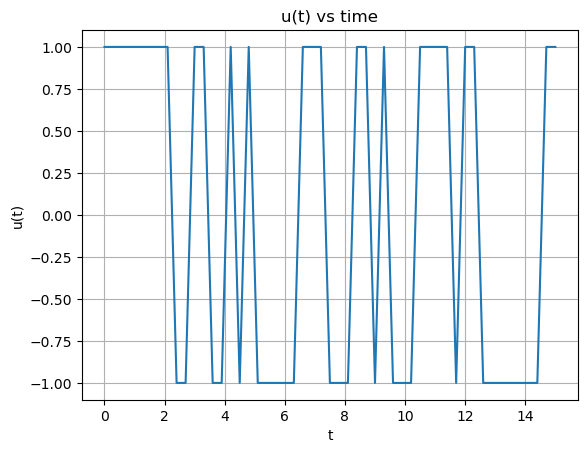

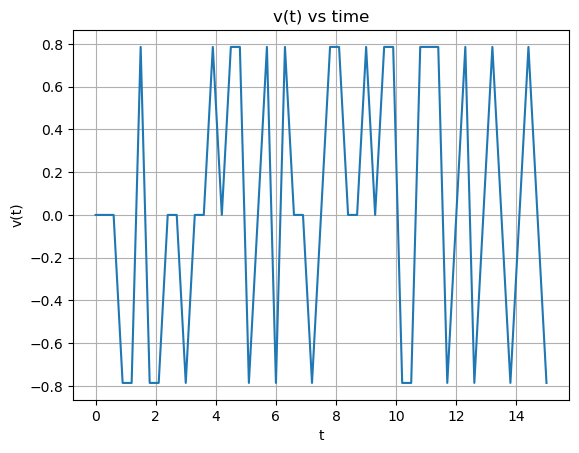

In [77]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


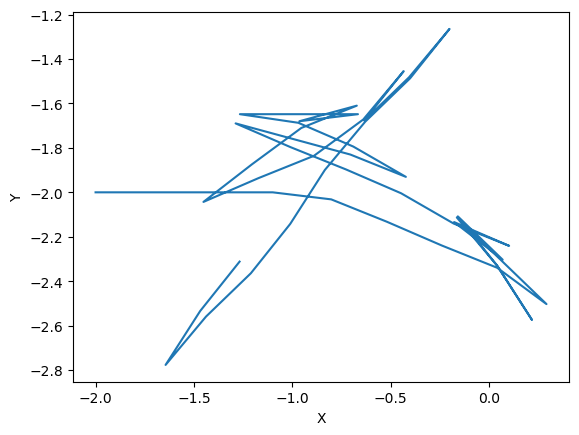

In [78]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

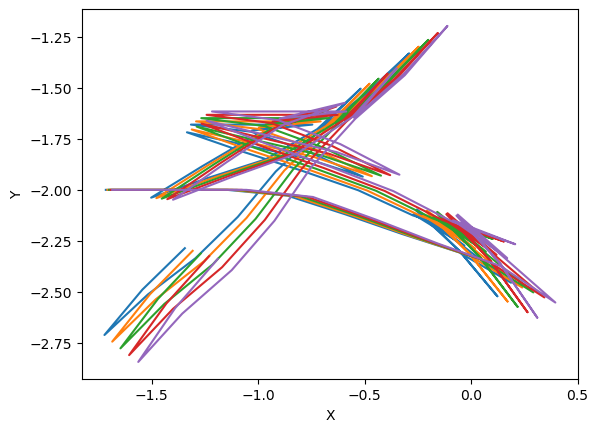

30.335674433283277


In [79]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))


## Best Trajectory

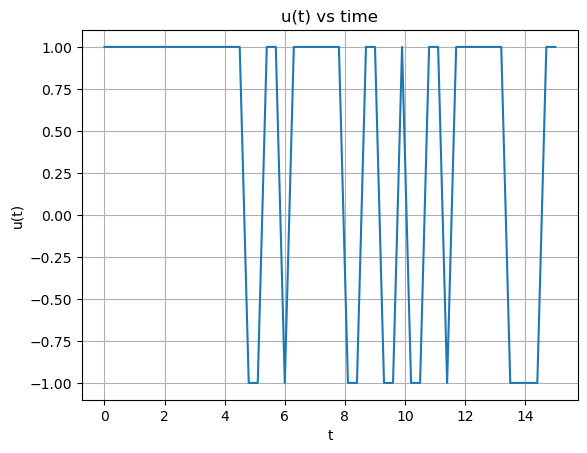

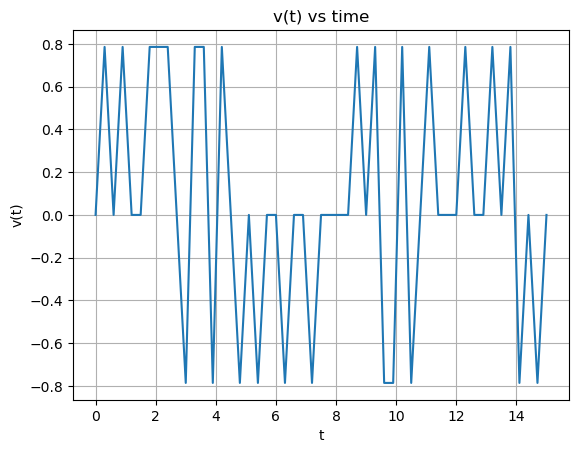

In [80]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

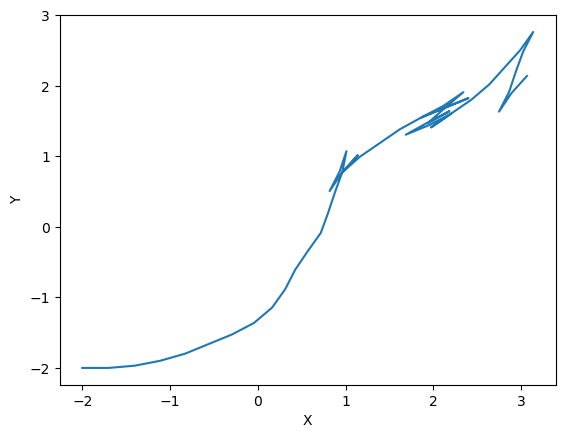

In [81]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

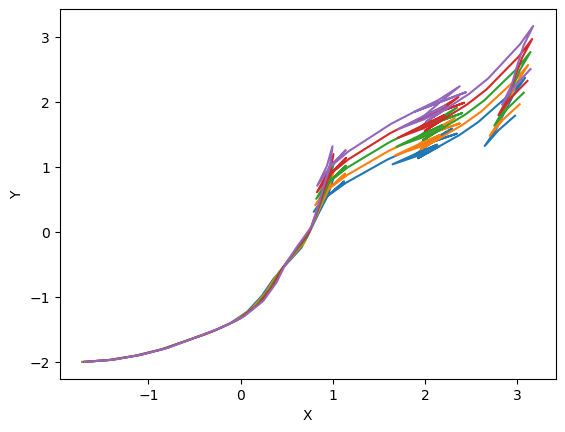

1.2796057461076362


In [82]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

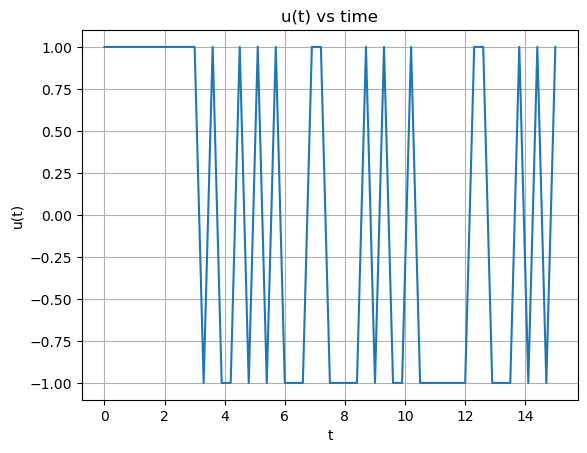

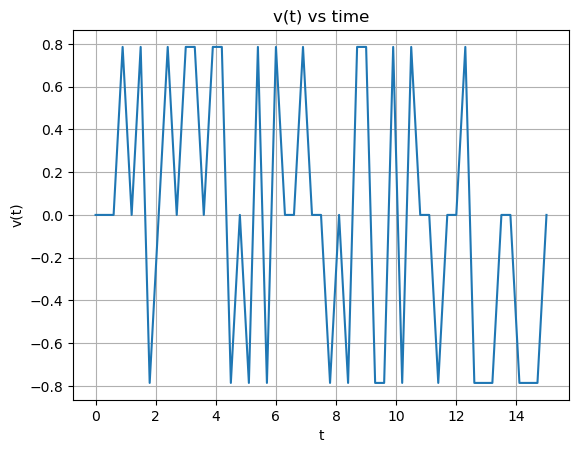

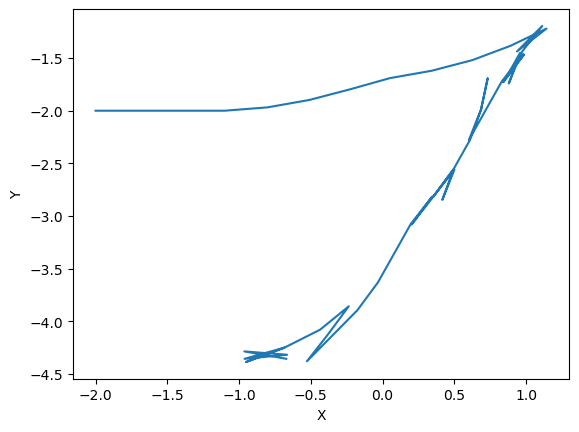

In [83]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags[time],observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

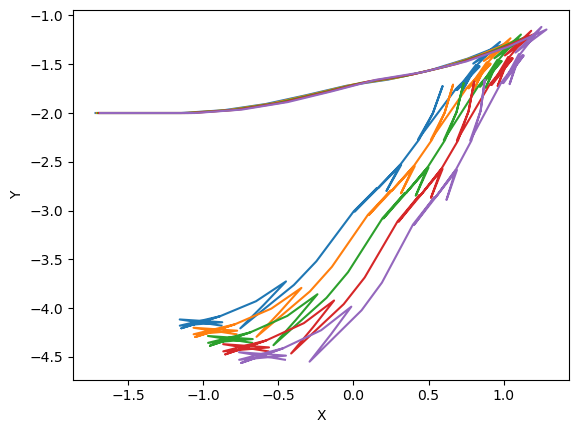

36.7090735526622


In [84]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))